In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
from collections import Counter
import re

In [120]:
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack

In [209]:
path = os.getcwd()
path_data_train = path + "\\covidChallenge\\data\\train.csv"
path_data_eval = path + "\\covidChallenge\\data\\evaluation.csv"

In [210]:
train_data = pd.read_csv(path_data_train)

In [211]:
train_data.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

In [212]:
train_data['urls'] = train_data['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
train_data['hashtags'] = train_data['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
train_data['user_mentions'] = train_data['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [213]:
#Non-relevant features, due to the fact that those are text not numerical values 
train_data.drop('timestamp', axis=1, inplace=True)
train_data.drop('text', axis=1, inplace=True)
train_data.drop('id', axis=1, inplace=True)

In [214]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags'],
      dtype='object')

In [215]:
#Convert boolean variables into int (Verified/Non-verified account)
train_data = train_data.astype(int)

In [216]:
pd.set_option('precision', 2)
print(train_data.describe())

       retweet_count  user_verified  user_statuses_count  \
count      665777.00      665777.00             6.66e+05   
mean          147.69           0.13             4.17e+04   
std          2972.05           0.34             9.85e+04   
min             0.00           0.00             0.00e+00   
25%             0.00           0.00             2.35e+03   
50%             0.00           0.00             1.08e+04   
75%             2.00           0.00             3.81e+04   
max        942572.00           1.00             7.20e+06   

       user_followers_count  user_friends_count  user_mentions       urls  \
count              6.66e+05            6.66e+05      665777.00  665777.00   
mean               2.33e+05            2.74e+03           0.28       0.38   
std                2.44e+06            1.73e+04           1.38       0.61   
min                0.00e+00            0.00e+00           0.00       0.00   
25%                2.06e+02            2.29e+02           0.00       0.00 

In [217]:
correlation = train_data.corr(method='pearson')
columns = correlation.nlargest(5, 'retweet_count').index
columns

Index(['retweet_count', 'user_followers_count', 'user_verified',
       'user_friends_count', 'urls'],
      dtype='object')

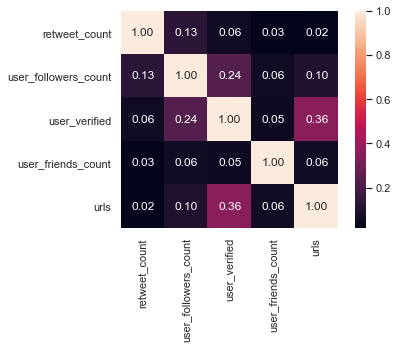

In [218]:
correlation_map = np.corrcoef(train_data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [219]:
train_data

retweet_count  user_verified  user_statuses_count  \
0                   0              0                68460   
1                   0              0                  309   
2                   0              0                 3241   
3                   0              0                32327   
4                   0              0                  581   
...               ...            ...                  ...   
665772              0              0                65355   
665773              1              0                 1807   
665774              8              0                  888   
665775              0              0                  452   
665776              0              0                  590   

        user_followers_count  user_friends_count  user_mentions  urls  \
0                       1101                1226              0     0   
1                         51                 202              0     0   
2                       1675                2325              0     0   
3                        667                 304              0     0   
4                         42                 127              0     0   
...                      ...                 ...            ...   ...   
665772                  1984                1902              0     0   
665773                  2029                 347              1     1   
665774                    85                 257              5     1   
665775                    38                  91              0     0   
665776                   184                 238              0     0   

        hashtags  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
665772         0  
665773         2  
665774         1  
665775         0  
665776         0  

[665777 rows x 8 columns]

### Preparing dataset

In [220]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [221]:
train_data.columns

Index(['retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags'],
      dtype='object')

In [222]:
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], \
                                           stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3, random_state=42)

In [223]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Test dataset shape: ", X_test.shape)

	 Train dataset shape:  (466043, 8)
	 Test dataset shape:  (199734, 8)


In [224]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train['retweet_count'], \
                                                  test_size=0.1, random_state=21)

In [225]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("\t Y_Test dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)

	 Train dataset shape:  (419438, 8)
	 Val dataset shape:  (46605, 8)
	 Y_Test dataset shape:  (419438,)
	 Y_val dataset shape:  (46605,)


In [226]:
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_val = X_val.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

In [182]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("-----------------------------------------------------")
print("\t Y_train dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)
print("-----------------------------------------------------")
print("\t X_Test dataset shape: ", X_test.shape)
print("\t Y_test dataset shape: ", y_test.shape)

	 Train dataset shape:  (419438, 6)
	 Val dataset shape:  (46605, 6)
-----------------------------------------------------
	 Y_train dataset shape:  (419438,)
	 Y_val dataset shape:  (46605,)
-----------------------------------------------------
	 X_Test dataset shape:  (199734, 6)
	 Y_test dataset shape:  (199734,)


In [183]:
X_train

user_statuses_count  user_followers_count  user_friends_count  \
362154                  476                    76                 263   
464261                 2271                   865                2739   
557298               189405                  2077                 354   
567570                 1230                    23                 263   
409066                18298                  1425                 660   
...                     ...                   ...                 ...   
52071                 52045                  5014                 512   
587292                 3934                  1309                 441   
436367                26876                    57                  42   
579837                  932                   164                  68   
360289                41964               1199040                1597   

        user_mentions  urls  hashtags  
362154              0     0         0  
464261              0     0         0  
557298              0     0         0  
567570              0     0         0  
409066              0     0         0  
...               ...   ...       ...  
52071               0     0         0  
587292              0     0         0  
436367              0     0         0  
579837              0     1         9  
360289              0     0         0  

[419438 rows x 6 columns]

In [184]:
#scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Creating Model

In [185]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [186]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [189]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_FEATURES = X_train.shape[1]

In [190]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

**NN Achitecture**: a simple 3 layer feedforward neural net here. We use ReLU as the activation at all layers.

In [191]:
class Regression(nn.Module):
    def __init__(self, num_features):
        super(Regression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 8)
        self.layer_2 = nn.Linear(8, 24)
        self.layer_3 = nn.Linear(24, 32)
        #self.layer_4 = nn.Linear(32, 28)
        #self.layer_5 = nn.Linear(28, 8)
        self.layer_out = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)

In [192]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [193]:
model = Regression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Regression(
  (layer_1): Linear(in_features=6, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=24, bias=True)
  (layer_3): Linear(in_features=24, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


In [194]:
loss_stats = {
    'train': [],
    "val": []
}

In [195]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

Epoch 001: | Train Loss: 7227383.28495 | Val Loss: 24628596.25340
	   | MAE Train Loss: 3003002.72396 | MAE Val Loss: 16190717.18520
Epoch 002: | Train Loss: 7178729.34508 | Val Loss: 24539161.52686
	   | MAE Train Loss: 3059451.18753 | MAE Val Loss: 13027179.18272
Epoch 003: | Train Loss: 7184603.94679 | Val Loss: 24559343.25969
	   | MAE Train Loss: 3002663.51334 | MAE Val Loss: 13520891.23245
Epoch 004: | Train Loss: 7175646.86828 | Val Loss: 24577003.60702
	   | MAE Train Loss: 3002172.73739 | MAE Val Loss: 11894448.81447
Epoch 005: | Train Loss: 7164814.80414 | Val Loss: 24582245.35456
	   | MAE Train Loss: 3031218.53429 | MAE Val Loss: 11562870.68644


KeyboardInterrupt: 

In [ ]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
print("Mean Squared Error :", mse)
print("mean_absolute_error :", mae)

In [ ]:
PATH = "NN_" + str(EPOCHS) + "_StandardScaler_epochs_" + str(int(mae)) + ".pt"
torch.save(model.state_dict(), PATH)

----------------------------------------- Old Model using MinMaxScaler -------------------------------------------

### Autoencoder Architecture

In [227]:
train_data = pd.read_csv(path_data_train)

In [228]:
train_data['urls'] = train_data['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
train_data['hashtags'] = train_data['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
train_data['user_mentions'] = train_data['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [229]:
#Non-relevant features, due to the fact that those are text not numerical values 
train_data.drop('timestamp', axis=1, inplace=True)
train_data.drop('text', axis=1, inplace=True)
train_data.drop('id', axis=1, inplace=True)

In [230]:
#Convert boolean variables into int (Verified/Non-verified account)
train_data = train_data.astype(int)

In [231]:
train_data

retweet_count  user_verified  user_statuses_count  \
0                   0              0                68460   
1                   0              0                  309   
2                   0              0                 3241   
3                   0              0                32327   
4                   0              0                  581   
...               ...            ...                  ...   
665772              0              0                65355   
665773              1              0                 1807   
665774              8              0                  888   
665775              0              0                  452   
665776              0              0                  590   

        user_followers_count  user_friends_count  user_mentions  urls  \
0                       1101                1226              0     0   
1                         51                 202              0     0   
2                       1675                2325              0     0   
3                        667                 304              0     0   
4                         42                 127              0     0   
...                      ...                 ...            ...   ...   
665772                  1984                1902              0     0   
665773                  2029                 347              1     1   
665774                    85                 257              5     1   
665775                    38                  91              0     0   
665776                   184                 238              0     0   

        hashtags  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
665772         0  
665773         2  
665774         1  
665775         0  
665776         0  

[665777 rows x 8 columns]

In [244]:
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], \
                                           stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3, random_state=42)

In [245]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train['retweet_count'], \
                                                  test_size=0.1, random_state=21)

In [246]:
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_val = X_val.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

In [247]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("-----------------------------------------------------")
print("\t Y_train dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)
print("-----------------------------------------------------")
print("\t X_Test dataset shape: ", X_test.shape)
print("\t Y_test dataset shape: ", y_test.shape)

	 Train dataset shape:  (419438, 7)
	 Val dataset shape:  (46605, 7)
-----------------------------------------------------
	 Y_train dataset shape:  (419438,)
	 Y_val dataset shape:  (46605,)
-----------------------------------------------------
	 X_Test dataset shape:  (199734, 7)
	 Y_test dataset shape:  (199734,)


In [248]:
X_train.describe()

user_verified  user_statuses_count  user_followers_count  \
count      419438.00             4.19e+05              4.19e+05   
mean            0.13             4.15e+04              2.26e+05   
std             0.34             9.81e+04              2.33e+06   
min             0.00             1.00e+00              0.00e+00   
25%             0.00             2.34e+03              2.06e+02   
50%             0.00             1.07e+04              9.97e+02   
75%             0.00             3.80e+04              5.93e+03   
max             1.00             5.89e+06              1.17e+08   

       user_friends_count  user_mentions       urls   hashtags  
count            4.19e+05      419438.00  419438.00  419438.00  
mean             2.72e+03           0.28       0.38       0.49  
std              1.75e+04           1.38       0.61       1.53  
min              0.00e+00           0.00       0.00       0.00  
25%              2.28e+02           0.00       0.00       0.00  
50%              6.37e+02           0.00       0.00       0.00  
75%              1.74e+03           0.00       1.00       0.00  
max              4.40e+06          50.00       9.00      37.00

In [249]:
#scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [269]:
pdX_Train = pd.DataFrame(X_train)
pdX_Train.describe()

0         1         2         3         4         5         6
count  4.19e+05  4.19e+05  4.19e+05  4.19e+05  4.19e+05  4.19e+05  4.19e+05
mean  -2.27e-17 -7.72e-18 -5.39e-18  3.69e-18 -1.61e-17 -5.42e-17  2.46e-17
std    1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00
min   -3.91e-01 -4.23e-01 -9.70e-02 -1.56e-01 -1.99e-01 -6.20e-01 -3.19e-01
25%   -3.91e-01 -4.00e-01 -9.70e-02 -1.43e-01 -1.99e-01 -6.20e-01 -3.19e-01
50%   -3.91e-01 -3.14e-01 -9.66e-02 -1.19e-01 -1.99e-01 -6.20e-01 -3.19e-01
75%   -3.91e-01 -3.65e-02 -9.45e-02 -5.62e-02 -1.99e-01  1.01e+00 -3.19e-01
max    2.56e+00  5.96e+01  5.02e+01  2.51e+02  3.59e+01  1.41e+01  2.39e+01

In [270]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [271]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [272]:
class Regression(nn.Module):
    def __init__(self, num_features):
        super(Regression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)

In [273]:
model = Regression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Regression(
  (layer_1): Linear(in_features=7, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=32, bias=True)
  (layer_5): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [274]:
EPOCHS = 70
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = X_train.shape[1]

In [275]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [276]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [277]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

Epoch 001: | Train Loss: 7428164.29851 | Val Loss: 24783573.14999
	   | MAE Train Loss: 1481265.82665 | MAE Val Loss: 12511115.52833
Epoch 002: | Train Loss: 7316045.78743 | Val Loss: 24690994.00980
	   | MAE Train Loss: 1433099.35516 | MAE Val Loss: 11814632.56599
Epoch 003: | Train Loss: 7211199.85427 | Val Loss: 24636458.74586
	   | MAE Train Loss: 1486892.20342 | MAE Val Loss: 12396727.77640
Epoch 004: | Train Loss: 7207259.06821 | Val Loss: 24823915.77877
	   | MAE Train Loss: 1409118.90209 | MAE Val Loss: 10414145.73018
Epoch 005: | Train Loss: 7206198.84882 | Val Loss: 24529694.97424
	   | MAE Train Loss: 1373751.81902 | MAE Val Loss: 14888307.64985
Epoch 006: | Train Loss: 7182993.41226 | Val Loss: 24665540.48692
	   | MAE Train Loss: 1357642.95016 | MAE Val Loss: 14329664.77842
Epoch 007: | Train Loss: 7207320.55743 | Val Loss: 25058642.07495
	   | MAE Train Loss: 1369109.41929 | MAE Val Loss: 21993390.21907
Epoch 008: | Train Loss: 7175807.26240 | Val Loss: 24580120.49694
	  

KeyboardInterrupt: 

-----------------------------------------------------------

#### Training model

In [101]:
loss_stats = {
    'train': [],
    "val": []
}

In [102]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

Epoch 001: | Train Loss: 8803272.11120 | Val Loss: 4553019.97666
	   | MAE Train Loss: 1701404.47735 | MAE Val Loss: 11415476.96967
Epoch 002: | Train Loss: 8674393.40182 | Val Loss: 4529523.95408
	   | MAE Train Loss: 1667470.76041 | MAE Val Loss: 11005112.70865
Epoch 003: | Train Loss: 8658668.09905 | Val Loss: 4515888.58225
	   | MAE Train Loss: 1626851.35726 | MAE Val Loss: 9829770.74211
Epoch 004: | Train Loss: 8643787.70429 | Val Loss: 4517078.18852
	   | MAE Train Loss: 1596403.48551 | MAE Val Loss: 11063351.71539
Epoch 005: | Train Loss: 8639426.73513 | Val Loss: 4545749.49265
	   | MAE Train Loss: 1605078.24028 | MAE Val Loss: 11277778.90486
Epoch 006: | Train Loss: 8641442.69966 | Val Loss: 4515847.45876
	   | MAE Train Loss: 1602471.29617 | MAE Val Loss: 10433635.60042
Epoch 007: | Train Loss: 8639367.04255 | Val Loss: 4513345.05767
	   | MAE Train Loss: 1605120.19468 | MAE Val Loss: 11056776.34618
Epoch 008: | Train Loss: 8635078.97385 | Val Loss: 4513211.76077
	   | MAE Tr

Epoch 064: | Train Loss: 8594698.33861 | Val Loss: 4507861.21591
	   | MAE Train Loss: 1597334.93835 | MAE Val Loss: 9313930.08480
Epoch 065: | Train Loss: 8586892.47184 | Val Loss: 4513578.33672
	   | MAE Train Loss: 1585234.15759 | MAE Val Loss: 11174184.33612
Epoch 066: | Train Loss: 8584739.91386 | Val Loss: 4499698.03890
	   | MAE Train Loss: 1584000.31404 | MAE Val Loss: 10428149.33920
Epoch 067: | Train Loss: 8576274.18945 | Val Loss: 4514719.28294
	   | MAE Train Loss: 1590995.68567 | MAE Val Loss: 9831709.39992
Epoch 068: | Train Loss: 8599166.43810 | Val Loss: 4514676.75327
	   | MAE Train Loss: 1584920.38166 | MAE Val Loss: 9280476.75465
Epoch 069: | Train Loss: 8568012.42237 | Val Loss: 4496894.16834
	   | MAE Train Loss: 1578911.57856 | MAE Val Loss: 9948871.25161
Epoch 070: | Train Loss: 8579831.20356 | Val Loss: 4519277.82698
	   | MAE Train Loss: 1578168.48038 | MAE Val Loss: 12922993.25579
Epoch 071: | Train Loss: 8577284.49821 | Val Loss: 4516453.61460
	   | MAE Train

Epoch 127: | Train Loss: 8541694.31711 | Val Loss: 4673051.58311
	   | MAE Train Loss: 1580434.81517 | MAE Val Loss: 15254973.29288
Epoch 128: | Train Loss: 8578988.09626 | Val Loss: 4509082.85330
	   | MAE Train Loss: 1626775.38448 | MAE Val Loss: 10007904.35118
Epoch 129: | Train Loss: 8545623.02100 | Val Loss: 4632020.66741
	   | MAE Train Loss: 1599644.88971 | MAE Val Loss: 13551265.64771
Epoch 130: | Train Loss: 8487228.90328 | Val Loss: 4506959.78388
	   | MAE Train Loss: 1590627.69163 | MAE Val Loss: 11623156.87479
Epoch 131: | Train Loss: 8571128.64751 | Val Loss: 4496226.83554
	   | MAE Train Loss: 1611904.95901 | MAE Val Loss: 10615930.37234
Epoch 132: | Train Loss: 8519477.77539 | Val Loss: 4530069.40977
	   | MAE Train Loss: 1600593.80571 | MAE Val Loss: 10107002.01695
Epoch 133: | Train Loss: 8529437.73333 | Val Loss: 4513065.26250
	   | MAE Train Loss: 1612065.33812 | MAE Val Loss: 9823459.16598
Epoch 134: | Train Loss: 8539046.04788 | Val Loss: 4494017.16529
	   | MAE Tr

Epoch 190: | Train Loss: 8520110.95135 | Val Loss: 4562205.63182
	   | MAE Train Loss: 1560914.97804 | MAE Val Loss: 9806028.58766
Epoch 191: | Train Loss: 8511425.42152 | Val Loss: 4511542.50253
	   | MAE Train Loss: 1555936.55514 | MAE Val Loss: 10672148.25963
Epoch 192: | Train Loss: 8510343.27217 | Val Loss: 4509043.90591
	   | MAE Train Loss: 1569189.90051 | MAE Val Loss: 9836642.19221
Epoch 193: | Train Loss: 8549811.08923 | Val Loss: 4502976.79204
	   | MAE Train Loss: 1568143.07253 | MAE Val Loss: 10728310.93276
Epoch 194: | Train Loss: 8550884.65816 | Val Loss: 4489122.16849
	   | MAE Train Loss: 1564508.02424 | MAE Val Loss: 10722514.97149
Epoch 195: | Train Loss: 8509681.65453 | Val Loss: 4524974.70330
	   | MAE Train Loss: 1568047.82816 | MAE Val Loss: 9567593.81057
Epoch 196: | Train Loss: 8567309.43937 | Val Loss: 4501293.26740
	   | MAE Train Loss: 1581783.59191 | MAE Val Loss: 10524253.56733
Epoch 197: | Train Loss: 8513251.32224 | Val Loss: 4521946.22775
	   | MAE Trai

### Checking Results

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

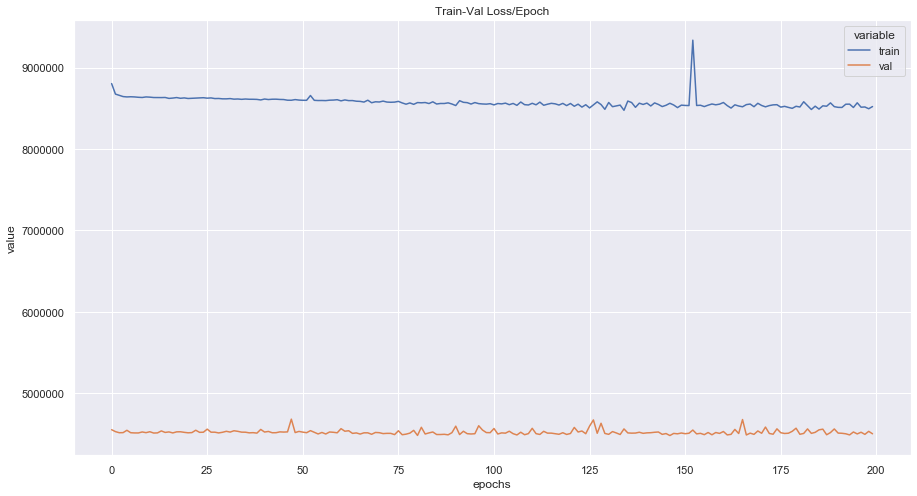

In [103]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

### Testing Model

In [104]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [105]:
mse = mean_squared_error(y_test, y_pred_list)
mae = mean_absolute_error(y_test, y_pred_list)
print("Mean Squared Error :", mse)
print("mean_absolute_error :", mae)

Mean Squared Error : 9269369.746158665
mean_absolute_error : 217.29757313564943


### Saving Model

In [106]:
PATH = "NN_" + str(EPOCHS) + "_epochs_" + str(int(mae)) + ".pt"
torch.save(model.state_dict(), PATH)

### Predicting Kaggle dataset

In [107]:
evaluation = pd.read_csv(path_data_eval)

In [108]:
evaluation['urls'] = evaluation['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
evaluation['hashtags'] = evaluation['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
evaluation['user_mentions'] = evaluation['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [109]:
#Non-relevant features, can not be used for LR models
evaluation.drop('timestamp', axis=1, inplace=True)
evaluation.drop('text', axis=1, inplace=True)

In [110]:
print("\t Shape of evaluation: ", evaluation.shape)

	 Shape of evaluation:  (285334, 8)


In [111]:
withoutID = evaluation.copy()
withoutID.drop('id', axis=1, inplace=True)

In [112]:
scaler = MinMaxScaler()
withoutID = scaler.fit_transform(withoutID)
#withoutID = np.array(withoutID)

In [113]:
withoutID.shape

(285334, 7)

In [114]:
class EvaluationDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [115]:
withoutID = EvaluationDataset(torch.from_numpy(withoutID).float())
evaluation_loader = DataLoader(dataset=withoutID, batch_size=1)

In [116]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch in evaluation_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [117]:
import csv

f = open("NN_epochs200.csv", "w+")
with open("NN_epochs200.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    
    startIndex = 665776
    for index, prediction in enumerate(y_pred_list):
        print(str(evaluation['id'].iloc[index]) + " ," + str(int(prediction)))
        writer.writerow([str(startIndex + index) , str(int(prediction))])

665776 ,33
665777 ,574
665778 ,33
665779 ,244
665780 ,275
665781 ,33
665782 ,33
665783 ,210
665784 ,476
665785 ,33
665786 ,578
665787 ,33
665788 ,145
665789 ,641
665790 ,33
665791 ,28
665792 ,28
665793 ,28
665794 ,706
665795 ,33
665796 ,49
665797 ,88
665798 ,303
665799 ,32
665800 ,33
665801 ,33
665802 ,33
665803 ,25
665804 ,31
665805 ,27
665806 ,262
665807 ,28
665808 ,616
665809 ,33
665810 ,33
665811 ,136
665812 ,33
665813 ,269
665814 ,210
665815 ,33
665816 ,33
665817 ,98
665818 ,32
665819 ,33
665820 ,33
665821 ,33
665822 ,224
665823 ,33
665824 ,156
665825 ,155
665826 ,284
665827 ,32
665828 ,349
665829 ,14
665830 ,267
665831 ,33
665832 ,33
665833 ,33
665834 ,33
665835 ,33
665836 ,32
665837 ,33
665838 ,187
665839 ,33
665840 ,33
665841 ,33
665842 ,33
665843 ,30
665844 ,33
665845 ,33
665846 ,2
665847 ,33
665848 ,173
665849 ,25
665850 ,158
665851 ,136
665852 ,33
665853 ,33
665854 ,263
665855 ,32
665856 ,33
665857 ,33
665858 ,32
665859 ,274
665860 ,32
665861 ,265
665862 ,33
665863 ,32
66586

666734 ,33
666735 ,140
666736 ,68
666737 ,33
666738 ,33
666739 ,262
666740 ,33
666741 ,27
666742 ,33
666743 ,33
666744 ,33
666745 ,33
666746 ,33
666747 ,33
666748 ,266
666749 ,443
666750 ,33
666751 ,33
666752 ,33
666753 ,32
666754 ,20
666755 ,33
666756 ,33
666757 ,33
666758 ,25
666759 ,63
666760 ,33
666761 ,33
666762 ,33
666763 ,221
666764 ,33
666765 ,33
666766 ,155
666767 ,33
666768 ,265
666769 ,33
666770 ,33
666771 ,289
666772 ,32
666773 ,59
666774 ,72
666775 ,26
666776 ,31
666777 ,33
666778 ,33
666779 ,33
666780 ,26
666781 ,33
666782 ,31
666783 ,33
666784 ,33
666785 ,33
666786 ,33
666787 ,27
666788 ,33
666789 ,33
666790 ,32
666791 ,202
666792 ,57
666793 ,33
666794 ,33
666795 ,33
666796 ,27
666797 ,603
666798 ,33
666799 ,33
666800 ,33
666801 ,33
666802 ,178
666803 ,31
666804 ,33
666805 ,31
666806 ,33
666807 ,268
666808 ,33
666809 ,72
666810 ,33
666811 ,33
666812 ,32
666813 ,276
666814 ,37
666815 ,33
666816 ,105
666817 ,33
666818 ,242
666819 ,33
666820 ,33
666821 ,33
666822 ,665
66682

667660 ,33
667661 ,33
667662 ,31
667663 ,33
667664 ,33
667665 ,33
667666 ,250
667667 ,24
667668 ,33
667669 ,85
667670 ,33
667671 ,517
667672 ,33
667673 ,177
667674 ,33
667675 ,263
667676 ,106
667677 ,33
667678 ,33
667679 ,29
667680 ,33
667681 ,33
667682 ,23
667683 ,261
667684 ,33
667685 ,33
667686 ,32
667687 ,33
667688 ,33
667689 ,33
667690 ,561
667691 ,171
667692 ,33
667693 ,33
667694 ,33
667695 ,33
667696 ,31
667697 ,23
667698 ,33
667699 ,18
667700 ,326
667701 ,33
667702 ,33
667703 ,30
667704 ,33
667705 ,31
667706 ,33
667707 ,31
667708 ,180
667709 ,33
667710 ,33
667711 ,33
667712 ,19
667713 ,33
667714 ,271
667715 ,33
667716 ,33
667717 ,33
667718 ,30
667719 ,33
667720 ,33
667721 ,33
667722 ,32
667723 ,137
667724 ,262
667725 ,33
667726 ,27
667727 ,33
667728 ,33
667729 ,16
667730 ,33
667731 ,33
667732 ,33
667733 ,32
667734 ,33
667735 ,152
667736 ,33
667737 ,33
667738 ,262
667739 ,705
667740 ,222
667741 ,118
667742 ,124
667743 ,27
667744 ,33
667745 ,33
667746 ,28
667747 ,41
667748 ,33
66

668409 ,33
668410 ,33
668411 ,33
668412 ,33
668413 ,33
668414 ,33
668415 ,33
668416 ,28
668417 ,33
668418 ,33
668419 ,234
668420 ,271
668421 ,22
668422 ,265
668423 ,33
668424 ,33
668425 ,33
668426 ,33
668427 ,30
668428 ,33
668429 ,33
668430 ,262
668431 ,244
668432 ,33
668433 ,222
668434 ,33
668435 ,33
668436 ,82
668437 ,223
668438 ,271
668439 ,260
668440 ,31
668441 ,33
668442 ,33
668443 ,27
668444 ,33
668445 ,33
668446 ,33
668447 ,28
668448 ,33
668449 ,26
668450 ,138
668451 ,302
668452 ,282
668453 ,32
668454 ,24
668455 ,33
668456 ,25
668457 ,33
668458 ,33
668459 ,33
668460 ,33
668461 ,422
668462 ,33
668463 ,33
668464 ,33
668465 ,33
668466 ,33
668467 ,33
668468 ,31
668469 ,33
668470 ,33
668471 ,33
668472 ,33
668473 ,217
668474 ,33
668475 ,33
668476 ,33
668477 ,50
668478 ,32
668479 ,188
668480 ,33
668481 ,33
668482 ,33
668483 ,33
668484 ,33
668485 ,33
668486 ,33
668487 ,33
668488 ,33
668489 ,22
668490 ,82
668491 ,121
668492 ,33
668493 ,262
668494 ,268
668495 ,33
668496 ,33
668497 ,33
668

669815 ,33
669816 ,33
669817 ,32
669818 ,33
669819 ,32
669820 ,33
669821 ,33
669822 ,33
669823 ,33
669824 ,275
669825 ,127
669826 ,33
669827 ,32
669828 ,137
669829 ,33
669830 ,172
669831 ,33
669832 ,30
669833 ,33
669834 ,26
669835 ,638
669836 ,33
669837 ,32
669838 ,33
669839 ,33
669840 ,262
669841 ,33
669842 ,33
669843 ,33
669844 ,233
669845 ,33
669846 ,123
669847 ,197
669848 ,594
669849 ,33
669850 ,33
669851 ,33
669852 ,187
669853 ,262
669854 ,629
669855 ,33
669856 ,33
669857 ,263
669858 ,85
669859 ,24
669860 ,137
669861 ,33
669862 ,33
669863 ,33
669864 ,33
669865 ,32
669866 ,33
669867 ,33
669868 ,29
669869 ,272
669870 ,31
669871 ,201
669872 ,33
669873 ,266
669874 ,33
669875 ,33
669876 ,263
669877 ,33
669878 ,423
669879 ,103
669880 ,198
669881 ,6331
669882 ,241
669883 ,33
669884 ,33
669885 ,32
669886 ,33
669887 ,33
669888 ,235
669889 ,33
669890 ,598
669891 ,265
669892 ,33
669893 ,33
669894 ,33
669895 ,33
669896 ,27
669897 ,33
669898 ,33
669899 ,33
669900 ,267
669901 ,73
669902 ,33
669

670814 ,31
670815 ,282
670816 ,33
670817 ,27
670818 ,33
670819 ,32
670820 ,262
670821 ,33
670822 ,24
670823 ,33
670824 ,33
670825 ,24
670826 ,33
670827 ,32
670828 ,33
670829 ,33
670830 ,33
670831 ,31
670832 ,33
670833 ,33
670834 ,24
670835 ,127
670836 ,28
670837 ,64
670838 ,86
670839 ,33
670840 ,269
670841 ,401
670842 ,33
670843 ,33
670844 ,33
670845 ,33
670846 ,33
670847 ,33
670848 ,33
670849 ,33
670850 ,85
670851 ,32
670852 ,136
670853 ,33
670854 ,33
670855 ,607
670856 ,101
670857 ,27
670858 ,263
670859 ,262
670860 ,33
670861 ,227
670862 ,121
670863 ,33
670864 ,33
670865 ,239
670866 ,33
670867 ,72
670868 ,33
670869 ,33
670870 ,33
670871 ,103
670872 ,33
670873 ,33
670874 ,33
670875 ,33
670876 ,320
670877 ,25
670878 ,54
670879 ,33
670880 ,261
670881 ,33
670882 ,33
670883 ,33
670884 ,33
670885 ,33
670886 ,32
670887 ,28
670888 ,33
670889 ,97
670890 ,137
670891 ,33
670892 ,621
670893 ,27
670894 ,29
670895 ,33
670896 ,31
670897 ,261
670898 ,33
670899 ,31
670900 ,33
670901 ,33
670902 ,33
67

671670 ,33
671671 ,198
671672 ,33
671673 ,74
671674 ,216
671675 ,33
671676 ,32
671677 ,262
671678 ,33
671679 ,33
671680 ,31
671681 ,1736
671682 ,33
671683 ,33
671684 ,33
671685 ,136
671686 ,33
671687 ,164
671688 ,32
671689 ,33
671690 ,335
671691 ,27
671692 ,33
671693 ,32
671694 ,33
671695 ,268
671696 ,33
671697 ,4397
671698 ,33
671699 ,33
671700 ,31
671701 ,33
671702 ,31
671703 ,33
671704 ,262
671705 ,32
671706 ,33
671707 ,33
671708 ,601
671709 ,33
671710 ,33
671711 ,33
671712 ,261
671713 ,24
671714 ,33
671715 ,31
671716 ,33
671717 ,90
671718 ,27
671719 ,33
671720 ,33
671721 ,644
671722 ,198
671723 ,33
671724 ,1776
671725 ,194
671726 ,155
671727 ,139
671728 ,33
671729 ,455
671730 ,33
671731 ,264
671732 ,32
671733 ,32
671734 ,658
671735 ,33
671736 ,27
671737 ,33
671738 ,27
671739 ,33
671740 ,33
671741 ,33
671742 ,33
671743 ,33
671744 ,33
671745 ,131
671746 ,33
671747 ,33
671748 ,160
671749 ,32
671750 ,281
671751 ,733
671752 ,265
671753 ,241
671754 ,193
671755 ,33
671756 ,33
671757 ,580


672935 ,23
672936 ,33
672937 ,341
672938 ,33
672939 ,33
672940 ,32
672941 ,254
672942 ,32
672943 ,26
672944 ,38
672945 ,33
672946 ,260
672947 ,33
672948 ,33
672949 ,248
672950 ,33
672951 ,67
672952 ,246
672953 ,33
672954 ,32
672955 ,270
672956 ,33
672957 ,247
672958 ,33
672959 ,263
672960 ,33
672961 ,57
672962 ,584
672963 ,237
672964 ,226
672965 ,33
672966 ,264
672967 ,33
672968 ,32
672969 ,33
672970 ,33
672971 ,33
672972 ,32
672973 ,33
672974 ,33
672975 ,33
672976 ,23
672977 ,33
672978 ,30
672979 ,643
672980 ,126
672981 ,86
672982 ,612
672983 ,33
672984 ,95
672985 ,33
672986 ,33
672987 ,33
672988 ,32
672989 ,32
672990 ,270
672991 ,265
672992 ,267
672993 ,143
672994 ,33
672995 ,32
672996 ,33
672997 ,282
672998 ,31
672999 ,33
673000 ,33
673001 ,32
673002 ,33
673003 ,32
673004 ,219
673005 ,171
673006 ,33
673007 ,132
673008 ,369
673009 ,264
673010 ,33
673011 ,378
673012 ,33
673013 ,33
673014 ,27
673015 ,396
673016 ,123
673017 ,33
673018 ,33
673019 ,211
673020 ,33
673021 ,33
673022 ,33
673

673949 ,33
673950 ,166
673951 ,33
673952 ,31
673953 ,33
673954 ,33
673955 ,108
673956 ,141
673957 ,627
673958 ,33
673959 ,33
673960 ,32
673961 ,28
673962 ,33
673963 ,33
673964 ,33
673965 ,184
673966 ,33
673967 ,245
673968 ,33
673969 ,33
673970 ,33
673971 ,33
673972 ,33
673973 ,32
673974 ,607
673975 ,32
673976 ,33
673977 ,32
673978 ,33
673979 ,136
673980 ,33
673981 ,25
673982 ,530
673983 ,33
673984 ,33
673985 ,20
673986 ,33
673987 ,33
673988 ,27
673989 ,33
673990 ,33
673991 ,33
673992 ,32
673993 ,139
673994 ,266
673995 ,33
673996 ,262
673997 ,67
673998 ,31
673999 ,667
674000 ,33
674001 ,22
674002 ,36
674003 ,33
674004 ,30
674005 ,26
674006 ,37
674007 ,32
674008 ,194
674009 ,654
674010 ,33
674011 ,33
674012 ,32
674013 ,261
674014 ,33
674015 ,26
674016 ,22
674017 ,33
674018 ,33
674019 ,31
674020 ,268
674021 ,26
674022 ,31
674023 ,264
674024 ,33
674025 ,32
674026 ,33
674027 ,31
674028 ,33
674029 ,33
674030 ,33
674031 ,33
674032 ,33
674033 ,27
674034 ,33
674035 ,262
674036 ,432
674037 ,464


674809 ,33
674810 ,33
674811 ,33
674812 ,33
674813 ,33
674814 ,271
674815 ,33
674816 ,33
674817 ,33
674818 ,33
674819 ,33
674820 ,33
674821 ,33
674822 ,30
674823 ,33
674824 ,33
674825 ,32
674826 ,178
674827 ,26
674828 ,32
674829 ,32
674830 ,33
674831 ,27
674832 ,58
674833 ,139
674834 ,92
674835 ,33
674836 ,22
674837 ,28
674838 ,32
674839 ,26
674840 ,606
674841 ,33
674842 ,31
674843 ,33
674844 ,31
674845 ,32
674846 ,33
674847 ,681
674848 ,33
674849 ,33
674850 ,33
674851 ,30
674852 ,33
674853 ,69
674854 ,33
674855 ,19
674856 ,28
674857 ,30
674858 ,33
674859 ,33
674860 ,33
674861 ,32
674862 ,33
674863 ,33
674864 ,27
674865 ,32
674866 ,33
674867 ,33
674868 ,33
674869 ,33
674870 ,511
674871 ,27
674872 ,33
674873 ,193
674874 ,28
674875 ,19
674876 ,33
674877 ,33
674878 ,33
674879 ,659
674880 ,33
674881 ,32
674882 ,33
674883 ,32
674884 ,28
674885 ,33
674886 ,33
674887 ,31
674888 ,623
674889 ,137
674890 ,105
674891 ,602
674892 ,33
674893 ,253
674894 ,33
674895 ,366
674896 ,33
674897 ,33
674898 

675862 ,33
675863 ,33
675864 ,32
675865 ,33
675866 ,31
675867 ,33
675868 ,262
675869 ,33
675870 ,79
675871 ,33
675872 ,86
675873 ,164
675874 ,220
675875 ,33
675876 ,33
675877 ,33
675878 ,32
675879 ,33
675880 ,33
675881 ,32
675882 ,65
675883 ,160
675884 ,400
675885 ,33
675886 ,33
675887 ,31
675888 ,239
675889 ,28
675890 ,32
675891 ,33
675892 ,33
675893 ,30
675894 ,31
675895 ,33
675896 ,275
675897 ,32
675898 ,33
675899 ,33
675900 ,33
675901 ,32
675902 ,615
675903 ,33
675904 ,33
675905 ,33
675906 ,14
675907 ,33
675908 ,33
675909 ,33
675910 ,32
675911 ,31
675912 ,32
675913 ,33
675914 ,33
675915 ,33
675916 ,311
675917 ,229
675918 ,32
675919 ,557
675920 ,33
675921 ,33
675922 ,33
675923 ,26
675924 ,33
675925 ,33
675926 ,59
675927 ,33
675928 ,151
675929 ,32
675930 ,33
675931 ,33
675932 ,33
675933 ,31
675934 ,33
675935 ,607
675936 ,157
675937 ,131
675938 ,29
675939 ,33
675940 ,11
675941 ,33
675942 ,94
675943 ,33
675944 ,33
675945 ,33
675946 ,33
675947 ,117
675948 ,33
675949 ,33
675950 ,33
67595

676908 ,33
676909 ,33
676910 ,33
676911 ,33
676912 ,33
676913 ,23
676914 ,33
676915 ,33
676916 ,159
676917 ,33
676918 ,272
676919 ,33
676920 ,145
676921 ,33
676922 ,32
676923 ,615
676924 ,616
676925 ,33
676926 ,31
676927 ,33
676928 ,366
676929 ,33
676930 ,33
676931 ,32
676932 ,19
676933 ,33
676934 ,33
676935 ,282
676936 ,33
676937 ,33
676938 ,16
676939 ,221
676940 ,94
676941 ,27
676942 ,33
676943 ,60
676944 ,32
676945 ,287
676946 ,33
676947 ,33
676948 ,32
676949 ,33
676950 ,138
676951 ,631
676952 ,33
676953 ,33
676954 ,708
676955 ,266
676956 ,33
676957 ,32
676958 ,271
676959 ,31
676960 ,33
676961 ,28
676962 ,344
676963 ,642
676964 ,33
676965 ,33
676966 ,33
676967 ,33
676968 ,614
676969 ,265
676970 ,33
676971 ,265
676972 ,33
676973 ,30
676974 ,263
676975 ,33
676976 ,33
676977 ,60
676978 ,32
676979 ,266
676980 ,33
676981 ,33
676982 ,32
676983 ,33
676984 ,33
676985 ,33
676986 ,33
676987 ,33
676988 ,230
676989 ,39
676990 ,33
676991 ,33
676992 ,33
676993 ,270
676994 ,33
676995 ,33
676996 ,3

677806 ,300
677807 ,33
677808 ,33
677809 ,33
677810 ,33
677811 ,33
677812 ,63
677813 ,33
677814 ,26
677815 ,33
677816 ,32
677817 ,33
677818 ,26
677819 ,33
677820 ,32
677821 ,343
677822 ,33
677823 ,224
677824 ,105
677825 ,207
677826 ,33
677827 ,33
677828 ,26
677829 ,263
677830 ,33
677831 ,33
677832 ,132
677833 ,33
677834 ,32
677835 ,39
677836 ,20
677837 ,33
677838 ,30
677839 ,268
677840 ,33
677841 ,193
677842 ,30
677843 ,33
677844 ,32
677845 ,27
677846 ,33
677847 ,33
677848 ,30
677849 ,33
677850 ,32
677851 ,699
677852 ,33
677853 ,33
677854 ,33
677855 ,33
677856 ,262
677857 ,57
677858 ,33
677859 ,266
677860 ,33
677861 ,33
677862 ,30
677863 ,30
677864 ,644
677865 ,271
677866 ,33
677867 ,33
677868 ,33
677869 ,33
677870 ,33
677871 ,432
677872 ,21
677873 ,157
677874 ,33
677875 ,324
677876 ,667
677877 ,33
677878 ,274
677879 ,33
677880 ,33
677881 ,32
677882 ,33
677883 ,33
677884 ,95
677885 ,30
677886 ,107
677887 ,87
677888 ,130
677889 ,33
677890 ,31
677891 ,31
677892 ,33
677893 ,54
677894 ,32


678765 ,33
678766 ,84
678767 ,33
678768 ,33
678769 ,222
678770 ,516
678771 ,347
678772 ,21
678773 ,106
678774 ,273
678775 ,23
678776 ,253
678777 ,33
678778 ,33
678779 ,233
678780 ,150
678781 ,31
678782 ,33
678783 ,33
678784 ,33
678785 ,33
678786 ,33
678787 ,28
678788 ,33
678789 ,25
678790 ,63
678791 ,33
678792 ,33
678793 ,33
678794 ,708
678795 ,33
678796 ,358
678797 ,33
678798 ,33
678799 ,49
678800 ,33
678801 ,682
678802 ,32
678803 ,137
678804 ,33
678805 ,33
678806 ,263
678807 ,33
678808 ,721
678809 ,222
678810 ,3230
678811 ,33
678812 ,33
678813 ,33
678814 ,265
678815 ,339
678816 ,33
678817 ,33
678818 ,474
678819 ,33
678820 ,33
678821 ,23
678822 ,262
678823 ,38
678824 ,33
678825 ,175
678826 ,33
678827 ,33
678828 ,33
678829 ,33
678830 ,32
678831 ,33
678832 ,33
678833 ,30
678834 ,33
678835 ,33
678836 ,269
678837 ,33
678838 ,33
678839 ,332
678840 ,32
678841 ,33
678842 ,33
678843 ,33
678844 ,33
678845 ,33
678846 ,32
678847 ,33
678848 ,33
678849 ,33
678850 ,103
678851 ,33
678852 ,33
678853 

679590 ,33
679591 ,33
679592 ,141
679593 ,710
679594 ,33
679595 ,27
679596 ,33
679597 ,32
679598 ,33
679599 ,21
679600 ,223
679601 ,33
679602 ,33
679603 ,277
679604 ,261
679605 ,225
679606 ,33
679607 ,470
679608 ,33
679609 ,40
679610 ,265
679611 ,33
679612 ,202
679613 ,33
679614 ,32
679615 ,618
679616 ,33
679617 ,33
679618 ,33
679619 ,44
679620 ,33
679621 ,32
679622 ,31
679623 ,184
679624 ,273
679625 ,23
679626 ,28
679627 ,33
679628 ,33
679629 ,136
679630 ,33
679631 ,33
679632 ,213
679633 ,233
679634 ,33
679635 ,298
679636 ,261
679637 ,33
679638 ,267
679639 ,18449
679640 ,33
679641 ,33
679642 ,33
679643 ,33
679644 ,33
679645 ,33
679646 ,33
679647 ,33
679648 ,191
679649 ,33
679650 ,33
679651 ,27
679652 ,266
679653 ,262
679654 ,186
679655 ,33
679656 ,156
679657 ,262
679658 ,154
679659 ,33
679660 ,236
679661 ,33
679662 ,33
679663 ,129
679664 ,266
679665 ,33
679666 ,33
679667 ,269
679668 ,264
679669 ,33
679670 ,23
679671 ,33
679672 ,33
679673 ,362
679674 ,33
679675 ,264
679676 ,33
679677 ,

680579 ,181
680580 ,11
680581 ,64
680582 ,33
680583 ,88
680584 ,33
680585 ,33
680586 ,33
680587 ,32
680588 ,33
680589 ,33
680590 ,33
680591 ,415
680592 ,33
680593 ,33
680594 ,64
680595 ,33
680596 ,33
680597 ,182
680598 ,33
680599 ,282
680600 ,188
680601 ,32
680602 ,32
680603 ,33
680604 ,261
680605 ,277
680606 ,25
680607 ,89
680608 ,33
680609 ,263
680610 ,497
680611 ,33
680612 ,33
680613 ,33
680614 ,29
680615 ,33
680616 ,194
680617 ,238
680618 ,33
680619 ,146
680620 ,155
680621 ,31
680622 ,70
680623 ,155
680624 ,125
680625 ,33
680626 ,30
680627 ,33
680628 ,33
680629 ,137
680630 ,33
680631 ,33
680632 ,33
680633 ,26
680634 ,267
680635 ,33
680636 ,33
680637 ,263
680638 ,290
680639 ,264
680640 ,647
680641 ,269
680642 ,123
680643 ,33
680644 ,243
680645 ,33
680646 ,33
680647 ,33
680648 ,33
680649 ,33
680650 ,33
680651 ,33
680652 ,33
680653 ,33
680654 ,33
680655 ,33
680656 ,261
680657 ,25
680658 ,87
680659 ,33
680660 ,177
680661 ,266
680662 ,33
680663 ,32
680664 ,33
680665 ,33
680666 ,157
6806

681659 ,33
681660 ,118
681661 ,33
681662 ,33
681663 ,216
681664 ,33
681665 ,33
681666 ,33
681667 ,31
681668 ,33
681669 ,31
681670 ,33
681671 ,33
681672 ,33
681673 ,23
681674 ,33
681675 ,31
681676 ,33
681677 ,280
681678 ,31
681679 ,457
681680 ,33
681681 ,286
681682 ,32
681683 ,223
681684 ,33
681685 ,33
681686 ,140
681687 ,187
681688 ,33
681689 ,33
681690 ,33
681691 ,31
681692 ,33
681693 ,266
681694 ,33
681695 ,33
681696 ,33
681697 ,108
681698 ,33
681699 ,33
681700 ,33
681701 ,31
681702 ,33
681703 ,33
681704 ,266
681705 ,619
681706 ,540
681707 ,33
681708 ,33
681709 ,28
681710 ,33
681711 ,33
681712 ,32
681713 ,33
681714 ,33
681715 ,265
681716 ,33
681717 ,298
681718 ,118
681719 ,33
681720 ,33
681721 ,31
681722 ,27
681723 ,33
681724 ,33
681725 ,33
681726 ,33
681727 ,33
681728 ,33
681729 ,33
681730 ,25
681731 ,33
681732 ,263
681733 ,33
681734 ,19
681735 ,33
681736 ,231
681737 ,33
681738 ,31
681739 ,33
681740 ,33
681741 ,117
681742 ,33
681743 ,33
681744 ,371
681745 ,134
681746 ,33
681747 ,31


682701 ,107
682702 ,79
682703 ,33
682704 ,17
682705 ,266
682706 ,31
682707 ,33
682708 ,128
682709 ,731
682710 ,33
682711 ,262
682712 ,55
682713 ,33
682714 ,33
682715 ,1099
682716 ,33
682717 ,222
682718 ,175
682719 ,33
682720 ,33
682721 ,92
682722 ,221
682723 ,33
682724 ,33
682725 ,230
682726 ,33
682727 ,31
682728 ,33
682729 ,32
682730 ,33
682731 ,33
682732 ,33
682733 ,29
682734 ,33
682735 ,33
682736 ,32
682737 ,381
682738 ,332
682739 ,33
682740 ,26
682741 ,27
682742 ,32
682743 ,635
682744 ,33
682745 ,607
682746 ,604
682747 ,33
682748 ,619
682749 ,33
682750 ,33
682751 ,31
682752 ,264
682753 ,32
682754 ,33
682755 ,28
682756 ,33
682757 ,277
682758 ,33
682759 ,27
682760 ,86
682761 ,33
682762 ,33
682763 ,33
682764 ,33
682765 ,27
682766 ,33
682767 ,33
682768 ,33
682769 ,33
682770 ,2
682771 ,33
682772 ,33
682773 ,33
682774 ,262
682775 ,31
682776 ,33
682777 ,27
682778 ,124
682779 ,33
682780 ,33
682781 ,20
682782 ,32
682783 ,31
682784 ,33
682785 ,33
682786 ,20
682787 ,89
682788 ,33
682789 ,25
6

683741 ,24
683742 ,170
683743 ,26
683744 ,33
683745 ,33
683746 ,296
683747 ,262
683748 ,33
683749 ,173
683750 ,26
683751 ,33
683752 ,232
683753 ,33
683754 ,33
683755 ,33
683756 ,33
683757 ,263
683758 ,105
683759 ,33
683760 ,32
683761 ,16
683762 ,33
683763 ,33
683764 ,369
683765 ,33
683766 ,33
683767 ,30
683768 ,33
683769 ,33
683770 ,25
683771 ,33
683772 ,33
683773 ,33
683774 ,745
683775 ,33
683776 ,33
683777 ,151
683778 ,33
683779 ,663
683780 ,266
683781 ,33
683782 ,18177
683783 ,33
683784 ,33
683785 ,33
683786 ,277
683787 ,33
683788 ,33
683789 ,32
683790 ,33
683791 ,33
683792 ,33
683793 ,33
683794 ,33
683795 ,33
683796 ,33
683797 ,33
683798 ,1812
683799 ,33
683800 ,33
683801 ,33
683802 ,33
683803 ,33
683804 ,33
683805 ,31
683806 ,607
683807 ,33
683808 ,32
683809 ,33
683810 ,31
683811 ,224
683812 ,261
683813 ,33
683814 ,267
683815 ,33
683816 ,31
683817 ,222
683818 ,69
683819 ,33
683820 ,33
683821 ,306
683822 ,269
683823 ,269
683824 ,33
683825 ,71
683826 ,159
683827 ,27
683828 ,32
68382

684486 ,33
684487 ,33
684488 ,33
684489 ,26
684490 ,541
684491 ,33
684492 ,33
684493 ,33
684494 ,33
684495 ,27
684496 ,285
684497 ,32
684498 ,33
684499 ,49
684500 ,33
684501 ,33
684502 ,33
684503 ,29
684504 ,33
684505 ,33
684506 ,617
684507 ,21
684508 ,262
684509 ,33
684510 ,28
684511 ,104
684512 ,32
684513 ,33
684514 ,31
684515 ,33
684516 ,33
684517 ,17
684518 ,32
684519 ,33
684520 ,33
684521 ,33
684522 ,32
684523 ,137
684524 ,229
684525 ,33
684526 ,33
684527 ,33
684528 ,33
684529 ,262
684530 ,33
684531 ,31
684532 ,749
684533 ,28
684534 ,33
684535 ,33
684536 ,32
684537 ,-4
684538 ,188
684539 ,254
684540 ,33
684541 ,276
684542 ,33
684543 ,33
684544 ,26
684545 ,33
684546 ,31
684547 ,32
684548 ,33
684549 ,238
684550 ,474
684551 ,33
684552 ,239
684553 ,26
684554 ,33
684555 ,33
684556 ,33
684557 ,268
684558 ,33
684559 ,33
684560 ,32
684561 ,32
684562 ,33
684563 ,89
684564 ,30
684565 ,33
684566 ,30
684567 ,33
684568 ,33
684569 ,195
684570 ,32
684571 ,16
684572 ,33
684573 ,160
684574 ,183
68

685265 ,32
685266 ,33
685267 ,33
685268 ,33
685269 ,31
685270 ,33
685271 ,252
685272 ,33
685273 ,33
685274 ,285
685275 ,264
685276 ,33
685277 ,271
685278 ,33
685279 ,64
685280 ,69
685281 ,33
685282 ,33
685283 ,33
685284 ,183
685285 ,243
685286 ,32
685287 ,33
685288 ,609
685289 ,33
685290 ,138
685291 ,33
685292 ,33
685293 ,32
685294 ,517
685295 ,33
685296 ,148
685297 ,33
685298 ,33
685299 ,33
685300 ,33
685301 ,48
685302 ,33
685303 ,33
685304 ,33
685305 ,33
685306 ,287
685307 ,86
685308 ,33
685309 ,33
685310 ,276
685311 ,32
685312 ,32
685313 ,31
685314 ,84
685315 ,31
685316 ,33
685317 ,32
685318 ,135
685319 ,33
685320 ,33
685321 ,33
685322 ,33
685323 ,33
685324 ,33
685325 ,33
685326 ,33
685327 ,33
685328 ,32
685329 ,94
685330 ,53
685331 ,33
685332 ,33
685333 ,266
685334 ,33
685335 ,30
685336 ,262
685337 ,33
685338 ,33
685339 ,33
685340 ,120
685341 ,32
685342 ,153
685343 ,33
685344 ,31
685345 ,33
685346 ,262
685347 ,134
685348 ,33
685349 ,33
685350 ,264
685351 ,33
685352 ,33
685353 ,33
6

686177 ,32
686178 ,298
686179 ,31
686180 ,31
686181 ,33
686182 ,222
686183 ,33
686184 ,33
686185 ,32
686186 ,33
686187 ,629
686188 ,196
686189 ,33
686190 ,33
686191 ,36
686192 ,33
686193 ,117
686194 ,263
686195 ,33
686196 ,29
686197 ,33
686198 ,32
686199 ,33
686200 ,157
686201 ,27
686202 ,33
686203 ,30
686204 ,33
686205 ,309
686206 ,193
686207 ,33
686208 ,33
686209 ,33
686210 ,27
686211 ,33
686212 ,33
686213 ,33
686214 ,33
686215 ,28
686216 ,222
686217 ,27
686218 ,140
686219 ,336
686220 ,32
686221 ,279
686222 ,91
686223 ,33
686224 ,268
686225 ,33
686226 ,114
686227 ,222
686228 ,266
686229 ,33
686230 ,33
686231 ,210
686232 ,159
686233 ,113
686234 ,33
686235 ,33
686236 ,31
686237 ,32
686238 ,33
686239 ,33
686240 ,33
686241 ,32
686242 ,33
686243 ,33
686244 ,33
686245 ,277
686246 ,31
686247 ,33
686248 ,13
686249 ,30
686250 ,32
686251 ,184
686252 ,33
686253 ,32
686254 ,186
686255 ,33
686256 ,32
686257 ,33
686258 ,33
686259 ,617
686260 ,33
686261 ,33
686262 ,31
686263 ,244
686264 ,33
686265 

687420 ,31
687421 ,32
687422 ,31
687423 ,32
687424 ,265
687425 ,33
687426 ,213
687427 ,27
687428 ,33
687429 ,33
687430 ,33
687431 ,32
687432 ,33
687433 ,33
687434 ,44
687435 ,32
687436 ,32
687437 ,133
687438 ,33
687439 ,33
687440 ,180
687441 ,33
687442 ,33
687443 ,33
687444 ,201
687445 ,222
687446 ,377
687447 ,33
687448 ,548
687449 ,744
687450 ,33
687451 ,33
687452 ,33
687453 ,88
687454 ,266
687455 ,33
687456 ,33
687457 ,33
687458 ,32
687459 ,33
687460 ,33
687461 ,171
687462 ,72
687463 ,31
687464 ,139
687465 ,33
687466 ,33
687467 ,24
687468 ,28
687469 ,33
687470 ,33
687471 ,389
687472 ,20
687473 ,33
687474 ,33
687475 ,33
687476 ,99
687477 ,65
687478 ,32
687479 ,33
687480 ,612
687481 ,231
687482 ,352
687483 ,33
687484 ,33
687485 ,28
687486 ,33
687487 ,209
687488 ,33
687489 ,114
687490 ,33
687491 ,49
687492 ,103
687493 ,264
687494 ,33
687495 ,85
687496 ,33
687497 ,32
687498 ,33
687499 ,33
687500 ,608
687501 ,33
687502 ,26
687503 ,677
687504 ,33
687505 ,33
687506 ,33
687507 ,30
687508 ,33

688376 ,33
688377 ,33
688378 ,32
688379 ,33
688380 ,33
688381 ,33
688382 ,33
688383 ,33
688384 ,33
688385 ,33
688386 ,33
688387 ,33
688388 ,33
688389 ,143
688390 ,32
688391 ,33
688392 ,33
688393 ,87
688394 ,28
688395 ,83
688396 ,27
688397 ,33
688398 ,237
688399 ,33
688400 ,33
688401 ,33
688402 ,33
688403 ,269
688404 ,33
688405 ,30
688406 ,25
688407 ,33
688408 ,384
688409 ,28
688410 ,26
688411 ,33
688412 ,30
688413 ,33
688414 ,32
688415 ,32
688416 ,31
688417 ,33
688418 ,33
688419 ,33
688420 ,31
688421 ,779
688422 ,33
688423 ,33
688424 ,33
688425 ,276
688426 ,33
688427 ,24
688428 ,239
688429 ,33
688430 ,352
688431 ,27
688432 ,33
688433 ,33
688434 ,23
688435 ,33
688436 ,33
688437 ,33
688438 ,33
688439 ,138
688440 ,31
688441 ,33
688442 ,33
688443 ,588
688444 ,59
688445 ,33
688446 ,33
688447 ,33
688448 ,33
688449 ,355
688450 ,32
688451 ,33
688452 ,27
688453 ,282
688454 ,140
688455 ,33
688456 ,33
688457 ,33
688458 ,33
688459 ,33
688460 ,33
688461 ,33
688462 ,33
688463 ,269
688464 ,270
688465

689290 ,33
689291 ,33
689292 ,33
689293 ,33
689294 ,33
689295 ,212
689296 ,177
689297 ,18
689298 ,136
689299 ,33
689300 ,30
689301 ,33
689302 ,33
689303 ,235
689304 ,33
689305 ,134
689306 ,262
689307 ,33
689308 ,33
689309 ,273
689310 ,323
689311 ,98
689312 ,137
689313 ,33
689314 ,32
689315 ,403
689316 ,33
689317 ,33
689318 ,32
689319 ,33
689320 ,33
689321 ,31
689322 ,33
689323 ,146
689324 ,82
689325 ,33
689326 ,33
689327 ,33
689328 ,32
689329 ,33
689330 ,33
689331 ,32
689332 ,33
689333 ,33
689334 ,265
689335 ,219
689336 ,33
689337 ,33
689338 ,26
689339 ,33
689340 ,33
689341 ,599
689342 ,28
689343 ,153
689344 ,312
689345 ,32
689346 ,33
689347 ,28
689348 ,157
689349 ,218
689350 ,608
689351 ,33
689352 ,264
689353 ,156
689354 ,157
689355 ,31
689356 ,33
689357 ,33
689358 ,33
689359 ,271
689360 ,33
689361 ,86
689362 ,22
689363 ,33
689364 ,33
689365 ,30
689366 ,32
689367 ,33
689368 ,33
689369 ,2058
689370 ,33
689371 ,86
689372 ,33
689373 ,33
689374 ,265
689375 ,33
689376 ,33
689377 ,670
68937

690056 ,33
690057 ,33
690058 ,33
690059 ,32
690060 ,639
690061 ,55
690062 ,289
690063 ,33
690064 ,748
690065 ,33
690066 ,670
690067 ,33
690068 ,188
690069 ,64
690070 ,539
690071 ,267
690072 ,33
690073 ,33
690074 ,33
690075 ,33
690076 ,32
690077 ,33
690078 ,281
690079 ,33
690080 ,121
690081 ,27
690082 ,32
690083 ,33
690084 ,232
690085 ,713
690086 ,33
690087 ,119
690088 ,33
690089 ,33
690090 ,27
690091 ,33
690092 ,18
690093 ,33
690094 ,33
690095 ,70
690096 ,33
690097 ,358
690098 ,115
690099 ,33
690100 ,139
690101 ,27
690102 ,33
690103 ,120
690104 ,26
690105 ,33
690106 ,30
690107 ,2727
690108 ,33
690109 ,82
690110 ,32
690111 ,33
690112 ,26
690113 ,19
690114 ,33
690115 ,33
690116 ,33
690117 ,33
690118 ,32
690119 ,33
690120 ,33
690121 ,33
690122 ,136
690123 ,33
690124 ,32
690125 ,33
690126 ,32
690127 ,130
690128 ,33
690129 ,33
690130 ,32
690131 ,33
690132 ,33
690133 ,32
690134 ,33
690135 ,33
690136 ,33
690137 ,32
690138 ,23
690139 ,306
690140 ,33
690141 ,33
690142 ,1883
690143 ,33
690144 ,1

691217 ,12
691218 ,33
691219 ,33
691220 ,33
691221 ,33
691222 ,33
691223 ,33
691224 ,29
691225 ,33
691226 ,32
691227 ,33
691228 ,118
691229 ,24
691230 ,33
691231 ,700
691232 ,32
691233 ,384
691234 ,33
691235 ,33
691236 ,32
691237 ,32
691238 ,33
691239 ,33
691240 ,156
691241 ,33
691242 ,110
691243 ,22
691244 ,33
691245 ,33
691246 ,33
691247 ,33
691248 ,202
691249 ,222
691250 ,33
691251 ,32
691252 ,33
691253 ,32
691254 ,278
691255 ,32
691256 ,31
691257 ,32
691258 ,33
691259 ,33
691260 ,690
691261 ,33
691262 ,179
691263 ,33
691264 ,33
691265 ,33
691266 ,33
691267 ,33
691268 ,33
691269 ,32
691270 ,33
691271 ,33
691272 ,112
691273 ,33
691274 ,33
691275 ,314
691276 ,32
691277 ,85
691278 ,49
691279 ,33
691280 ,83
691281 ,33
691282 ,94
691283 ,33
691284 ,262
691285 ,32
691286 ,39
691287 ,139
691288 ,33
691289 ,255
691290 ,33
691291 ,33
691292 ,32
691293 ,419
691294 ,31
691295 ,33
691296 ,33
691297 ,26
691298 ,263
691299 ,33
691300 ,105
691301 ,33
691302 ,26
691303 ,308
691304 ,33
691305 ,33
69

692289 ,33
692290 ,33
692291 ,33
692292 ,33
692293 ,696
692294 ,30
692295 ,33
692296 ,33
692297 ,31
692298 ,33
692299 ,33
692300 ,202
692301 ,33
692302 ,33
692303 ,33
692304 ,28
692305 ,222
692306 ,33
692307 ,155
692308 ,6330
692309 ,32
692310 ,33
692311 ,32
692312 ,138
692313 ,33
692314 ,144
692315 ,262
692316 ,33
692317 ,33
692318 ,33
692319 ,263
692320 ,33
692321 ,33
692322 ,28
692323 ,1129
692324 ,138
692325 ,31
692326 ,33
692327 ,33
692328 ,33
692329 ,262
692330 ,32
692331 ,32
692332 ,159
692333 ,31
692334 ,33
692335 ,90
692336 ,159
692337 ,83
692338 ,252
692339 ,33
692340 ,33
692341 ,130
692342 ,33
692343 ,33
692344 ,33
692345 ,376
692346 ,21
692347 ,31
692348 ,33
692349 ,23
692350 ,32
692351 ,33
692352 ,2
692353 ,33
692354 ,33
692355 ,33
692356 ,33
692357 ,33
692358 ,32
692359 ,25
692360 ,96
692361 ,31
692362 ,86
692363 ,33
692364 ,32
692365 ,165
692366 ,132
692367 ,33
692368 ,33
692369 ,23
692370 ,33
692371 ,137
692372 ,33
692373 ,33
692374 ,33
692375 ,33
692376 ,33
692377 ,33


693268 ,33
693269 ,33
693270 ,33
693271 ,33
693272 ,33
693273 ,33
693274 ,33
693275 ,30
693276 ,265
693277 ,33
693278 ,435
693279 ,33
693280 ,33
693281 ,33
693282 ,266
693283 ,33
693284 ,256
693285 ,238
693286 ,32
693287 ,32
693288 ,33
693289 ,33
693290 ,33
693291 ,33
693292 ,33
693293 ,24
693294 ,32
693295 ,79
693296 ,33
693297 ,32
693298 ,32
693299 ,33
693300 ,33
693301 ,33
693302 ,241
693303 ,33
693304 ,33
693305 ,33
693306 ,33
693307 ,32
693308 ,352
693309 ,27
693310 ,187
693311 ,265
693312 ,194
693313 ,33
693314 ,33
693315 ,576
693316 ,33
693317 ,33
693318 ,262
693319 ,124
693320 ,33
693321 ,33
693322 ,145
693323 ,138
693324 ,31
693325 ,33
693326 ,27
693327 ,33
693328 ,108
693329 ,33
693330 ,33
693331 ,44
693332 ,33
693333 ,33
693334 ,33
693335 ,33
693336 ,33
693337 ,267
693338 ,33
693339 ,266
693340 ,33
693341 ,720
693342 ,33
693343 ,26
693344 ,262
693345 ,295
693346 ,33
693347 ,31
693348 ,151
693349 ,28
693350 ,122
693351 ,33
693352 ,33
693353 ,33
693354 ,33
693355 ,33
693356 ,3

694014 ,33
694015 ,33
694016 ,33
694017 ,27
694018 ,33
694019 ,129
694020 ,31
694021 ,33
694022 ,33
694023 ,132
694024 ,33
694025 ,33
694026 ,32
694027 ,86
694028 ,33
694029 ,129
694030 ,33
694031 ,33
694032 ,125
694033 ,288
694034 ,33
694035 ,33
694036 ,118
694037 ,631
694038 ,32
694039 ,478
694040 ,33
694041 ,217
694042 ,197
694043 ,33
694044 ,33
694045 ,33
694046 ,33
694047 ,33
694048 ,33
694049 ,322
694050 ,262
694051 ,28
694052 ,33
694053 ,33
694054 ,153
694055 ,33
694056 ,32
694057 ,28
694058 ,33
694059 ,33
694060 ,33
694061 ,260
694062 ,33
694063 ,32
694064 ,264
694065 ,33
694066 ,33
694067 ,33
694068 ,26
694069 ,33
694070 ,30
694071 ,32
694072 ,85
694073 ,33
694074 ,188
694075 ,33
694076 ,33
694077 ,33
694078 ,249
694079 ,31
694080 ,32
694081 ,264
694082 ,33
694083 ,32
694084 ,33
694085 ,33
694086 ,33
694087 ,33
694088 ,33
694089 ,33
694090 ,68
694091 ,33
694092 ,111
694093 ,26
694094 ,33
694095 ,33
694096 ,133
694097 ,33
694098 ,32
694099 ,32
694100 ,244
694101 ,318
694102 ,27

695286 ,32
695287 ,609
695288 ,261
695289 ,222
695290 ,157
695291 ,618
695292 ,244
695293 ,264
695294 ,33
695295 ,145
695296 ,33
695297 ,32
695298 ,29
695299 ,62
695300 ,137
695301 ,33
695302 ,247
695303 ,33
695304 ,33
695305 ,259
695306 ,33
695307 ,33
695308 ,33
695309 ,33
695310 ,33
695311 ,24
695312 ,230
695313 ,32
695314 ,27
695315 ,92
695316 ,32
695317 ,33
695318 ,33
695319 ,744
695320 ,33
695321 ,33
695322 ,262
695323 ,33
695324 ,33
695325 ,33
695326 ,33
695327 ,33
695328 ,32
695329 ,33
695330 ,33
695331 ,33
695332 ,297
695333 ,280
695334 ,75
695335 ,24
695336 ,33
695337 ,174
695338 ,28
695339 ,364
695340 ,699
695341 ,33
695342 ,33
695343 ,217
695344 ,33
695345 ,33
695346 ,33
695347 ,33
695348 ,612
695349 ,33
695350 ,669
695351 ,8
695352 ,85
695353 ,33
695354 ,81
695355 ,31
695356 ,107
695357 ,33
695358 ,127
695359 ,33
695360 ,590
695361 ,33
695362 ,203
695363 ,33
695364 ,29
695365 ,272
695366 ,33
695367 ,292
695368 ,31
695369 ,32
695370 ,33
695371 ,33
695372 ,32
695373 ,249
6953

696285 ,33
696286 ,251
696287 ,31
696288 ,704
696289 ,61
696290 ,27
696291 ,263
696292 ,137
696293 ,167
696294 ,30
696295 ,45
696296 ,33
696297 ,33
696298 ,606
696299 ,604
696300 ,261
696301 ,593
696302 ,32
696303 ,27
696304 ,600
696305 ,739
696306 ,32
696307 ,33
696308 ,654
696309 ,219
696310 ,137
696311 ,33
696312 ,33
696313 ,33
696314 ,33
696315 ,33
696316 ,31
696317 ,33
696318 ,227
696319 ,157
696320 ,33
696321 ,26
696322 ,33
696323 ,33
696324 ,33
696325 ,18
696326 ,33
696327 ,33
696328 ,33
696329 ,23
696330 ,33
696331 ,33
696332 ,33
696333 ,31
696334 ,33
696335 ,263
696336 ,120
696337 ,31
696338 ,270
696339 ,35
696340 ,33
696341 ,33
696342 ,285
696343 ,33
696344 ,33
696345 ,33
696346 ,33
696347 ,49
696348 ,32
696349 ,156
696350 ,33
696351 ,31
696352 ,153
696353 ,33
696354 ,634
696355 ,497
696356 ,33
696357 ,26
696358 ,33
696359 ,33
696360 ,32
696361 ,285
696362 ,33
696363 ,33
696364 ,33
696365 ,33
696366 ,33
696367 ,33
696368 ,32
696369 ,33
696370 ,237
696371 ,33
696372 ,162
69637

697134 ,33
697135 ,264
697136 ,275
697137 ,33
697138 ,27
697139 ,262
697140 ,20
697141 ,33
697142 ,28
697143 ,33
697144 ,33
697145 ,256
697146 ,33
697147 ,262
697148 ,415
697149 ,261
697150 ,33
697151 ,142
697152 ,33
697153 ,32
697154 ,27
697155 ,221
697156 ,32
697157 ,33
697158 ,33
697159 ,112
697160 ,33
697161 ,33
697162 ,33
697163 ,33
697164 ,33
697165 ,33
697166 ,33
697167 ,607
697168 ,399
697169 ,32
697170 ,32
697171 ,889
697172 ,33
697173 ,33
697174 ,32
697175 ,33
697176 ,33
697177 ,32
697178 ,533
697179 ,33
697180 ,215
697181 ,33
697182 ,33
697183 ,33
697184 ,33
697185 ,32
697186 ,33
697187 ,32
697188 ,28
697189 ,33
697190 ,679
697191 ,33
697192 ,265
697193 ,33
697194 ,33
697195 ,33
697196 ,40
697197 ,66
697198 ,33
697199 ,33
697200 ,12
697201 ,194
697202 ,33
697203 ,33
697204 ,33
697205 ,293
697206 ,33
697207 ,263
697208 ,483
697209 ,254
697210 ,136
697211 ,129
697212 ,33
697213 ,33
697214 ,99
697215 ,33
697216 ,33
697217 ,191
697218 ,33
697219 ,33
697220 ,33
697221 ,33
697222 

698408 ,33
698409 ,33
698410 ,33
698411 ,33
698412 ,32
698413 ,137
698414 ,33
698415 ,33
698416 ,108
698417 ,18
698418 ,33
698419 ,619
698420 ,644
698421 ,33
698422 ,33
698423 ,32
698424 ,32
698425 ,33
698426 ,265
698427 ,33
698428 ,33
698429 ,272
698430 ,33
698431 ,33
698432 ,33
698433 ,247
698434 ,32
698435 ,197
698436 ,33
698437 ,20
698438 ,32
698439 ,264
698440 ,33
698441 ,33
698442 ,33
698443 ,31
698444 ,33
698445 ,28
698446 ,33
698447 ,32
698448 ,33
698449 ,33
698450 ,27
698451 ,33
698452 ,25
698453 ,610
698454 ,33
698455 ,33
698456 ,263
698457 ,24
698458 ,262
698459 ,33
698460 ,243
698461 ,33
698462 ,33
698463 ,332
698464 ,33
698465 ,33
698466 ,33
698467 ,32
698468 ,221
698469 ,410
698470 ,32
698471 ,33
698472 ,33
698473 ,49
698474 ,33
698475 ,638
698476 ,33
698477 ,589
698478 ,33
698479 ,33
698480 ,33
698481 ,33
698482 ,94
698483 ,33
698484 ,28
698485 ,33
698486 ,33
698487 ,33
698488 ,1544
698489 ,33
698490 ,33
698491 ,33
698492 ,120
698493 ,125
698494 ,33
698495 ,33
698496 ,26

699282 ,33
699283 ,278
699284 ,604
699285 ,33
699286 ,33
699287 ,175
699288 ,33
699289 ,33
699290 ,33
699291 ,33
699292 ,26
699293 ,33
699294 ,274
699295 ,30
699296 ,277
699297 ,33
699298 ,33
699299 ,33
699300 ,562
699301 ,64
699302 ,33
699303 ,33
699304 ,53
699305 ,111
699306 ,33
699307 ,33
699308 ,521
699309 ,33
699310 ,33
699311 ,33
699312 ,10
699313 ,33
699314 ,33
699315 ,33
699316 ,33
699317 ,33
699318 ,33
699319 ,33
699320 ,33
699321 ,32
699322 ,28
699323 ,33
699324 ,33
699325 ,33
699326 ,33
699327 ,616
699328 ,334
699329 ,275
699330 ,33
699331 ,35
699332 ,33
699333 ,33
699334 ,350
699335 ,24
699336 ,215
699337 ,160
699338 ,30
699339 ,33
699340 ,33
699341 ,33
699342 ,151
699343 ,33
699344 ,23
699345 ,142
699346 ,21
699347 ,33
699348 ,263
699349 ,125
699350 ,108
699351 ,22
699352 ,33
699353 ,33
699354 ,32
699355 ,28
699356 ,350
699357 ,33
699358 ,512
699359 ,33
699360 ,28
699361 ,33
699362 ,33
699363 ,33
699364 ,33
699365 ,33
699366 ,28
699367 ,78
699368 ,33
699369 ,33
699370 ,33


700259 ,208
700260 ,32
700261 ,33
700262 ,33
700263 ,33
700264 ,33
700265 ,33
700266 ,98
700267 ,290
700268 ,33
700269 ,32
700270 ,33
700271 ,33
700272 ,55
700273 ,33
700274 ,33
700275 ,33
700276 ,33
700277 ,87
700278 ,33
700279 ,104
700280 ,213
700281 ,33
700282 ,649
700283 ,33
700284 ,614
700285 ,33
700286 ,33
700287 ,33
700288 ,33
700289 ,33
700290 ,33
700291 ,33
700292 ,18
700293 ,33
700294 ,28
700295 ,33
700296 ,262
700297 ,268
700298 ,33
700299 ,33
700300 ,33
700301 ,26
700302 ,33
700303 ,33
700304 ,33
700305 ,31
700306 ,670
700307 ,33
700308 ,205
700309 ,33
700310 ,234
700311 ,27
700312 ,27
700313 ,69
700314 ,33
700315 ,33
700316 ,15
700317 ,89
700318 ,33
700319 ,33
700320 ,33
700321 ,273
700322 ,33
700323 ,33
700324 ,33
700325 ,272
700326 ,33
700327 ,262
700328 ,32
700329 ,267
700330 ,33
700331 ,105
700332 ,33
700333 ,32
700334 ,33
700335 ,151
700336 ,31
700337 ,33
700338 ,222
700339 ,22
700340 ,33
700341 ,136
700342 ,33
700343 ,33
700344 ,33
700345 ,412
700346 ,33
700347 ,33
7

701128 ,33
701129 ,83
701130 ,33
701131 ,33
701132 ,33
701133 ,33
701134 ,33
701135 ,457
701136 ,303
701137 ,33
701138 ,129
701139 ,28
701140 ,267
701141 ,31
701142 ,33
701143 ,48
701144 ,33
701145 ,222
701146 ,26
701147 ,33
701148 ,33
701149 ,33
701150 ,236
701151 ,650
701152 ,271
701153 ,32
701154 ,33
701155 ,33
701156 ,134
701157 ,33
701158 ,33
701159 ,186
701160 ,33
701161 ,33
701162 ,33
701163 ,32
701164 ,33
701165 ,33
701166 ,32
701167 ,33
701168 ,32
701169 ,224
701170 ,33
701171 ,33
701172 ,86
701173 ,28
701174 ,273
701175 ,33
701176 ,33
701177 ,271
701178 ,32
701179 ,13
701180 ,156
701181 ,33
701182 ,30
701183 ,32
701184 ,266
701185 ,33
701186 ,27
701187 ,28
701188 ,33
701189 ,33
701190 ,28
701191 ,33
701192 ,33
701193 ,24
701194 ,211
701195 ,26
701196 ,33
701197 ,112
701198 ,23
701199 ,225
701200 ,155
701201 ,33
701202 ,33
701203 ,33
701204 ,33
701205 ,33
701206 ,224
701207 ,33
701208 ,32
701209 ,33
701210 ,35
701211 ,186
701212 ,33
701213 ,205
701214 ,277
701215 ,33
701216 ,3

701887 ,33
701888 ,32
701889 ,32
701890 ,33
701891 ,33
701892 ,33
701893 ,275
701894 ,33
701895 ,30
701896 ,33
701897 ,33
701898 ,175
701899 ,33
701900 ,133
701901 ,31
701902 ,47
701903 ,33
701904 ,33
701905 ,33
701906 ,33
701907 ,32
701908 ,33
701909 ,596
701910 ,33
701911 ,33
701912 ,283
701913 ,836
701914 ,266
701915 ,33
701916 ,33
701917 ,33
701918 ,330
701919 ,29
701920 ,33
701921 ,185
701922 ,33
701923 ,94
701924 ,159
701925 ,33
701926 ,33
701927 ,33
701928 ,33
701929 ,42
701930 ,26
701931 ,33
701932 ,27
701933 ,33
701934 ,33
701935 ,153
701936 ,98
701937 ,33
701938 ,33
701939 ,32
701940 ,33
701941 ,575
701942 ,33
701943 ,268
701944 ,33
701945 ,33
701946 ,33
701947 ,32
701948 ,33
701949 ,27
701950 ,95
701951 ,33
701952 ,33
701953 ,28
701954 ,33
701955 ,30
701956 ,28
701957 ,9906
701958 ,32
701959 ,33
701960 ,288
701961 ,26
701962 ,12
701963 ,33
701964 ,33
701965 ,33
701966 ,602
701967 ,265
701968 ,33
701969 ,33
701970 ,33
701971 ,21
701972 ,33
701973 ,33
701974 ,274
701975 ,32
70

702726 ,32
702727 ,281
702728 ,33
702729 ,262
702730 ,187
702731 ,33
702732 ,28
702733 ,31
702734 ,33
702735 ,235
702736 ,33
702737 ,33
702738 ,265
702739 ,29
702740 ,33
702741 ,33
702742 ,33
702743 ,199
702744 ,33
702745 ,222
702746 ,10
702747 ,33
702748 ,33
702749 ,27
702750 ,262
702751 ,84
702752 ,33
702753 ,22
702754 ,33
702755 ,282
702756 ,560
702757 ,33
702758 ,138
702759 ,31
702760 ,27
702761 ,33
702762 ,30
702763 ,214
702764 ,33
702765 ,33
702766 ,27
702767 ,275
702768 ,348
702769 ,263
702770 ,33
702771 ,31
702772 ,33
702773 ,26
702774 ,33
702775 ,33
702776 ,259
702777 ,85
702778 ,270
702779 ,33
702780 ,3882
702781 ,271
702782 ,32
702783 ,33
702784 ,278
702785 ,33
702786 ,33
702787 ,157
702788 ,29
702789 ,33
702790 ,33
702791 ,408
702792 ,19
702793 ,27
702794 ,54
702795 ,33
702796 ,33
702797 ,33
702798 ,33
702799 ,33
702800 ,33
702801 ,22
702802 ,33
702803 ,33
702804 ,262
702805 ,33
702806 ,33
702807 ,33
702808 ,279
702809 ,45
702810 ,668
702811 ,33
702812 ,366
702813 ,33
70281

703827 ,33
703828 ,225
703829 ,33
703830 ,27
703831 ,28
703832 ,262
703833 ,1848
703834 ,193
703835 ,28
703836 ,33
703837 ,33
703838 ,33
703839 ,33
703840 ,32
703841 ,264
703842 ,26
703843 ,33
703844 ,66
703845 ,634
703846 ,33
703847 ,32
703848 ,445
703849 ,434
703850 ,266
703851 ,33
703852 ,33
703853 ,32
703854 ,28
703855 ,116
703856 ,31
703857 ,64
703858 ,369
703859 ,87
703860 ,263
703861 ,28
703862 ,208
703863 ,33
703864 ,32
703865 ,81
703866 ,33
703867 ,31
703868 ,183
703869 ,33
703870 ,33
703871 ,30
703872 ,505
703873 ,33
703874 ,33
703875 ,31
703876 ,33
703877 ,33
703878 ,32
703879 ,33
703880 ,190
703881 ,33
703882 ,33
703883 ,26
703884 ,33
703885 ,33
703886 ,33
703887 ,31
703888 ,32
703889 ,268
703890 ,33
703891 ,33
703892 ,272
703893 ,120
703894 ,634
703895 ,137
703896 ,33
703897 ,205
703898 ,33
703899 ,33
703900 ,33
703901 ,491
703902 ,270
703903 ,64
703904 ,32
703905 ,16
703906 ,262
703907 ,279
703908 ,33
703909 ,32
703910 ,33
703911 ,33
703912 ,33
703913 ,28
703914 ,33
70391

704619 ,26
704620 ,135
704621 ,332
704622 ,33
704623 ,262
704624 ,20
704625 ,32
704626 ,261
704627 ,262
704628 ,97
704629 ,21
704630 ,2036
704631 ,280
704632 ,33
704633 ,33
704634 ,33
704635 ,32
704636 ,33
704637 ,33
704638 ,31
704639 ,33
704640 ,33
704641 ,229
704642 ,29
704643 ,33
704644 ,242
704645 ,33
704646 ,217
704647 ,137
704648 ,32
704649 ,23
704650 ,33
704651 ,33
704652 ,32
704653 ,33
704654 ,33
704655 ,33
704656 ,33
704657 ,33
704658 ,64
704659 ,193
704660 ,32
704661 ,31
704662 ,33
704663 ,33
704664 ,223
704665 ,33
704666 ,33
704667 ,27
704668 ,31
704669 ,24
704670 ,33
704671 ,86
704672 ,32
704673 ,33
704674 ,222
704675 ,33
704676 ,33
704677 ,33
704678 ,33
704679 ,264
704680 ,33
704681 ,184
704682 ,268
704683 ,33
704684 ,261
704685 ,33
704686 ,33
704687 ,27
704688 ,351
704689 ,33
704690 ,33
704691 ,33
704692 ,435
704693 ,268
704694 ,33
704695 ,29
704696 ,33
704697 ,32
704698 ,33
704699 ,33
704700 ,33
704701 ,31
704702 ,33
704703 ,33
704704 ,33
704705 ,30
704706 ,33
704707 ,33

705412 ,213
705413 ,28
705414 ,551
705415 ,33
705416 ,33
705417 ,33
705418 ,33
705419 ,285
705420 ,33
705421 ,33
705422 ,32
705423 ,33
705424 ,129
705425 ,33
705426 ,183
705427 ,33
705428 ,261
705429 ,33
705430 ,33
705431 ,31
705432 ,26
705433 ,32
705434 ,664
705435 ,216
705436 ,274
705437 ,33
705438 ,33
705439 ,33
705440 ,33
705441 ,33
705442 ,128
705443 ,33
705444 ,33
705445 ,33
705446 ,33
705447 ,33
705448 ,33
705449 ,33
705450 ,100
705451 ,265
705452 ,33
705453 ,273
705454 ,52
705455 ,155
705456 ,33
705457 ,33
705458 ,30
705459 ,32
705460 ,33
705461 ,209
705462 ,33
705463 ,28
705464 ,32
705465 ,33
705466 ,33
705467 ,33
705468 ,31
705469 ,33
705470 ,33
705471 ,33
705472 ,27
705473 ,33
705474 ,32
705475 ,33
705476 ,32
705477 ,33
705478 ,33
705479 ,25
705480 ,33
705481 ,27
705482 ,33
705483 ,36
705484 ,32
705485 ,30
705486 ,33
705487 ,263
705488 ,294
705489 ,33
705490 ,33
705491 ,25
705492 ,33
705493 ,175
705494 ,33
705495 ,266
705496 ,33
705497 ,288
705498 ,33
705499 ,33
705500 ,263


706461 ,33
706462 ,265
706463 ,292
706464 ,33
706465 ,33
706466 ,33
706467 ,33
706468 ,75
706469 ,239
706470 ,30
706471 ,33
706472 ,32
706473 ,33
706474 ,145
706475 ,32
706476 ,33
706477 ,33
706478 ,33
706479 ,33
706480 ,140
706481 ,386
706482 ,33
706483 ,33
706484 ,33
706485 ,30
706486 ,33
706487 ,616
706488 ,33
706489 ,33
706490 ,32
706491 ,75
706492 ,33
706493 ,33
706494 ,264
706495 ,33
706496 ,136
706497 ,33
706498 ,33
706499 ,31
706500 ,33
706501 ,33
706502 ,33
706503 ,33
706504 ,237
706505 ,33
706506 ,688
706507 ,111
706508 ,32
706509 ,33
706510 ,158
706511 ,33
706512 ,33
706513 ,266
706514 ,26
706515 ,32
706516 ,21
706517 ,33
706518 ,57
706519 ,188
706520 ,32
706521 ,33
706522 ,33
706523 ,720
706524 ,33
706525 ,33
706526 ,125
706527 ,33
706528 ,41
706529 ,33
706530 ,33
706531 ,32
706532 ,33
706533 ,33
706534 ,33
706535 ,186
706536 ,135
706537 ,33
706538 ,33
706539 ,32
706540 ,33
706541 ,32
706542 ,33
706543 ,33
706544 ,33
706545 ,32
706546 ,31
706547 ,249
706548 ,33
706549 ,30
7

707327 ,33
707328 ,33
707329 ,32
707330 ,32
707331 ,33
707332 ,222
707333 ,267
707334 ,33
707335 ,33
707336 ,33
707337 ,33
707338 ,268
707339 ,265
707340 ,33
707341 ,32
707342 ,33
707343 ,18
707344 ,84
707345 ,33
707346 ,265
707347 ,33
707348 ,24
707349 ,33
707350 ,603
707351 ,79
707352 ,33
707353 ,31
707354 ,300
707355 ,33
707356 ,70
707357 ,94
707358 ,33
707359 ,204
707360 ,33
707361 ,32
707362 ,33
707363 ,31
707364 ,33
707365 ,33
707366 ,33
707367 ,33
707368 ,181
707369 ,33
707370 ,33
707371 ,33
707372 ,32
707373 ,33
707374 ,33
707375 ,434
707376 ,33
707377 ,28
707378 ,33
707379 ,197
707380 ,33
707381 ,33
707382 ,33
707383 ,33
707384 ,33
707385 ,33
707386 ,24
707387 ,33
707388 ,33
707389 ,138
707390 ,200
707391 ,276
707392 ,27
707393 ,33
707394 ,33
707395 ,172
707396 ,33
707397 ,33
707398 ,136
707399 ,33
707400 ,30
707401 ,33
707402 ,218
707403 ,876
707404 ,32
707405 ,33
707406 ,33
707407 ,294
707408 ,40
707409 ,33
707410 ,33
707411 ,33
707412 ,33
707413 ,33
707414 ,33
707415 ,524
7

708121 ,33
708122 ,33
708123 ,33
708124 ,550
708125 ,274
708126 ,33
708127 ,33
708128 ,33
708129 ,25
708130 ,33
708131 ,33
708132 ,33
708133 ,31
708134 ,33
708135 ,33
708136 ,33
708137 ,33
708138 ,222
708139 ,27
708140 ,276
708141 ,26
708142 ,131
708143 ,33
708144 ,33
708145 ,582
708146 ,28
708147 ,304
708148 ,33
708149 ,32
708150 ,32
708151 ,262
708152 ,31
708153 ,269
708154 ,185
708155 ,33
708156 ,18
708157 ,156
708158 ,32
708159 ,33
708160 ,33
708161 ,33
708162 ,33
708163 ,33
708164 ,264
708165 ,32
708166 ,33
708167 ,31
708168 ,33
708169 ,137
708170 ,33
708171 ,33
708172 ,33
708173 ,33
708174 ,270
708175 ,33
708176 ,33
708177 ,33
708178 ,33
708179 ,138
708180 ,33
708181 ,116
708182 ,566
708183 ,33
708184 ,33
708185 ,25
708186 ,32
708187 ,42
708188 ,32
708189 ,33
708190 ,33
708191 ,222
708192 ,33
708193 ,33
708194 ,32
708195 ,264
708196 ,50
708197 ,32
708198 ,6617
708199 ,263
708200 ,141
708201 ,33
708202 ,33
708203 ,23
708204 ,33
708205 ,33
708206 ,33
708207 ,31
708208 ,33
708209 ,3

709010 ,750
709011 ,33
709012 ,32
709013 ,22
709014 ,33
709015 ,33
709016 ,33
709017 ,33
709018 ,266
709019 ,33
709020 ,33
709021 ,32
709022 ,32
709023 ,32
709024 ,33
709025 ,33
709026 ,27
709027 ,32
709028 ,33
709029 ,33
709030 ,24
709031 ,33
709032 ,33
709033 ,32
709034 ,33
709035 ,33
709036 ,19
709037 ,33
709038 ,630
709039 ,33
709040 ,233
709041 ,33
709042 ,220
709043 ,33
709044 ,33
709045 ,33
709046 ,33
709047 ,33
709048 ,773
709049 ,33
709050 ,33
709051 ,58
709052 ,21
709053 ,33
709054 ,40
709055 ,33
709056 ,32
709057 ,33
709058 ,1129
709059 ,33
709060 ,32
709061 ,33
709062 ,267
709063 ,167
709064 ,31
709065 ,27
709066 ,33
709067 ,33
709068 ,33
709069 ,33
709070 ,33
709071 ,32
709072 ,33
709073 ,26
709074 ,124
709075 ,24
709076 ,32
709077 ,33
709078 ,32
709079 ,33
709080 ,33
709081 ,33
709082 ,31
709083 ,33
709084 ,29
709085 ,33
709086 ,26
709087 ,106
709088 ,32
709089 ,33
709090 ,224
709091 ,30
709092 ,33
709093 ,263
709094 ,33
709095 ,187
709096 ,26
709097 ,33
709098 ,31
709099

709770 ,33
709771 ,33
709772 ,33
709773 ,32
709774 ,88
709775 ,155
709776 ,175
709777 ,312
709778 ,262
709779 ,32
709780 ,33
709781 ,33
709782 ,29
709783 ,476
709784 ,32
709785 ,33
709786 ,33
709787 ,33
709788 ,32
709789 ,33
709790 ,33
709791 ,33
709792 ,27
709793 ,33
709794 ,33
709795 ,187
709796 ,33
709797 ,236
709798 ,33
709799 ,293
709800 ,62
709801 ,33
709802 ,33
709803 ,141
709804 ,33
709805 ,33
709806 ,25
709807 ,31
709808 ,26
709809 ,33
709810 ,33
709811 ,22
709812 ,266
709813 ,262
709814 ,33
709815 ,21
709816 ,33
709817 ,33
709818 ,33
709819 ,33
709820 ,33
709821 ,28
709822 ,22
709823 ,33
709824 ,13
709825 ,599
709826 ,33
709827 ,32
709828 ,33
709829 ,23
709830 ,33
709831 ,33
709832 ,32
709833 ,32
709834 ,31
709835 ,33
709836 ,33
709837 ,29
709838 ,33
709839 ,33
709840 ,33
709841 ,31
709842 ,264
709843 ,33
709844 ,30
709845 ,24
709846 ,22
709847 ,33
709848 ,153
709849 ,31
709850 ,33
709851 ,607
709852 ,109
709853 ,33
709854 ,64
709855 ,585
709856 ,27
709857 ,1699
709858 ,33
70

710769 ,43
710770 ,33
710771 ,222
710772 ,262
710773 ,33
710774 ,26
710775 ,33
710776 ,63
710777 ,175
710778 ,54
710779 ,32
710780 ,33
710781 ,648
710782 ,133
710783 ,33
710784 ,637
710785 ,33
710786 ,32
710787 ,174
710788 ,33
710789 ,33
710790 ,594
710791 ,663
710792 ,33
710793 ,33
710794 ,211
710795 ,32
710796 ,83
710797 ,33
710798 ,33
710799 ,28
710800 ,138
710801 ,33
710802 ,161
710803 ,237
710804 ,33
710805 ,33
710806 ,33
710807 ,301
710808 ,27
710809 ,33
710810 ,33
710811 ,20
710812 ,33
710813 ,272
710814 ,496
710815 ,33
710816 ,70
710817 ,33
710818 ,177
710819 ,32
710820 ,33
710821 ,33
710822 ,710
710823 ,115
710824 ,264
710825 ,33
710826 ,265
710827 ,33
710828 ,303
710829 ,33
710830 ,33
710831 ,33
710832 ,164
710833 ,114
710834 ,28
710835 ,202
710836 ,33
710837 ,33
710838 ,596
710839 ,33
710840 ,33
710841 ,33
710842 ,33
710843 ,222
710844 ,33
710845 ,33
710846 ,33
710847 ,33
710848 ,33
710849 ,33
710850 ,383
710851 ,33
710852 ,37
710853 ,32
710854 ,172
710855 ,31
710856 ,33
710

711664 ,33
711665 ,32
711666 ,33
711667 ,33
711668 ,32
711669 ,222
711670 ,155
711671 ,23
711672 ,33
711673 ,33
711674 ,33
711675 ,800
711676 ,605
711677 ,32
711678 ,33
711679 ,32
711680 ,33
711681 ,33
711682 ,33
711683 ,33
711684 ,33
711685 ,271
711686 ,33
711687 ,33
711688 ,33
711689 ,33
711690 ,33
711691 ,33
711692 ,33
711693 ,33
711694 ,24
711695 ,33
711696 ,33
711697 ,33
711698 ,33
711699 ,33
711700 ,193
711701 ,275
711702 ,18
711703 ,33
711704 ,33
711705 ,27
711706 ,33
711707 ,33
711708 ,33
711709 ,33
711710 ,268
711711 ,33
711712 ,125
711713 ,33
711714 ,33
711715 ,27
711716 ,28
711717 ,70
711718 ,33
711719 ,33
711720 ,30
711721 ,33
711722 ,33
711723 ,275
711724 ,33
711725 ,33
711726 ,33
711727 ,157
711728 ,33
711729 ,33
711730 ,33
711731 ,33
711732 ,178
711733 ,32
711734 ,272
711735 ,33
711736 ,33
711737 ,33
711738 ,32
711739 ,33
711740 ,263
711741 ,33
711742 ,32
711743 ,33
711744 ,33
711745 ,262
711746 ,222
711747 ,33
711748 ,33
711749 ,33
711750 ,32
711751 ,262
711752 ,78
7117

712482 ,33
712483 ,28
712484 ,33
712485 ,91
712486 ,32
712487 ,221
712488 ,33
712489 ,33
712490 ,712
712491 ,32
712492 ,581
712493 ,33
712494 ,138
712495 ,211
712496 ,33
712497 ,33
712498 ,32
712499 ,216
712500 ,32
712501 ,32
712502 ,33
712503 ,31
712504 ,33
712505 ,23
712506 ,408
712507 ,33
712508 ,276
712509 ,262
712510 ,1446
712511 ,261
712512 ,33
712513 ,33
712514 ,32
712515 ,33
712516 ,278
712517 ,27
712518 ,-28
712519 ,33
712520 ,33
712521 ,33
712522 ,200
712523 ,242
712524 ,33
712525 ,222
712526 ,219
712527 ,33
712528 ,26
712529 ,24
712530 ,28
712531 ,89
712532 ,33
712533 ,267
712534 ,33
712535 ,33
712536 ,46
712537 ,48
712538 ,332
712539 ,33
712540 ,33
712541 ,24
712542 ,32
712543 ,154
712544 ,32
712545 ,100
712546 ,33
712547 ,220
712548 ,33
712549 ,33
712550 ,33
712551 ,33
712552 ,137
712553 ,265
712554 ,33
712555 ,33
712556 ,33
712557 ,274
712558 ,105
712559 ,33
712560 ,33
712561 ,30
712562 ,33
712563 ,32
712564 ,33
712565 ,188
712566 ,33
712567 ,26
712568 ,21
712569 ,33
7125

713703 ,31
713704 ,665
713705 ,32
713706 ,2803
713707 ,33
713708 ,234
713709 ,84
713710 ,603
713711 ,33
713712 ,106
713713 ,33
713714 ,33
713715 ,31
713716 ,265
713717 ,266
713718 ,33
713719 ,33
713720 ,575
713721 ,33
713722 ,267
713723 ,33
713724 ,33
713725 ,33
713726 ,301
713727 ,223
713728 ,32
713729 ,33
713730 ,33
713731 ,33
713732 ,33
713733 ,37
713734 ,33
713735 ,269
713736 ,33
713737 ,18
713738 ,33
713739 ,33
713740 ,26
713741 ,33
713742 ,210
713743 ,33
713744 ,32
713745 ,33
713746 ,32
713747 ,33
713748 ,182
713749 ,261
713750 ,32
713751 ,32
713752 ,30
713753 ,33
713754 ,33
713755 ,33
713756 ,33
713757 ,109
713758 ,273
713759 ,450
713760 ,33
713761 ,33
713762 ,31
713763 ,33
713764 ,26
713765 ,33
713766 ,152
713767 ,30
713768 ,33
713769 ,265
713770 ,79
713771 ,33
713772 ,294
713773 ,33
713774 ,261
713775 ,33
713776 ,33
713777 ,60
713778 ,252
713779 ,33
713780 ,32
713781 ,262
713782 ,438
713783 ,33
713784 ,24
713785 ,9
713786 ,186
713787 ,696
713788 ,33
713789 ,40
713790 ,32
71379

714647 ,33
714648 ,615
714649 ,33
714650 ,30
714651 ,33
714652 ,33
714653 ,33
714654 ,33
714655 ,140
714656 ,33
714657 ,262
714658 ,33
714659 ,33
714660 ,33
714661 ,33
714662 ,33
714663 ,222
714664 ,33
714665 ,270
714666 ,33
714667 ,33
714668 ,33
714669 ,33
714670 ,33
714671 ,33
714672 ,33
714673 ,270
714674 ,592
714675 ,32
714676 ,33
714677 ,30
714678 ,33
714679 ,264
714680 ,3504
714681 ,194
714682 ,32
714683 ,33
714684 ,32
714685 ,28
714686 ,263
714687 ,31
714688 ,21
714689 ,31
714690 ,27
714691 ,584
714692 ,33
714693 ,263
714694 ,33
714695 ,16
714696 ,33
714697 ,33
714698 ,33
714699 ,33
714700 ,273
714701 ,33
714702 ,281
714703 ,264
714704 ,33
714705 ,33
714706 ,266
714707 ,32
714708 ,33
714709 ,33
714710 ,33
714711 ,33
714712 ,618
714713 ,33
714714 ,33
714715 ,33
714716 ,808
714717 ,32
714718 ,32
714719 ,33
714720 ,33
714721 ,33
714722 ,484
714723 ,131
714724 ,31
714725 ,370
714726 ,33
714727 ,33
714728 ,22
714729 ,103
714730 ,33
714731 ,33
714732 ,31
714733 ,363
714734 ,620
714735

715530 ,33
715531 ,33
715532 ,33
715533 ,31
715534 ,31
715535 ,33
715536 ,32
715537 ,33
715538 ,71
715539 ,33
715540 ,27
715541 ,32
715542 ,32
715543 ,33
715544 ,33
715545 ,28
715546 ,92
715547 ,33
715548 ,32
715549 ,33
715550 ,262
715551 ,33
715552 ,33
715553 ,33
715554 ,33
715555 ,266
715556 ,33
715557 ,33
715558 ,33
715559 ,441
715560 ,28
715561 ,272
715562 ,33
715563 ,124
715564 ,18
715565 ,32
715566 ,374
715567 ,33
715568 ,33
715569 ,32
715570 ,263
715571 ,262
715572 ,33
715573 ,33
715574 ,33
715575 ,301
715576 ,32
715577 ,137
715578 ,93
715579 ,122
715580 ,33
715581 ,27
715582 ,33
715583 ,27
715584 ,265
715585 ,138
715586 ,32
715587 ,222
715588 ,542
715589 ,24
715590 ,32
715591 ,33
715592 ,109
715593 ,32
715594 ,31
715595 ,29
715596 ,262
715597 ,246
715598 ,25
715599 ,28
715600 ,33
715601 ,32
715602 ,23
715603 ,33
715604 ,274
715605 ,28
715606 ,262
715607 ,87
715608 ,33
715609 ,33
715610 ,103
715611 ,222
715612 ,261
715613 ,33
715614 ,154
715615 ,33
715616 ,32
715617 ,20
715618 ,

716277 ,33
716278 ,33
716279 ,33
716280 ,33
716281 ,33
716282 ,33
716283 ,33
716284 ,33
716285 ,32
716286 ,234
716287 ,154
716288 ,680
716289 ,25
716290 ,126
716291 ,645
716292 ,33
716293 ,29
716294 ,31
716295 ,33
716296 ,33
716297 ,517
716298 ,264
716299 ,32
716300 ,33
716301 ,27
716302 ,596
716303 ,33
716304 ,33
716305 ,33
716306 ,33
716307 ,28
716308 ,33
716309 ,148
716310 ,32
716311 ,23
716312 ,33
716313 ,69
716314 ,33
716315 ,21
716316 ,33
716317 ,139
716318 ,33
716319 ,32
716320 ,486
716321 ,32
716322 ,137
716323 ,33
716324 ,33
716325 ,65
716326 ,264
716327 ,31
716328 ,33
716329 ,33
716330 ,33
716331 ,222
716332 ,654
716333 ,33
716334 ,72
716335 ,28
716336 ,270
716337 ,33
716338 ,16
716339 ,33
716340 ,33
716341 ,282
716342 ,360
716343 ,30
716344 ,33
716345 ,278
716346 ,697
716347 ,31
716348 ,32
716349 ,631
716350 ,24
716351 ,33
716352 ,371
716353 ,33
716354 ,33
716355 ,33
716356 ,33
716357 ,33
716358 ,33
716359 ,152
716360 ,33
716361 ,33
716362 ,245
716363 ,25
716364 ,33
716365 ,

717418 ,33
717419 ,28
717420 ,160
717421 ,214
717422 ,33
717423 ,33
717424 ,33
717425 ,128
717426 ,32
717427 ,22
717428 ,33
717429 ,32
717430 ,26
717431 ,554
717432 ,32
717433 ,33
717434 ,33
717435 ,33
717436 ,33
717437 ,33
717438 ,33
717439 ,32
717440 ,33
717441 ,162
717442 ,33
717443 ,33
717444 ,42
717445 ,33
717446 ,33
717447 ,32
717448 ,33
717449 ,280
717450 ,32
717451 ,279
717452 ,22
717453 ,33
717454 ,33
717455 ,155
717456 ,33
717457 ,33
717458 ,30
717459 ,33
717460 ,33
717461 ,33
717462 ,432
717463 ,33
717464 ,712
717465 ,33
717466 ,222
717467 ,33
717468 ,33
717469 ,33
717470 ,33
717471 ,33
717472 ,146
717473 ,460
717474 ,33
717475 ,33
717476 ,33
717477 ,33
717478 ,33
717479 ,33
717480 ,119
717481 ,33
717482 ,149
717483 ,33
717484 ,33
717485 ,174
717486 ,262
717487 ,31
717488 ,30
717489 ,275
717490 ,238
717491 ,33
717492 ,47
717493 ,5140
717494 ,31
717495 ,32
717496 ,138
717497 ,33
717498 ,264
717499 ,96
717500 ,33
717501 ,32
717502 ,27
717503 ,312
717504 ,33
717505 ,33
717506 ,

718333 ,33
718334 ,33
718335 ,596
718336 ,36
718337 ,33
718338 ,84
718339 ,33
718340 ,33
718341 ,30
718342 ,27
718343 ,346
718344 ,33
718345 ,33
718346 ,136
718347 ,32
718348 ,33
718349 ,111
718350 ,137
718351 ,275
718352 ,33
718353 ,33
718354 ,33
718355 ,33
718356 ,31
718357 ,33
718358 ,32
718359 ,33
718360 ,609
718361 ,33
718362 ,11
718363 ,70
718364 ,33
718365 ,33
718366 ,33
718367 ,33
718368 ,64
718369 ,33
718370 ,32
718371 ,33
718372 ,33
718373 ,33
718374 ,33
718375 ,284
718376 ,272
718377 ,32
718378 ,292
718379 ,65
718380 ,31
718381 ,33
718382 ,33
718383 ,31
718384 ,33
718385 ,184
718386 ,33
718387 ,31
718388 ,518
718389 ,33
718390 ,153
718391 ,33
718392 ,33
718393 ,33
718394 ,31
718395 ,33
718396 ,277
718397 ,278
718398 ,33
718399 ,494
718400 ,32
718401 ,33
718402 ,33
718403 ,33
718404 ,32
718405 ,158
718406 ,33
718407 ,194
718408 ,33
718409 ,33
718410 ,33
718411 ,33
718412 ,33
718413 ,140
718414 ,33
718415 ,33
718416 ,33
718417 ,33
718418 ,108
718419 ,448
718420 ,33
718421 ,33


719259 ,33
719260 ,33
719261 ,32
719262 ,561
719263 ,33
719264 ,262
719265 ,33
719266 ,243
719267 ,27
719268 ,33
719269 ,24
719270 ,33
719271 ,241
719272 ,540
719273 ,27
719274 ,33
719275 ,33
719276 ,153
719277 ,33
719278 ,33
719279 ,33
719280 ,33
719281 ,33
719282 ,25
719283 ,222
719284 ,46
719285 ,33
719286 ,176
719287 ,27
719288 ,33
719289 ,217
719290 ,558
719291 ,517
719292 ,33
719293 ,33
719294 ,262
719295 ,147
719296 ,33
719297 ,62
719298 ,264
719299 ,33
719300 ,262
719301 ,33
719302 ,33
719303 ,33
719304 ,287
719305 ,33
719306 ,33
719307 ,33
719308 ,262
719309 ,33
719310 ,33
719311 ,33
719312 ,31
719313 ,32
719314 ,32
719315 ,33
719316 ,32
719317 ,33
719318 ,33
719319 ,29
719320 ,31
719321 ,94
719322 ,180
719323 ,33
719324 ,924
719325 ,33
719326 ,158
719327 ,557
719328 ,33
719329 ,56
719330 ,33
719331 ,36
719332 ,300
719333 ,33
719334 ,31
719335 ,33
719336 ,31
719337 ,33
719338 ,264
719339 ,157
719340 ,33
719341 ,33
719342 ,110
719343 ,33
719344 ,693
719345 ,222
719346 ,33
71934

720633 ,32
720634 ,595
720635 ,33
720636 ,33
720637 ,221
720638 ,281
720639 ,182
720640 ,33
720641 ,243
720642 ,32
720643 ,272
720644 ,33
720645 ,135
720646 ,267
720647 ,33
720648 ,33
720649 ,211
720650 ,33
720651 ,155
720652 ,33
720653 ,31
720654 ,24
720655 ,33
720656 ,98
720657 ,33
720658 ,106
720659 ,33
720660 ,33
720661 ,212
720662 ,33
720663 ,32
720664 ,33
720665 ,33
720666 ,33
720667 ,33
720668 ,86
720669 ,33
720670 ,33
720671 ,262
720672 ,32
720673 ,33
720674 ,33
720675 ,33
720676 ,33
720677 ,33
720678 ,32
720679 ,272
720680 ,33
720681 ,27
720682 ,32
720683 ,33
720684 ,27
720685 ,107
720686 ,86
720687 ,32
720688 ,30
720689 ,26
720690 ,32
720691 ,33
720692 ,33
720693 ,98
720694 ,33
720695 ,32
720696 ,33
720697 ,594
720698 ,158
720699 ,680
720700 ,33
720701 ,28
720702 ,33
720703 ,9419
720704 ,33
720705 ,33
720706 ,33
720707 ,207
720708 ,406
720709 ,27
720710 ,85
720711 ,9898
720712 ,33
720713 ,33
720714 ,33
720715 ,49
720716 ,269
720717 ,602
720718 ,262
720719 ,33
720720 ,800
7207

721758 ,33
721759 ,32
721760 ,298
721761 ,318
721762 ,28
721763 ,33
721764 ,33
721765 ,33
721766 ,176
721767 ,33
721768 ,32
721769 ,33
721770 ,33
721771 ,280
721772 ,28
721773 ,155
721774 ,177
721775 ,7316
721776 ,291
721777 ,30
721778 ,33
721779 ,33
721780 ,33
721781 ,143
721782 ,33
721783 ,33
721784 ,33
721785 ,721
721786 ,33
721787 ,33
721788 ,33
721789 ,261
721790 ,33
721791 ,817
721792 ,33
721793 ,33
721794 ,33
721795 ,277
721796 ,599
721797 ,33
721798 ,33
721799 ,33
721800 ,262
721801 ,33
721802 ,33
721803 ,33
721804 ,33
721805 ,223
721806 ,30
721807 ,27
721808 ,32
721809 ,32
721810 ,33
721811 ,33
721812 ,39
721813 ,22
721814 ,33
721815 ,33
721816 ,33
721817 ,27
721818 ,151
721819 ,264
721820 ,32
721821 ,183
721822 ,33
721823 ,262
721824 ,33
721825 ,33
721826 ,33
721827 ,267
721828 ,32
721829 ,33
721830 ,33
721831 ,26
721832 ,33
721833 ,33
721834 ,33
721835 ,33
721836 ,33
721837 ,33
721838 ,173
721839 ,33
721840 ,549
721841 ,33
721842 ,33
721843 ,216
721844 ,243
721845 ,32
721846

722757 ,38
722758 ,33
722759 ,26
722760 ,33
722761 ,268
722762 ,14
722763 ,625
722764 ,269
722765 ,33
722766 ,33
722767 ,33
722768 ,33
722769 ,608
722770 ,23
722771 ,33
722772 ,273
722773 ,148
722774 ,614
722775 ,33
722776 ,33
722777 ,33
722778 ,33
722779 ,156
722780 ,535
722781 ,33
722782 ,262
722783 ,187
722784 ,234
722785 ,28
722786 ,282
722787 ,619
722788 ,262
722789 ,33
722790 ,33
722791 ,32
722792 ,33
722793 ,33
722794 ,76
722795 ,33
722796 ,31
722797 ,33
722798 ,267
722799 ,33
722800 ,49
722801 ,33
722802 ,33
722803 ,33
722804 ,33
722805 ,33
722806 ,127
722807 ,33
722808 ,33
722809 ,64
722810 ,33
722811 ,33
722812 ,28
722813 ,33
722814 ,33
722815 ,33
722816 ,280
722817 ,31
722818 ,33
722819 ,33
722820 ,33
722821 ,33
722822 ,33
722823 ,33
722824 ,33
722825 ,33
722826 ,262
722827 ,30
722828 ,32
722829 ,33
722830 ,33
722831 ,32
722832 ,33
722833 ,273
722834 ,33
722835 ,374
722836 ,27
722837 ,30
722838 ,67
722839 ,32
722840 ,33
722841 ,502
722842 ,267
722843 ,33
722844 ,261
722845 ,

723584 ,33
723585 ,33
723586 ,33
723587 ,240
723588 ,32
723589 ,200
723590 ,228
723591 ,33
723592 ,32
723593 ,33
723594 ,33
723595 ,31
723596 ,33
723597 ,33
723598 ,29
723599 ,26
723600 ,28
723601 ,32
723602 ,33
723603 ,33
723604 ,33
723605 ,33
723606 ,273
723607 ,33
723608 ,38
723609 ,33
723610 ,632
723611 ,119
723612 ,33
723613 ,31
723614 ,32
723615 ,744
723616 ,33
723617 ,139
723618 ,33
723619 ,33
723620 ,220
723621 ,33
723622 ,33
723623 ,222
723624 ,263
723625 ,31
723626 ,33
723627 ,32
723628 ,33
723629 ,33
723630 ,32
723631 ,33
723632 ,77
723633 ,32
723634 ,35
723635 ,33
723636 ,495
723637 ,29
723638 ,90
723639 ,654
723640 ,33
723641 ,262
723642 ,33
723643 ,195
723644 ,27
723645 ,352
723646 ,263
723647 ,33
723648 ,33
723649 ,186
723650 ,591
723651 ,86
723652 ,33
723653 ,19
723654 ,262
723655 ,30
723656 ,244
723657 ,49
723658 ,24
723659 ,33
723660 ,33
723661 ,33
723662 ,33
723663 ,32
723664 ,24
723665 ,263
723666 ,263
723667 ,83
723668 ,265
723669 ,33
723670 ,30
723671 ,33
723672 ,

724564 ,33
724565 ,27
724566 ,33
724567 ,266
724568 ,33
724569 ,33
724570 ,81
724571 ,23
724572 ,33
724573 ,33
724574 ,33
724575 ,22
724576 ,67
724577 ,32
724578 ,33
724579 ,33
724580 ,27
724581 ,31
724582 ,33
724583 ,137
724584 ,33
724585 ,33
724586 ,33
724587 ,33
724588 ,33
724589 ,33
724590 ,33
724591 ,26
724592 ,33
724593 ,33
724594 ,33
724595 ,33
724596 ,137
724597 ,33
724598 ,33
724599 ,63
724600 ,31
724601 ,33
724602 ,32
724603 ,268
724604 ,33
724605 ,86
724606 ,269
724607 ,33
724608 ,33
724609 ,33
724610 ,193
724611 ,270
724612 ,31
724613 ,51
724614 ,16
724615 ,23
724616 ,33
724617 ,33
724618 ,33
724619 ,33
724620 ,242
724621 ,201
724622 ,32
724623 ,31
724624 ,210
724625 ,33
724626 ,33
724627 ,194
724628 ,33
724629 ,33
724630 ,33
724631 ,33
724632 ,29
724633 ,25
724634 ,263
724635 ,33
724636 ,31
724637 ,33
724638 ,26
724639 ,33
724640 ,26
724641 ,27
724642 ,33
724643 ,33
724644 ,32
724645 ,33
724646 ,31
724647 ,33
724648 ,33
724649 ,32
724650 ,71
724651 ,77
724652 ,155
724653 ,

725608 ,33
725609 ,300
725610 ,33
725611 ,33
725612 ,33
725613 ,361
725614 ,222
725615 ,33
725616 ,33
725617 ,33
725618 ,26
725619 ,110
725620 ,33
725621 ,314
725622 ,32
725623 ,33
725624 ,33
725625 ,33
725626 ,33
725627 ,30
725628 ,27
725629 ,33
725630 ,1050
725631 ,33
725632 ,272
725633 ,279
725634 ,101
725635 ,33
725636 ,33
725637 ,31
725638 ,31
725639 ,33
725640 ,33
725641 ,33
725642 ,262
725643 ,32
725644 ,33
725645 ,34
725646 ,33
725647 ,30
725648 ,33
725649 ,262
725650 ,33
725651 ,32
725652 ,33
725653 ,33
725654 ,222
725655 ,332
725656 ,33
725657 ,31
725658 ,33
725659 ,267
725660 ,33
725661 ,30
725662 ,31
725663 ,207
725664 ,734
725665 ,671
725666 ,33
725667 ,25
725668 ,26
725669 ,33
725670 ,144
725671 ,33
725672 ,32
725673 ,222
725674 ,32
725675 ,271
725676 ,33
725677 ,33
725678 ,31
725679 ,31
725680 ,33
725681 ,26
725682 ,31
725683 ,137
725684 ,610
725685 ,33
725686 ,33
725687 ,33
725688 ,33
725689 ,22
725690 ,33
725691 ,33
725692 ,33
725693 ,33
725694 ,33
725695 ,33
725696 ,3

726483 ,33
726484 ,24
726485 ,33
726486 ,218
726487 ,83
726488 ,33
726489 ,263
726490 ,33
726491 ,122
726492 ,36
726493 ,79
726494 ,107
726495 ,21
726496 ,33
726497 ,31
726498 ,48
726499 ,33
726500 ,33
726501 ,33
726502 ,29
726503 ,31
726504 ,33
726505 ,3624
726506 ,222
726507 ,32
726508 ,30
726509 ,210
726510 ,33
726511 ,266
726512 ,33
726513 ,32
726514 ,33
726515 ,33
726516 ,33
726517 ,31
726518 ,33
726519 ,263
726520 ,32
726521 ,33
726522 ,33
726523 ,31
726524 ,33
726525 ,33
726526 ,134
726527 ,33
726528 ,282
726529 ,33
726530 ,33
726531 ,33
726532 ,64
726533 ,79
726534 ,31
726535 ,33
726536 ,32
726537 ,34
726538 ,27
726539 ,176
726540 ,33
726541 ,33
726542 ,32
726543 ,32
726544 ,33
726545 ,838
726546 ,33
726547 ,33
726548 ,33
726549 ,28
726550 ,33
726551 ,220
726552 ,138
726553 ,214
726554 ,33
726555 ,33
726556 ,33
726557 ,26
726558 ,33
726559 ,33
726560 ,33
726561 ,439
726562 ,33
726563 ,467
726564 ,497
726565 ,33
726566 ,73
726567 ,33
726568 ,33
726569 ,33
726570 ,139
726571 ,33


727391 ,170
727392 ,137
727393 ,33
727394 ,44
727395 ,32
727396 ,32
727397 ,80
727398 ,33
727399 ,33
727400 ,33
727401 ,27
727402 ,33
727403 ,268
727404 ,238
727405 ,33
727406 ,33
727407 ,33
727408 ,33
727409 ,33
727410 ,199
727411 ,81
727412 ,32
727413 ,32
727414 ,26
727415 ,33
727416 ,33
727417 ,35
727418 ,28
727419 ,262
727420 ,32
727421 ,401
727422 ,33
727423 ,36
727424 ,33
727425 ,33
727426 ,33
727427 ,29
727428 ,33
727429 ,17
727430 ,108
727431 ,33
727432 ,33
727433 ,222
727434 ,33
727435 ,33
727436 ,33
727437 ,118
727438 ,33
727439 ,33
727440 ,28
727441 ,573
727442 ,33
727443 ,600
727444 ,441
727445 ,33
727446 ,33
727447 ,27
727448 ,33
727449 ,128
727450 ,153
727451 ,93
727452 ,33
727453 ,33
727454 ,33
727455 ,219
727456 ,33
727457 ,138
727458 ,33
727459 ,33
727460 ,33
727461 ,33
727462 ,32
727463 ,33
727464 ,33
727465 ,274
727466 ,33
727467 ,33
727468 ,33
727469 ,33
727470 ,33
727471 ,33
727472 ,263
727473 ,33
727474 ,174
727475 ,31
727476 ,31
727477 ,33
727478 ,33
727479 ,33
7

728931 ,24
728932 ,32
728933 ,33
728934 ,33
728935 ,33
728936 ,456
728937 ,604
728938 ,33
728939 ,33
728940 ,33
728941 ,86
728942 ,33
728943 ,33
728944 ,32
728945 ,266
728946 ,182
728947 ,24
728948 ,33
728949 ,33
728950 ,26
728951 ,33
728952 ,265
728953 ,32
728954 ,33
728955 ,265
728956 ,33
728957 ,33
728958 ,33
728959 ,32
728960 ,26
728961 ,156
728962 ,262
728963 ,197
728964 ,33
728965 ,33
728966 ,33
728967 ,33
728968 ,263
728969 ,33
728970 ,33
728971 ,137
728972 ,33
728973 ,137
728974 ,657
728975 ,279
728976 ,62
728977 ,33
728978 ,33
728979 ,33
728980 ,101
728981 ,33
728982 ,33
728983 ,267
728984 ,33
728985 ,33
728986 ,31
728987 ,270
728988 ,33
728989 ,33
728990 ,64
728991 ,33
728992 ,32
728993 ,27
728994 ,221
728995 ,40
728996 ,23
728997 ,31
728998 ,33
728999 ,33
729000 ,188
729001 ,1766
729002 ,273
729003 ,33
729004 ,30
729005 ,31
729006 ,33
729007 ,188
729008 ,33
729009 ,283
729010 ,33
729011 ,33
729012 ,33
729013 ,33
729014 ,33
729015 ,33
729016 ,33
729017 ,33
729018 ,27
729019 ,

729932 ,267
729933 ,32
729934 ,204
729935 ,33
729936 ,33
729937 ,33
729938 ,33
729939 ,31
729940 ,33
729941 ,165
729942 ,238
729943 ,33
729944 ,206
729945 ,33
729946 ,33
729947 ,194
729948 ,33
729949 ,33
729950 ,1698
729951 ,33
729952 ,262
729953 ,222
729954 ,33
729955 ,33
729956 ,270
729957 ,162
729958 ,372
729959 ,33
729960 ,267
729961 ,33
729962 ,23
729963 ,263
729964 ,220
729965 ,33
729966 ,206
729967 ,31
729968 ,33
729969 ,271
729970 ,33
729971 ,32
729972 ,33
729973 ,33
729974 ,284
729975 ,32
729976 ,33
729977 ,33
729978 ,251
729979 ,33
729980 ,33
729981 ,33
729982 ,161
729983 ,33
729984 ,33
729985 ,136
729986 ,33
729987 ,33
729988 ,33
729989 ,32
729990 ,33
729991 ,33
729992 ,186
729993 ,500
729994 ,33
729995 ,265
729996 ,33
729997 ,280
729998 ,262
729999 ,33
730000 ,66
730001 ,33
730002 ,33
730003 ,177
730004 ,96
730005 ,365
730006 ,264
730007 ,33
730008 ,32
730009 ,33
730010 ,33
730011 ,157
730012 ,33
730013 ,25
730014 ,32
730015 ,33
730016 ,33
730017 ,33
730018 ,33
730019 ,33
7

730838 ,262
730839 ,33
730840 ,153
730841 ,33
730842 ,33
730843 ,136
730844 ,33
730845 ,33
730846 ,27
730847 ,33
730848 ,23
730849 ,33
730850 ,33
730851 ,33
730852 ,584
730853 ,29
730854 ,33
730855 ,33
730856 ,269
730857 ,33
730858 ,33
730859 ,33
730860 ,33
730861 ,603
730862 ,33
730863 ,33
730864 ,130
730865 ,33
730866 ,262
730867 ,33
730868 ,33
730869 ,32
730870 ,33
730871 ,33
730872 ,229
730873 ,26
730874 ,46
730875 ,32
730876 ,33
730877 ,256
730878 ,33
730879 ,180
730880 ,33
730881 ,159
730882 ,33
730883 ,33
730884 ,263
730885 ,33
730886 ,27
730887 ,35
730888 ,33
730889 ,33
730890 ,33
730891 ,33
730892 ,33
730893 ,28
730894 ,33
730895 ,27
730896 ,174
730897 ,33
730898 ,33
730899 ,33
730900 ,318
730901 ,33
730902 ,28
730903 ,138
730904 ,33
730905 ,33
730906 ,33
730907 ,33
730908 ,33
730909 ,28
730910 ,32
730911 ,33
730912 ,64
730913 ,22
730914 ,33
730915 ,33
730916 ,33
730917 ,33
730918 ,33
730919 ,33
730920 ,146
730921 ,28
730922 ,33
730923 ,33
730924 ,33
730925 ,33
730926 ,33
7309

731663 ,33
731664 ,308
731665 ,31
731666 ,31
731667 ,33
731668 ,262
731669 ,33
731670 ,33
731671 ,280
731672 ,33
731673 ,22
731674 ,136
731675 ,53
731676 ,222
731677 ,33
731678 ,30
731679 ,33
731680 ,604
731681 ,45
731682 ,722
731683 ,184
731684 ,33
731685 ,33
731686 ,32
731687 ,14
731688 ,276
731689 ,33
731690 ,521
731691 ,33
731692 ,671
731693 ,66
731694 ,26
731695 ,568
731696 ,33
731697 ,33
731698 ,32
731699 ,33
731700 ,215
731701 ,33
731702 ,33
731703 ,262
731704 ,33
731705 ,33
731706 ,33
731707 ,33
731708 ,33
731709 ,583
731710 ,159
731711 ,159
731712 ,33
731713 ,336
731714 ,3
731715 ,33
731716 ,33
731717 ,33
731718 ,33
731719 ,28
731720 ,33
731721 ,135
731722 ,33
731723 ,33
731724 ,32
731725 ,33
731726 ,33
731727 ,33
731728 ,33
731729 ,33
731730 ,17
731731 ,33
731732 ,33
731733 ,630
731734 ,31
731735 ,27
731736 ,33
731737 ,32
731738 ,33
731739 ,33
731740 ,203
731741 ,33
731742 ,33
731743 ,33
731744 ,33
731745 ,33
731746 ,32
731747 ,13
731748 ,139
731749 ,263
731750 ,33
731751 ,33

732720 ,123
732721 ,263
732722 ,33
732723 ,33
732724 ,2935
732725 ,33
732726 ,82
732727 ,262
732728 ,649
732729 ,281
732730 ,33
732731 ,296
732732 ,32
732733 ,159
732734 ,27
732735 ,33
732736 ,299
732737 ,33
732738 ,33
732739 ,33
732740 ,229
732741 ,33
732742 ,28
732743 ,28
732744 ,31
732745 ,264
732746 ,33
732747 ,262
732748 ,33
732749 ,32
732750 ,33
732751 ,660
732752 ,33
732753 ,32
732754 ,33
732755 ,33
732756 ,290
732757 ,33
732758 ,32
732759 ,31
732760 ,33
732761 ,33
732762 ,33
732763 ,285
732764 ,33
732765 ,33
732766 ,31
732767 ,33
732768 ,31
732769 ,33
732770 ,33
732771 ,33
732772 ,33
732773 ,220
732774 ,43
732775 ,33
732776 ,33
732777 ,33
732778 ,33
732779 ,767
732780 ,262
732781 ,606
732782 ,33
732783 ,33
732784 ,33
732785 ,33
732786 ,33
732787 ,33
732788 ,33
732789 ,33
732790 ,33
732791 ,279
732792 ,32
732793 ,31
732794 ,32
732795 ,139
732796 ,33
732797 ,239
732798 ,137
732799 ,27
732800 ,33
732801 ,87
732802 ,224
732803 ,33
732804 ,33
732805 ,33
732806 ,33
732807 ,100
732808

733745 ,31
733746 ,33
733747 ,33
733748 ,33
733749 ,58
733750 ,27
733751 ,125
733752 ,33
733753 ,291
733754 ,33
733755 ,27
733756 ,33
733757 ,33
733758 ,33
733759 ,33
733760 ,33
733761 ,223
733762 ,23
733763 ,274
733764 ,38
733765 ,262
733766 ,32
733767 ,33
733768 ,650
733769 ,776
733770 ,33
733771 ,262
733772 ,33
733773 ,33
733774 ,33
733775 ,32
733776 ,139
733777 ,588
733778 ,246
733779 ,33
733780 ,28
733781 ,24
733782 ,32
733783 ,33
733784 ,261
733785 ,33
733786 ,235
733787 ,33
733788 ,96
733789 ,26
733790 ,33
733791 ,33
733792 ,33
733793 ,33
733794 ,33
733795 ,32
733796 ,117
733797 ,33
733798 ,23
733799 ,33
733800 ,33
733801 ,266
733802 ,33
733803 ,33
733804 ,28
733805 ,272
733806 ,33
733807 ,287
733808 ,33
733809 ,30
733810 ,33
733811 ,33
733812 ,32
733813 ,28
733814 ,33
733815 ,33
733816 ,26
733817 ,33
733818 ,33
733819 ,33
733820 ,33
733821 ,156
733822 ,31
733823 ,33
733824 ,187
733825 ,33
733826 ,222
733827 ,33
733828 ,262
733829 ,266
733830 ,33
733831 ,33
733832 ,32
733833 ,32

734744 ,267
734745 ,33
734746 ,265
734747 ,222
734748 ,31
734749 ,33
734750 ,33
734751 ,33
734752 ,33
734753 ,5
734754 ,368
734755 ,33
734756 ,32
734757 ,32
734758 ,33
734759 ,26
734760 ,33
734761 ,33
734762 ,32
734763 ,33
734764 ,33
734765 ,31
734766 ,33
734767 ,70
734768 ,85
734769 ,32
734770 ,33
734771 ,40
734772 ,215
734773 ,109
734774 ,125
734775 ,32
734776 ,33
734777 ,33
734778 ,33
734779 ,32
734780 ,370
734781 ,24
734782 ,31
734783 ,33
734784 ,137
734785 ,33
734786 ,28
734787 ,32
734788 ,33
734789 ,63
734790 ,244
734791 ,219
734792 ,117
734793 ,33
734794 ,33
734795 ,266
734796 ,234
734797 ,31
734798 ,33
734799 ,32
734800 ,33
734801 ,517
734802 ,31
734803 ,33
734804 ,145
734805 ,33
734806 ,27
734807 ,33
734808 ,137
734809 ,31
734810 ,33
734811 ,33
734812 ,33
734813 ,187
734814 ,32
734815 ,269
734816 ,33
734817 ,33
734818 ,33
734819 ,33
734820 ,33
734821 ,33
734822 ,33
734823 ,50
734824 ,33
734825 ,33
734826 ,148
734827 ,135
734828 ,277
734829 ,32
734830 ,33
734831 ,33
734832 ,265

736146 ,24
736147 ,263
736148 ,33
736149 ,251
736150 ,33
736151 ,39
736152 ,23
736153 ,95
736154 ,124
736155 ,33
736156 ,33
736157 ,185
736158 ,25
736159 ,33
736160 ,33
736161 ,33
736162 ,31
736163 ,33
736164 ,33
736165 ,33
736166 ,33
736167 ,32
736168 ,48
736169 ,33
736170 ,266
736171 ,32
736172 ,33
736173 ,33
736174 ,33
736175 ,33
736176 ,33
736177 ,1548
736178 ,33
736179 ,148
736180 ,33
736181 ,33
736182 ,33
736183 ,32
736184 ,33
736185 ,33
736186 ,26
736187 ,33
736188 ,452
736189 ,33
736190 ,28
736191 ,188
736192 ,32
736193 ,33
736194 ,33
736195 ,244
736196 ,33
736197 ,32
736198 ,276
736199 ,194
736200 ,33
736201 ,729
736202 ,33
736203 ,253
736204 ,137
736205 ,33
736206 ,33
736207 ,446
736208 ,32
736209 ,33
736210 ,33
736211 ,25
736212 ,33
736213 ,137
736214 ,33
736215 ,44
736216 ,204
736217 ,33
736218 ,31
736219 ,262
736220 ,645
736221 ,33
736222 ,33
736223 ,1527
736224 ,33
736225 ,262
736226 ,33
736227 ,33
736228 ,33
736229 ,33
736230 ,262
736231 ,219
736232 ,33
736233 ,33
736234

737242 ,271
737243 ,33
737244 ,33
737245 ,33
737246 ,33
737247 ,33
737248 ,33
737249 ,32
737250 ,109
737251 ,33
737252 ,380
737253 ,33
737254 ,33
737255 ,160
737256 ,33
737257 ,33
737258 ,33
737259 ,217
737260 ,27
737261 ,145
737262 ,272
737263 ,26
737264 ,33
737265 ,270
737266 ,285
737267 ,42
737268 ,33
737269 ,25
737270 ,33
737271 ,33
737272 ,122
737273 ,703
737274 ,27
737275 ,33
737276 ,33
737277 ,33
737278 ,32
737279 ,641
737280 ,498
737281 ,33
737282 ,33
737283 ,305
737284 ,33
737285 ,50
737286 ,33
737287 ,349
737288 ,33
737289 ,33
737290 ,254
737291 ,33
737292 ,29
737293 ,614
737294 ,33
737295 ,33
737296 ,281
737297 ,192
737298 ,27
737299 ,33
737300 ,101
737301 ,72
737302 ,617
737303 ,262
737304 ,19
737305 ,31
737306 ,33
737307 ,27
737308 ,32
737309 ,65
737310 ,33
737311 ,33
737312 ,49
737313 ,27
737314 ,31
737315 ,33
737316 ,33
737317 ,26
737318 ,32
737319 ,13
737320 ,32
737321 ,33
737322 ,33
737323 ,33
737324 ,32
737325 ,212
737326 ,33
737327 ,32
737328 ,225
737329 ,33
737330 ,

738223 ,33
738224 ,32
738225 ,33
738226 ,31
738227 ,33
738228 ,657
738229 ,33
738230 ,110
738231 ,26
738232 ,33
738233 ,32
738234 ,33
738235 ,174
738236 ,33
738237 ,26
738238 ,33
738239 ,263
738240 ,94
738241 ,33
738242 ,33
738243 ,43
738244 ,276
738245 ,33
738246 ,187
738247 ,33
738248 ,529
738249 ,275
738250 ,193
738251 ,32
738252 ,417
738253 ,33
738254 ,33
738255 ,33
738256 ,33
738257 ,246
738258 ,33
738259 ,33
738260 ,33
738261 ,33
738262 ,28
738263 ,31
738264 ,270
738265 ,33
738266 ,33
738267 ,33
738268 ,32
738269 ,27
738270 ,33
738271 ,33
738272 ,33
738273 ,32
738274 ,33
738275 ,22
738276 ,33
738277 ,81
738278 ,32
738279 ,93
738280 ,33
738281 ,32
738282 ,83
738283 ,403
738284 ,431
738285 ,33
738286 ,33
738287 ,33
738288 ,31
738289 ,115
738290 ,33
738291 ,33
738292 ,32
738293 ,33
738294 ,33
738295 ,264
738296 ,33
738297 ,33
738298 ,33
738299 ,38
738300 ,33
738301 ,707
738302 ,33
738303 ,267
738304 ,33
738305 ,33
738306 ,33
738307 ,32
738308 ,32
738309 ,33
738310 ,33
738311 ,33
738

739070 ,33
739071 ,228
739072 ,32
739073 ,93
739074 ,33
739075 ,6332
739076 ,77
739077 ,33
739078 ,105
739079 ,33
739080 ,33
739081 ,33
739082 ,33
739083 ,31
739084 ,24
739085 ,33
739086 ,33
739087 ,263
739088 ,378
739089 ,32
739090 ,33
739091 ,33
739092 ,33
739093 ,33
739094 ,33
739095 ,33
739096 ,32
739097 ,33
739098 ,33
739099 ,604
739100 ,34
739101 ,562
739102 ,33
739103 ,268
739104 ,33
739105 ,33
739106 ,32
739107 ,147
739108 ,33
739109 ,33
739110 ,33
739111 ,261
739112 ,33
739113 ,263
739114 ,33
739115 ,269
739116 ,32
739117 ,174
739118 ,33
739119 ,262
739120 ,33
739121 ,33
739122 ,276
739123 ,33
739124 ,33
739125 ,25
739126 ,139
739127 ,32
739128 ,262
739129 ,263
739130 ,159
739131 ,33
739132 ,33
739133 ,267
739134 ,33
739135 ,891
739136 ,263
739137 ,454
739138 ,188
739139 ,137
739140 ,33
739141 ,285
739142 ,396
739143 ,262
739144 ,28
739145 ,33
739146 ,208
739147 ,33
739148 ,33
739149 ,33
739150 ,32
739151 ,267
739152 ,32
739153 ,29
739154 ,33
739155 ,9
739156 ,33
739157 ,33
73

739954 ,606
739955 ,33
739956 ,181
739957 ,262
739958 ,135
739959 ,14
739960 ,118
739961 ,33
739962 ,28
739963 ,33
739964 ,33
739965 ,616
739966 ,33
739967 ,124
739968 ,599
739969 ,33
739970 ,33
739971 ,40
739972 ,32
739973 ,134
739974 ,33
739975 ,33
739976 ,227
739977 ,33
739978 ,220
739979 ,33
739980 ,26
739981 ,33
739982 ,33
739983 ,28
739984 ,32
739985 ,33
739986 ,27
739987 ,33
739988 ,213
739989 ,33
739990 ,27
739991 ,32
739992 ,726
739993 ,99
739994 ,33
739995 ,266
739996 ,33
739997 ,32
739998 ,138
739999 ,33
740000 ,447
740001 ,33
740002 ,306
740003 ,33
740004 ,33
740005 ,85
740006 ,33
740007 ,33
740008 ,200
740009 ,33
740010 ,33
740011 ,33
740012 ,262
740013 ,265
740014 ,220
740015 ,158
740016 ,33
740017 ,33
740018 ,33
740019 ,32
740020 ,115
740021 ,33
740022 ,33
740023 ,33
740024 ,33
740025 ,28
740026 ,703
740027 ,757
740028 ,33
740029 ,33
740030 ,33
740031 ,33
740032 ,128
740033 ,33
740034 ,33
740035 ,153
740036 ,33
740037 ,33
740038 ,33
740039 ,33
740040 ,261
740041 ,26
7400

740738 ,33
740739 ,33
740740 ,220
740741 ,33
740742 ,33
740743 ,33
740744 ,33
740745 ,33
740746 ,33
740747 ,33
740748 ,27
740749 ,33
740750 ,457
740751 ,27
740752 ,86
740753 ,32
740754 ,33
740755 ,374
740756 ,33
740757 ,32
740758 ,33
740759 ,33
740760 ,130
740761 ,33
740762 ,33
740763 ,276
740764 ,33
740765 ,262
740766 ,33
740767 ,24
740768 ,32
740769 ,83
740770 ,33
740771 ,451
740772 ,28
740773 ,33
740774 ,33
740775 ,32
740776 ,32
740777 ,33
740778 ,33
740779 ,33
740780 ,33
740781 ,33
740782 ,27
740783 ,33
740784 ,33
740785 ,151
740786 ,30
740787 ,32
740788 ,29
740789 ,27
740790 ,1108
740791 ,33
740792 ,156
740793 ,33
740794 ,33
740795 ,268
740796 ,32
740797 ,33
740798 ,561
740799 ,33
740800 ,603
740801 ,33
740802 ,33
740803 ,24
740804 ,33
740805 ,9645
740806 ,24
740807 ,33
740808 ,33
740809 ,28
740810 ,371
740811 ,262
740812 ,30
740813 ,33
740814 ,27
740815 ,33
740816 ,33
740817 ,158
740818 ,157
740819 ,33
740820 ,33
740821 ,62
740822 ,227
740823 ,262
740824 ,33
740825 ,32
740826 ,32

741737 ,33
741738 ,33
741739 ,194
741740 ,266
741741 ,33
741742 ,31
741743 ,33
741744 ,33
741745 ,30
741746 ,135
741747 ,33
741748 ,31
741749 ,278
741750 ,64
741751 ,132
741752 ,16
741753 ,27
741754 ,135
741755 ,38
741756 ,33
741757 ,32
741758 ,32
741759 ,33
741760 ,4890
741761 ,33
741762 ,270
741763 ,28
741764 ,521
741765 ,33
741766 ,33
741767 ,33
741768 ,32
741769 ,32
741770 ,33
741771 ,33
741772 ,32
741773 ,33
741774 ,276
741775 ,660
741776 ,276
741777 ,33
741778 ,33
741779 ,33
741780 ,33
741781 ,24
741782 ,270
741783 ,102
741784 ,33
741785 ,33
741786 ,25
741787 ,33
741788 ,31
741789 ,33
741790 ,33
741791 ,26
741792 ,33
741793 ,265
741794 ,33
741795 ,263
741796 ,33
741797 ,33
741798 ,27
741799 ,28
741800 ,28
741801 ,33
741802 ,31
741803 ,27
741804 ,598
741805 ,33
741806 ,32
741807 ,33
741808 ,33
741809 ,309
741810 ,32
741811 ,261
741812 ,33
741813 ,33
741814 ,32
741815 ,32
741816 ,33
741817 ,503
741818 ,32
741819 ,367
741820 ,33
741821 ,33
741822 ,193
741823 ,202
741824 ,262
741825 

742758 ,32
742759 ,32
742760 ,33
742761 ,231
742762 ,28
742763 ,33
742764 ,33
742765 ,397
742766 ,31
742767 ,1656
742768 ,33
742769 ,33
742770 ,79
742771 ,32
742772 ,649
742773 ,33
742774 ,33
742775 ,497
742776 ,33
742777 ,263
742778 ,32
742779 ,520
742780 ,263
742781 ,33
742782 ,33
742783 ,33
742784 ,31
742785 ,33
742786 ,33
742787 ,33
742788 ,31
742789 ,33
742790 ,33
742791 ,32
742792 ,31
742793 ,33
742794 ,33
742795 ,27
742796 ,272
742797 ,26
742798 ,33
742799 ,227
742800 ,31
742801 ,168
742802 ,264
742803 ,33
742804 ,33
742805 ,33
742806 ,33
742807 ,33
742808 ,273
742809 ,29
742810 ,31
742811 ,307
742812 ,27
742813 ,33
742814 ,343
742815 ,147
742816 ,33
742817 ,33
742818 ,262
742819 ,32
742820 ,33
742821 ,33
742822 ,81
742823 ,33
742824 ,187
742825 ,616
742826 ,162
742827 ,117
742828 ,33
742829 ,33
742830 ,290
742831 ,32
742832 ,33
742833 ,162
742834 ,32
742835 ,264
742836 ,32
742837 ,33
742838 ,33
742839 ,32
742840 ,33
742841 ,33
742842 ,33
742843 ,33
742844 ,138
742845 ,27
742846

743975 ,33
743976 ,33
743977 ,33
743978 ,754
743979 ,233
743980 ,33
743981 ,33
743982 ,33
743983 ,614
743984 ,32
743985 ,31
743986 ,33
743987 ,31
743988 ,32
743989 ,33
743990 ,33
743991 ,33
743992 ,33
743993 ,275
743994 ,31
743995 ,33
743996 ,25
743997 ,29
743998 ,33
743999 ,33
744000 ,717
744001 ,184
744002 ,33
744003 ,26
744004 ,642
744005 ,33
744006 ,175
744007 ,226
744008 ,31
744009 ,33
744010 ,202
744011 ,32
744012 ,39
744013 ,33
744014 ,27
744015 ,198
744016 ,32
744017 ,33
744018 ,206
744019 ,264
744020 ,649
744021 ,33
744022 ,149
744023 ,33
744024 ,33
744025 ,33
744026 ,33
744027 ,33
744028 ,274
744029 ,153
744030 ,33
744031 ,22
744032 ,25
744033 ,33
744034 ,32
744035 ,158
744036 ,33
744037 ,33
744038 ,27
744039 ,33
744040 ,370
744041 ,72
744042 ,660
744043 ,33
744044 ,33
744045 ,33
744046 ,32
744047 ,88
744048 ,33
744049 ,266
744050 ,137
744051 ,33
744052 ,32
744053 ,33
744054 ,263
744055 ,33
744056 ,33
744057 ,263
744058 ,32
744059 ,33
744060 ,87
744061 ,34
744062 ,33
744063 ,

744943 ,27
744944 ,218
744945 ,218
744946 ,33
744947 ,32
744948 ,31
744949 ,33
744950 ,32
744951 ,33
744952 ,33
744953 ,33
744954 ,31
744955 ,33
744956 ,33
744957 ,33
744958 ,26
744959 ,97
744960 ,33
744961 ,158
744962 ,33
744963 ,33
744964 ,24
744965 ,33
744966 ,158
744967 ,2342
744968 ,24
744969 ,725
744970 ,113
744971 ,689
744972 ,33
744973 ,33
744974 ,230
744975 ,33
744976 ,32
744977 ,73
744978 ,30
744979 ,33
744980 ,6
744981 ,33
744982 ,33
744983 ,33
744984 ,33
744985 ,30
744986 ,33
744987 ,128
744988 ,33
744989 ,683
744990 ,33
744991 ,33
744992 ,32
744993 ,33
744994 ,33
744995 ,33
744996 ,33
744997 ,33
744998 ,239
744999 ,33
745000 ,285
745001 ,33
745002 ,29
745003 ,57
745004 ,33
745005 ,33
745006 ,33
745007 ,82
745008 ,33
745009 ,137
745010 ,141
745011 ,33
745012 ,33
745013 ,33
745014 ,33
745015 ,33
745016 ,33
745017 ,268
745018 ,33
745019 ,33
745020 ,33
745021 ,33
745022 ,33
745023 ,336
745024 ,32
745025 ,115
745026 ,270
745027 ,158
745028 ,33
745029 ,33
745030 ,33
745031 ,33
7

745733 ,262
745734 ,185
745735 ,33
745736 ,274
745737 ,33
745738 ,33
745739 ,33
745740 ,24
745741 ,33
745742 ,33
745743 ,33
745744 ,33
745745 ,126
745746 ,33
745747 ,266
745748 ,33
745749 ,33
745750 ,31
745751 ,261
745752 ,33
745753 ,33
745754 ,31
745755 ,33
745756 ,228
745757 ,276
745758 ,21
745759 ,33
745760 ,638
745761 ,632
745762 ,29
745763 ,26
745764 ,33
745765 ,32
745766 ,33
745767 ,33
745768 ,33
745769 ,33
745770 ,33
745771 ,140
745772 ,277
745773 ,33
745774 ,324
745775 ,32
745776 ,33
745777 ,32
745778 ,33
745779 ,33
745780 ,83
745781 ,33
745782 ,33
745783 ,33
745784 ,213
745785 ,129
745786 ,28
745787 ,32
745788 ,33
745789 ,28
745790 ,633
745791 ,132
745792 ,33
745793 ,207
745794 ,589
745795 ,33
745796 ,33
745797 ,33
745798 ,22
745799 ,172
745800 ,33
745801 ,138
745802 ,25
745803 ,33
745804 ,33
745805 ,40
745806 ,33
745807 ,269
745808 ,219
745809 ,33
745810 ,32
745811 ,248
745812 ,33
745813 ,25
745814 ,20
745815 ,33
745816 ,33
745817 ,33
745818 ,38
745819 ,26
745820 ,187
745821 

746549 ,32
746550 ,296
746551 ,24
746552 ,154
746553 ,33
746554 ,262
746555 ,33
746556 ,33
746557 ,33
746558 ,263
746559 ,2503
746560 ,33
746561 ,33
746562 ,45
746563 ,569
746564 ,33
746565 ,218
746566 ,33
746567 ,33
746568 ,770
746569 ,263
746570 ,22
746571 ,33
746572 ,182
746573 ,33
746574 ,33
746575 ,220
746576 ,222
746577 ,172
746578 ,19
746579 ,29
746580 ,33
746581 ,33
746582 ,242
746583 ,648
746584 ,31
746585 ,33
746586 ,32
746587 ,33
746588 ,182
746589 ,33
746590 ,33
746591 ,291
746592 ,277
746593 ,201
746594 ,32
746595 ,137
746596 ,23
746597 ,33
746598 ,33
746599 ,262
746600 ,33
746601 ,33
746602 ,33
746603 ,17
746604 ,33
746605 ,33
746606 ,137
746607 ,33
746608 ,33
746609 ,31
746610 ,33
746611 ,176
746612 ,33
746613 ,32
746614 ,28
746615 ,148
746616 ,33
746617 ,185
746618 ,31
746619 ,33
746620 ,139
746621 ,31
746622 ,636
746623 ,33
746624 ,33
746625 ,33
746626 ,33
746627 ,33
746628 ,33
746629 ,25
746630 ,33
746631 ,33
746632 ,34
746633 ,31
746634 ,801
746635 ,32
746636 ,104
74

747347 ,232
747348 ,159
747349 ,33
747350 ,33
747351 ,33
747352 ,33
747353 ,33
747354 ,33
747355 ,20
747356 ,33
747357 ,732
747358 ,27
747359 ,26
747360 ,33
747361 ,33
747362 ,31
747363 ,33
747364 ,219
747365 ,32
747366 ,33
747367 ,26
747368 ,33
747369 ,33
747370 ,201
747371 ,25
747372 ,201
747373 ,219
747374 ,33
747375 ,32
747376 ,143
747377 ,33
747378 ,220
747379 ,28
747380 ,33
747381 ,33
747382 ,33
747383 ,33
747384 ,33
747385 ,33
747386 ,201
747387 ,33
747388 ,137
747389 ,631
747390 ,16
747391 ,33
747392 ,33
747393 ,33
747394 ,614
747395 ,33
747396 ,33
747397 ,115
747398 ,154
747399 ,33
747400 ,33
747401 ,33
747402 ,33
747403 ,32
747404 ,33
747405 ,31
747406 ,27
747407 ,32
747408 ,32
747409 ,33
747410 ,33
747411 ,269
747412 ,33
747413 ,27
747414 ,33
747415 ,33
747416 ,20
747417 ,33
747418 ,71
747419 ,33
747420 ,33
747421 ,33
747422 ,263
747423 ,33
747424 ,33
747425 ,33
747426 ,87
747427 ,263
747428 ,33
747429 ,266
747430 ,33
747431 ,743
747432 ,33
747433 ,66
747434 ,33
747435 ,33
7

748730 ,33
748731 ,33
748732 ,206
748733 ,33
748734 ,22
748735 ,20
748736 ,622
748737 ,31
748738 ,33
748739 ,32
748740 ,33
748741 ,33
748742 ,33
748743 ,33
748744 ,33
748745 ,33
748746 ,33
748747 ,281
748748 ,91
748749 ,33
748750 ,33
748751 ,94
748752 ,644
748753 ,256
748754 ,86
748755 ,32
748756 ,139
748757 ,23
748758 ,596
748759 ,33
748760 ,33
748761 ,33
748762 ,33
748763 ,159
748764 ,33
748765 ,274
748766 ,384
748767 ,33
748768 ,131
748769 ,154
748770 ,33
748771 ,30
748772 ,26
748773 ,33
748774 ,464
748775 ,27
748776 ,33
748777 ,33
748778 ,32
748779 ,491
748780 ,49
748781 ,33
748782 ,33
748783 ,33
748784 ,33
748785 ,33
748786 ,32
748787 ,33
748788 ,206
748789 ,33
748790 ,33
748791 ,33
748792 ,33
748793 ,33
748794 ,32
748795 ,33
748796 ,26
748797 ,272
748798 ,284
748799 ,33
748800 ,438
748801 ,90
748802 ,231
748803 ,33
748804 ,24
748805 ,33
748806 ,274
748807 ,33
748808 ,33
748809 ,25
748810 ,177
748811 ,564
748812 ,33
748813 ,33
748814 ,574
748815 ,33
748816 ,33
748817 ,484
748818 ,

749763 ,33
749764 ,33
749765 ,345
749766 ,33
749767 ,33
749768 ,28
749769 ,33
749770 ,3650
749771 ,33
749772 ,224
749773 ,154
749774 ,756
749775 ,32
749776 ,33
749777 ,33
749778 ,179
749779 ,27
749780 ,33
749781 ,223
749782 ,33
749783 ,33
749784 ,33
749785 ,263
749786 ,241
749787 ,33
749788 ,33
749789 ,33
749790 ,33
749791 ,33
749792 ,139
749793 ,33
749794 ,33
749795 ,487
749796 ,32
749797 ,187
749798 ,38
749799 ,33
749800 ,33
749801 ,33
749802 ,33
749803 ,33
749804 ,28
749805 ,285
749806 ,735
749807 ,90
749808 ,189
749809 ,33
749810 ,39
749811 ,33
749812 ,71
749813 ,31
749814 ,33
749815 ,33
749816 ,33
749817 ,31
749818 ,33
749819 ,33
749820 ,33
749821 ,33
749822 ,33
749823 ,139
749824 ,33
749825 ,186
749826 ,33
749827 ,51
749828 ,31
749829 ,33
749830 ,271
749831 ,230
749832 ,26
749833 ,269
749834 ,33
749835 ,663
749836 ,27
749837 ,33
749838 ,304
749839 ,33
749840 ,32
749841 ,33
749842 ,266
749843 ,603
749844 ,32
749845 ,30
749846 ,34
749847 ,33
749848 ,168
749849 ,33
749850 ,33
749851

750682 ,477
750683 ,33
750684 ,33
750685 ,33
750686 ,33
750687 ,620
750688 ,1805
750689 ,33
750690 ,33
750691 ,158
750692 ,33
750693 ,31
750694 ,33
750695 ,33
750696 ,33
750697 ,115
750698 ,286
750699 ,33
750700 ,71
750701 ,33
750702 ,33
750703 ,222
750704 ,27
750705 ,33
750706 ,33
750707 ,31
750708 ,33
750709 ,33
750710 ,24
750711 ,33
750712 ,33
750713 ,191
750714 ,28
750715 ,31
750716 ,33
750717 ,33
750718 ,262
750719 ,33
750720 ,33
750721 ,33
750722 ,33
750723 ,315
750724 ,23
750725 ,33
750726 ,94
750727 ,33
750728 ,60
750729 ,33
750730 ,31
750731 ,33
750732 ,33
750733 ,27
750734 ,89
750735 ,261
750736 ,33
750737 ,33
750738 ,33
750739 ,33
750740 ,109
750741 ,33
750742 ,33
750743 ,31
750744 ,275
750745 ,33
750746 ,33
750747 ,32
750748 ,164
750749 ,60
750750 ,27
750751 ,278
750752 ,267
750753 ,31
750754 ,501
750755 ,646
750756 ,33
750757 ,32
750758 ,33
750759 ,637
750760 ,33
750761 ,184
750762 ,199
750763 ,26
750764 ,33
750765 ,264
750766 ,33
750767 ,33
750768 ,122
750769 ,33
750770 ,

751443 ,262
751444 ,33
751445 ,96
751446 ,693
751447 ,32
751448 ,262
751449 ,157
751450 ,187
751451 ,33
751452 ,309
751453 ,18449
751454 ,33
751455 ,33
751456 ,225
751457 ,33
751458 ,40
751459 ,32
751460 ,33
751461 ,330
751462 ,233
751463 ,482
751464 ,33
751465 ,32
751466 ,33
751467 ,271
751468 ,33
751469 ,33
751470 ,33
751471 ,262
751472 ,33
751473 ,33
751474 ,31
751475 ,32
751476 ,262
751477 ,33
751478 ,33
751479 ,135
751480 ,732
751481 ,32
751482 ,271
751483 ,30
751484 ,33
751485 ,25
751486 ,27
751487 ,33
751488 ,222
751489 ,33
751490 ,33
751491 ,123
751492 ,33
751493 ,33
751494 ,55
751495 ,33
751496 ,30
751497 ,33
751498 ,147
751499 ,33
751500 ,32
751501 ,294
751502 ,33
751503 ,33
751504 ,33
751505 ,33
751506 ,28
751507 ,270
751508 ,33
751509 ,278
751510 ,33
751511 ,365
751512 ,31
751513 ,33
751514 ,33
751515 ,33
751516 ,30
751517 ,32
751518 ,617
751519 ,216
751520 ,32
751521 ,33
751522 ,28
751523 ,23
751524 ,33
751525 ,33
751526 ,33
751527 ,64
751528 ,33
751529 ,33
751530 ,262
751

752176 ,31
752177 ,712
752178 ,32
752179 ,33
752180 ,33
752181 ,33
752182 ,262
752183 ,33
752184 ,33
752185 ,95
752186 ,33
752187 ,33
752188 ,24
752189 ,33
752190 ,33
752191 ,33
752192 ,33
752193 ,33
752194 ,26
752195 ,32
752196 ,32
752197 ,220
752198 ,31
752199 ,607
752200 ,33
752201 ,24
752202 ,31
752203 ,33
752204 ,271
752205 ,33
752206 ,32
752207 ,33
752208 ,262
752209 ,33
752210 ,33
752211 ,32
752212 ,33
752213 ,26
752214 ,29
752215 ,33
752216 ,33
752217 ,26
752218 ,33
752219 ,32
752220 ,33
752221 ,33
752222 ,264
752223 ,32
752224 ,29
752225 ,19
752226 ,33
752227 ,32
752228 ,33
752229 ,33
752230 ,298
752231 ,29
752232 ,33
752233 ,33
752234 ,33
752235 ,296
752236 ,31
752237 ,269
752238 ,24
752239 ,86
752240 ,25
752241 ,33
752242 ,28
752243 ,27
752244 ,33
752245 ,33
752246 ,33
752247 ,33
752248 ,33
752249 ,33
752250 ,33
752251 ,188
752252 ,27
752253 ,33
752254 ,336
752255 ,33
752256 ,33
752257 ,33
752258 ,33
752259 ,135
752260 ,33
752261 ,241
752262 ,33
752263 ,32
752264 ,33
752265 

753225 ,262
753226 ,33
753227 ,33
753228 ,33
753229 ,32
753230 ,32
753231 ,33
753232 ,304
753233 ,32
753234 ,32
753235 ,33
753236 ,192
753237 ,32
753238 ,31
753239 ,33
753240 ,32
753241 ,33
753242 ,33
753243 ,135
753244 ,33
753245 ,33
753246 ,273
753247 ,33
753248 ,33
753249 ,33
753250 ,33
753251 ,33
753252 ,31
753253 ,319
753254 ,274
753255 ,159
753256 ,33
753257 ,33
753258 ,31
753259 ,33
753260 ,181
753261 ,262
753262 ,33
753263 ,33
753264 ,33
753265 ,705
753266 ,273
753267 ,33
753268 ,33
753269 ,23
753270 ,27
753271 ,33
753272 ,33
753273 ,32
753274 ,33
753275 ,33
753276 ,31
753277 ,28
753278 ,33
753279 ,33
753280 ,25
753281 ,33
753282 ,33
753283 ,33
753284 ,33
753285 ,244
753286 ,33
753287 ,33
753288 ,354
753289 ,33
753290 ,33
753291 ,24
753292 ,33
753293 ,263
753294 ,33
753295 ,33
753296 ,33
753297 ,49
753298 ,33
753299 ,59
753300 ,33
753301 ,33
753302 ,33
753303 ,156
753304 ,33
753305 ,602
753306 ,18
753307 ,27
753308 ,26
753309 ,33
753310 ,33
753311 ,33
753312 ,33
753313 ,33
7533

754224 ,33
754225 ,282
754226 ,33
754227 ,33
754228 ,137
754229 ,33
754230 ,45
754231 ,33
754232 ,31
754233 ,26
754234 ,33
754235 ,33
754236 ,93
754237 ,33
754238 ,33
754239 ,24
754240 ,33
754241 ,23
754242 ,33
754243 ,31
754244 ,33
754245 ,33
754246 ,33
754247 ,32
754248 ,33
754249 ,33
754250 ,267
754251 ,33
754252 ,26
754253 ,573
754254 ,33
754255 ,33
754256 ,737
754257 ,27
754258 ,233
754259 ,35
754260 ,33
754261 ,33
754262 ,33
754263 ,28
754264 ,33
754265 ,647
754266 ,30
754267 ,197
754268 ,32
754269 ,33
754270 ,33
754271 ,33
754272 ,32
754273 ,262
754274 ,33
754275 ,32
754276 ,32
754277 ,33
754278 ,26
754279 ,33
754280 ,33
754281 ,33
754282 ,293
754283 ,33
754284 ,33
754285 ,142
754286 ,325
754287 ,601
754288 ,33
754289 ,25
754290 ,262
754291 ,33
754292 ,25
754293 ,33
754294 ,33
754295 ,26
754296 ,264
754297 ,33
754298 ,33
754299 ,33
754300 ,137
754301 ,113
754302 ,31
754303 ,33
754304 ,33
754305 ,373
754306 ,32
754307 ,33
754308 ,33
754309 ,33
754310 ,33
754311 ,33
754312 ,26
754

755073 ,26
755074 ,71
755075 ,78
755076 ,33
755077 ,164
755078 ,33
755079 ,26
755080 ,220
755081 ,38
755082 ,33
755083 ,31
755084 ,33
755085 ,33
755086 ,33
755087 ,33
755088 ,33
755089 ,25
755090 ,266
755091 ,33
755092 ,33
755093 ,275
755094 ,262
755095 ,26
755096 ,33
755097 ,618
755098 ,32
755099 ,693
755100 ,272
755101 ,262
755102 ,277
755103 ,32
755104 ,33
755105 ,33
755106 ,33
755107 ,32
755108 ,675
755109 ,298
755110 ,33
755111 ,33
755112 ,33
755113 ,33
755114 ,33
755115 ,33
755116 ,261
755117 ,33
755118 ,33
755119 ,565
755120 ,33
755121 ,33
755122 ,33
755123 ,33
755124 ,220
755125 ,32
755126 ,33
755127 ,33
755128 ,266
755129 ,33
755130 ,28
755131 ,64
755132 ,32
755133 ,32
755134 ,33
755135 ,223
755136 ,31
755137 ,432
755138 ,33
755139 ,33
755140 ,33
755141 ,33
755142 ,33
755143 ,33
755144 ,27
755145 ,33
755146 ,26
755147 ,33
755148 ,31
755149 ,27
755150 ,32
755151 ,33
755152 ,33
755153 ,33
755154 ,33
755155 ,264
755156 ,24
755157 ,253
755158 ,33
755159 ,191
755160 ,33
755161 ,33


756015 ,33
756016 ,636
756017 ,33
756018 ,241
756019 ,31
756020 ,33
756021 ,32
756022 ,50
756023 ,33
756024 ,137
756025 ,33
756026 ,33
756027 ,594
756028 ,33
756029 ,32
756030 ,262
756031 ,33
756032 ,28
756033 ,32
756034 ,33
756035 ,28
756036 ,33
756037 ,33
756038 ,155
756039 ,11
756040 ,253
756041 ,33
756042 ,33
756043 ,33
756044 ,235
756045 ,33
756046 ,285
756047 ,33
756048 ,616
756049 ,33
756050 ,27
756051 ,33
756052 ,27
756053 ,30
756054 ,277
756055 ,19
756056 ,33
756057 ,33
756058 ,134
756059 ,27
756060 ,99
756061 ,137
756062 ,33
756063 ,75
756064 ,33
756065 ,33
756066 ,133
756067 ,632
756068 ,262
756069 ,33
756070 ,146
756071 ,33
756072 ,331
756073 ,390
756074 ,33
756075 ,253
756076 ,158
756077 ,33
756078 ,376
756079 ,642
756080 ,33
756081 ,167
756082 ,33
756083 ,33
756084 ,33
756085 ,33
756086 ,33
756087 ,33
756088 ,33
756089 ,33
756090 ,33
756091 ,33
756092 ,32
756093 ,265
756094 ,263
756095 ,33
756096 ,560
756097 ,33
756098 ,33
756099 ,222
756100 ,4109
756101 ,33
756102 ,33
75

757221 ,33
757222 ,32
757223 ,33
757224 ,128
757225 ,33
757226 ,33
757227 ,33
757228 ,33
757229 ,33
757230 ,23
757231 ,154
757232 ,33
757233 ,33
757234 ,174
757235 ,219
757236 ,33
757237 ,33
757238 ,33
757239 ,33
757240 ,33
757241 ,33
757242 ,33
757243 ,268
757244 ,33
757245 ,33
757246 ,33
757247 ,33
757248 ,33
757249 ,429
757250 ,33
757251 ,28
757252 ,27
757253 ,27
757254 ,215
757255 ,147
757256 ,237
757257 ,32
757258 ,270
757259 ,28
757260 ,33
757261 ,73
757262 ,33
757263 ,33
757264 ,33
757265 ,32
757266 ,29
757267 ,23
757268 ,33
757269 ,33
757270 ,368
757271 ,266
757272 ,577
757273 ,32
757274 ,23
757275 ,49
757276 ,33
757277 ,140
757278 ,256
757279 ,33
757280 ,28
757281 ,33
757282 ,33
757283 ,274
757284 ,33
757285 ,262
757286 ,33
757287 ,33
757288 ,33
757289 ,33
757290 ,137
757291 ,33
757292 ,26
757293 ,27
757294 ,33
757295 ,275
757296 ,33
757297 ,78
757298 ,32
757299 ,33
757300 ,27
757301 ,28
757302 ,15
757303 ,1099
757304 ,193
757305 ,435
757306 ,33
757307 ,33
757308 ,33
757309 ,3

758220 ,33
758221 ,420
758222 ,101
758223 ,283
758224 ,33
758225 ,147
758226 ,32
758227 ,33
758228 ,33
758229 ,222
758230 ,33
758231 ,33
758232 ,33
758233 ,33
758234 ,33
758235 ,31
758236 ,888
758237 ,136
758238 ,247
758239 ,32
758240 ,33
758241 ,31
758242 ,33
758243 ,136
758244 ,41
758245 ,263
758246 ,28
758247 ,33
758248 ,32
758249 ,33
758250 ,33
758251 ,33
758252 ,33
758253 ,28
758254 ,19
758255 ,33
758256 ,33
758257 ,33
758258 ,262
758259 ,61
758260 ,28
758261 ,32
758262 ,33
758263 ,28
758264 ,33
758265 ,33
758266 ,245
758267 ,33
758268 ,33
758269 ,33
758270 ,33
758271 ,144
758272 ,28
758273 ,268
758274 ,33
758275 ,33
758276 ,33
758277 ,270
758278 ,33
758279 ,33
758280 ,33
758281 ,2100
758282 ,33
758283 ,33
758284 ,33
758285 ,33
758286 ,33
758287 ,33
758288 ,32
758289 ,33
758290 ,33
758291 ,288
758292 ,126
758293 ,31
758294 ,33
758295 ,182
758296 ,33
758297 ,2190
758298 ,86
758299 ,33
758300 ,16
758301 ,28
758302 ,33
758303 ,237
758304 ,33
758305 ,42
758306 ,33
758307 ,33
758308 ,3

758998 ,33
758999 ,33
759000 ,169
759001 ,25
759002 ,30
759003 ,137
759004 ,26
759005 ,449
759006 ,33
759007 ,28
759008 ,218
759009 ,33
759010 ,33
759011 ,279
759012 ,33
759013 ,282
759014 ,33
759015 ,177
759016 ,378
759017 ,32
759018 ,33
759019 ,32
759020 ,507
759021 ,33
759022 ,262
759023 ,32
759024 ,33
759025 ,33
759026 ,33
759027 ,33
759028 ,33
759029 ,33
759030 ,33
759031 ,163
759032 ,721
759033 ,33
759034 ,33
759035 ,29
759036 ,264
759037 ,32
759038 ,617
759039 ,33
759040 ,33
759041 ,30
759042 ,31
759043 ,33
759044 ,33
759045 ,33
759046 ,33
759047 ,174
759048 ,33
759049 ,180
759050 ,26
759051 ,33
759052 ,652
759053 ,31
759054 ,463
759055 ,33
759056 ,24
759057 ,33
759058 ,112
759059 ,33
759060 ,33
759061 ,33
759062 ,33
759063 ,33
759064 ,33
759065 ,26
759066 ,33
759067 ,34
759068 ,33
759069 ,27
759070 ,33
759071 ,33
759072 ,33
759073 ,113
759074 ,33
759075 ,33
759076 ,611
759077 ,705
759078 ,33
759079 ,31
759080 ,31
759081 ,28
759082 ,33
759083 ,33
759084 ,33
759085 ,33
759086 ,33

759984 ,579
759985 ,144
759986 ,159
759987 ,33
759988 ,148
759989 ,440
759990 ,33
759991 ,33
759992 ,39
759993 ,33
759994 ,26
759995 ,266
759996 ,299
759997 ,33
759998 ,215
759999 ,33
760000 ,33
760001 ,33
760002 ,33
760003 ,70
760004 ,616
760005 ,25
760006 ,33
760007 ,186
760008 ,25
760009 ,143
760010 ,159
760011 ,33
760012 ,634
760013 ,262
760014 ,48
760015 ,87
760016 ,33
760017 ,33
760018 ,33
760019 ,33
760020 ,268
760021 ,110
760022 ,33
760023 ,32
760024 ,33
760025 ,33
760026 ,33
760027 ,32
760028 ,31
760029 ,33
760030 ,33
760031 ,262
760032 ,30
760033 ,661
760034 ,33
760035 ,268
760036 ,33
760037 ,33
760038 ,33
760039 ,33
760040 ,181
760041 ,29
760042 ,32
760043 ,136
760044 ,33
760045 ,32
760046 ,33
760047 ,32
760048 ,126
760049 ,33
760050 ,60
760051 ,33
760052 ,33
760053 ,33
760054 ,30
760055 ,33
760056 ,33
760057 ,33
760058 ,33
760059 ,224
760060 ,33
760061 ,33
760062 ,33
760063 ,272
760064 ,278
760065 ,90
760066 ,196
760067 ,33
760068 ,33
760069 ,330
760070 ,33
760071 ,33
76007

760969 ,33
760970 ,33
760971 ,273
760972 ,33
760973 ,285
760974 ,87
760975 ,33
760976 ,33
760977 ,95
760978 ,94
760979 ,33
760980 ,33
760981 ,33
760982 ,33
760983 ,33
760984 ,33
760985 ,647
760986 ,33
760987 ,30
760988 ,31
760989 ,381
760990 ,32
760991 ,133
760992 ,36
760993 ,28
760994 ,33
760995 ,33
760996 ,317
760997 ,33
760998 ,24
760999 ,128
761000 ,33
761001 ,27
761002 ,272
761003 ,33
761004 ,227
761005 ,33
761006 ,33
761007 ,152
761008 ,33
761009 ,33
761010 ,32
761011 ,234
761012 ,33
761013 ,25
761014 ,274
761015 ,262
761016 ,33
761017 ,33
761018 ,92
761019 ,32
761020 ,262
761021 ,33
761022 ,272
761023 ,27
761024 ,33
761025 ,33
761026 ,33
761027 ,87
761028 ,131
761029 ,25
761030 ,32
761031 ,529
761032 ,33
761033 ,108
761034 ,33
761035 ,174
761036 ,33
761037 ,33
761038 ,33
761039 ,33
761040 ,32
761041 ,138
761042 ,262
761043 ,33
761044 ,33
761045 ,31
761046 ,68
761047 ,85
761048 ,33
761049 ,33
761050 ,33
761051 ,33
761052 ,33
761053 ,33
761054 ,33
761055 ,119
761056 ,266
761057 ,3

761801 ,32
761802 ,198
761803 ,31
761804 ,266
761805 ,262
761806 ,33
761807 ,93
761808 ,38
761809 ,27
761810 ,32
761811 ,26
761812 ,24
761813 ,33
761814 ,270
761815 ,125
761816 ,33
761817 ,33
761818 ,30
761819 ,33
761820 ,88
761821 ,268
761822 ,33
761823 ,33
761824 ,33
761825 ,137
761826 ,60
761827 ,24
761828 ,30
761829 ,110
761830 ,33
761831 ,428
761832 ,33
761833 ,85
761834 ,33
761835 ,33
761836 ,265
761837 ,33
761838 ,32
761839 ,28
761840 ,33
761841 ,458
761842 ,33
761843 ,33
761844 ,221
761845 ,33
761846 ,30
761847 ,370
761848 ,262
761849 ,136
761850 ,33
761851 ,33
761852 ,484
761853 ,205
761854 ,33
761855 ,33
761856 ,526
761857 ,33
761858 ,33
761859 ,32
761860 ,33
761861 ,703
761862 ,33
761863 ,33
761864 ,33
761865 ,33
761866 ,33
761867 ,32
761868 ,32
761869 ,33
761870 ,1962
761871 ,267
761872 ,265
761873 ,243
761874 ,23
761875 ,33
761876 ,372
761877 ,334
761878 ,33
761879 ,584
761880 ,33
761881 ,33
761882 ,86
761883 ,33
761884 ,33
761885 ,33
761886 ,566
761887 ,33
761888 ,32
7618

762951 ,363
762952 ,26
762953 ,30
762954 ,30
762955 ,33
762956 ,33
762957 ,33
762958 ,19
762959 ,33
762960 ,262
762961 ,262
762962 ,33
762963 ,36
762964 ,33
762965 ,33
762966 ,33
762967 ,159
762968 ,33
762969 ,21
762970 ,31
762971 ,32
762972 ,33
762973 ,32
762974 ,33
762975 ,33
762976 ,33
762977 ,33
762978 ,33
762979 ,24
762980 ,545
762981 ,33
762982 ,33
762983 ,28
762984 ,33
762985 ,33
762986 ,33
762987 ,33
762988 ,33
762989 ,273
762990 ,33
762991 ,532
762992 ,33
762993 ,199
762994 ,33
762995 ,135
762996 ,33
762997 ,211
762998 ,261
762999 ,269
763000 ,33
763001 ,675
763002 ,85
763003 ,33
763004 ,612
763005 ,33
763006 ,33
763007 ,33
763008 ,148
763009 ,23
763010 ,27
763011 ,263
763012 ,96
763013 ,33
763014 ,33
763015 ,33
763016 ,33
763017 ,261
763018 ,95
763019 ,32
763020 ,137
763021 ,33
763022 ,33
763023 ,262
763024 ,31
763025 ,33
763026 ,334
763027 ,33
763028 ,282
763029 ,271
763030 ,33
763031 ,33
763032 ,238
763033 ,33
763034 ,33
763035 ,33
763036 ,269
763037 ,32
763038 ,33
763039 ,

764214 ,31
764215 ,646
764216 ,33
764217 ,256
764218 ,32
764219 ,32
764220 ,33
764221 ,33
764222 ,33
764223 ,32
764224 ,86
764225 ,33
764226 ,26
764227 ,33
764228 ,281
764229 ,33
764230 ,32
764231 ,33
764232 ,33
764233 ,31
764234 ,33
764235 ,267
764236 ,342
764237 ,32
764238 ,33
764239 ,33
764240 ,266
764241 ,86
764242 ,264
764243 ,33
764244 ,25
764245 ,33
764246 ,33
764247 ,29
764248 ,33
764249 ,34
764250 ,270
764251 ,221
764252 ,30
764253 ,32
764254 ,23
764255 ,33
764256 ,427
764257 ,33
764258 ,27
764259 ,33
764260 ,33
764261 ,33
764262 ,33
764263 ,33
764264 ,264
764265 ,463
764266 ,32
764267 ,33
764268 ,32
764269 ,33
764270 ,593
764271 ,33
764272 ,33
764273 ,33
764274 ,31
764275 ,33
764276 ,269
764277 ,33
764278 ,3570
764279 ,33
764280 ,32
764281 ,20
764282 ,26
764283 ,33
764284 ,235
764285 ,33
764286 ,264
764287 ,33
764288 ,31
764289 ,262
764290 ,33
764291 ,266
764292 ,33
764293 ,195
764294 ,33
764295 ,32
764296 ,33
764297 ,32
764298 ,269
764299 ,33
764300 ,262
764301 ,33
764302 ,3

765213 ,216
765214 ,33
765215 ,33
765216 ,27
765217 ,33
765218 ,22
765219 ,33
765220 ,33
765221 ,33
765222 ,27
765223 ,494
765224 ,342
765225 ,32
765226 ,468
765227 ,33
765228 ,33
765229 ,33
765230 ,33
765231 ,33
765232 ,33
765233 ,283
765234 ,33
765235 ,33
765236 ,33
765237 ,32
765238 ,33
765239 ,33
765240 ,33
765241 ,33
765242 ,33
765243 ,178
765244 ,33
765245 ,33
765246 ,33
765247 ,204
765248 ,33
765249 ,273
765250 ,31
765251 ,33
765252 ,33
765253 ,33
765254 ,33
765255 ,33
765256 ,33
765257 ,33
765258 ,33
765259 ,33
765260 ,1386
765261 ,33
765262 ,33
765263 ,33
765264 ,33
765265 ,622
765266 ,33
765267 ,33
765268 ,33
765269 ,28
765270 ,28
765271 ,33
765272 ,596
765273 ,137
765274 ,33
765275 ,33
765276 ,33
765277 ,33
765278 ,33
765279 ,445
765280 ,461
765281 ,33
765282 ,274
765283 ,33
765284 ,33
765285 ,33
765286 ,33
765287 ,33
765288 ,33
765289 ,32
765290 ,33
765291 ,27
765292 ,285
765293 ,25
765294 ,686
765295 ,33
765296 ,33
765297 ,33
765298 ,33
765299 ,33
765300 ,255
765301 ,222
7

766212 ,32
766213 ,206
766214 ,33
766215 ,33
766216 ,32
766217 ,33
766218 ,33
766219 ,526
766220 ,26
766221 ,245
766222 ,601
766223 ,33
766224 ,33
766225 ,634
766226 ,33
766227 ,749
766228 ,25
766229 ,33
766230 ,49
766231 ,33
766232 ,33
766233 ,33
766234 ,33
766235 ,636
766236 ,646
766237 ,33
766238 ,33
766239 ,33
766240 ,122
766241 ,33
766242 ,32
766243 ,222
766244 ,42
766245 ,33
766246 ,33
766247 ,33
766248 ,262
766249 ,267
766250 ,32
766251 ,33
766252 ,28
766253 ,33
766254 ,33
766255 ,80
766256 ,142
766257 ,33
766258 ,33
766259 ,33
766260 ,657
766261 ,33
766262 ,33
766263 ,33
766264 ,33
766265 ,32
766266 ,33
766267 ,33
766268 ,579
766269 ,33
766270 ,33
766271 ,33
766272 ,33
766273 ,33
766274 ,91
766275 ,33
766276 ,33
766277 ,33
766278 ,31
766279 ,262
766280 ,268
766281 ,33
766282 ,33
766283 ,145
766284 ,33
766285 ,606
766286 ,228
766287 ,33
766288 ,33
766289 ,31
766290 ,33
766291 ,33
766292 ,26
766293 ,33
766294 ,232
766295 ,33
766296 ,32
766297 ,33
766298 ,33
766299 ,33
766300 ,33


767091 ,33
767092 ,33
767093 ,32
767094 ,222
767095 ,32
767096 ,32
767097 ,33
767098 ,33
767099 ,33
767100 ,31
767101 ,33
767102 ,33
767103 ,32
767104 ,33
767105 ,33
767106 ,33
767107 ,269
767108 ,33
767109 ,760
767110 ,33
767111 ,33
767112 ,33
767113 ,269
767114 ,58
767115 ,279
767116 ,33
767117 ,24
767118 ,33
767119 ,33
767120 ,33
767121 ,33
767122 ,268
767123 ,296
767124 ,261
767125 ,33
767126 ,33
767127 ,33
767128 ,70
767129 ,33
767130 ,646
767131 ,33
767132 ,32
767133 ,262
767134 ,32
767135 ,632
767136 ,136
767137 ,69
767138 ,33
767139 ,2863
767140 ,33
767141 ,33
767142 ,263
767143 ,285
767144 ,33
767145 ,64
767146 ,262
767147 ,33
767148 ,32
767149 ,32
767150 ,33
767151 ,96
767152 ,32
767153 ,33
767154 ,32
767155 ,33
767156 ,33
767157 ,378
767158 ,262
767159 ,33
767160 ,65
767161 ,214
767162 ,33
767163 ,32
767164 ,33
767165 ,27
767166 ,23
767167 ,33
767168 ,33
767169 ,267
767170 ,33
767171 ,33
767172 ,33
767173 ,33
767174 ,33
767175 ,33
767176 ,372
767177 ,87
767178 ,33
767179 ,33

767856 ,576
767857 ,30
767858 ,31
767859 ,32
767860 ,189
767861 ,33
767862 ,33
767863 ,33
767864 ,33
767865 ,261
767866 ,32
767867 ,33
767868 ,155
767869 ,267
767870 ,33
767871 ,33
767872 ,33
767873 ,32
767874 ,22
767875 ,33
767876 ,32
767877 ,32
767878 ,187
767879 ,33
767880 ,26
767881 ,32
767882 ,31
767883 ,29
767884 ,625
767885 ,28
767886 ,33
767887 ,262
767888 ,26
767889 ,33
767890 ,33
767891 ,33
767892 ,287
767893 ,238
767894 ,86
767895 ,33
767896 ,30
767897 ,33
767898 ,33
767899 ,33
767900 ,567
767901 ,33
767902 ,33
767903 ,28
767904 ,265
767905 ,33
767906 ,27
767907 ,721
767908 ,33
767909 ,33
767910 ,1526
767911 ,33
767912 ,33
767913 ,33
767914 ,33
767915 ,33
767916 ,33
767917 ,21
767918 ,33
767919 ,33
767920 ,33
767921 ,33
767922 ,270
767923 ,31
767924 ,33
767925 ,289
767926 ,33
767927 ,-32
767928 ,33
767929 ,762
767930 ,31
767931 ,26
767932 ,32
767933 ,33
767934 ,292
767935 ,215
767936 ,236
767937 ,139
767938 ,253
767939 ,377
767940 ,263
767941 ,33
767942 ,28
767943 ,33
767944

768631 ,270
768632 ,32
768633 ,33
768634 ,31
768635 ,261
768636 ,33
768637 ,33
768638 ,33
768639 ,31
768640 ,179
768641 ,33
768642 ,33
768643 ,33
768644 ,32
768645 ,33
768646 ,33
768647 ,263
768648 ,27
768649 ,33
768650 ,33
768651 ,191
768652 ,33
768653 ,32
768654 ,29
768655 ,33
768656 ,32
768657 ,31
768658 ,33
768659 ,33
768660 ,33
768661 ,23
768662 ,33
768663 ,31
768664 ,25
768665 ,33
768666 ,275
768667 ,33
768668 ,33
768669 ,33
768670 ,260
768671 ,32
768672 ,33
768673 ,28
768674 ,266
768675 ,33
768676 ,33
768677 ,33
768678 ,33
768679 ,33
768680 ,31
768681 ,33
768682 ,33
768683 ,25
768684 ,63
768685 ,564
768686 ,33
768687 ,33
768688 ,33
768689 ,32
768690 ,33
768691 ,233
768692 ,33
768693 ,25
768694 ,33
768695 ,33
768696 ,26
768697 ,102
768698 ,33
768699 ,32
768700 ,130
768701 ,27
768702 ,33
768703 ,264
768704 ,33
768705 ,33
768706 ,27
768707 ,33
768708 ,33
768709 ,32
768710 ,33
768711 ,217
768712 ,606
768713 ,33
768714 ,87
768715 ,31
768716 ,33
768717 ,666
768718 ,33
768719 ,33
76872

769394 ,31
769395 ,262
769396 ,665
769397 ,115
769398 ,58
769399 ,40
769400 ,517
769401 ,33
769402 ,33
769403 ,608
769404 ,276
769405 ,33
769406 ,145
769407 ,611
769408 ,24
769409 ,32
769410 ,116
769411 ,33
769412 ,33
769413 ,33
769414 ,33
769415 ,376
769416 ,33
769417 ,128
769418 ,230
769419 ,33
769420 ,33
769421 ,33
769422 ,33
769423 ,33
769424 ,33
769425 ,33
769426 ,33
769427 ,86
769428 ,180
769429 ,465
769430 ,30
769431 ,27
769432 ,31
769433 ,222
769434 ,32
769435 ,33
769436 ,132
769437 ,33
769438 ,32
769439 ,33
769440 ,33
769441 ,562
769442 ,6615
769443 ,33
769444 ,106
769445 ,33
769446 ,33
769447 ,33
769448 ,711
769449 ,261
769450 ,33
769451 ,33
769452 ,32
769453 ,33
769454 ,357
769455 ,20
769456 ,33
769457 ,199
769458 ,33
769459 ,33
769460 ,575
769461 ,274
769462 ,216
769463 ,24
769464 ,33
769465 ,30
769466 ,600
769467 ,31
769468 ,33
769469 ,33
769470 ,33
769471 ,33
769472 ,125
769473 ,27
769474 ,33
769475 ,262
769476 ,176
769477 ,33
769478 ,269
769479 ,6331
769480 ,279
769481 ,

770171 ,32
770172 ,28
770173 ,276
770174 ,32
770175 ,33
770176 ,33
770177 ,33
770178 ,33
770179 ,33
770180 ,27
770181 ,32
770182 ,27
770183 ,33
770184 ,221
770185 ,366
770186 ,33
770187 ,33
770188 ,378
770189 ,32
770190 ,33
770191 ,33
770192 ,119
770193 ,33
770194 ,31
770195 ,403
770196 ,443
770197 ,617
770198 ,33
770199 ,33
770200 ,33
770201 ,33
770202 ,32
770203 ,442
770204 ,33
770205 ,182
770206 ,94
770207 ,33
770208 ,209
770209 ,33
770210 ,33
770211 ,208
770212 ,32
770213 ,33
770214 ,32
770215 ,33
770216 ,33
770217 ,19
770218 ,33
770219 ,276
770220 ,31
770221 ,33
770222 ,630
770223 ,129
770224 ,510
770225 ,33
770226 ,50
770227 ,42
770228 ,263
770229 ,35
770230 ,269
770231 ,33
770232 ,142
770233 ,33
770234 ,32
770235 ,32
770236 ,262
770237 ,33
770238 ,33
770239 ,275
770240 ,9312
770241 ,33
770242 ,33
770243 ,33
770244 ,151
770245 ,57
770246 ,262
770247 ,33
770248 ,31
770249 ,33
770250 ,135
770251 ,33
770252 ,31
770253 ,243
770254 ,33
770255 ,707
770256 ,28
770257 ,33
770258 ,219
770

771093 ,19
771094 ,261
771095 ,33
771096 ,137
771097 ,2117
771098 ,33
771099 ,33
771100 ,29
771101 ,228
771102 ,1778
771103 ,177
771104 ,32
771105 ,32
771106 ,116
771107 ,33
771108 ,267
771109 ,33
771110 ,316
771111 ,209
771112 ,31
771113 ,247
771114 ,47
771115 ,33
771116 ,379
771117 ,269
771118 ,33
771119 ,194
771120 ,126
771121 ,33
771122 ,31
771123 ,33
771124 ,262
771125 ,33
771126 ,33
771127 ,33
771128 ,266
771129 ,33
771130 ,33
771131 ,302
771132 ,33
771133 ,29
771134 ,33
771135 ,33
771136 ,30
771137 ,238
771138 ,33
771139 ,33
771140 ,32
771141 ,33
771142 ,33
771143 ,33
771144 ,33
771145 ,147
771146 ,33
771147 ,33
771148 ,33
771149 ,33
771150 ,28
771151 ,33
771152 ,33
771153 ,33
771154 ,33
771155 ,27
771156 ,33
771157 ,33
771158 ,33
771159 ,33
771160 ,33
771161 ,135
771162 ,31
771163 ,67
771164 ,203
771165 ,269
771166 ,33
771167 ,33
771168 ,33
771169 ,393
771170 ,115
771171 ,33
771172 ,310
771173 ,33
771174 ,33
771175 ,33
771176 ,27
771177 ,33
771178 ,32
771179 ,33
771180 ,32
7711

772205 ,21
772206 ,144
772207 ,33
772208 ,28
772209 ,33
772210 ,16
772211 ,194
772212 ,265
772213 ,403
772214 ,33
772215 ,33
772216 ,33
772217 ,33
772218 ,33
772219 ,27
772220 ,118
772221 ,142
772222 ,33
772223 ,224
772224 ,477
772225 ,33
772226 ,182
772227 ,162
772228 ,32
772229 ,33
772230 ,33
772231 ,261
772232 ,33
772233 ,33
772234 ,33
772235 ,33
772236 ,33
772237 ,33
772238 ,33
772239 ,33
772240 ,40
772241 ,33
772242 ,33
772243 ,599
772244 ,33
772245 ,33
772246 ,371
772247 ,637
772248 ,35
772249 ,272
772250 ,33
772251 ,87
772252 ,33
772253 ,33
772254 ,33
772255 ,32
772256 ,33
772257 ,26
772258 ,33
772259 ,28
772260 ,33
772261 ,33
772262 ,244
772263 ,-27
772264 ,33
772265 ,111
772266 ,32
772267 ,33
772268 ,33
772269 ,33
772270 ,31
772271 ,33
772272 ,26
772273 ,33
772274 ,306
772275 ,265
772276 ,33
772277 ,267
772278 ,33
772279 ,33
772280 ,33
772281 ,284
772282 ,32
772283 ,33
772284 ,32
772285 ,33
772286 ,33
772287 ,31
772288 ,31
772289 ,33
772290 ,465
772291 ,258
772292 ,261
772293 

773204 ,117
773205 ,33
773206 ,66
773207 ,73
773208 ,395
773209 ,33
773210 ,33
773211 ,30
773212 ,33
773213 ,148
773214 ,30
773215 ,3195
773216 ,194
773217 ,33
773218 ,33
773219 ,262
773220 ,33
773221 ,33
773222 ,33
773223 ,33
773224 ,214
773225 ,33
773226 ,33
773227 ,33
773228 ,33
773229 ,33
773230 ,33
773231 ,33
773232 ,136
773233 ,267
773234 ,690
773235 ,33
773236 ,33
773237 ,33
773238 ,33
773239 ,274
773240 ,33
773241 ,32
773242 ,153
773243 ,33
773244 ,32
773245 ,33
773246 ,33
773247 ,282
773248 ,33
773249 ,33
773250 ,33
773251 ,25
773252 ,82
773253 ,32
773254 ,623
773255 ,33
773256 ,33
773257 ,262
773258 ,460
773259 ,27
773260 ,33
773261 ,33
773262 ,182
773263 ,31
773264 ,33
773265 ,33
773266 ,33
773267 ,641
773268 ,251
773269 ,33
773270 ,31
773271 ,87
773272 ,27
773273 ,33
773274 ,33
773275 ,33
773276 ,33
773277 ,33
773278 ,33
773279 ,118
773280 ,32
773281 ,33
773282 ,33
773283 ,33
773284 ,265
773285 ,235
773286 ,33
773287 ,31
773288 ,27
773289 ,33
773290 ,33
773291 ,33
773292 ,3

774182 ,618
774183 ,32
774184 ,32
774185 ,32
774186 ,33
774187 ,33
774188 ,25
774189 ,64
774190 ,32
774191 ,33
774192 ,33
774193 ,32
774194 ,244
774195 ,34
774196 ,33
774197 ,33
774198 ,280
774199 ,33
774200 ,33
774201 ,249
774202 ,33
774203 ,133
774204 ,31
774205 ,33
774206 ,86
774207 ,33
774208 ,25
774209 ,152
774210 ,33
774211 ,33
774212 ,30
774213 ,274
774214 ,33
774215 ,210
774216 ,31
774217 ,45
774218 ,33
774219 ,33
774220 ,31
774221 ,245
774222 ,34
774223 ,86
774224 ,33
774225 ,33
774226 ,32
774227 ,33
774228 ,33
774229 ,32
774230 ,32
774231 ,87
774232 ,33
774233 ,33
774234 ,33
774235 ,34
774236 ,33
774237 ,33
774238 ,153
774239 ,33
774240 ,33
774241 ,126
774242 ,271
774243 ,27
774244 ,33
774245 ,214
774246 ,33
774247 ,263
774248 ,199
774249 ,33
774250 ,33
774251 ,620
774252 ,32
774253 ,33
774254 ,32
774255 ,33
774256 ,33
774257 ,256
774258 ,134
774259 ,144
774260 ,33
774261 ,33
774262 ,33
774263 ,33
774264 ,33
774265 ,263
774266 ,33
774267 ,261
774268 ,33
774269 ,33
774270 ,113

774939 ,579
774940 ,33
774941 ,33
774942 ,32
774943 ,234
774944 ,33
774945 ,715
774946 ,32
774947 ,33
774948 ,33
774949 ,33
774950 ,22
774951 ,33
774952 ,33
774953 ,22
774954 ,28
774955 ,33
774956 ,273
774957 ,33
774958 ,33
774959 ,33
774960 ,33
774961 ,94
774962 ,28
774963 ,33
774964 ,33
774965 ,269
774966 ,32
774967 ,33
774968 ,32
774969 ,32
774970 ,33
774971 ,32
774972 ,30
774973 ,218
774974 ,86
774975 ,220
774976 ,33
774977 ,618
774978 ,33
774979 ,33
774980 ,658
774981 ,33
774982 ,370
774983 ,33
774984 ,319
774985 ,26
774986 ,33
774987 ,33
774988 ,31
774989 ,234
774990 ,27
774991 ,125
774992 ,158
774993 ,267
774994 ,18
774995 ,32
774996 ,33
774997 ,281
774998 ,42
774999 ,33
775000 ,33
775001 ,97
775002 ,209
775003 ,231
775004 ,263
775005 ,32
775006 ,271
775007 ,33
775008 ,135
775009 ,155
775010 ,45
775011 ,33
775012 ,596
775013 ,280
775014 ,48
775015 ,33
775016 ,32
775017 ,27
775018 ,33
775019 ,32
775020 ,82
775021 ,153
775022 ,33
775023 ,33
775024 ,33
775025 ,33
775026 ,33
775027 

776337 ,33
776338 ,33
776339 ,33
776340 ,33
776341 ,33
776342 ,33
776343 ,271
776344 ,302
776345 ,187
776346 ,33
776347 ,48
776348 ,266
776349 ,33
776350 ,32
776351 ,137
776352 ,32
776353 ,33
776354 ,32
776355 ,33
776356 ,32
776357 ,53
776358 ,246
776359 ,223
776360 ,38
776361 ,29
776362 ,576
776363 ,262
776364 ,33
776365 ,71
776366 ,33
776367 ,33
776368 ,33
776369 ,32
776370 ,623
776371 ,23
776372 ,33
776373 ,33
776374 ,33
776375 ,33
776376 ,32
776377 ,33
776378 ,33
776379 ,33
776380 ,33
776381 ,32
776382 ,32
776383 ,31
776384 ,33
776385 ,32
776386 ,33
776387 ,262
776388 ,33
776389 ,24
776390 ,33
776391 ,33
776392 ,33
776393 ,33
776394 ,33
776395 ,22
776396 ,33
776397 ,33
776398 ,32
776399 ,31
776400 ,33
776401 ,33
776402 ,31
776403 ,22
776404 ,33
776405 ,26
776406 ,33
776407 ,32
776408 ,31
776409 ,33
776410 ,33
776411 ,33
776412 ,33
776413 ,33
776414 ,33
776415 ,33
776416 ,27
776417 ,33
776418 ,148
776419 ,461
776420 ,33
776421 ,33
776422 ,91
776423 ,264
776424 ,32
776425 ,33
776426 

777410 ,33
777411 ,233
777412 ,25
777413 ,403
777414 ,28
777415 ,32
777416 ,273
777417 ,33
777418 ,135
777419 ,32
777420 ,33
777421 ,27
777422 ,33
777423 ,24
777424 ,31
777425 ,122
777426 ,33
777427 ,33
777428 ,437
777429 ,603
777430 ,32
777431 ,33
777432 ,28
777433 ,33
777434 ,28
777435 ,136
777436 ,33
777437 ,263
777438 ,33
777439 ,309
777440 ,33
777441 ,159
777442 ,33
777443 ,42
777444 ,33
777445 ,263
777446 ,33
777447 ,31
777448 ,33
777449 ,33
777450 ,33
777451 ,267
777452 ,33
777453 ,33
777454 ,33
777455 ,33
777456 ,33
777457 ,181
777458 ,33
777459 ,33
777460 ,262
777461 ,776
777462 ,31
777463 ,138
777464 ,606
777465 ,221
777466 ,33
777467 ,32
777468 ,31
777469 ,137
777470 ,33
777471 ,33
777472 ,33
777473 ,32
777474 ,26
777475 ,33
777476 ,262
777477 ,31
777478 ,33
777479 ,33
777480 ,219
777481 ,33
777482 ,193
777483 ,33
777484 ,52
777485 ,33
777486 ,33
777487 ,33
777488 ,33
777489 ,264
777490 ,285
777491 ,33
777492 ,32
777493 ,33
777494 ,33
777495 ,33
777496 ,33
777497 ,749
777498

778465 ,33
778466 ,31
778467 ,36
778468 ,33
778469 ,199
778470 ,32
778471 ,89
778472 ,33
778473 ,169
778474 ,32
778475 ,262
778476 ,156
778477 ,32
778478 ,32
778479 ,33
778480 ,266
778481 ,337
778482 ,33
778483 ,28
778484 ,33
778485 ,33
778486 ,33
778487 ,103
778488 ,87
778489 ,32
778490 ,743
778491 ,33
778492 ,33
778493 ,33
778494 ,33
778495 ,33
778496 ,93
778497 ,33
778498 ,33
778499 ,33
778500 ,174
778501 ,33
778502 ,9
778503 ,32
778504 ,32
778505 ,33
778506 ,32
778507 ,33
778508 ,19
778509 ,33
778510 ,368
778511 ,32
778512 ,33
778513 ,33
778514 ,176
778515 ,33
778516 ,33
778517 ,27
778518 ,33
778519 ,79
778520 ,33
778521 ,33
778522 ,32
778523 ,33
778524 ,33
778525 ,33
778526 ,33
778527 ,285
778528 ,262
778529 ,32
778530 ,664
778531 ,33
778532 ,35
778533 ,23
778534 ,32
778535 ,33
778536 ,45
778537 ,33
778538 ,33
778539 ,33
778540 ,268
778541 ,32
778542 ,262
778543 ,33
778544 ,33
778545 ,33
778546 ,33
778547 ,32
778548 ,33
778549 ,33
778550 ,131
778551 ,33
778552 ,511
778553 ,26
7785

779529 ,33
779530 ,33
779531 ,32
779532 ,33
779533 ,33
779534 ,177
779535 ,33
779536 ,32
779537 ,32
779538 ,132
779539 ,31
779540 ,33
779541 ,187
779542 ,96
779543 ,28
779544 ,242
779545 ,32
779546 ,32
779547 ,33
779548 ,32
779549 ,680
779550 ,33
779551 ,31
779552 ,104
779553 ,644
779554 ,32
779555 ,27
779556 ,33
779557 ,33
779558 ,33
779559 ,33
779560 ,33
779561 ,25
779562 ,267
779563 ,265
779564 ,33
779565 ,33
779566 ,25
779567 ,33
779568 ,33
779569 ,32
779570 ,442
779571 ,33
779572 ,27
779573 ,21
779574 ,33
779575 ,224
779576 ,33
779577 ,25
779578 ,33
779579 ,222
779580 ,32
779581 ,32
779582 ,267
779583 ,33
779584 ,19
779585 ,33
779586 ,33
779587 ,33
779588 ,193
779589 ,33
779590 ,33
779591 ,33
779592 ,263
779593 ,33
779594 ,30
779595 ,33
779596 ,33
779597 ,33
779598 ,183
779599 ,206
779600 ,33
779601 ,268
779602 ,33
779603 ,33
779604 ,38
779605 ,33
779606 ,524
779607 ,32
779608 ,27
779609 ,33
779610 ,288
779611 ,272
779612 ,31
779613 ,33
779614 ,32
779615 ,125
779616 ,32
779617 ,33

781088 ,125
781089 ,33
781090 ,33
781091 ,33
781092 ,33
781093 ,33
781094 ,266
781095 ,21
781096 ,33
781097 ,270
781098 ,33
781099 ,32
781100 ,33
781101 ,674
781102 ,33
781103 ,33
781104 ,22
781105 ,33
781106 ,645
781107 ,33
781108 ,33
781109 ,107
781110 ,203
781111 ,33
781112 ,750
781113 ,26
781114 ,33
781115 ,33
781116 ,33
781117 ,57
781118 ,111
781119 ,33
781120 ,33
781121 ,31
781122 ,271
781123 ,33
781124 ,33
781125 ,88
781126 ,31
781127 ,33
781128 ,33
781129 ,33
781130 ,83
781131 ,33
781132 ,33
781133 ,33
781134 ,33
781135 ,33
781136 ,33
781137 ,33
781138 ,33
781139 ,32
781140 ,33
781141 ,33
781142 ,33
781143 ,33
781144 ,33
781145 ,34
781146 ,33
781147 ,33
781148 ,86
781149 ,262
781150 ,273
781151 ,33
781152 ,104
781153 ,64
781154 ,537
781155 ,28
781156 ,262
781157 ,103
781158 ,32
781159 ,31
781160 ,33
781161 ,33
781162 ,148
781163 ,33
781164 ,222
781165 ,32
781166 ,32
781167 ,31
781168 ,33
781169 ,33
781170 ,33
781171 ,33
781172 ,33
781173 ,31
781174 ,33
781175 ,70
781176 ,25
781

782195 ,168
782196 ,32
782197 ,33
782198 ,25
782199 ,33
782200 ,33
782201 ,33
782202 ,142
782203 ,217
782204 ,33
782205 ,106
782206 ,33
782207 ,33
782208 ,501
782209 ,33
782210 ,33
782211 ,32
782212 ,33
782213 ,33
782214 ,268
782215 ,29
782216 ,33
782217 ,302
782218 ,33
782219 ,33
782220 ,309
782221 ,33
782222 ,33
782223 ,334
782224 ,18
782225 ,33
782226 ,33
782227 ,32
782228 ,271
782229 ,274
782230 ,33
782231 ,32
782232 ,272
782233 ,24
782234 ,33
782235 ,33
782236 ,132
782237 ,222
782238 ,273
782239 ,222
782240 ,33
782241 ,28
782242 ,33
782243 ,272
782244 ,124
782245 ,33
782246 ,87
782247 ,290
782248 ,263
782249 ,33
782250 ,33
782251 ,32
782252 ,31
782253 ,33
782254 ,598
782255 ,604
782256 ,33
782257 ,33
782258 ,33
782259 ,33
782260 ,159
782261 ,27
782262 ,33
782263 ,27
782264 ,32
782265 ,33
782266 ,33
782267 ,33
782268 ,33
782269 ,262
782270 ,33
782271 ,23
782272 ,33
782273 ,27
782274 ,222
782275 ,32
782276 ,122
782277 ,33
782278 ,33
782279 ,32
782280 ,85
782281 ,33
782282 ,30
782283

783199 ,182
783200 ,36
783201 ,33
783202 ,792
783203 ,32
783204 ,28
783205 ,33
783206 ,33
783207 ,33
783208 ,32
783209 ,255
783210 ,450
783211 ,33
783212 ,128
783213 ,255
783214 ,33
783215 ,59
783216 ,32
783217 ,33
783218 ,90
783219 ,367
783220 ,27
783221 ,32
783222 ,267
783223 ,133
783224 ,32
783225 ,32
783226 ,33
783227 ,33
783228 ,33
783229 ,33
783230 ,33
783231 ,33
783232 ,33
783233 ,33
783234 ,32
783235 ,33
783236 ,24
783237 ,32
783238 ,32
783239 ,32
783240 ,266
783241 ,33
783242 ,127
783243 ,19
783244 ,33
783245 ,33
783246 ,609
783247 ,222
783248 ,266
783249 ,33
783250 ,33
783251 ,32
783252 ,32
783253 ,580
783254 ,27
783255 ,33
783256 ,33
783257 ,32
783258 ,33
783259 ,33
783260 ,33
783261 ,33
783262 ,33
783263 ,271
783264 ,32
783265 ,27
783266 ,33
783267 ,33
783268 ,307
783269 ,181
783270 ,33
783271 ,24
783272 ,25
783273 ,33
783274 ,33
783275 ,33
783276 ,265
783277 ,138
783278 ,33
783279 ,33
783280 ,32
783281 ,32
783282 ,266
783283 ,33
783284 ,20
783285 ,33
783286 ,33
783287 ,377

784305 ,33
784306 ,220
784307 ,33
784308 ,33
784309 ,35
784310 ,33
784311 ,33
784312 ,262
784313 ,33
784314 ,33
784315 ,170
784316 ,26
784317 ,310
784318 ,31
784319 ,666
784320 ,33
784321 ,33
784322 ,36
784323 ,26
784324 ,766
784325 ,125
784326 ,33
784327 ,32
784328 ,31
784329 ,51
784330 ,33
784331 ,33
784332 ,198
784333 ,33
784334 ,33
784335 ,33
784336 ,56
784337 ,329
784338 ,33
784339 ,1356
784340 ,222
784341 ,33
784342 ,33
784343 ,253
784344 ,111
784345 ,35
784346 ,33
784347 ,33
784348 ,33
784349 ,33
784350 ,32
784351 ,33
784352 ,26
784353 ,33
784354 ,33
784355 ,190
784356 ,33
784357 ,33
784358 ,33
784359 ,33
784360 ,32
784361 ,33
784362 ,33
784363 ,115
784364 ,192
784365 ,33
784366 ,707
784367 ,33
784368 ,32
784369 ,132
784370 ,158
784371 ,32
784372 ,33
784373 ,594
784374 ,33
784375 ,661
784376 ,30
784377 ,368
784378 ,78
784379 ,32
784380 ,270
784381 ,32
784382 ,33
784383 ,153
784384 ,224
784385 ,33
784386 ,33
784387 ,33
784388 ,33
784389 ,30
784390 ,33
784391 ,275
784392 ,33
78439

785117 ,33
785118 ,15
785119 ,32
785120 ,97
785121 ,141
785122 ,32
785123 ,33
785124 ,33
785125 ,33
785126 ,33
785127 ,240
785128 ,33
785129 ,33
785130 ,222
785131 ,61
785132 ,33
785133 ,32
785134 ,192
785135 ,33
785136 ,32
785137 ,33
785138 ,33
785139 ,221
785140 ,23
785141 ,186
785142 ,33
785143 ,30
785144 ,33
785145 ,263
785146 ,33
785147 ,262
785148 ,306
785149 ,32
785150 ,33
785151 ,33
785152 ,32
785153 ,234
785154 ,480
785155 ,33
785156 ,33
785157 ,32
785158 ,27
785159 ,33
785160 ,33
785161 ,33
785162 ,159
785163 ,33
785164 ,353
785165 ,33
785166 ,33
785167 ,33
785168 ,288
785169 ,33
785170 ,268
785171 ,622
785172 ,33
785173 ,33
785174 ,685
785175 ,33
785176 ,31
785177 ,33
785178 ,261
785179 ,33
785180 ,33
785181 ,33
785182 ,33
785183 ,33
785184 ,31
785185 ,33
785186 ,511
785187 ,21
785188 ,33
785189 ,39
785190 ,33
785191 ,33
785192 ,626
785193 ,33
785194 ,32
785195 ,146
785196 ,33
785197 ,595
785198 ,27
785199 ,184
785200 ,229
785201 ,33
785202 ,33
785203 ,183
785204 ,33
785205 

786288 ,32
786289 ,94
786290 ,33
786291 ,22
786292 ,32
786293 ,33
786294 ,33
786295 ,641
786296 ,33
786297 ,321
786298 ,33
786299 ,33
786300 ,31
786301 ,33
786302 ,308
786303 ,33
786304 ,28
786305 ,33
786306 ,86
786307 ,236
786308 ,59
786309 ,32
786310 ,32
786311 ,269
786312 ,105
786313 ,33
786314 ,33
786315 ,287
786316 ,33
786317 ,32
786318 ,33
786319 ,262
786320 ,15
786321 ,33
786322 ,33
786323 ,31
786324 ,33
786325 ,33
786326 ,222
786327 ,33
786328 ,26
786329 ,264
786330 ,91
786331 ,33
786332 ,33
786333 ,33
786334 ,33
786335 ,33
786336 ,33
786337 ,599
786338 ,33
786339 ,31
786340 ,33
786341 ,31
786342 ,33
786343 ,33
786344 ,33
786345 ,316
786346 ,269
786347 ,33
786348 ,231
786349 ,33
786350 ,31
786351 ,476
786352 ,21
786353 ,33
786354 ,28
786355 ,33
786356 ,33
786357 ,844
786358 ,33
786359 ,28
786360 ,33
786361 ,266
786362 ,33
786363 ,148
786364 ,33
786365 ,83
786366 ,33
786367 ,31
786368 ,33
786369 ,33
786370 ,33
786371 ,33
786372 ,33
786373 ,471
786374 ,32
786375 ,29
786376 ,239
7

787281 ,33
787282 ,116
787283 ,33
787284 ,33
787285 ,30
787286 ,138
787287 ,33
787288 ,33
787289 ,33
787290 ,33
787291 ,33
787292 ,32
787293 ,125
787294 ,33
787295 ,33
787296 ,32
787297 ,33
787298 ,33
787299 ,33
787300 ,33
787301 ,33
787302 ,27
787303 ,32
787304 ,33
787305 ,33
787306 ,33
787307 ,309
787308 ,33
787309 ,24
787310 ,73
787311 ,33
787312 ,27
787313 ,33
787314 ,262
787315 ,33
787316 ,33
787317 ,33
787318 ,33
787319 ,30
787320 ,360
787321 ,33
787322 ,102
787323 ,33
787324 ,33
787325 ,94
787326 ,33
787327 ,33
787328 ,142
787329 ,240
787330 ,33
787331 ,501
787332 ,33
787333 ,33
787334 ,241
787335 ,33
787336 ,269
787337 ,156
787338 ,33
787339 ,33
787340 ,33
787341 ,28
787342 ,33
787343 ,33
787344 ,33
787345 ,33
787346 ,262
787347 ,33
787348 ,33
787349 ,23
787350 ,33
787351 ,266
787352 ,33
787353 ,77
787354 ,26
787355 ,31
787356 ,33
787357 ,33
787358 ,51
787359 ,33
787360 ,33
787361 ,112
787362 ,33
787363 ,579
787364 ,32
787365 ,33
787366 ,33
787367 ,102
787368 ,33
787369 ,311
78

788170 ,505
788171 ,33
788172 ,197
788173 ,263
788174 ,30
788175 ,33
788176 ,44
788177 ,638
788178 ,33
788179 ,30
788180 ,27
788181 ,182
788182 ,33
788183 ,263
788184 ,33
788185 ,27
788186 ,32
788187 ,33
788188 ,32
788189 ,33
788190 ,33
788191 ,33
788192 ,33
788193 ,33
788194 ,47
788195 ,25
788196 ,105
788197 ,33
788198 ,33
788199 ,32
788200 ,33
788201 ,33
788202 ,33
788203 ,33
788204 ,71
788205 ,32
788206 ,33
788207 ,33
788208 ,26
788209 ,33
788210 ,280
788211 ,33
788212 ,33
788213 ,32
788214 ,33
788215 ,33
788216 ,27
788217 ,187
788218 ,274
788219 ,33
788220 ,27
788221 ,27
788222 ,33
788223 ,274
788224 ,33
788225 ,33
788226 ,33
788227 ,33
788228 ,33
788229 ,33
788230 ,32
788231 ,33
788232 ,33
788233 ,33
788234 ,28
788235 ,33
788236 ,235
788237 ,32
788238 ,48
788239 ,33
788240 ,31
788241 ,210
788242 ,33
788243 ,32
788244 ,33
788245 ,126
788246 ,31
788247 ,314
788248 ,33
788249 ,33
788250 ,33
788251 ,32
788252 ,31
788253 ,265
788254 ,156
788255 ,33
788256 ,151
788257 ,33
788258 ,32
788

789011 ,33
789012 ,33
789013 ,32
789014 ,33
789015 ,33
789016 ,266
789017 ,111
789018 ,33
789019 ,264
789020 ,31
789021 ,95
789022 ,33
789023 ,33
789024 ,540
789025 ,32
789026 ,33
789027 ,33
789028 ,273
789029 ,33
789030 ,33
789031 ,123
789032 ,23
789033 ,31
789034 ,33
789035 ,113
789036 ,33
789037 ,87
789038 ,33
789039 ,139
789040 ,33
789041 ,33
789042 ,685
789043 ,33
789044 ,32
789045 ,391
789046 ,33
789047 ,33
789048 ,120
789049 ,33
789050 ,453
789051 ,33
789052 ,618
789053 ,54
789054 ,33
789055 ,33
789056 ,33
789057 ,619
789058 ,33
789059 ,156
789060 ,33
789061 ,33
789062 ,198
789063 ,212
789064 ,263
789065 ,279
789066 ,143
789067 ,20
789068 ,517
789069 ,27
789070 ,33
789071 ,27
789072 ,33
789073 ,33
789074 ,33
789075 ,28
789076 ,33
789077 ,33
789078 ,33
789079 ,32
789080 ,32
789081 ,33
789082 ,276
789083 ,33
789084 ,210
789085 ,563
789086 ,496
789087 ,33
789088 ,30
789089 ,377
789090 ,266
789091 ,33
789092 ,33
789093 ,64
789094 ,33
789095 ,33
789096 ,33
789097 ,33
789098 ,33
78909

789994 ,27
789995 ,32
789996 ,33
789997 ,33
789998 ,109
789999 ,573
790000 ,33
790001 ,33
790002 ,263
790003 ,33
790004 ,69
790005 ,266
790006 ,103
790007 ,33
790008 ,33
790009 ,33
790010 ,27
790011 ,33
790012 ,33
790013 ,33
790014 ,33
790015 ,33
790016 ,48
790017 ,31
790018 ,33
790019 ,33
790020 ,159
790021 ,263
790022 ,667
790023 ,33
790024 ,33
790025 ,41
790026 ,33
790027 ,33
790028 ,33
790029 ,124
790030 ,32
790031 ,392
790032 ,93
790033 ,79
790034 ,33
790035 ,33
790036 ,32
790037 ,760
790038 ,680
790039 ,33
790040 ,734
790041 ,620
790042 ,663
790043 ,33
790044 ,33
790045 ,33
790046 ,33
790047 ,33
790048 ,33
790049 ,32
790050 ,275
790051 ,33
790052 ,33
790053 ,190
790054 ,33
790055 ,33
790056 ,48
790057 ,33
790058 ,33
790059 ,27
790060 ,33
790061 ,33
790062 ,183
790063 ,33
790064 ,114
790065 ,31
790066 ,33
790067 ,33
790068 ,263
790069 ,33
790070 ,33
790071 ,382
790072 ,28
790073 ,262
790074 ,32
790075 ,26
790076 ,33
790077 ,33
790078 ,32
790079 ,33
790080 ,137
790081 ,175
790082 ,

791186 ,33
791187 ,33
791188 ,33
791189 ,81
791190 ,32
791191 ,31
791192 ,407
791193 ,23
791194 ,149
791195 ,265
791196 ,29
791197 ,32
791198 ,393
791199 ,598
791200 ,33
791201 ,32
791202 ,32
791203 ,33
791204 ,32
791205 ,33
791206 ,32
791207 ,33
791208 ,33
791209 ,33
791210 ,33
791211 ,33
791212 ,180
791213 ,20
791214 ,33
791215 ,31
791216 ,31
791217 ,33
791218 ,33
791219 ,229
791220 ,33
791221 ,129
791222 ,33
791223 ,31
791224 ,32
791225 ,33
791226 ,33
791227 ,456
791228 ,33
791229 ,33
791230 ,33
791231 ,32
791232 ,32
791233 ,372
791234 ,644
791235 ,32
791236 ,55
791237 ,264
791238 ,33
791239 ,31
791240 ,191
791241 ,98
791242 ,31
791243 ,266
791244 ,139
791245 ,33
791246 ,33
791247 ,33
791248 ,33
791249 ,33
791250 ,186
791251 ,33
791252 ,207
791253 ,33
791254 ,33
791255 ,33
791256 ,33
791257 ,262
791258 ,27
791259 ,27
791260 ,33
791261 ,33
791262 ,32
791263 ,28
791264 ,33
791265 ,629
791266 ,722
791267 ,24
791268 ,33
791269 ,33
791270 ,33
791271 ,28
791272 ,157
791273 ,30
791274 ,33


792185 ,32
792186 ,33
792187 ,31
792188 ,33
792189 ,33
792190 ,268
792191 ,32
792192 ,33
792193 ,33
792194 ,33
792195 ,33
792196 ,33
792197 ,33
792198 ,33
792199 ,37
792200 ,33
792201 ,27
792202 ,31
792203 ,266
792204 ,28
792205 ,304
792206 ,33
792207 ,169
792208 ,32
792209 ,33
792210 ,33
792211 ,32
792212 ,33
792213 ,33
792214 ,33
792215 ,33
792216 ,672
792217 ,263
792218 ,33
792219 ,269
792220 ,27
792221 ,33
792222 ,33
792223 ,599
792224 ,33
792225 ,33
792226 ,33
792227 ,32
792228 ,33
792229 ,38
792230 ,347
792231 ,295
792232 ,28
792233 ,76
792234 ,151
792235 ,33
792236 ,32
792237 ,33
792238 ,33
792239 ,33
792240 ,33
792241 ,32
792242 ,33
792243 ,33
792244 ,32
792245 ,33
792246 ,57
792247 ,27
792248 ,33
792249 ,33
792250 ,680
792251 ,32
792252 ,93
792253 ,628
792254 ,313
792255 ,33
792256 ,31
792257 ,33
792258 ,33
792259 ,27
792260 ,32
792261 ,92
792262 ,29
792263 ,76
792264 ,33
792265 ,265
792266 ,33
792267 ,33
792268 ,33
792269 ,672
792270 ,251
792271 ,33
792272 ,33
792273 ,110
792

793022 ,33
793023 ,626
793024 ,33
793025 ,177
793026 ,32
793027 ,32
793028 ,33
793029 ,32
793030 ,33
793031 ,246
793032 ,83
793033 ,33
793034 ,33
793035 ,107
793036 ,176
793037 ,29
793038 ,27
793039 ,33
793040 ,33
793041 ,23
793042 ,262
793043 ,33
793044 ,82
793045 ,33
793046 ,33
793047 ,33
793048 ,305
793049 ,33
793050 ,33
793051 ,33
793052 ,33
793053 ,28
793054 ,32
793055 ,93
793056 ,267
793057 ,33
793058 ,33
793059 ,128
793060 ,33
793061 ,119
793062 ,33
793063 ,280
793064 ,33
793065 ,139
793066 ,33
793067 ,32
793068 ,33
793069 ,31
793070 ,33
793071 ,135
793072 ,33
793073 ,28
793074 ,27
793075 ,33
793076 ,271
793077 ,2882
793078 ,33
793079 ,32
793080 ,222
793081 ,95
793082 ,32
793083 ,33
793084 ,33
793085 ,31
793086 ,24
793087 ,20
793088 ,33
793089 ,195
793090 ,24
793091 ,33
793092 ,138
793093 ,33
793094 ,374
793095 ,106
793096 ,33
793097 ,33
793098 ,262
793099 ,33
793100 ,33
793101 ,265
793102 ,233
793103 ,32
793104 ,33
793105 ,19
793106 ,33
793107 ,263
793108 ,33
793109 ,33
793110 

793902 ,33
793903 ,24
793904 ,33
793905 ,33
793906 ,33
793907 ,33
793908 ,32
793909 ,32
793910 ,622
793911 ,517
793912 ,41
793913 ,32
793914 ,33
793915 ,95
793916 ,684
793917 ,33
793918 ,270
793919 ,33
793920 ,31
793921 ,33
793922 ,14
793923 ,33
793924 ,33
793925 ,33
793926 ,261
793927 ,266
793928 ,33
793929 ,262
793930 ,33
793931 ,33
793932 ,33
793933 ,273
793934 ,33
793935 ,33
793936 ,33
793937 ,32
793938 ,33
793939 ,33
793940 ,27
793941 ,28
793942 ,33
793943 ,285
793944 ,272
793945 ,32
793946 ,391
793947 ,33
793948 ,32
793949 ,661
793950 ,86
793951 ,32
793952 ,33
793953 ,234
793954 ,203
793955 ,29
793956 ,32
793957 ,28
793958 ,33
793959 ,33
793960 ,279
793961 ,21
793962 ,32
793963 ,33
793964 ,146
793965 ,222
793966 ,32
793967 ,32
793968 ,230
793969 ,31
793970 ,33
793971 ,136
793972 ,32
793973 ,33
793974 ,244
793975 ,32
793976 ,31
793977 ,33
793978 ,33
793979 ,32
793980 ,33
793981 ,32
793982 ,33
793983 ,33
793984 ,33
793985 ,261
793986 ,33
793987 ,33
793988 ,275
793989 ,33
793990 ,31

794682 ,302
794683 ,30
794684 ,33
794685 ,33
794686 ,33
794687 ,656
794688 ,162
794689 ,136
794690 ,33
794691 ,33
794692 ,33
794693 ,33
794694 ,2283
794695 ,33
794696 ,31
794697 ,33
794698 ,33
794699 ,33
794700 ,33
794701 ,32
794702 ,33
794703 ,32
794704 ,637
794705 ,231
794706 ,33
794707 ,33
794708 ,262
794709 ,84
794710 ,290
794711 ,33
794712 ,33
794713 ,33
794714 ,33
794715 ,33
794716 ,33
794717 ,33
794718 ,33
794719 ,27
794720 ,33
794721 ,33
794722 ,33
794723 ,33
794724 ,637
794725 ,516
794726 ,33
794727 ,33
794728 ,33
794729 ,226
794730 ,26
794731 ,33
794732 ,33
794733 ,33
794734 ,33
794735 ,264
794736 ,33
794737 ,33
794738 ,33
794739 ,33
794740 ,515
794741 ,33
794742 ,32
794743 ,744
794744 ,33
794745 ,261
794746 ,33
794747 ,33
794748 ,619
794749 ,33
794750 ,15
794751 ,32
794752 ,33
794753 ,275
794754 ,32
794755 ,33
794756 ,27
794757 ,33
794758 ,33
794759 ,651
794760 ,33
794761 ,33
794762 ,33
794763 ,33
794764 ,261
794765 ,263
794766 ,33
794767 ,264
794768 ,33
794769 ,179
794770 ,

795697 ,33
795698 ,253
795699 ,33
795700 ,30
795701 ,157
795702 ,33
795703 ,32
795704 ,27
795705 ,27
795706 ,33
795707 ,261
795708 ,33
795709 ,32
795710 ,33
795711 ,52
795712 ,628
795713 ,33
795714 ,33
795715 ,33
795716 ,264
795717 ,33
795718 ,32
795719 ,33
795720 ,32
795721 ,33
795722 ,33
795723 ,162
795724 ,33
795725 ,33
795726 ,92
795727 ,33
795728 ,33
795729 ,33
795730 ,139
795731 ,31
795732 ,33
795733 ,28
795734 ,33
795735 ,33
795736 ,33
795737 ,33
795738 ,238
795739 ,271
795740 ,33
795741 ,33
795742 ,32
795743 ,105
795744 ,33
795745 ,33
795746 ,634
795747 ,269
795748 ,19
795749 ,33
795750 ,32
795751 ,844
795752 ,32
795753 ,345
795754 ,33
795755 ,33
795756 ,33
795757 ,33
795758 ,80
795759 ,33
795760 ,13
795761 ,33
795762 ,33
795763 ,216
795764 ,81
795765 ,33
795766 ,33
795767 ,24
795768 ,33
795769 ,33
795770 ,33
795771 ,32
795772 ,33
795773 ,267
795774 ,33
795775 ,33
795776 ,31
795777 ,137
795778 ,28
795779 ,137
795780 ,33
795781 ,31
795782 ,33
795783 ,659
795784 ,33
795785 ,33
79

796681 ,33
796682 ,33
796683 ,262
796684 ,33
796685 ,262
796686 ,268
796687 ,33
796688 ,262
796689 ,317
796690 ,28
796691 ,41
796692 ,33
796693 ,217
796694 ,414
796695 ,31
796696 ,33
796697 ,272
796698 ,27
796699 ,33
796700 ,33
796701 ,32
796702 ,33
796703 ,33
796704 ,33
796705 ,33
796706 ,33
796707 ,131
796708 ,33
796709 ,262
796710 ,178
796711 ,287
796712 ,26
796713 ,33
796714 ,262
796715 ,28
796716 ,222
796717 ,33
796718 ,159
796719 ,268
796720 ,32
796721 ,33
796722 ,33
796723 ,33
796724 ,32
796725 ,33
796726 ,33
796727 ,262
796728 ,272
796729 ,445
796730 ,33
796731 ,33
796732 ,32
796733 ,270
796734 ,95
796735 ,26
796736 ,33
796737 ,198
796738 ,33
796739 ,60
796740 ,11
796741 ,178
796742 ,161
796743 ,32
796744 ,488
796745 ,33
796746 ,32
796747 ,262
796748 ,29
796749 ,91
796750 ,33
796751 ,135
796752 ,137
796753 ,33
796754 ,32
796755 ,33
796756 ,26
796757 ,32
796758 ,59
796759 ,212
796760 ,33
796761 ,262
796762 ,32
796763 ,33
796764 ,34
796765 ,33
796766 ,185
796767 ,33
796768 ,267
7

797683 ,259
797684 ,688
797685 ,33
797686 ,32
797687 ,33
797688 ,30
797689 ,33
797690 ,33
797691 ,32
797692 ,32
797693 ,137
797694 ,627
797695 ,33
797696 ,33
797697 ,82
797698 ,33
797699 ,130
797700 ,33
797701 ,32
797702 ,33
797703 ,33
797704 ,33
797705 ,32
797706 ,33
797707 ,266
797708 ,84
797709 ,199
797710 ,696
797711 ,33
797712 ,32
797713 ,33
797714 ,33
797715 ,632
797716 ,33
797717 ,33
797718 ,551
797719 ,33
797720 ,33
797721 ,28
797722 ,32
797723 ,33
797724 ,33
797725 ,33
797726 ,33
797727 ,33
797728 ,33
797729 ,33
797730 ,33
797731 ,87
797732 ,262
797733 ,121
797734 ,33
797735 ,33
797736 ,31
797737 ,33
797738 ,33
797739 ,264
797740 ,27
797741 ,17
797742 ,86
797743 ,32
797744 ,634
797745 ,129
797746 ,33
797747 ,33
797748 ,33
797749 ,265
797750 ,89
797751 ,28
797752 ,405
797753 ,188
797754 ,755
797755 ,32
797756 ,33
797757 ,482
797758 ,33
797759 ,264
797760 ,33
797761 ,33
797762 ,33
797763 ,33
797764 ,262
797765 ,31
797766 ,33
797767 ,32
797768 ,33
797769 ,30
797770 ,33
797771 ,33

798615 ,33
798616 ,274
798617 ,87
798618 ,132
798619 ,33
798620 ,279
798621 ,33
798622 ,33
798623 ,305
798624 ,33
798625 ,33
798626 ,202
798627 ,33
798628 ,315
798629 ,33
798630 ,86
798631 ,262
798632 ,31
798633 ,33
798634 ,33
798635 ,32
798636 ,23
798637 ,270
798638 ,189
798639 ,33
798640 ,6298
798641 ,263
798642 ,16
798643 ,33
798644 ,157
798645 ,32
798646 ,631
798647 ,219
798648 ,33
798649 ,32
798650 ,33
798651 ,262
798652 ,31
798653 ,266
798654 ,267
798655 ,221
798656 ,33
798657 ,33
798658 ,33
798659 ,33
798660 ,100
798661 ,32
798662 ,80
798663 ,157
798664 ,33
798665 ,33
798666 ,32
798667 ,33
798668 ,33
798669 ,179
798670 ,687
798671 ,584
798672 ,33
798673 ,33
798674 ,27
798675 ,33
798676 ,28
798677 ,578
798678 ,24
798679 ,268
798680 ,31
798681 ,33
798682 ,210
798683 ,33
798684 ,642
798685 ,135
798686 ,649
798687 ,33
798688 ,33
798689 ,33
798690 ,33
798691 ,273
798692 ,261
798693 ,33
798694 ,33
798695 ,33
798696 ,32
798697 ,33
798698 ,33
798699 ,33
798700 ,33
798701 ,32
798702 ,28


799778 ,32
799779 ,33
799780 ,31
799781 ,33
799782 ,64
799783 ,33
799784 ,33
799785 ,33
799786 ,33
799787 ,595
799788 ,32
799789 ,30
799790 ,33
799791 ,33
799792 ,32
799793 ,128
799794 ,33
799795 ,33
799796 ,183
799797 ,32
799798 ,33
799799 ,33
799800 ,264
799801 ,184
799802 ,33
799803 ,33
799804 ,105
799805 ,126
799806 ,33
799807 ,33
799808 ,174
799809 ,33
799810 ,33
799811 ,33
799812 ,32
799813 ,91
799814 ,33
799815 ,33
799816 ,33
799817 ,177
799818 ,33
799819 ,89
799820 ,214
799821 ,33
799822 ,33
799823 ,262
799824 ,33
799825 ,192
799826 ,33
799827 ,22
799828 ,33
799829 ,33
799830 ,97
799831 ,33
799832 ,276
799833 ,33
799834 ,33
799835 ,673
799836 ,33
799837 ,263
799838 ,33
799839 ,33
799840 ,33
799841 ,33
799842 ,33
799843 ,274
799844 ,33
799845 ,33
799846 ,217
799847 ,32
799848 ,268
799849 ,31
799850 ,33
799851 ,33
799852 ,139
799853 ,33
799854 ,33
799855 ,33
799856 ,33
799857 ,601
799858 ,33
799859 ,262
799860 ,33
799861 ,33
799862 ,32
799863 ,33
799864 ,617
799865 ,309
799866 ,3

800677 ,33
800678 ,44
800679 ,32
800680 ,33
800681 ,33
800682 ,262
800683 ,138
800684 ,104
800685 ,28
800686 ,240
800687 ,31
800688 ,270
800689 ,649
800690 ,182
800691 ,28
800692 ,26
800693 ,33
800694 ,33
800695 ,33
800696 ,32
800697 ,33
800698 ,138
800699 ,33
800700 ,33
800701 ,33
800702 ,33
800703 ,33
800704 ,31
800705 ,33
800706 ,33
800707 ,33
800708 ,33
800709 ,32
800710 ,33
800711 ,33
800712 ,33
800713 ,33
800714 ,159
800715 ,263
800716 ,120
800717 ,33
800718 ,277
800719 ,32
800720 ,33
800721 ,33
800722 ,33
800723 ,33
800724 ,149
800725 ,262
800726 ,32
800727 ,136
800728 ,33
800729 ,33
800730 ,32
800731 ,32
800732 ,33
800733 ,33
800734 ,31
800735 ,674
800736 ,33
800737 ,33
800738 ,33
800739 ,33
800740 ,33
800741 ,139
800742 ,262
800743 ,254
800744 ,32
800745 ,262
800746 ,598
800747 ,33
800748 ,185
800749 ,29
800750 ,33
800751 ,26
800752 ,31
800753 ,33
800754 ,33
800755 ,678
800756 ,33
800757 ,33
800758 ,629
800759 ,346
800760 ,166
800761 ,33
800762 ,33
800763 ,6617
800764 ,158
800

801497 ,580
801498 ,25
801499 ,33
801500 ,21
801501 ,33
801502 ,32
801503 ,33
801504 ,33
801505 ,32
801506 ,32
801507 ,32
801508 ,81
801509 ,33
801510 ,28
801511 ,33
801512 ,33
801513 ,33
801514 ,33
801515 ,109
801516 ,33
801517 ,33
801518 ,27
801519 ,33
801520 ,32
801521 ,279
801522 ,26
801523 ,33
801524 ,140
801525 ,30
801526 ,32
801527 ,33
801528 ,266
801529 ,330
801530 ,33
801531 ,27
801532 ,33
801533 ,33
801534 ,222
801535 ,32
801536 ,246
801537 ,25
801538 ,33
801539 ,67
801540 ,33
801541 ,33
801542 ,32
801543 ,28
801544 ,33
801545 ,31
801546 ,240
801547 ,33
801548 ,33
801549 ,33
801550 ,33
801551 ,33
801552 ,110
801553 ,157
801554 ,32
801555 ,33
801556 ,33
801557 ,263
801558 ,33
801559 ,33
801560 ,33
801561 ,33
801562 ,33
801563 ,33
801564 ,33
801565 ,33
801566 ,33
801567 ,33
801568 ,84
801569 ,33
801570 ,33
801571 ,96
801572 ,23
801573 ,33
801574 ,30
801575 ,33
801576 ,26
801577 ,33
801578 ,33
801579 ,33
801580 ,33
801581 ,33
801582 ,33
801583 ,31
801584 ,262
801585 ,33
801586 ,

802380 ,33
802381 ,33
802382 ,262
802383 ,266
802384 ,33
802385 ,33
802386 ,247
802387 ,33
802388 ,33
802389 ,33
802390 ,33
802391 ,33
802392 ,33
802393 ,33
802394 ,159
802395 ,33
802396 ,262
802397 ,272
802398 ,281
802399 ,26
802400 ,33
802401 ,266
802402 ,340
802403 ,133
802404 ,33
802405 ,137
802406 ,26
802407 ,104
802408 ,33
802409 ,33
802410 ,33
802411 ,33
802412 ,33
802413 ,33
802414 ,33
802415 ,33
802416 ,33
802417 ,23
802418 ,263
802419 ,33
802420 ,121
802421 ,30
802422 ,28
802423 ,222
802424 ,33
802425 ,33
802426 ,24
802427 ,32
802428 ,136
802429 ,33
802430 ,244
802431 ,32
802432 ,267
802433 ,33
802434 ,243
802435 ,33
802436 ,31
802437 ,33
802438 ,33
802439 ,86
802440 ,33
802441 ,33
802442 ,665
802443 ,31
802444 ,33
802445 ,33
802446 ,180
802447 ,371
802448 ,33
802449 ,33
802450 ,33
802451 ,37
802452 ,88
802453 ,33
802454 ,357
802455 ,33
802456 ,610
802457 ,32
802458 ,139
802459 ,33
802460 ,527
802461 ,33
802462 ,11
802463 ,33
802464 ,596
802465 ,33
802466 ,33
802467 ,22
80246

803120 ,33
803121 ,33
803122 ,33
803123 ,33
803124 ,33
803125 ,31
803126 ,596
803127 ,161
803128 ,210
803129 ,33
803130 ,28
803131 ,283
803132 ,33
803133 ,33
803134 ,33
803135 ,33
803136 ,93
803137 ,32
803138 ,33
803139 ,137
803140 ,109
803141 ,33
803142 ,33
803143 ,608
803144 ,33
803145 ,33
803146 ,31
803147 ,32
803148 ,33
803149 ,555
803150 ,46
803151 ,677
803152 ,33
803153 ,262
803154 ,271
803155 ,33
803156 ,33
803157 ,301
803158 ,264
803159 ,900
803160 ,33
803161 ,283
803162 ,242
803163 ,273
803164 ,33
803165 ,366
803166 ,32
803167 ,33
803168 ,32
803169 ,33
803170 ,33
803171 ,33
803172 ,274
803173 ,33
803174 ,33
803175 ,33
803176 ,37
803177 ,33
803178 ,33
803179 ,33
803180 ,33
803181 ,33
803182 ,33
803183 ,748
803184 ,32
803185 ,33
803186 ,33
803187 ,33
803188 ,152
803189 ,294
803190 ,33
803191 ,33
803192 ,234
803193 ,213
803194 ,33
803195 ,33
803196 ,33
803197 ,33
803198 ,33
803199 ,31
803200 ,33
803201 ,33
803202 ,220
803203 ,33
803204 ,33
803205 ,33
803206 ,27
803207 ,32
803208 

804061 ,603
804062 ,33
804063 ,584
804064 ,543
804065 ,32
804066 ,597
804067 ,33
804068 ,33
804069 ,24
804070 ,32
804071 ,33
804072 ,29
804073 ,21
804074 ,33
804075 ,207
804076 ,33
804077 ,31
804078 ,33
804079 ,33
804080 ,33
804081 ,31
804082 ,33
804083 ,32
804084 ,31
804085 ,33
804086 ,159
804087 ,422
804088 ,33
804089 ,31
804090 ,33
804091 ,33
804092 ,33
804093 ,33
804094 ,33
804095 ,32
804096 ,33
804097 ,33
804098 ,107
804099 ,33
804100 ,30
804101 ,33
804102 ,48
804103 ,139
804104 ,33
804105 ,103
804106 ,106
804107 ,150
804108 ,33
804109 ,33
804110 ,32
804111 ,32
804112 ,31
804113 ,101
804114 ,27
804115 ,32
804116 ,33
804117 ,180
804118 ,28
804119 ,32
804120 ,31
804121 ,32
804122 ,33
804123 ,33
804124 ,32
804125 ,506
804126 ,33
804127 ,33
804128 ,33
804129 ,87
804130 ,28
804131 ,33
804132 ,30
804133 ,301
804134 ,33
804135 ,33
804136 ,33
804137 ,33
804138 ,28
804139 ,615
804140 ,33
804141 ,33
804142 ,30
804143 ,276
804144 ,275
804145 ,33
804146 ,33
804147 ,33
804148 ,268
804149 ,33
8

805033 ,244
805034 ,505
805035 ,78
805036 ,314
805037 ,33
805038 ,33
805039 ,33
805040 ,57
805041 ,599
805042 ,31
805043 ,33
805044 ,753
805045 ,33
805046 ,501
805047 ,33
805048 ,587
805049 ,687
805050 ,33
805051 ,575
805052 ,33
805053 ,33
805054 ,74
805055 ,16
805056 ,468
805057 ,262
805058 ,33
805059 ,399
805060 ,33
805061 ,33
805062 ,263
805063 ,267
805064 ,31
805065 ,267
805066 ,23
805067 ,33
805068 ,200
805069 ,183
805070 ,93
805071 ,262
805072 ,33
805073 ,59
805074 ,69
805075 ,1863
805076 ,130
805077 ,373
805078 ,33
805079 ,33
805080 ,33
805081 ,164
805082 ,31
805083 ,211
805084 ,236
805085 ,33
805086 ,591
805087 ,33
805088 ,33
805089 ,285
805090 ,33
805091 ,229
805092 ,33
805093 ,33
805094 ,33
805095 ,138
805096 ,33
805097 ,33
805098 ,831
805099 ,44
805100 ,33
805101 ,33
805102 ,891
805103 ,635
805104 ,32
805105 ,139
805106 ,683
805107 ,33
805108 ,33
805109 ,31
805110 ,263
805111 ,33
805112 ,32
805113 ,33
805114 ,241
805115 ,33
805116 ,33
805117 ,72
805118 ,33
805119 ,33
805120 

805824 ,33
805825 ,33
805826 ,31
805827 ,33
805828 ,31
805829 ,33
805830 ,33
805831 ,33
805832 ,27
805833 ,155
805834 ,402
805835 ,33
805836 ,206
805837 ,222
805838 ,32
805839 ,31
805840 ,171
805841 ,87
805842 ,269
805843 ,394
805844 ,33
805845 ,32
805846 ,33
805847 ,32
805848 ,267
805849 ,273
805850 ,27
805851 ,33
805852 ,32
805853 ,116
805854 ,33
805855 ,33
805856 ,27
805857 ,122
805858 ,33
805859 ,33
805860 ,32
805861 ,32
805862 ,33
805863 ,33
805864 ,33
805865 ,33
805866 ,42
805867 ,32
805868 ,33
805869 ,33
805870 ,33
805871 ,28
805872 ,33
805873 ,201
805874 ,133
805875 ,33
805876 ,33
805877 ,28
805878 ,153
805879 ,86
805880 ,262
805881 ,594
805882 ,603
805883 ,33
805884 ,33
805885 ,32
805886 ,33
805887 ,32
805888 ,709
805889 ,183
805890 ,33
805891 ,88
805892 ,33
805893 ,33
805894 ,33
805895 ,700
805896 ,170
805897 ,643
805898 ,27
805899 ,33
805900 ,33
805901 ,33
805902 ,33
805903 ,26
805904 ,33
805905 ,27
805906 ,33
805907 ,31
805908 ,32
805909 ,33
805910 ,33
805911 ,31
805912 ,94

807170 ,33
807171 ,33
807172 ,138
807173 ,28
807174 ,28
807175 ,262
807176 ,30
807177 ,33
807178 ,33
807179 ,33
807180 ,33
807181 ,33
807182 ,33
807183 ,108
807184 ,271
807185 ,243
807186 ,26
807187 ,33
807188 ,33
807189 ,33
807190 ,33
807191 ,33
807192 ,266
807193 ,33
807194 ,33
807195 ,140
807196 ,33
807197 ,22
807198 ,33
807199 ,33
807200 ,33
807201 ,20
807202 ,372
807203 ,275
807204 ,33
807205 ,33
807206 ,33
807207 ,262
807208 ,31
807209 ,230
807210 ,26
807211 ,262
807212 ,32
807213 ,115
807214 ,33
807215 ,33
807216 ,222
807217 ,33
807218 ,604
807219 ,32
807220 ,33
807221 ,404
807222 ,33
807223 ,129
807224 ,33
807225 ,33
807226 ,33
807227 ,33
807228 ,252
807229 ,33
807230 ,33
807231 ,33
807232 ,33
807233 ,33
807234 ,33
807235 ,33
807236 ,33
807237 ,251
807238 ,264
807239 ,694
807240 ,33
807241 ,19
807242 ,33
807243 ,33
807244 ,28
807245 ,33
807246 ,31
807247 ,264
807248 ,33
807249 ,33
807250 ,26
807251 ,31
807252 ,124
807253 ,32
807254 ,109
807255 ,68
807256 ,240
807257 ,33
807258 

808169 ,33
808170 ,108
808171 ,222
808172 ,628
808173 ,33
808174 ,33
808175 ,27
808176 ,31
808177 ,33
808178 ,26
808179 ,139
808180 ,33
808181 ,33
808182 ,201
808183 ,33
808184 ,21
808185 ,33
808186 ,33
808187 ,33
808188 ,251
808189 ,262
808190 ,32
808191 ,63
808192 ,262
808193 ,27
808194 ,695
808195 ,31
808196 ,30
808197 ,372
808198 ,18
808199 ,271
808200 ,325
808201 ,262
808202 ,33
808203 ,33
808204 ,33
808205 ,33
808206 ,288
808207 ,225
808208 ,33
808209 ,104
808210 ,155
808211 ,46
808212 ,33
808213 ,51
808214 ,32
808215 ,33
808216 ,28
808217 ,267
808218 ,32
808219 ,33
808220 ,30
808221 ,267
808222 ,33
808223 ,330
808224 ,28
808225 ,32
808226 ,2345
808227 ,33
808228 ,33
808229 ,32
808230 ,449
808231 ,18
808232 ,33
808233 ,28
808234 ,31
808235 ,33
808236 ,33
808237 ,33
808238 ,33
808239 ,33
808240 ,221
808241 ,279
808242 ,455
808243 ,20
808244 ,33
808245 ,32
808246 ,217
808247 ,33
808248 ,261
808249 ,33
808250 ,263
808251 ,221
808252 ,33
808253 ,38
808254 ,135
808255 ,32
808256 ,32
8

809082 ,27
809083 ,458
809084 ,637
809085 ,32
809086 ,33
809087 ,33
809088 ,33
809089 ,33
809090 ,30
809091 ,137
809092 ,262
809093 ,18
809094 ,33
809095 ,31
809096 ,32
809097 ,27
809098 ,187
809099 ,138
809100 ,157
809101 ,33
809102 ,270
809103 ,654
809104 ,14
809105 ,32
809106 ,33
809107 ,33
809108 ,33
809109 ,31
809110 ,30
809111 ,33
809112 ,33
809113 ,246
809114 ,138
809115 ,33
809116 ,33
809117 ,32
809118 ,87
809119 ,33
809120 ,33
809121 ,31
809122 ,31
809123 ,33
809124 ,33
809125 ,33
809126 ,33
809127 ,33
809128 ,131
809129 ,33
809130 ,269
809131 ,33
809132 ,23
809133 ,26
809134 ,33
809135 ,33
809136 ,27
809137 ,271
809138 ,33
809139 ,33
809140 ,33
809141 ,222
809142 ,30
809143 ,33
809144 ,33
809145 ,33
809146 ,33
809147 ,33
809148 ,33
809149 ,27
809150 ,137
809151 ,33
809152 ,33
809153 ,32
809154 ,32
809155 ,52
809156 ,33
809157 ,33
809158 ,262
809159 ,33
809160 ,33
809161 ,622
809162 ,33
809163 ,183
809164 ,131
809165 ,264
809166 ,33
809167 ,88
809168 ,33
809169 ,465
809170 ,33

810038 ,32
810039 ,30
810040 ,33
810041 ,25
810042 ,33
810043 ,27
810044 ,159
810045 ,33
810046 ,19
810047 ,33
810048 ,33
810049 ,31
810050 ,33
810051 ,26
810052 ,38
810053 ,222
810054 ,33
810055 ,33
810056 ,33
810057 ,33
810058 ,268
810059 ,32
810060 ,33
810061 ,33
810062 ,33
810063 ,33
810064 ,33
810065 ,33
810066 ,33
810067 ,185
810068 ,33
810069 ,33
810070 ,32
810071 ,33
810072 ,185
810073 ,20
810074 ,33
810075 ,33
810076 ,33
810077 ,33
810078 ,266
810079 ,19
810080 ,184
810081 ,33
810082 ,750
810083 ,24
810084 ,33
810085 ,27
810086 ,264
810087 ,31
810088 ,33
810089 ,33
810090 ,32
810091 ,33
810092 ,33
810093 ,33
810094 ,31
810095 ,33
810096 ,29
810097 ,33
810098 ,33
810099 ,33
810100 ,33
810101 ,29
810102 ,36
810103 ,33
810104 ,33
810105 ,138
810106 ,35
810107 ,27
810108 ,33
810109 ,261
810110 ,263
810111 ,33
810112 ,33
810113 ,33
810114 ,33
810115 ,27
810116 ,33
810117 ,33
810118 ,33
810119 ,33
810120 ,31
810121 ,31
810122 ,26
810123 ,377
810124 ,27
810125 ,33
810126 ,33
810127 ,

811130 ,33
811131 ,32
811132 ,266
811133 ,33
811134 ,173
811135 ,33
811136 ,366
811137 ,86
811138 ,32
811139 ,33
811140 ,264
811141 ,33
811142 ,33
811143 ,33
811144 ,92
811145 ,30
811146 ,32
811147 ,33
811148 ,33
811149 ,33
811150 ,205
811151 ,33
811152 ,637
811153 ,33
811154 ,25
811155 ,369
811156 ,116
811157 ,627
811158 ,33
811159 ,32
811160 ,33
811161 ,33
811162 ,137
811163 ,137
811164 ,33
811165 ,32
811166 ,32
811167 ,159
811168 ,33
811169 ,637
811170 ,582
811171 ,33
811172 ,33
811173 ,49
811174 ,33
811175 ,626
811176 ,26
811177 ,87
811178 ,298
811179 ,33
811180 ,33
811181 ,33
811182 ,33
811183 ,137
811184 ,25
811185 ,33
811186 ,33
811187 ,202
811188 ,33
811189 ,32
811190 ,33
811191 ,28
811192 ,33
811193 ,33
811194 ,32
811195 ,32
811196 ,90
811197 ,138
811198 ,33
811199 ,135
811200 ,33
811201 ,33
811202 ,32
811203 ,33
811204 ,31
811205 ,31
811206 ,206
811207 ,33
811208 ,33
811209 ,263
811210 ,33
811211 ,227
811212 ,33
811213 ,33
811214 ,267
811215 ,44
811216 ,223
811217 ,779
811218

812165 ,33
812166 ,340
812167 ,32
812168 ,33
812169 ,156
812170 ,134
812171 ,33
812172 ,272
812173 ,118
812174 ,24
812175 ,33
812176 ,33
812177 ,33
812178 ,29
812179 ,33
812180 ,31
812181 ,33
812182 ,33
812183 ,249
812184 ,501
812185 ,122
812186 ,33
812187 ,28
812188 ,136
812189 ,135
812190 ,33
812191 ,26
812192 ,33
812193 ,136
812194 ,33
812195 ,28
812196 ,32
812197 ,32
812198 ,730
812199 ,33
812200 ,33
812201 ,237
812202 ,262
812203 ,132
812204 ,33
812205 ,33
812206 ,32
812207 ,33
812208 ,168
812209 ,31
812210 ,180
812211 ,431
812212 ,563
812213 ,266
812214 ,33
812215 ,32
812216 ,607
812217 ,33
812218 ,33
812219 ,262
812220 ,262
812221 ,49
812222 ,137
812223 ,24
812224 ,33
812225 ,92
812226 ,138
812227 ,33
812228 ,28
812229 ,32
812230 ,30
812231 ,49
812232 ,32
812233 ,33
812234 ,221
812235 ,33
812236 ,71
812237 ,33
812238 ,32
812239 ,25
812240 ,33
812241 ,33
812242 ,33
812243 ,65
812244 ,33
812245 ,33
812246 ,33
812247 ,33
812248 ,28
812249 ,646
812250 ,33
812251 ,33
812252 ,292
8122

813164 ,33
813165 ,33
813166 ,132
813167 ,93
813168 ,33
813169 ,52
813170 ,118
813171 ,33
813172 ,33
813173 ,138
813174 ,31
813175 ,33
813176 ,628
813177 ,130
813178 ,33
813179 ,33
813180 ,262
813181 ,262
813182 ,33
813183 ,105
813184 ,311
813185 ,33
813186 ,33
813187 ,33
813188 ,137
813189 ,32
813190 ,262
813191 ,456
813192 ,33
813193 ,183
813194 ,33
813195 ,151
813196 ,33
813197 ,32
813198 ,265
813199 ,33
813200 ,124
813201 ,33
813202 ,33
813203 ,28
813204 ,33
813205 ,32
813206 ,25
813207 ,35
813208 ,33
813209 ,33
813210 ,22
813211 ,33
813212 ,33
813213 ,120
813214 ,33
813215 ,86
813216 ,33
813217 ,314
813218 ,33
813219 ,17
813220 ,33
813221 ,19
813222 ,33
813223 ,33
813224 ,604
813225 ,267
813226 ,24
813227 ,24
813228 ,33
813229 ,33
813230 ,31
813231 ,33
813232 ,33
813233 ,263
813234 ,105
813235 ,187
813236 ,33
813237 ,31
813238 ,268
813239 ,176
813240 ,33
813241 ,32
813242 ,33
813243 ,267
813244 ,33
813245 ,33
813246 ,30
813247 ,33
813248 ,33
813249 ,32
813250 ,265
813251 ,159
8132

814076 ,33
814077 ,32
814078 ,524
814079 ,33
814080 ,494
814081 ,33
814082 ,32
814083 ,32
814084 ,33
814085 ,33
814086 ,33
814087 ,33
814088 ,31
814089 ,33
814090 ,33
814091 ,33
814092 ,32
814093 ,27
814094 ,33
814095 ,225
814096 ,33
814097 ,33
814098 ,171
814099 ,619
814100 ,32
814101 ,102
814102 ,66
814103 ,188
814104 ,33
814105 ,33
814106 ,30
814107 ,33
814108 ,33
814109 ,33
814110 ,33
814111 ,33
814112 ,51
814113 ,26
814114 ,32
814115 ,267
814116 ,33
814117 ,238
814118 ,19
814119 ,33
814120 ,33
814121 ,33
814122 ,33
814123 ,33
814124 ,262
814125 ,153
814126 ,32
814127 ,33
814128 ,33
814129 ,633
814130 ,135
814131 ,252
814132 ,138
814133 ,33
814134 ,262
814135 ,21
814136 ,33
814137 ,107
814138 ,33
814139 ,33
814140 ,33
814141 ,31
814142 ,33
814143 ,33
814144 ,33
814145 ,33
814146 ,443
814147 ,33
814148 ,33
814149 ,33
814150 ,33
814151 ,32
814152 ,301
814153 ,33
814154 ,32
814155 ,27
814156 ,32
814157 ,33
814158 ,269
814159 ,33
814160 ,740
814161 ,179
814162 ,32
814163 ,28
814164 ,72

814895 ,33
814896 ,33
814897 ,33
814898 ,26
814899 ,33
814900 ,176
814901 ,33
814902 ,103
814903 ,259
814904 ,26
814905 ,33
814906 ,33
814907 ,33
814908 ,268
814909 ,33
814910 ,33
814911 ,33
814912 ,25
814913 ,275
814914 ,262
814915 ,33
814916 ,101
814917 ,33
814918 ,33
814919 ,33
814920 ,32
814921 ,33
814922 ,275
814923 ,187
814924 ,20
814925 ,33
814926 ,33
814927 ,33
814928 ,33
814929 ,33
814930 ,33
814931 ,32
814932 ,33
814933 ,33
814934 ,33
814935 ,152
814936 ,264
814937 ,83
814938 ,30
814939 ,22
814940 ,33
814941 ,33
814942 ,33
814943 ,24
814944 ,269
814945 ,33
814946 ,444
814947 ,33
814948 ,33
814949 ,32
814950 ,170
814951 ,223
814952 ,29
814953 ,25
814954 ,378
814955 ,33
814956 ,33
814957 ,263
814958 ,33
814959 ,33
814960 ,33
814961 ,33
814962 ,267
814963 ,266
814964 ,517
814965 ,13
814966 ,31
814967 ,271
814968 ,33
814969 ,469
814970 ,268
814971 ,27
814972 ,33
814973 ,33
814974 ,33
814975 ,785
814976 ,32
814977 ,33
814978 ,263
814979 ,234
814980 ,33
814981 ,27
814982 ,33
814983

816094 ,33
816095 ,262
816096 ,31
816097 ,610
816098 ,33
816099 ,272
816100 ,279
816101 ,33
816102 ,33
816103 ,33
816104 ,33
816105 ,259
816106 ,33
816107 ,33
816108 ,32
816109 ,152
816110 ,33
816111 ,33
816112 ,33
816113 ,33
816114 ,30
816115 ,369
816116 ,33
816117 ,222
816118 ,33
816119 ,33
816120 ,33
816121 ,32
816122 ,133
816123 ,32
816124 ,33
816125 ,33
816126 ,17
816127 ,28
816128 ,32
816129 ,33
816130 ,226
816131 ,33
816132 ,262
816133 ,32
816134 ,33
816135 ,222
816136 ,33
816137 ,33
816138 ,278
816139 ,155
816140 ,33
816141 ,592
816142 ,33
816143 ,262
816144 ,33
816145 ,33
816146 ,254
816147 ,33
816148 ,33
816149 ,33
816150 ,33
816151 ,33
816152 ,33
816153 ,224
816154 ,263
816155 ,33
816156 ,33
816157 ,33
816158 ,33
816159 ,33
816160 ,32
816161 ,31
816162 ,33
816163 ,33
816164 ,28
816165 ,33
816166 ,636
816167 ,33
816168 ,600
816169 ,33
816170 ,255
816171 ,252
816172 ,32
816173 ,129
816174 ,33
816175 ,18388
816176 ,32
816177 ,33
816178 ,33
816179 ,33
816180 ,33
816181 ,33
81618

816880 ,129
816881 ,33
816882 ,33
816883 ,24
816884 ,33
816885 ,33
816886 ,33
816887 ,33
816888 ,33
816889 ,659
816890 ,603
816891 ,33
816892 ,32
816893 ,33
816894 ,32
816895 ,28
816896 ,218
816897 ,33
816898 ,33
816899 ,33
816900 ,33
816901 ,33
816902 ,100
816903 ,27
816904 ,34
816905 ,33
816906 ,33
816907 ,188
816908 ,33
816909 ,33
816910 ,33
816911 ,65
816912 ,28
816913 ,232
816914 ,63
816915 ,242
816916 ,33
816917 ,635
816918 ,33
816919 ,166
816920 ,552
816921 ,275
816922 ,33
816923 ,57
816924 ,60
816925 ,33
816926 ,33
816927 ,33
816928 ,463
816929 ,237
816930 ,33
816931 ,33
816932 ,33
816933 ,29
816934 ,33
816935 ,19
816936 ,26
816937 ,137
816938 ,33
816939 ,33
816940 ,27
816941 ,33
816942 ,24
816943 ,262
816944 ,31
816945 ,77
816946 ,31
816947 ,33
816948 ,158
816949 ,27
816950 ,33
816951 ,626
816952 ,241
816953 ,299
816954 ,25
816955 ,614
816956 ,33
816957 ,33
816958 ,33
816959 ,33
816960 ,32
816961 ,160
816962 ,33
816963 ,33
816964 ,33
816965 ,31
816966 ,33
816967 ,33
816968 ,26

817781 ,33
817782 ,33
817783 ,33
817784 ,33
817785 ,33
817786 ,33
817787 ,33
817788 ,137
817789 ,64
817790 ,33
817791 ,104
817792 ,32
817793 ,2123
817794 ,33
817795 ,33
817796 ,33
817797 ,33
817798 ,33
817799 ,33
817800 ,33
817801 ,137
817802 ,28
817803 ,33
817804 ,33
817805 ,33
817806 ,33
817807 ,33
817808 ,33
817809 ,706
817810 ,262
817811 ,195
817812 ,33
817813 ,33
817814 ,33
817815 ,33
817816 ,627
817817 ,32
817818 ,28
817819 ,86
817820 ,33
817821 ,26
817822 ,264
817823 ,263
817824 ,33
817825 ,33
817826 ,33
817827 ,33
817828 ,215
817829 ,139
817830 ,31
817831 ,346
817832 ,41
817833 ,33
817834 ,33
817835 ,33
817836 ,33
817837 ,33
817838 ,4
817839 ,33
817840 ,33
817841 ,33
817842 ,28
817843 ,33
817844 ,33
817845 ,33
817846 ,33
817847 ,33
817848 ,30
817849 ,33
817850 ,33
817851 ,39
817852 ,705
817853 ,33
817854 ,32
817855 ,281
817856 ,32
817857 ,222
817858 ,263
817859 ,33
817860 ,269
817861 ,33
817862 ,33
817863 ,249
817864 ,22
817865 ,30
817866 ,27
817867 ,33
817868 ,33
817869 ,269
8

819079 ,185
819080 ,33
819081 ,33
819082 ,33
819083 ,125
819084 ,33
819085 ,81
819086 ,167
819087 ,30
819088 ,30
819089 ,33
819090 ,266
819091 ,32
819092 ,32
819093 ,673
819094 ,33
819095 ,32
819096 ,33
819097 ,33
819098 ,28
819099 ,33
819100 ,262
819101 ,126
819102 ,680
819103 ,151
819104 ,107
819105 ,760
819106 ,262
819107 ,33
819108 ,33
819109 ,30
819110 ,33
819111 ,33
819112 ,33
819113 ,228
819114 ,33
819115 ,33
819116 ,33
819117 ,181
819118 ,759
819119 ,629
819120 ,33
819121 ,33
819122 ,33
819123 ,84
819124 ,33
819125 ,33
819126 ,262
819127 ,33
819128 ,33
819129 ,33
819130 ,33
819131 ,272
819132 ,32
819133 ,33
819134 ,33
819135 ,350
819136 ,33
819137 ,33
819138 ,33
819139 ,49
819140 ,46
819141 ,342
819142 ,99
819143 ,33
819144 ,28
819145 ,33
819146 ,33
819147 ,33
819148 ,25
819149 ,28
819150 ,33
819151 ,33
819152 ,152
819153 ,32
819154 ,33
819155 ,33
819156 ,33
819157 ,32
819158 ,33
819159 ,33
819160 ,233
819161 ,262
819162 ,33
819163 ,33
819164 ,33
819165 ,64
819166 ,23
819167 ,3

820157 ,33
820158 ,298
820159 ,22
820160 ,33
820161 ,33
820162 ,611
820163 ,32
820164 ,32
820165 ,262
820166 ,263
820167 ,33
820168 ,158
820169 ,26
820170 ,410
820171 ,133
820172 ,32
820173 ,29
820174 ,33
820175 ,64
820176 ,33
820177 ,33
820178 ,33
820179 ,33
820180 ,32
820181 ,33
820182 ,33
820183 ,33
820184 ,33
820185 ,20
820186 ,222
820187 ,37
820188 ,33
820189 ,33
820190 ,94
820191 ,138
820192 ,33
820193 ,33
820194 ,144
820195 ,27
820196 ,364
820197 ,33
820198 ,33
820199 ,33
820200 ,33
820201 ,33
820202 ,31
820203 ,212
820204 ,33
820205 ,33
820206 ,30
820207 ,31
820208 ,33
820209 ,33
820210 ,33
820211 ,27
820212 ,33
820213 ,33
820214 ,33
820215 ,33
820216 ,33
820217 ,33
820218 ,33
820219 ,33
820220 ,33
820221 ,33
820222 ,33
820223 ,33
820224 ,33
820225 ,25
820226 ,33
820227 ,33
820228 ,136
820229 ,33
820230 ,22
820231 ,163
820232 ,33
820233 ,33
820234 ,204
820235 ,33
820236 ,33
820237 ,33
820238 ,31
820239 ,28
820240 ,33
820241 ,32
820242 ,33
820243 ,904
820244 ,33
820245 ,135
8202

821013 ,391
821014 ,135
821015 ,26
821016 ,33
821017 ,263
821018 ,33
821019 ,33
821020 ,271
821021 ,32
821022 ,204
821023 ,117
821024 ,33
821025 ,33
821026 ,31
821027 ,265
821028 ,33
821029 ,33
821030 ,33
821031 ,182
821032 ,33
821033 ,33
821034 ,32
821035 ,32
821036 ,31
821037 ,273
821038 ,33
821039 ,131
821040 ,33
821041 ,33
821042 ,33
821043 ,27
821044 ,411
821045 ,774
821046 ,603
821047 ,85
821048 ,36
821049 ,607
821050 ,33
821051 ,27
821052 ,33
821053 ,262
821054 ,717
821055 ,33
821056 ,24
821057 ,16
821058 ,32
821059 ,32
821060 ,33
821061 ,31
821062 ,32
821063 ,33
821064 ,33
821065 ,25
821066 ,277
821067 ,33
821068 ,278
821069 ,27
821070 ,33
821071 ,33
821072 ,33
821073 ,33
821074 ,379
821075 ,33
821076 ,33
821077 ,33
821078 ,262
821079 ,300
821080 ,33
821081 ,270
821082 ,33
821083 ,627
821084 ,725
821085 ,15
821086 ,31
821087 ,222
821088 ,615
821089 ,31
821090 ,276
821091 ,565
821092 ,32
821093 ,33
821094 ,33
821095 ,188
821096 ,211
821097 ,276
821098 ,33
821099 ,33
821100 ,33
8

821840 ,33
821841 ,32
821842 ,28
821843 ,33
821844 ,108
821845 ,27
821846 ,33
821847 ,33
821848 ,28
821849 ,33
821850 ,33
821851 ,177
821852 ,24
821853 ,295
821854 ,276
821855 ,33
821856 ,231
821857 ,33
821858 ,33
821859 ,215
821860 ,33
821861 ,33
821862 ,33
821863 ,175
821864 ,33
821865 ,26
821866 ,605
821867 ,33
821868 ,33
821869 ,33
821870 ,33
821871 ,33
821872 ,263
821873 ,125
821874 ,33
821875 ,170
821876 ,33
821877 ,33
821878 ,33
821879 ,33
821880 ,270
821881 ,33
821882 ,33
821883 ,33
821884 ,33
821885 ,32
821886 ,33
821887 ,33
821888 ,33
821889 ,33
821890 ,137
821891 ,120
821892 ,33
821893 ,33
821894 ,33
821895 ,597
821896 ,32
821897 ,33
821898 ,33
821899 ,370
821900 ,33
821901 ,33
821902 ,32
821903 ,33
821904 ,33
821905 ,33
821906 ,131
821907 ,33
821908 ,33
821909 ,33
821910 ,32
821911 ,264
821912 ,33
821913 ,3154
821914 ,262
821915 ,148
821916 ,33
821917 ,27
821918 ,33
821919 ,222
821920 ,32
821921 ,33
821922 ,33
821923 ,189
821924 ,185
821925 ,33
821926 ,496
821927 ,176
82192

822628 ,32
822629 ,569
822630 ,33
822631 ,33
822632 ,33
822633 ,33
822634 ,12
822635 ,232
822636 ,33
822637 ,33
822638 ,139
822639 ,33
822640 ,262
822641 ,33
822642 ,85
822643 ,27
822644 ,33
822645 ,25
822646 ,185
822647 ,33
822648 ,33
822649 ,33
822650 ,125
822651 ,33
822652 ,33
822653 ,33
822654 ,33
822655 ,33
822656 ,106
822657 ,33
822658 ,183
822659 ,31
822660 ,433
822661 ,33
822662 ,22
822663 ,33
822664 ,30
822665 ,33
822666 ,33
822667 ,33
822668 ,33
822669 ,30
822670 ,33
822671 ,554
822672 ,33
822673 ,32
822674 ,8
822675 ,32
822676 ,29
822677 ,33
822678 ,33
822679 ,33
822680 ,33
822681 ,33
822682 ,33
822683 ,262
822684 ,33
822685 ,33
822686 ,33
822687 ,32
822688 ,185
822689 ,33
822690 ,27
822691 ,33
822692 ,33
822693 ,217
822694 ,33
822695 ,33
822696 ,33
822697 ,33
822698 ,33
822699 ,32
822700 ,33
822701 ,33
822702 ,33
822703 ,33
822704 ,136
822705 ,186
822706 ,262
822707 ,33
822708 ,26
822709 ,33
822710 ,36
822711 ,30
822712 ,33
822713 ,33
822714 ,234
822715 ,186
822716 ,598
822

823567 ,33
823568 ,33
823569 ,265
823570 ,158
823571 ,30
823572 ,33
823573 ,33
823574 ,33
823575 ,33
823576 ,33
823577 ,33
823578 ,33
823579 ,28
823580 ,33
823581 ,155
823582 ,138
823583 ,33
823584 ,33
823585 ,32
823586 ,691
823587 ,371
823588 ,33
823589 ,32
823590 ,32
823591 ,27
823592 ,27
823593 ,21
823594 ,33
823595 ,32
823596 ,32
823597 ,33
823598 ,32
823599 ,811
823600 ,33
823601 ,33
823602 ,33
823603 ,33
823604 ,209
823605 ,33
823606 ,42
823607 ,33
823608 ,33
823609 ,262
823610 ,195
823611 ,33
823612 ,22
823613 ,164
823614 ,267
823615 ,34
823616 ,157
823617 ,179
823618 ,138
823619 ,31
823620 ,28
823621 ,33
823622 ,33
823623 ,33
823624 ,33
823625 ,317
823626 ,283
823627 ,33
823628 ,33
823629 ,208
823630 ,13
823631 ,26
823632 ,32
823633 ,33
823634 ,32
823635 ,26
823636 ,30
823637 ,33
823638 ,33
823639 ,33
823640 ,231
823641 ,27
823642 ,33
823643 ,137
823644 ,140
823645 ,33
823646 ,32
823647 ,33
823648 ,33
823649 ,33
823650 ,262
823651 ,33
823652 ,361
823653 ,24
823654 ,33
823655 ,3

824343 ,33
824344 ,28
824345 ,33
824346 ,27
824347 ,33
824348 ,262
824349 ,623
824350 ,47
824351 ,26
824352 ,33
824353 ,33
824354 ,29
824355 ,44
824356 ,263
824357 ,33
824358 ,33
824359 ,33
824360 ,60
824361 ,32
824362 ,33
824363 ,32
824364 ,33
824365 ,33
824366 ,33
824367 ,33
824368 ,135
824369 ,33
824370 ,230
824371 ,1145
824372 ,33
824373 ,33
824374 ,38
824375 ,630
824376 ,31
824377 ,652
824378 ,33
824379 ,184
824380 ,33
824381 ,33
824382 ,33
824383 ,131
824384 ,33
824385 ,33
824386 ,33
824387 ,132
824388 ,33
824389 ,32
824390 ,191
824391 ,33
824392 ,262
824393 ,33
824394 ,33
824395 ,33
824396 ,33
824397 ,33
824398 ,274
824399 ,33
824400 ,33
824401 ,33
824402 ,30
824403 ,138
824404 ,32
824405 ,268
824406 ,33
824407 ,33
824408 ,31
824409 ,33
824410 ,33
824411 ,719
824412 ,265
824413 ,33
824414 ,32
824415 ,33
824416 ,33
824417 ,33
824418 ,136
824419 ,33
824420 ,226
824421 ,109
824422 ,602
824423 ,492
824424 ,33
824425 ,33
824426 ,33
824427 ,649
824428 ,29
824429 ,632
824430 ,21
824431

825230 ,177
825231 ,93
825232 ,22
825233 ,31
825234 ,33
825235 ,33
825236 ,33
825237 ,33
825238 ,33
825239 ,33
825240 ,33
825241 ,33
825242 ,33
825243 ,33
825244 ,33
825245 ,31
825246 ,264
825247 ,33
825248 ,33
825249 ,33
825250 ,33
825251 ,1365
825252 ,33
825253 ,191
825254 ,33
825255 ,23
825256 ,295
825257 ,33
825258 ,33
825259 ,33
825260 ,520
825261 ,33
825262 ,32
825263 ,87
825264 ,15
825265 ,33
825266 ,33
825267 ,276
825268 ,33
825269 ,22
825270 ,33
825271 ,262
825272 ,33
825273 ,33
825274 ,32
825275 ,33
825276 ,26
825277 ,32
825278 ,52
825279 ,262
825280 ,33
825281 ,33
825282 ,33
825283 ,33
825284 ,33
825285 ,264
825286 ,33
825287 ,33
825288 ,33
825289 ,28
825290 ,7
825291 ,33
825292 ,33
825293 ,33
825294 ,601
825295 ,32
825296 ,230
825297 ,33
825298 ,137
825299 ,26
825300 ,33
825301 ,34
825302 ,301
825303 ,33
825304 ,33
825305 ,85
825306 ,33
825307 ,28
825308 ,31
825309 ,33
825310 ,33
825311 ,33
825312 ,33
825313 ,33
825314 ,33
825315 ,33
825316 ,33
825317 ,50
825318 ,33
825319 

826273 ,33
826274 ,265
826275 ,33
826276 ,33
826277 ,33
826278 ,33
826279 ,33
826280 ,33
826281 ,77
826282 ,42
826283 ,85
826284 ,32
826285 ,290
826286 ,657
826287 ,244
826288 ,33
826289 ,33
826290 ,30
826291 ,33
826292 ,33
826293 ,33
826294 ,33
826295 ,33
826296 ,29
826297 ,33
826298 ,270
826299 ,32
826300 ,33
826301 ,157
826302 ,33
826303 ,47
826304 ,244
826305 ,35
826306 ,146
826307 ,33
826308 ,172
826309 ,33
826310 ,33
826311 ,33
826312 ,278
826313 ,32
826314 ,28
826315 ,31
826316 ,33
826317 ,31
826318 ,25
826319 ,32
826320 ,33
826321 ,33
826322 ,331
826323 ,196
826324 ,262
826325 ,286
826326 ,32
826327 ,31
826328 ,136
826329 ,27
826330 ,262
826331 ,32
826332 ,33
826333 ,33
826334 ,27
826335 ,33
826336 ,33
826337 ,33
826338 ,357
826339 ,32
826340 ,284
826341 ,32
826342 ,33
826343 ,639
826344 ,86
826345 ,33
826346 ,33
826347 ,32
826348 ,33
826349 ,33
826350 ,31
826351 ,33
826352 ,31
826353 ,28
826354 ,33
826355 ,30
826356 ,33
826357 ,90
826358 ,33
826359 ,111
826360 ,211
826361 ,33


827161 ,376
827162 ,17
827163 ,31
827164 ,256
827165 ,33
827166 ,33
827167 ,33
827168 ,73
827169 ,33
827170 ,70
827171 ,30
827172 ,32
827173 ,523
827174 ,33
827175 ,33
827176 ,31
827177 ,33
827178 ,32
827179 ,33
827180 ,33
827181 ,31
827182 ,33
827183 ,33
827184 ,201
827185 ,86
827186 ,33
827187 ,33
827188 ,33
827189 ,28
827190 ,23
827191 ,33
827192 ,18
827193 ,216
827194 ,33
827195 ,33
827196 ,115
827197 ,33
827198 ,33
827199 ,34
827200 ,105
827201 ,32
827202 ,663
827203 ,31
827204 ,714
827205 ,27
827206 ,31
827207 ,33
827208 ,33
827209 ,60
827210 ,266
827211 ,32
827212 ,265
827213 ,33
827214 ,222
827215 ,32
827216 ,33
827217 ,33
827218 ,33
827219 ,32
827220 ,925
827221 ,33
827222 ,33
827223 ,33
827224 ,33
827225 ,33
827226 ,266
827227 ,32
827228 ,33
827229 ,33
827230 ,221
827231 ,49
827232 ,85
827233 ,33
827234 ,31
827235 ,211
827236 ,263
827237 ,15
827238 ,33
827239 ,33
827240 ,27
827241 ,33
827242 ,33
827243 ,24
827244 ,33
827245 ,642
827246 ,33
827247 ,33
827248 ,33
827249 ,33
827

828126 ,33
828127 ,33
828128 ,33
828129 ,33
828130 ,266
828131 ,33
828132 ,33
828133 ,31
828134 ,33
828135 ,618
828136 ,33
828137 ,33
828138 ,32
828139 ,33
828140 ,33
828141 ,27
828142 ,33
828143 ,32
828144 ,32
828145 ,33
828146 ,32
828147 ,33
828148 ,86
828149 ,29
828150 ,33
828151 ,33
828152 ,256
828153 ,2682
828154 ,31
828155 ,33
828156 ,31
828157 ,221
828158 ,22
828159 ,25
828160 ,222
828161 ,33
828162 ,33
828163 ,33
828164 ,33
828165 ,679
828166 ,33
828167 ,33
828168 ,33
828169 ,33
828170 ,33
828171 ,33
828172 ,159
828173 ,33
828174 ,296
828175 ,66
828176 ,397
828177 ,33
828178 ,33
828179 ,33
828180 ,32
828181 ,33
828182 ,138
828183 ,138
828184 ,33
828185 ,31
828186 ,33
828187 ,32
828188 ,47
828189 ,33
828190 ,28
828191 ,33
828192 ,33
828193 ,705
828194 ,221
828195 ,222
828196 ,86
828197 ,187
828198 ,33
828199 ,33
828200 ,32
828201 ,223
828202 ,262
828203 ,16
828204 ,27
828205 ,626
828206 ,31
828207 ,33
828208 ,32
828209 ,33
828210 ,232
828211 ,116
828212 ,33
828213 ,33
828214 ,26

828940 ,33
828941 ,33
828942 ,33
828943 ,33
828944 ,82
828945 ,272
828946 ,33
828947 ,28
828948 ,33
828949 ,33
828950 ,63
828951 ,601
828952 ,33
828953 ,33
828954 ,33
828955 ,139
828956 ,932
828957 ,2869
828958 ,33
828959 ,22
828960 ,33
828961 ,223
828962 ,32
828963 ,26
828964 ,273
828965 ,22
828966 ,274
828967 ,23
828968 ,33
828969 ,33
828970 ,22
828971 ,33
828972 ,267
828973 ,33
828974 ,32
828975 ,26
828976 ,125
828977 ,33
828978 ,33
828979 ,33
828980 ,33
828981 ,33
828982 ,33
828983 ,32
828984 ,32
828985 ,33
828986 ,67
828987 ,33
828988 ,181
828989 ,33
828990 ,33
828991 ,22
828992 ,33
828993 ,379
828994 ,27
828995 ,33
828996 ,32
828997 ,32
828998 ,31
828999 ,32
829000 ,266
829001 ,138
829002 ,33
829003 ,33
829004 ,33
829005 ,7
829006 ,33
829007 ,33
829008 ,187
829009 ,651
829010 ,33
829011 ,33
829012 ,33
829013 ,33
829014 ,33
829015 ,33
829016 ,266
829017 ,33
829018 ,32
829019 ,263
829020 ,48
829021 ,33
829022 ,33
829023 ,261
829024 ,33
829025 ,33
829026 ,643
829027 ,33
829028 ,29
8

829805 ,30
829806 ,123
829807 ,33
829808 ,615
829809 ,131
829810 ,33
829811 ,607
829812 ,19
829813 ,33
829814 ,186
829815 ,32
829816 ,32
829817 ,263
829818 ,33
829819 ,33
829820 ,30
829821 ,33
829822 ,33
829823 ,267
829824 ,93
829825 ,619
829826 ,261
829827 ,33
829828 ,152
829829 ,668
829830 ,26
829831 ,273
829832 ,742
829833 ,33
829834 ,318
829835 ,33
829836 ,1426
829837 ,307
829838 ,69
829839 ,32
829840 ,33
829841 ,33
829842 ,33
829843 ,221
829844 ,24
829845 ,33
829846 ,33
829847 ,27
829848 ,32
829849 ,33
829850 ,33
829851 ,33
829852 ,212
829853 ,28
829854 ,33
829855 ,33
829856 ,53
829857 ,32
829858 ,32
829859 ,33
829860 ,33
829861 ,181
829862 ,33
829863 ,26
829864 ,33
829865 ,33
829866 ,33
829867 ,32
829868 ,33
829869 ,33
829870 ,33
829871 ,33
829872 ,33
829873 ,33
829874 ,33
829875 ,24
829876 ,32
829877 ,134
829878 ,33
829879 ,33
829880 ,33
829881 ,33
829882 ,33
829883 ,33
829884 ,33
829885 ,265
829886 ,33
829887 ,33
829888 ,33
829889 ,139
829890 ,298
829891 ,33
829892 ,25
829893 ,

830602 ,33
830603 ,131
830604 ,33
830605 ,33
830606 ,27
830607 ,33
830608 ,32
830609 ,33
830610 ,262
830611 ,262
830612 ,32
830613 ,33
830614 ,295
830615 ,32
830616 ,69
830617 ,139
830618 ,33
830619 ,33
830620 ,33
830621 ,33
830622 ,33
830623 ,32
830624 ,265
830625 ,33
830626 ,33
830627 ,264
830628 ,33
830629 ,153
830630 ,26
830631 ,58
830632 ,33
830633 ,33
830634 ,33
830635 ,33
830636 ,129
830637 ,3
830638 ,33
830639 ,33
830640 ,180
830641 ,33
830642 ,33
830643 ,33
830644 ,33
830645 ,185
830646 ,33
830647 ,32
830648 ,27
830649 ,33
830650 ,267
830651 ,116
830652 ,33
830653 ,160
830654 ,32
830655 ,33
830656 ,574
830657 ,33
830658 ,33
830659 ,33
830660 ,266
830661 ,383
830662 ,33
830663 ,33
830664 ,33
830665 ,664
830666 ,33
830667 ,267
830668 ,159
830669 ,32
830670 ,356
830671 ,33
830672 ,27
830673 ,267
830674 ,33
830675 ,33
830676 ,33
830677 ,246
830678 ,606
830679 ,33
830680 ,33
830681 ,159
830682 ,33
830683 ,282
830684 ,33
830685 ,433
830686 ,271
830687 ,33
830688 ,33
830689 ,138
8306

831483 ,182
831484 ,37
831485 ,221
831486 ,33
831487 ,32
831488 ,33
831489 ,32
831490 ,33
831491 ,33
831492 ,27
831493 ,33
831494 ,33
831495 ,31
831496 ,33
831497 ,28
831498 ,32
831499 ,151
831500 ,33
831501 ,33
831502 ,33
831503 ,33
831504 ,32
831505 ,286
831506 ,33
831507 ,33
831508 ,681
831509 ,33
831510 ,33
831511 ,42
831512 ,33
831513 ,33
831514 ,33
831515 ,33
831516 ,96
831517 ,33
831518 ,33
831519 ,32
831520 ,24
831521 ,33
831522 ,33
831523 ,33
831524 ,32
831525 ,33
831526 ,33
831527 ,119
831528 ,582
831529 ,33
831530 ,25
831531 ,33
831532 ,33
831533 ,262
831534 ,33
831535 ,33
831536 ,104
831537 ,33
831538 ,30
831539 ,32
831540 ,208
831541 ,31
831542 ,137
831543 ,619
831544 ,33
831545 ,33
831546 ,33
831547 ,33
831548 ,33
831549 ,33
831550 ,33
831551 ,249
831552 ,55
831553 ,137
831554 ,33
831555 ,48
831556 ,33
831557 ,33
831558 ,92
831559 ,265
831560 ,137
831561 ,33
831562 ,28
831563 ,33
831564 ,33
831565 ,33
831566 ,611
831567 ,33
831568 ,33
831569 ,33
831570 ,31
831571 ,33
8315

832306 ,33
832307 ,33
832308 ,275
832309 ,33
832310 ,266
832311 ,72
832312 ,624
832313 ,33
832314 ,33
832315 ,33
832316 ,32
832317 ,264
832318 ,685
832319 ,262
832320 ,271
832321 ,32
832322 ,33
832323 ,137
832324 ,33
832325 ,33
832326 ,265
832327 ,454
832328 ,33
832329 ,104
832330 ,33
832331 ,33
832332 ,33
832333 ,189
832334 ,43
832335 ,33
832336 ,32
832337 ,33
832338 ,33
832339 ,33
832340 ,32
832341 ,33
832342 ,33
832343 ,33
832344 ,33
832345 ,140
832346 ,26
832347 ,33
832348 ,305
832349 ,32
832350 ,33
832351 ,33
832352 ,27
832353 ,27
832354 ,189
832355 ,33
832356 ,33
832357 ,386
832358 ,262
832359 ,33
832360 ,33
832361 ,33
832362 ,33
832363 ,33
832364 ,266
832365 ,33
832366 ,192
832367 ,33
832368 ,33
832369 ,33
832370 ,33
832371 ,33
832372 ,188
832373 ,646
832374 ,264
832375 ,92
832376 ,26
832377 ,33
832378 ,687
832379 ,33
832380 ,33
832381 ,33
832382 ,33
832383 ,222
832384 ,263
832385 ,33
832386 ,33
832387 ,33
832388 ,74
832389 ,46
832390 ,33
832391 ,269
832392 ,32
832393 ,33
832394

833672 ,33
833673 ,25
833674 ,182
833675 ,33
833676 ,32
833677 ,32
833678 ,33
833679 ,33
833680 ,32
833681 ,33
833682 ,579
833683 ,648
833684 ,33
833685 ,33
833686 ,349
833687 ,33
833688 ,33
833689 ,33
833690 ,33
833691 ,31
833692 ,33
833693 ,32
833694 ,226
833695 ,27
833696 ,196
833697 ,33
833698 ,33
833699 ,33
833700 ,32
833701 ,159
833702 ,26
833703 ,182
833704 ,169
833705 ,28
833706 ,33
833707 ,93
833708 ,98
833709 ,32
833710 ,32
833711 ,32
833712 ,33
833713 ,33
833714 ,33
833715 ,210
833716 ,181
833717 ,33
833718 ,90
833719 ,33
833720 ,33
833721 ,33
833722 ,33
833723 ,33
833724 ,33
833725 ,598
833726 ,33
833727 ,33
833728 ,33
833729 ,33
833730 ,663
833731 ,146
833732 ,312
833733 ,33
833734 ,95
833735 ,32
833736 ,33
833737 ,33
833738 ,33
833739 ,341
833740 ,33
833741 ,209
833742 ,33
833743 ,94
833744 ,37
833745 ,33
833746 ,31
833747 ,280
833748 ,221
833749 ,33
833750 ,29
833751 ,33
833752 ,33
833753 ,4
833754 ,33
833755 ,33
833756 ,262
833757 ,333
833758 ,646
833759 ,33
833760 ,30


834641 ,3
834642 ,33
834643 ,208
834644 ,33
834645 ,33
834646 ,300
834647 ,558
834648 ,33
834649 ,33
834650 ,209
834651 ,32
834652 ,33
834653 ,33
834654 ,33
834655 ,660
834656 ,33
834657 ,32
834658 ,33
834659 ,33
834660 ,33
834661 ,33
834662 ,32
834663 ,33
834664 ,33
834665 ,220
834666 ,33
834667 ,28
834668 ,33
834669 ,30
834670 ,87
834671 ,28
834672 ,28
834673 ,33
834674 ,21
834675 ,33
834676 ,25
834677 ,32
834678 ,22
834679 ,10791
834680 ,33
834681 ,49
834682 ,33
834683 ,26
834684 ,33
834685 ,33
834686 ,33
834687 ,32
834688 ,275
834689 ,137
834690 ,33
834691 ,130
834692 ,55
834693 ,105
834694 ,33
834695 ,262
834696 ,262
834697 ,199
834698 ,33
834699 ,33
834700 ,263
834701 ,32
834702 ,32
834703 ,33
834704 ,33
834705 ,33
834706 ,22
834707 ,33
834708 ,33
834709 ,85
834710 ,30
834711 ,33
834712 ,32
834713 ,32
834714 ,262
834715 ,342
834716 ,84
834717 ,33
834718 ,33
834719 ,33
834720 ,33
834721 ,33
834722 ,33
834723 ,31
834724 ,33
834725 ,33
834726 ,33
834727 ,33
834728 ,33
834729 ,33
834

835604 ,35
835605 ,33
835606 ,262
835607 ,33
835608 ,118
835609 ,298
835610 ,33
835611 ,33
835612 ,33
835613 ,33
835614 ,33
835615 ,29
835616 ,33
835617 ,190
835618 ,33
835619 ,269
835620 ,32
835621 ,32
835622 ,33
835623 ,33
835624 ,55
835625 ,33
835626 ,33
835627 ,86
835628 ,32
835629 ,33
835630 ,33
835631 ,31
835632 ,33
835633 ,26
835634 ,221
835635 ,33
835636 ,33
835637 ,676
835638 ,33
835639 ,27
835640 ,28
835641 ,33
835642 ,33
835643 ,33
835644 ,33
835645 ,84
835646 ,35
835647 ,124
835648 ,33
835649 ,33
835650 ,33
835651 ,272
835652 ,33
835653 ,109
835654 ,33
835655 ,287
835656 ,319
835657 ,29
835658 ,33
835659 ,31
835660 ,262
835661 ,33
835662 ,20
835663 ,642
835664 ,31
835665 ,31
835666 ,33
835667 ,33
835668 ,209
835669 ,33
835670 ,27
835671 ,33
835672 ,262
835673 ,33
835674 ,641
835675 ,21
835676 ,33
835677 ,33
835678 ,162
835679 ,64
835680 ,276
835681 ,32
835682 ,27
835683 ,673
835684 ,212
835685 ,335
835686 ,33
835687 ,85
835688 ,33
835689 ,33
835690 ,611
835691 ,32
835692 ,3

836792 ,32
836793 ,33
836794 ,33
836795 ,86
836796 ,127
836797 ,622
836798 ,71
836799 ,279
836800 ,33
836801 ,312
836802 ,134
836803 ,37
836804 ,33
836805 ,27
836806 ,33
836807 ,33
836808 ,33
836809 ,30
836810 ,592
836811 ,33
836812 ,296
836813 ,31
836814 ,33
836815 ,33
836816 ,224
836817 ,32
836818 ,33
836819 ,33
836820 ,33
836821 ,33
836822 ,33
836823 ,22
836824 ,32
836825 ,33
836826 ,33
836827 ,261
836828 ,33
836829 ,33
836830 ,33
836831 ,265
836832 ,33
836833 ,33
836834 ,23
836835 ,663
836836 ,33
836837 ,32
836838 ,267
836839 ,104
836840 ,262
836841 ,33
836842 ,33
836843 ,25
836844 ,220
836845 ,32
836846 ,33
836847 ,33
836848 ,33
836849 ,222
836850 ,33
836851 ,265
836852 ,33
836853 ,33
836854 ,30
836855 ,80
836856 ,33
836857 ,33
836858 ,32
836859 ,151
836860 ,33
836861 ,33
836862 ,27
836863 ,33
836864 ,47
836865 ,89
836866 ,33
836867 ,28
836868 ,28
836869 ,33
836870 ,33
836871 ,18
836872 ,133
836873 ,142
836874 ,33
836875 ,32
836876 ,33
836877 ,212
836878 ,33
836879 ,27
836880 ,33


837986 ,33
837987 ,33
837988 ,33
837989 ,31
837990 ,275
837991 ,33
837992 ,266
837993 ,105
837994 ,33
837995 ,187
837996 ,28
837997 ,24
837998 ,33
837999 ,163
838000 ,32
838001 ,33
838002 ,26
838003 ,127
838004 ,33
838005 ,32
838006 ,33
838007 ,138
838008 ,33
838009 ,271
838010 ,31
838011 ,164
838012 ,113
838013 ,32
838014 ,33
838015 ,33
838016 ,33
838017 ,100
838018 ,33
838019 ,135
838020 ,930
838021 ,33
838022 ,33
838023 ,31
838024 ,81
838025 ,90
838026 ,32
838027 ,274
838028 ,32
838029 ,159
838030 ,33
838031 ,33
838032 ,33
838033 ,26
838034 ,263
838035 ,564
838036 ,33
838037 ,33
838038 ,26
838039 ,262
838040 ,102
838041 ,33
838042 ,33
838043 ,33
838044 ,633
838045 ,33
838046 ,33
838047 ,234
838048 ,206
838049 ,649
838050 ,33
838051 ,33
838052 ,33
838053 ,33
838054 ,33
838055 ,33
838056 ,159
838057 ,33
838058 ,64
838059 ,33
838060 ,273
838061 ,33
838062 ,33
838063 ,268
838064 ,33
838065 ,275
838066 ,127
838067 ,619
838068 ,32
838069 ,268
838070 ,33
838071 ,31
838072 ,24
838073 ,33
83

838798 ,33
838799 ,33
838800 ,33
838801 ,140
838802 ,33
838803 ,33
838804 ,33
838805 ,33
838806 ,33
838807 ,32
838808 ,33
838809 ,337
838810 ,737
838811 ,33
838812 ,33
838813 ,33
838814 ,33
838815 ,28
838816 ,32
838817 ,27
838818 ,33
838819 ,32
838820 ,33
838821 ,605
838822 ,27
838823 ,33
838824 ,32
838825 ,33
838826 ,33
838827 ,31
838828 ,32
838829 ,53
838830 ,33
838831 ,33
838832 ,33
838833 ,33
838834 ,33
838835 ,24
838836 ,32
838837 ,33
838838 ,33
838839 ,222
838840 ,137
838841 ,33
838842 ,235
838843 ,273
838844 ,101
838845 ,620
838846 ,24
838847 ,33
838848 ,33
838849 ,31
838850 ,219
838851 ,33
838852 ,33
838853 ,33
838854 ,33
838855 ,31
838856 ,33
838857 ,33
838858 ,33
838859 ,262
838860 ,456
838861 ,183
838862 ,33
838863 ,26
838864 ,33
838865 ,33
838866 ,33
838867 ,33
838868 ,33
838869 ,33
838870 ,33
838871 ,113
838872 ,68
838873 ,26
838874 ,33
838875 ,33
838876 ,262
838877 ,33
838878 ,33
838879 ,33
838880 ,33
838881 ,33
838882 ,33
838883 ,33
838884 ,33
838885 ,33
838886 ,33
83888

839673 ,33
839674 ,262
839675 ,33
839676 ,31
839677 ,33
839678 ,33
839679 ,32
839680 ,157
839681 ,33
839682 ,33
839683 ,31
839684 ,31
839685 ,33
839686 ,33
839687 ,24
839688 ,22
839689 ,34
839690 ,27
839691 ,211
839692 ,33
839693 ,32
839694 ,22
839695 ,33
839696 ,33
839697 ,33
839698 ,89
839699 ,213
839700 ,139
839701 ,33
839702 ,33
839703 ,33
839704 ,30
839705 ,26
839706 ,33
839707 ,32
839708 ,33
839709 ,32
839710 ,182
839711 ,33
839712 ,820
839713 ,33
839714 ,32
839715 ,33
839716 ,33
839717 ,33
839718 ,580
839719 ,14
839720 ,32
839721 ,234
839722 ,32
839723 ,26
839724 ,29
839725 ,33
839726 ,33
839727 ,159
839728 ,33
839729 ,33
839730 ,187
839731 ,33
839732 ,33
839733 ,33
839734 ,33
839735 ,33
839736 ,33
839737 ,174
839738 ,33
839739 ,32
839740 ,242
839741 ,283
839742 ,32
839743 ,138
839744 ,592
839745 ,262
839746 ,33
839747 ,33
839748 ,33
839749 ,22
839750 ,33
839751 ,16
839752 ,28
839753 ,32
839754 ,33
839755 ,262
839756 ,116
839757 ,33
839758 ,708
839759 ,33
839760 ,33
839761 ,26
8

840635 ,33
840636 ,21
840637 ,33
840638 ,268
840639 ,33
840640 ,33
840641 ,33
840642 ,32
840643 ,93
840644 ,520
840645 ,33
840646 ,175
840647 ,574
840648 ,33
840649 ,177
840650 ,33
840651 ,262
840652 ,31
840653 ,33
840654 ,33
840655 ,33
840656 ,19
840657 ,189
840658 ,33
840659 ,33
840660 ,30
840661 ,33
840662 ,261
840663 ,33
840664 ,33
840665 ,33
840666 ,32
840667 ,262
840668 ,32
840669 ,27
840670 ,33
840671 ,33
840672 ,287
840673 ,33
840674 ,22
840675 ,26
840676 ,33
840677 ,33
840678 ,139
840679 ,33
840680 ,142
840681 ,33
840682 ,32
840683 ,33
840684 ,33
840685 ,225
840686 ,33
840687 ,33
840688 ,33
840689 ,32
840690 ,32
840691 ,33
840692 ,266
840693 ,33
840694 ,33
840695 ,33
840696 ,516
840697 ,33
840698 ,102
840699 ,33
840700 ,95
840701 ,33
840702 ,265
840703 ,33
840704 ,178
840705 ,33
840706 ,129
840707 ,148
840708 ,33
840709 ,33
840710 ,115
840711 ,33
840712 ,33
840713 ,33
840714 ,33
840715 ,33
840716 ,33
840717 ,33
840718 ,275
840719 ,33
840720 ,33
840721 ,70
840722 ,33
840723 ,61

841634 ,602
841635 ,33
841636 ,33
841637 ,202
841638 ,325
841639 ,27
841640 ,26
841641 ,33
841642 ,33
841643 ,266
841644 ,33
841645 ,298
841646 ,32
841647 ,33
841648 ,33
841649 ,33
841650 ,226
841651 ,137
841652 ,262
841653 ,1009
841654 ,33
841655 ,32
841656 ,33
841657 ,273
841658 ,33
841659 ,28
841660 ,30
841661 ,33
841662 ,33
841663 ,33
841664 ,33
841665 ,33
841666 ,597
841667 ,33
841668 ,269
841669 ,33
841670 ,33
841671 ,33
841672 ,33
841673 ,33
841674 ,33
841675 ,30
841676 ,267
841677 ,33
841678 ,33
841679 ,33
841680 ,32
841681 ,33
841682 ,33
841683 ,31
841684 ,28
841685 ,165
841686 ,33
841687 ,33
841688 ,156
841689 ,31
841690 ,33
841691 ,33
841692 ,33
841693 ,20
841694 ,157
841695 ,33
841696 ,32
841697 ,136
841698 ,31
841699 ,33
841700 ,267
841701 ,270
841702 ,32
841703 ,33
841704 ,33
841705 ,33
841706 ,35
841707 ,183
841708 ,32
841709 ,33
841710 ,33
841711 ,31
841712 ,33
841713 ,33
841714 ,14
841715 ,97
841716 ,33
841717 ,138
841718 ,32
841719 ,33
841720 ,87
841721 ,213
841722 ,3

842633 ,31
842634 ,262
842635 ,31
842636 ,263
842637 ,266
842638 ,151
842639 ,33
842640 ,28
842641 ,206
842642 ,37
842643 ,137
842644 ,278
842645 ,33
842646 ,32
842647 ,1172
842648 ,33
842649 ,33
842650 ,262
842651 ,31
842652 ,191
842653 ,33
842654 ,317
842655 ,169
842656 ,33
842657 ,581
842658 ,33
842659 ,281
842660 ,24
842661 ,149
842662 ,27
842663 ,32
842664 ,33
842665 ,32
842666 ,281
842667 ,33
842668 ,31
842669 ,33
842670 ,33
842671 ,33
842672 ,33
842673 ,31
842674 ,33
842675 ,26
842676 ,30
842677 ,27
842678 ,33
842679 ,32
842680 ,630
842681 ,33
842682 ,33
842683 ,264
842684 ,26
842685 ,33
842686 ,33
842687 ,33
842688 ,33
842689 ,137
842690 ,137
842691 ,21
842692 ,262
842693 ,267
842694 ,192
842695 ,33
842696 ,33
842697 ,32
842698 ,506
842699 ,33
842700 ,33
842701 ,773
842702 ,33
842703 ,269
842704 ,33
842705 ,243
842706 ,32
842707 ,24
842708 ,33
842709 ,33
842710 ,273
842711 ,33
842712 ,27
842713 ,33
842714 ,420
842715 ,32
842716 ,28
842717 ,33
842718 ,136
842719 ,125
842720 ,33


843429 ,28
843430 ,33
843431 ,32
843432 ,33
843433 ,33
843434 ,33
843435 ,33
843436 ,32
843437 ,33
843438 ,33
843439 ,32
843440 ,33
843441 ,33
843442 ,33
843443 ,32
843444 ,278
843445 ,70
843446 ,33
843447 ,33
843448 ,31
843449 ,33
843450 ,30
843451 ,309
843452 ,31
843453 ,642
843454 ,33
843455 ,452
843456 ,31
843457 ,26
843458 ,33
843459 ,27
843460 ,33
843461 ,33
843462 ,31
843463 ,18
843464 ,32
843465 ,33
843466 ,131
843467 ,33
843468 ,251
843469 ,33
843470 ,31
843471 ,33
843472 ,25
843473 ,33
843474 ,33
843475 ,33
843476 ,106
843477 ,30
843478 ,281
843479 ,31
843480 ,262
843481 ,276
843482 ,501
843483 ,272
843484 ,30
843485 ,33
843486 ,56
843487 ,32
843488 ,21
843489 ,33
843490 ,221
843491 ,31
843492 ,31
843493 ,277
843494 ,33
843495 ,33
843496 ,33
843497 ,33
843498 ,33
843499 ,33
843500 ,450
843501 ,33
843502 ,221
843503 ,238
843504 ,33
843505 ,22
843506 ,33
843507 ,33
843508 ,28
843509 ,33
843510 ,33
843511 ,31
843512 ,262
843513 ,33
843514 ,21
843515 ,33
843516 ,32
843517 ,33
843

844534 ,27
844535 ,31
844536 ,31
844537 ,31
844538 ,33
844539 ,27
844540 ,33
844541 ,32
844542 ,31
844543 ,33
844544 ,33
844545 ,33
844546 ,83
844547 ,33
844548 ,33
844549 ,33
844550 ,33
844551 ,33
844552 ,33
844553 ,33
844554 ,264
844555 ,32
844556 ,123
844557 ,32
844558 ,32
844559 ,33
844560 ,28
844561 ,33
844562 ,159
844563 ,268
844564 ,33
844565 ,33
844566 ,33
844567 ,605
844568 ,156
844569 ,138
844570 ,33
844571 ,33
844572 ,33
844573 ,32
844574 ,28
844575 ,32
844576 ,17
844577 ,211
844578 ,653
844579 ,253
844580 ,33
844581 ,33
844582 ,24
844583 ,33
844584 ,33
844585 ,33
844586 ,33
844587 ,33
844588 ,27
844589 ,134
844590 ,33
844591 ,33
844592 ,33
844593 ,33
844594 ,270
844595 ,33
844596 ,33
844597 ,33
844598 ,32
844599 ,33
844600 ,33
844601 ,266
844602 ,33
844603 ,193
844604 ,30
844605 ,33
844606 ,33
844607 ,33
844608 ,57
844609 ,32
844610 ,33
844611 ,27
844612 ,137
844613 ,33
844614 ,26
844615 ,32
844616 ,33
844617 ,84
844618 ,33
844619 ,31
844620 ,33
844621 ,33
844622 ,33
844623

845505 ,33
845506 ,28
845507 ,33
845508 ,31
845509 ,33
845510 ,33
845511 ,143
845512 ,30
845513 ,33
845514 ,33
845515 ,33
845516 ,30
845517 ,33
845518 ,33
845519 ,33
845520 ,33
845521 ,29
845522 ,33
845523 ,33
845524 ,69
845525 ,26
845526 ,135
845527 ,265
845528 ,83
845529 ,33
845530 ,185
845531 ,136
845532 ,33
845533 ,108
845534 ,33
845535 ,33
845536 ,33
845537 ,33
845538 ,33
845539 ,33
845540 ,83
845541 ,593
845542 ,29
845543 ,33
845544 ,33
845545 ,272
845546 ,26
845547 ,232
845548 ,270
845549 ,33
845550 ,33
845551 ,33
845552 ,32
845553 ,26
845554 ,727
845555 ,33
845556 ,33
845557 ,277
845558 ,33
845559 ,33
845560 ,33
845561 ,33
845562 ,27
845563 ,616
845564 ,23
845565 ,33
845566 ,94
845567 ,33
845568 ,263
845569 ,33
845570 ,32
845571 ,33
845572 ,33
845573 ,33
845574 ,44
845575 ,33
845576 ,32
845577 ,33
845578 ,33
845579 ,294
845580 ,32
845581 ,33
845582 ,33
845583 ,33
845584 ,262
845585 ,30
845586 ,263
845587 ,25
845588 ,32
845589 ,33
845590 ,33
845591 ,33
845592 ,33
845593 ,33
8455

846292 ,33
846293 ,33
846294 ,33
846295 ,33
846296 ,33
846297 ,33
846298 ,33
846299 ,33
846300 ,267
846301 ,33
846302 ,33
846303 ,32
846304 ,33
846305 ,33
846306 ,28
846307 ,33
846308 ,275
846309 ,33
846310 ,33
846311 ,262
846312 ,33
846313 ,33
846314 ,32
846315 ,33
846316 ,33
846317 ,33
846318 ,230
846319 ,33
846320 ,29
846321 ,94
846322 ,28
846323 ,266
846324 ,32
846325 ,33
846326 ,33
846327 ,32
846328 ,33
846329 ,78
846330 ,33
846331 ,33
846332 ,33
846333 ,262
846334 ,33
846335 ,33
846336 ,33
846337 ,33
846338 ,262
846339 ,33
846340 ,33
846341 ,378
846342 ,32
846343 ,33
846344 ,31
846345 ,28
846346 ,33
846347 ,33
846348 ,33
846349 ,33
846350 ,107
846351 ,33
846352 ,32
846353 ,181
846354 ,32
846355 ,31
846356 ,32
846357 ,32
846358 ,33
846359 ,279
846360 ,274
846361 ,33
846362 ,33
846363 ,32
846364 ,33
846365 ,33
846366 ,38
846367 ,69
846368 ,33
846369 ,28
846370 ,33
846371 ,136
846372 ,33
846373 ,670
846374 ,28
846375 ,135
846376 ,33
846377 ,7817
846378 ,33
846379 ,23
846380 ,32
8463

847108 ,33
847109 ,143
847110 ,263
847111 ,33
847112 ,33
847113 ,33
847114 ,32
847115 ,33
847116 ,31
847117 ,33
847118 ,262
847119 ,33
847120 ,33
847121 ,202
847122 ,31
847123 ,148
847124 ,25
847125 ,17
847126 ,637
847127 ,33
847128 ,33
847129 ,33
847130 ,33
847131 ,33
847132 ,44
847133 ,33
847134 ,33
847135 ,17
847136 ,33
847137 ,24
847138 ,33
847139 ,33
847140 ,27
847141 ,33
847142 ,356
847143 ,146
847144 ,277
847145 ,368
847146 ,32
847147 ,289
847148 ,72
847149 ,593
847150 ,33
847151 ,33
847152 ,33
847153 ,21
847154 ,373
847155 ,257
847156 ,122
847157 ,33
847158 ,33
847159 ,119
847160 ,32
847161 ,33
847162 ,33
847163 ,26
847164 ,46
847165 ,33
847166 ,33
847167 ,154
847168 ,33
847169 ,33
847170 ,86
847171 ,31
847172 ,55
847173 ,33
847174 ,630
847175 ,267
847176 ,33
847177 ,262
847178 ,33
847179 ,33
847180 ,222
847181 ,33
847182 ,3516
847183 ,100
847184 ,565
847185 ,33
847186 ,33
847187 ,112
847188 ,33
847189 ,33
847190 ,33
847191 ,33
847192 ,33
847193 ,262
847194 ,262
847195 ,33
8471

848138 ,33
848139 ,33
848140 ,32
848141 ,33
848142 ,263
848143 ,33
848144 ,31
848145 ,174
848146 ,268
848147 ,33
848148 ,33
848149 ,33
848150 ,33
848151 ,22
848152 ,364
848153 ,33
848154 ,649
848155 ,32
848156 ,656
848157 ,158
848158 ,126
848159 ,32
848160 ,181
848161 ,606
848162 ,31
848163 ,127
848164 ,137
848165 ,32
848166 ,33
848167 ,27
848168 ,33
848169 ,326
848170 ,263
848171 ,27
848172 ,32
848173 ,33
848174 ,33
848175 ,33
848176 ,274
848177 ,33
848178 ,27
848179 ,32
848180 ,33
848181 ,33
848182 ,218
848183 ,33
848184 ,33
848185 ,32
848186 ,33
848187 ,33
848188 ,33
848189 ,33
848190 ,-34
848191 ,28
848192 ,30
848193 ,33
848194 ,33
848195 ,428
848196 ,137
848197 ,33
848198 ,32
848199 ,33
848200 ,33
848201 ,31
848202 ,33
848203 ,33
848204 ,33
848205 ,32
848206 ,31
848207 ,83
848208 ,33
848209 ,33
848210 ,25
848211 ,33
848212 ,33
848213 ,33
848214 ,266
848215 ,33
848216 ,161
848217 ,33
848218 ,33
848219 ,33
848220 ,212
848221 ,33
848222 ,27
848223 ,266
848224 ,33
848225 ,31
848226 ,3

849126 ,33
849127 ,33
849128 ,33
849129 ,33
849130 ,33
849131 ,33
849132 ,108
849133 ,33
849134 ,33
849135 ,261
849136 ,643
849137 ,33
849138 ,33
849139 ,33
849140 ,31
849141 ,138
849142 ,661
849143 ,89
849144 ,32
849145 ,33
849146 ,33
849147 ,33
849148 ,107
849149 ,262
849150 ,33
849151 ,230
849152 ,31
849153 ,31
849154 ,33
849155 ,271
849156 ,33
849157 ,33
849158 ,210
849159 ,174
849160 ,30
849161 ,33
849162 ,33
849163 ,33
849164 ,33
849165 ,543
849166 ,33
849167 ,33
849168 ,33
849169 ,33
849170 ,33
849171 ,33
849172 ,32
849173 ,32
849174 ,33
849175 ,276
849176 ,33
849177 ,32
849178 ,23
849179 ,16
849180 ,180
849181 ,261
849182 ,32
849183 ,33
849184 ,32
849185 ,33
849186 ,220
849187 ,37
849188 ,33
849189 ,33
849190 ,33
849191 ,33
849192 ,142
849193 ,33
849194 ,33
849195 ,33
849196 ,33
849197 ,165
849198 ,33
849199 ,796
849200 ,33
849201 ,278
849202 ,32
849203 ,33
849204 ,279
849205 ,30
849206 ,33
849207 ,33
849208 ,262
849209 ,32
849210 ,33
849211 ,32
849212 ,90
849213 ,151
849214 ,1

850125 ,33
850126 ,33
850127 ,155
850128 ,33
850129 ,285
850130 ,262
850131 ,33
850132 ,33
850133 ,31
850134 ,26
850135 ,220
850136 ,33
850137 ,33
850138 ,33
850139 ,33
850140 ,33
850141 ,625
850142 ,33
850143 ,93
850144 ,33
850145 ,31
850146 ,33
850147 ,137
850148 ,32
850149 ,31
850150 ,130
850151 ,33
850152 ,274
850153 ,33
850154 ,27
850155 ,267
850156 ,33
850157 ,270
850158 ,31
850159 ,138
850160 ,33
850161 ,33
850162 ,274
850163 ,33
850164 ,15
850165 ,33
850166 ,264
850167 ,117
850168 ,186
850169 ,33
850170 ,33
850171 ,369
850172 ,47
850173 ,33
850174 ,190
850175 ,33
850176 ,262
850177 ,31
850178 ,33
850179 ,267
850180 ,32
850181 ,134
850182 ,33
850183 ,432
850184 ,208
850185 ,119
850186 ,33
850187 ,226
850188 ,27
850189 ,33
850190 ,33
850191 ,33
850192 ,33
850193 ,16
850194 ,33
850195 ,33
850196 ,33
850197 ,33
850198 ,33
850199 ,125
850200 ,33
850201 ,261
850202 ,185
850203 ,222
850204 ,33
850205 ,33
850206 ,33
850207 ,195
850208 ,73
850209 ,33
850210 ,33
850211 ,142
850212 ,23
85

850956 ,33
850957 ,138
850958 ,30
850959 ,36
850960 ,33
850961 ,33
850962 ,133
850963 ,145
850964 ,33
850965 ,31
850966 ,31
850967 ,769
850968 ,4
850969 ,31
850970 ,262
850971 ,24
850972 ,265
850973 ,37
850974 ,262
850975 ,33
850976 ,552
850977 ,30
850978 ,33
850979 ,99
850980 ,29
850981 ,297
850982 ,33
850983 ,158
850984 ,33
850985 ,445
850986 ,262
850987 ,33
850988 ,129
850989 ,27
850990 ,264
850991 ,33
850992 ,33
850993 ,33
850994 ,263
850995 ,189
850996 ,33
850997 ,32
850998 ,33
850999 ,33
851000 ,632
851001 ,32
851002 ,33
851003 ,26
851004 ,33
851005 ,33
851006 ,33
851007 ,33
851008 ,33
851009 ,73
851010 ,33
851011 ,630
851012 ,264
851013 ,33
851014 ,33
851015 ,33
851016 ,33
851017 ,232
851018 ,33
851019 ,33
851020 ,33
851021 ,619
851022 ,389
851023 ,32
851024 ,33
851025 ,33
851026 ,28
851027 ,28
851028 ,33
851029 ,3503
851030 ,33
851031 ,33
851032 ,33
851033 ,33
851034 ,33
851035 ,33
851036 ,31
851037 ,33
851038 ,33
851039 ,79
851040 ,33
851041 ,33
851042 ,33
851043 ,27
851044 ,2

852475 ,25
852476 ,33
852477 ,72
852478 ,33
852479 ,699
852480 ,272
852481 ,32
852482 ,32
852483 ,261
852484 ,33
852485 ,92
852486 ,261
852487 ,68
852488 ,33
852489 ,25
852490 ,33
852491 ,33
852492 ,33
852493 ,103
852494 ,33
852495 ,188
852496 ,150
852497 ,33
852498 ,33
852499 ,33
852500 ,33
852501 ,33
852502 ,33
852503 ,33
852504 ,99
852505 ,222
852506 ,33
852507 ,31
852508 ,205
852509 ,32
852510 ,33
852511 ,32
852512 ,28
852513 ,227
852514 ,20
852515 ,33
852516 ,31
852517 ,631
852518 ,33
852519 ,136
852520 ,31
852521 ,33
852522 ,710
852523 ,33
852524 ,227
852525 ,688
852526 ,85
852527 ,33
852528 ,33
852529 ,33
852530 ,33
852531 ,356
852532 ,263
852533 ,33
852534 ,175
852535 ,219
852536 ,32
852537 ,31
852538 ,33
852539 ,28
852540 ,33
852541 ,27
852542 ,33
852543 ,33
852544 ,241
852545 ,33
852546 ,32
852547 ,33
852548 ,101
852549 ,32
852550 ,58
852551 ,157
852552 ,33
852553 ,33
852554 ,33
852555 ,33
852556 ,33
852557 ,33
852558 ,225
852559 ,64
852560 ,33
852561 ,246
852562 ,30
852563 ,

853453 ,501
853454 ,33
853455 ,33
853456 ,31
853457 ,24
853458 ,33
853459 ,31
853460 ,314
853461 ,28
853462 ,30
853463 ,32
853464 ,262
853465 ,33
853466 ,606
853467 ,268
853468 ,33
853469 ,33
853470 ,33
853471 ,268
853472 ,31
853473 ,262
853474 ,32
853475 ,33
853476 ,33
853477 ,32
853478 ,32
853479 ,33
853480 ,182
853481 ,33
853482 ,33
853483 ,33
853484 ,198
853485 ,30
853486 ,33
853487 ,33
853488 ,33
853489 ,33
853490 ,33
853491 ,33
853492 ,32
853493 ,33
853494 ,32
853495 ,32
853496 ,26
853497 ,33
853498 ,48
853499 ,219
853500 ,33
853501 ,33
853502 ,33
853503 ,154
853504 ,33
853505 ,363
853506 ,33
853507 ,48
853508 ,33
853509 ,33
853510 ,33
853511 ,33
853512 ,262
853513 ,32
853514 ,31
853515 ,642
853516 ,33
853517 ,32
853518 ,33
853519 ,33
853520 ,267
853521 ,141
853522 ,262
853523 ,33
853524 ,33
853525 ,350
853526 ,33
853527 ,113
853528 ,164
853529 ,33
853530 ,33
853531 ,130
853532 ,33
853533 ,33
853534 ,33
853535 ,33
853536 ,33
853537 ,218
853538 ,186
853539 ,116
853540 ,33
853541 ,

854320 ,173
854321 ,33
854322 ,27
854323 ,32
854324 ,33
854325 ,33
854326 ,198
854327 ,64
854328 ,272
854329 ,270
854330 ,33
854331 ,289
854332 ,33
854333 ,33
854334 ,32
854335 ,33
854336 ,326
854337 ,26
854338 ,463
854339 ,124
854340 ,830
854341 ,33
854342 ,33
854343 ,33
854344 ,33
854345 ,32
854346 ,23
854347 ,32
854348 ,33
854349 ,198
854350 ,1122
854351 ,185
854352 ,604
854353 ,134
854354 ,33
854355 ,892
854356 ,33
854357 ,24
854358 ,157
854359 ,33
854360 ,132
854361 ,218
854362 ,185
854363 ,267
854364 ,33
854365 ,30
854366 ,32
854367 ,33
854368 ,32
854369 ,33
854370 ,264
854371 ,510
854372 ,33
854373 ,31
854374 ,32
854375 ,33
854376 ,8281
854377 ,117
854378 ,33
854379 ,33
854380 ,32
854381 ,33
854382 ,32
854383 ,222
854384 ,33
854385 ,132
854386 ,28
854387 ,148
854388 ,33
854389 ,33
854390 ,152
854391 ,23
854392 ,33
854393 ,33
854394 ,33
854395 ,33
854396 ,33
854397 ,32
854398 ,262
854399 ,239
854400 ,33
854401 ,172
854402 ,48
854403 ,33
854404 ,24
854405 ,33
854406 ,33
854407 ,33

855221 ,619
855222 ,33
855223 ,33
855224 ,33
855225 ,83
855226 ,33
855227 ,33
855228 ,32
855229 ,21
855230 ,33
855231 ,33
855232 ,24
855233 ,31
855234 ,33
855235 ,27
855236 ,87
855237 ,33
855238 ,32
855239 ,157
855240 ,32
855241 ,262
855242 ,275
855243 ,33
855244 ,31
855245 ,309
855246 ,33
855247 ,33
855248 ,33
855249 ,33
855250 ,33
855251 ,31
855252 ,33
855253 ,268
855254 ,33
855255 ,33
855256 ,33
855257 ,648
855258 ,119
855259 ,19
855260 ,33
855261 ,33
855262 ,32
855263 ,28
855264 ,33
855265 ,154
855266 ,262
855267 ,18
855268 ,33
855269 ,33
855270 ,33
855271 ,33
855272 ,262
855273 ,32
855274 ,158
855275 ,624
855276 ,31
855277 ,33
855278 ,33
855279 ,28
855280 ,33
855281 ,33
855282 ,33
855283 ,2679
855284 ,27
855285 ,33
855286 ,33
855287 ,33
855288 ,33
855289 ,28
855290 ,231
855291 ,33
855292 ,33
855293 ,187
855294 ,31
855295 ,33
855296 ,266
855297 ,33
855298 ,222
855299 ,33
855300 ,136
855301 ,33
855302 ,60
855303 ,33
855304 ,335
855305 ,33
855306 ,33
855307 ,33
855308 ,231
855309 ,32

856794 ,33
856795 ,27
856796 ,33
856797 ,33
856798 ,33
856799 ,33
856800 ,33
856801 ,31
856802 ,33
856803 ,25
856804 ,98
856805 ,94
856806 ,262
856807 ,33
856808 ,32
856809 ,33
856810 ,314
856811 ,265
856812 ,33
856813 ,32
856814 ,33
856815 ,145
856816 ,147
856817 ,107
856818 ,262
856819 ,33
856820 ,264
856821 ,33
856822 ,32
856823 ,33
856824 ,28
856825 ,637
856826 ,90
856827 ,31
856828 ,86
856829 ,98
856830 ,212
856831 ,634
856832 ,33
856833 ,32
856834 ,222
856835 ,33
856836 ,33
856837 ,33
856838 ,274
856839 ,290
856840 ,33
856841 ,33
856842 ,33
856843 ,32
856844 ,33
856845 ,33
856846 ,26
856847 ,263
856848 ,33
856849 ,33
856850 ,135
856851 ,222
856852 ,9237
856853 ,33
856854 ,33
856855 ,32
856856 ,106
856857 ,162
856858 ,32
856859 ,33
856860 ,128
856861 ,33
856862 ,32
856863 ,33
856864 ,159
856865 ,33
856866 ,27
856867 ,33
856868 ,362
856869 ,33
856870 ,32
856871 ,139
856872 ,30
856873 ,76
856874 ,33
856875 ,33
856876 ,33
856877 ,33
856878 ,524
856879 ,33
856880 ,33
856881 ,33
856882

857711 ,266
857712 ,32
857713 ,33
857714 ,259
857715 ,33
857716 ,268
857717 ,33
857718 ,33
857719 ,33
857720 ,32
857721 ,21
857722 ,33
857723 ,33
857724 ,33
857725 ,30
857726 ,33
857727 ,33
857728 ,33
857729 ,190
857730 ,464
857731 ,84
857732 ,33
857733 ,33
857734 ,33
857735 ,315
857736 ,33
857737 ,33
857738 ,29
857739 ,33
857740 ,33
857741 ,610
857742 ,33
857743 ,33
857744 ,33
857745 ,33
857746 ,33
857747 ,531
857748 ,229
857749 ,33
857750 ,41
857751 ,237
857752 ,33
857753 ,156
857754 ,33
857755 ,99
857756 ,33
857757 ,33
857758 ,27
857759 ,33
857760 ,31
857761 ,87
857762 ,20
857763 ,32
857764 ,31
857765 ,33
857766 ,33
857767 ,159
857768 ,247
857769 ,33
857770 ,33
857771 ,279
857772 ,216
857773 ,33
857774 ,33
857775 ,33
857776 ,611
857777 ,607
857778 ,5444
857779 ,33
857780 ,33
857781 ,643
857782 ,33
857783 ,33
857784 ,33
857785 ,28
857786 ,33
857787 ,32
857788 ,223
857789 ,33
857790 ,33
857791 ,33
857792 ,33
857793 ,33
857794 ,33
857795 ,33
857796 ,109
857797 ,23
857798 ,33
857799 ,30

858616 ,33
858617 ,33
858618 ,100
858619 ,118
858620 ,33
858621 ,31
858622 ,30
858623 ,23
858624 ,30
858625 ,33
858626 ,284
858627 ,631
858628 ,235
858629 ,33
858630 ,250
858631 ,33
858632 ,33
858633 ,33
858634 ,33
858635 ,55
858636 ,233
858637 ,33
858638 ,25
858639 ,41
858640 ,33
858641 ,138
858642 ,31
858643 ,33
858644 ,235
858645 ,28
858646 ,27
858647 ,27
858648 ,33
858649 ,33
858650 ,269
858651 ,72
858652 ,32
858653 ,33
858654 ,266
858655 ,160
858656 ,27
858657 ,33
858658 ,33
858659 ,240
858660 ,267
858661 ,33
858662 ,272
858663 ,33
858664 ,156
858665 ,33
858666 ,33
858667 ,33
858668 ,33
858669 ,33
858670 ,275
858671 ,24
858672 ,262
858673 ,269
858674 ,32
858675 ,32
858676 ,350
858677 ,33
858678 ,33
858679 ,262
858680 ,81
858681 ,32
858682 ,33
858683 ,33
858684 ,33
858685 ,33
858686 ,31
858687 ,33
858688 ,33
858689 ,32
858690 ,33
858691 ,33
858692 ,32
858693 ,32
858694 ,137
858695 ,204
858696 ,33
858697 ,33
858698 ,34
858699 ,246
858700 ,33
858701 ,27
858702 ,31
858703 ,33
858704 ,

859612 ,493
859613 ,33
859614 ,25
859615 ,32
859616 ,32
859617 ,197
859618 ,25
859619 ,32
859620 ,276
859621 ,33
859622 ,33
859623 ,33
859624 ,33
859625 ,33
859626 ,209
859627 ,115
859628 ,32
859629 ,33
859630 ,274
859631 ,33
859632 ,33
859633 ,222
859634 ,33
859635 ,33
859636 ,33
859637 ,33
859638 ,136
859639 ,465
859640 ,33
859641 ,160
859642 ,262
859643 ,561
859644 ,32
859645 ,46
859646 ,33
859647 ,262
859648 ,33
859649 ,33
859650 ,229
859651 ,33
859652 ,33
859653 ,33
859654 ,221
859655 ,33
859656 ,33
859657 ,33
859658 ,33
859659 ,33
859660 ,33
859661 ,32
859662 ,33
859663 ,213
859664 ,272
859665 ,622
859666 ,33
859667 ,66
859668 ,33
859669 ,33
859670 ,33
859671 ,33
859672 ,33
859673 ,33
859674 ,33
859675 ,33
859676 ,33
859677 ,33
859678 ,617
859679 ,33
859680 ,33
859681 ,33
859682 ,33
859683 ,84
859684 ,33
859685 ,264
859686 ,33
859687 ,33
859688 ,33
859689 ,33
859690 ,33
859691 ,169
859692 ,33
859693 ,266
859694 ,28
859695 ,33
859696 ,137
859697 ,33
859698 ,33
859699 ,33
859700 ,3

860854 ,33
860855 ,33
860856 ,33
860857 ,33
860858 ,33
860859 ,136
860860 ,233
860861 ,33
860862 ,33
860863 ,32
860864 ,64
860865 ,33
860866 ,268
860867 ,65
860868 ,33
860869 ,33
860870 ,24
860871 ,43
860872 ,117
860873 ,32
860874 ,33
860875 ,33
860876 ,516
860877 ,272
860878 ,26
860879 ,32
860880 ,262
860881 ,33
860882 ,17
860883 ,226
860884 ,267
860885 ,641
860886 ,636
860887 ,618
860888 ,249
860889 ,693
860890 ,137
860891 ,262
860892 ,262
860893 ,219
860894 ,265
860895 ,33
860896 ,33
860897 ,32
860898 ,33
860899 ,33
860900 ,262
860901 ,654
860902 ,32
860903 ,397
860904 ,263
860905 ,262
860906 ,33
860907 ,31
860908 ,233
860909 ,28
860910 ,33
860911 ,17
860912 ,33
860913 ,577
860914 ,33
860915 ,20
860916 ,33
860917 ,33
860918 ,33
860919 ,263
860920 ,29
860921 ,428
860922 ,33
860923 ,33
860924 ,631
860925 ,159
860926 ,33
860927 ,93
860928 ,33
860929 ,127
860930 ,33
860931 ,33
860932 ,33
860933 ,32
860934 ,33
860935 ,33
860936 ,33
860937 ,266
860938 ,33
860939 ,33
860940 ,114
860941 ,33

861757 ,33
861758 ,572
861759 ,262
861760 ,33
861761 ,33
861762 ,33
861763 ,33
861764 ,27
861765 ,33
861766 ,33
861767 ,30
861768 ,264
861769 ,33
861770 ,32
861771 ,630
861772 ,33
861773 ,33
861774 ,33
861775 ,33
861776 ,33
861777 ,33
861778 ,32
861779 ,33
861780 ,28
861781 ,186
861782 ,33
861783 ,33
861784 ,32
861785 ,32
861786 ,33
861787 ,33
861788 ,205
861789 ,688
861790 ,33
861791 ,33
861792 ,159
861793 ,29
861794 ,33
861795 ,33
861796 ,33
861797 ,111
861798 ,296
861799 ,273
861800 ,33
861801 ,33
861802 ,33
861803 ,139
861804 ,33
861805 ,33
861806 ,603
861807 ,33
861808 ,32
861809 ,33
861810 ,32
861811 ,33
861812 ,175
861813 ,33
861814 ,31
861815 ,33
861816 ,33
861817 ,26
861818 ,28
861819 ,33
861820 ,33
861821 ,29
861822 ,33
861823 ,33
861824 ,33
861825 ,27
861826 ,33
861827 ,273
861828 ,32
861829 ,164
861830 ,33
861831 ,33
861832 ,33
861833 ,28
861834 ,33
861835 ,47
861836 ,271
861837 ,517
861838 ,30
861839 ,33
861840 ,33
861841 ,32
861842 ,282
861843 ,33
861844 ,33
861845 ,27
86

862679 ,32
862680 ,33
862681 ,33
862682 ,33
862683 ,263
862684 ,262
862685 ,144
862686 ,31
862687 ,33
862688 ,33
862689 ,33
862690 ,274
862691 ,33
862692 ,78
862693 ,33
862694 ,84
862695 ,31
862696 ,116
862697 ,33
862698 ,231
862699 ,160
862700 ,33
862701 ,33
862702 ,33
862703 ,33
862704 ,33
862705 ,33
862706 ,33
862707 ,138
862708 ,33
862709 ,27
862710 ,33
862711 ,33
862712 ,355
862713 ,300
862714 ,33
862715 ,27
862716 ,33
862717 ,262
862718 ,222
862719 ,33
862720 ,33
862721 ,262
862722 ,33
862723 ,27
862724 ,32
862725 ,33
862726 ,33
862727 ,33
862728 ,27
862729 ,33
862730 ,33
862731 ,78
862732 ,33
862733 ,33
862734 ,33
862735 ,33
862736 ,849
862737 ,33
862738 ,33
862739 ,33
862740 ,182
862741 ,33
862742 ,33
862743 ,131
862744 ,30
862745 ,375
862746 ,33
862747 ,33
862748 ,33
862749 ,30
862750 ,23
862751 ,33
862752 ,33
862753 ,143
862754 ,32
862755 ,33
862756 ,128
862757 ,48
862758 ,32
862759 ,32
862760 ,262
862761 ,33
862762 ,33
862763 ,33
862764 ,220
862765 ,33
862766 ,254
862767 ,26

863491 ,27
863492 ,32
863493 ,33
863494 ,33
863495 ,262
863496 ,33
863497 ,33
863498 ,397
863499 ,140
863500 ,33
863501 ,33
863502 ,33
863503 ,139
863504 ,30
863505 ,33
863506 ,32
863507 ,33
863508 ,33
863509 ,33
863510 ,214
863511 ,33
863512 ,33
863513 ,268
863514 ,182
863515 ,31
863516 ,31
863517 ,33
863518 ,33
863519 ,33
863520 ,33
863521 ,85
863522 ,33
863523 ,33
863524 ,33
863525 ,925
863526 ,33
863527 ,33
863528 ,33
863529 ,33
863530 ,157
863531 ,33
863532 ,33
863533 ,23
863534 ,33
863535 ,33
863536 ,262
863537 ,269
863538 ,28
863539 ,701
863540 ,33
863541 ,703
863542 ,33
863543 ,33
863544 ,33
863545 ,29
863546 ,598
863547 ,263
863548 ,29
863549 ,33
863550 ,33
863551 ,33
863552 ,33
863553 ,268
863554 ,33
863555 ,32
863556 ,32
863557 ,301
863558 ,28
863559 ,33
863560 ,33
863561 ,33
863562 ,28
863563 ,73
863564 ,33
863565 ,33
863566 ,267
863567 ,31
863568 ,20
863569 ,282
863570 ,47
863571 ,33
863572 ,92
863573 ,111
863574 ,33
863575 ,33
863576 ,430
863577 ,33
863578 ,617
863579 ,31

864567 ,147
864568 ,33
864569 ,33
864570 ,32
864571 ,264
864572 ,33
864573 ,31
864574 ,33
864575 ,32
864576 ,29
864577 ,33
864578 ,33
864579 ,33
864580 ,180
864581 ,27
864582 ,33
864583 ,31
864584 ,309
864585 ,32
864586 ,33
864587 ,33
864588 ,27
864589 ,33
864590 ,33
864591 ,33
864592 ,33
864593 ,242
864594 ,33
864595 ,26
864596 ,33
864597 ,33
864598 ,33
864599 ,27
864600 ,33
864601 ,248
864602 ,33
864603 ,262
864604 ,33
864605 ,67
864606 ,264
864607 ,283
864608 ,139
864609 ,26
864610 ,33
864611 ,236
864612 ,262
864613 ,33
864614 ,282
864615 ,32
864616 ,84
864617 ,32
864618 ,33
864619 ,33
864620 ,30
864621 ,262
864622 ,33
864623 ,33
864624 ,243
864625 ,32
864626 ,33
864627 ,33
864628 ,33
864629 ,453
864630 ,33
864631 ,32
864632 ,33
864633 ,33
864634 ,33
864635 ,643
864636 ,146
864637 ,33
864638 ,33
864639 ,159
864640 ,33
864641 ,32
864642 ,32
864643 ,33
864644 ,194
864645 ,33
864646 ,30
864647 ,33
864648 ,33
864649 ,33
864650 ,33
864651 ,33
864652 ,349
864653 ,33
864654 ,33
864655 ,33


865608 ,33
865609 ,33
865610 ,448
865611 ,27
865612 ,33
865613 ,32
865614 ,239
865615 ,33
865616 ,33
865617 ,33
865618 ,33
865619 ,33
865620 ,38
865621 ,439
865622 ,33
865623 ,255
865624 ,23
865625 ,33
865626 ,627
865627 ,33
865628 ,33
865629 ,33
865630 ,33
865631 ,180
865632 ,33
865633 ,27
865634 ,268
865635 ,33
865636 ,33
865637 ,87
865638 ,31
865639 ,460
865640 ,32
865641 ,33
865642 ,45
865643 ,268
865644 ,33
865645 ,33
865646 ,33
865647 ,33
865648 ,155
865649 ,33
865650 ,32
865651 ,434
865652 ,461
865653 ,33
865654 ,33
865655 ,33
865656 ,33
865657 ,33
865658 ,268
865659 ,164
865660 ,33
865661 ,33
865662 ,33
865663 ,733
865664 ,33
865665 ,33
865666 ,33
865667 ,30
865668 ,33
865669 ,64
865670 ,33
865671 ,33
865672 ,602
865673 ,33
865674 ,157
865675 ,33
865676 ,33
865677 ,33
865678 ,205
865679 ,33
865680 ,33
865681 ,85
865682 ,33
865683 ,33
865684 ,27
865685 ,33
865686 ,32
865687 ,33
865688 ,33
865689 ,268
865690 ,33
865691 ,32
865692 ,33
865693 ,33
865694 ,30
865695 ,48
865696 ,266
8

866635 ,136
866636 ,246
866637 ,33
866638 ,86
866639 ,33
866640 ,33
866641 ,218
866642 ,32
866643 ,129
866644 ,262
866645 ,33
866646 ,33
866647 ,33
866648 ,156
866649 ,33
866650 ,129
866651 ,33
866652 ,33
866653 ,33
866654 ,251
866655 ,100
866656 ,33
866657 ,262
866658 ,207
866659 ,262
866660 ,33
866661 ,33
866662 ,33
866663 ,33
866664 ,23
866665 ,33
866666 ,32
866667 ,222
866668 ,31
866669 ,33
866670 ,33
866671 ,33
866672 ,33
866673 ,33
866674 ,33
866675 ,33
866676 ,31
866677 ,32
866678 ,628
866679 ,33
866680 ,33
866681 ,27
866682 ,33
866683 ,32
866684 ,33
866685 ,33
866686 ,33
866687 ,33
866688 ,190
866689 ,265
866690 ,231
866691 ,263
866692 ,33
866693 ,33
866694 ,65
866695 ,136
866696 ,33
866697 ,33
866698 ,33
866699 ,137
866700 ,33
866701 ,101
866702 ,33
866703 ,33
866704 ,276
866705 ,33
866706 ,139
866707 ,666
866708 ,33
866709 ,33
866710 ,136
866711 ,84
866712 ,33
866713 ,33
866714 ,33
866715 ,33
866716 ,39
866717 ,33
866718 ,26
866719 ,188
866720 ,33
866721 ,33
866722 ,214
86672

867603 ,137
867604 ,33
867605 ,15
867606 ,33
867607 ,33
867608 ,33
867609 ,33
867610 ,33
867611 ,33
867612 ,33
867613 ,32
867614 ,33
867615 ,33
867616 ,33
867617 ,26
867618 ,266
867619 ,33
867620 ,33
867621 ,33
867622 ,34
867623 ,269
867624 ,33
867625 ,33
867626 ,33
867627 ,33
867628 ,28
867629 ,430
867630 ,33
867631 ,32
867632 ,271
867633 ,586
867634 ,187
867635 ,33
867636 ,27
867637 ,33
867638 ,31
867639 ,33
867640 ,33
867641 ,33
867642 ,263
867643 ,33
867644 ,66
867645 ,410
867646 ,103
867647 ,33
867648 ,33
867649 ,33
867650 ,33
867651 ,33
867652 ,27
867653 ,33
867654 ,269
867655 ,33
867656 ,31
867657 ,33
867658 ,31
867659 ,30
867660 ,284
867661 ,185
867662 ,32
867663 ,30
867664 ,31
867665 ,32
867666 ,87
867667 ,33
867668 ,33
867669 ,33
867670 ,27
867671 ,276
867672 ,32
867673 ,33
867674 ,79
867675 ,579
867676 ,212
867677 ,31
867678 ,33
867679 ,33
867680 ,33
867681 ,33
867682 ,32
867683 ,261
867684 ,33
867685 ,33
867686 ,33
867687 ,28
867688 ,32
867689 ,33
867690 ,65
867691 ,132
867

868433 ,33
868434 ,32
868435 ,31
868436 ,20
868437 ,33
868438 ,28
868439 ,30
868440 ,33
868441 ,32
868442 ,24
868443 ,33
868444 ,33
868445 ,33
868446 ,33
868447 ,32
868448 ,814
868449 ,33
868450 ,265
868451 ,86
868452 ,33
868453 ,33
868454 ,33
868455 ,32
868456 ,33
868457 ,33
868458 ,21
868459 ,33
868460 ,643
868461 ,26
868462 ,165
868463 ,33
868464 ,33
868465 ,33
868466 ,33
868467 ,33
868468 ,33
868469 ,126
868470 ,144
868471 ,32
868472 ,33
868473 ,5334
868474 ,33
868475 ,27
868476 ,71
868477 ,33
868478 ,371
868479 ,627
868480 ,221
868481 ,28
868482 ,33
868483 ,32
868484 ,33
868485 ,285
868486 ,136
868487 ,39
868488 ,33
868489 ,64
868490 ,33
868491 ,33
868492 ,33
868493 ,31
868494 ,262
868495 ,30
868496 ,33
868497 ,32
868498 ,33
868499 ,9901
868500 ,33
868501 ,32
868502 ,33
868503 ,33
868504 ,33
868505 ,222
868506 ,33
868507 ,33
868508 ,33
868509 ,32
868510 ,33
868511 ,27
868512 ,24
868513 ,33
868514 ,396
868515 ,138
868516 ,33
868517 ,275
868518 ,32
868519 ,33
868520 ,200
868521 ,87


869256 ,31
869257 ,33
869258 ,33
869259 ,33
869260 ,49
869261 ,168
869262 ,27
869263 ,33
869264 ,23
869265 ,33
869266 ,630
869267 ,33
869268 ,33
869269 ,1019
869270 ,33
869271 ,33
869272 ,33
869273 ,33
869274 ,33
869275 ,31
869276 ,27
869277 ,33
869278 ,33
869279 ,33
869280 ,33
869281 ,105
869282 ,33
869283 ,33
869284 ,476
869285 ,84
869286 ,289
869287 ,548
869288 ,263
869289 ,26
869290 ,153
869291 ,32
869292 ,222
869293 ,33
869294 ,33
869295 ,33
869296 ,32
869297 ,33
869298 ,24
869299 ,32
869300 ,33
869301 ,31
869302 ,33
869303 ,33
869304 ,33
869305 ,32
869306 ,33
869307 ,33
869308 ,201
869309 ,2747
869310 ,296
869311 ,221
869312 ,21
869313 ,31
869314 ,262
869315 ,33
869316 ,32
869317 ,33
869318 ,271
869319 ,1024
869320 ,33
869321 ,33
869322 ,431
869323 ,33
869324 ,401
869325 ,33
869326 ,136
869327 ,33
869328 ,194
869329 ,270
869330 ,164
869331 ,27
869332 ,263
869333 ,137
869334 ,31
869335 ,199
869336 ,33
869337 ,33
869338 ,33
869339 ,148
869340 ,394
869341 ,33
869342 ,33
869343 ,279


870334 ,33
870335 ,33
870336 ,33
870337 ,33
870338 ,149
870339 ,273
870340 ,262
870341 ,33
870342 ,38
870343 ,32
870344 ,33
870345 ,83
870346 ,33
870347 ,32
870348 ,263
870349 ,33
870350 ,32
870351 ,33
870352 ,33
870353 ,77
870354 ,26
870355 ,610
870356 ,33
870357 ,262
870358 ,33
870359 ,14
870360 ,33
870361 ,1891
870362 ,266
870363 ,367
870364 ,24
870365 ,33
870366 ,33
870367 ,520
870368 ,28
870369 ,33
870370 ,51
870371 ,618
870372 ,275
870373 ,261
870374 ,33
870375 ,48
870376 ,234
870377 ,33
870378 ,195
870379 ,33
870380 ,262
870381 ,32
870382 ,33
870383 ,31
870384 ,26
870385 ,33
870386 ,33
870387 ,403
870388 ,33
870389 ,266
870390 ,33
870391 ,33
870392 ,617
870393 ,33
870394 ,33
870395 ,31
870396 ,33
870397 ,33
870398 ,33
870399 ,27
870400 ,33
870401 ,33
870402 ,33
870403 ,33
870404 ,21
870405 ,203
870406 ,263
870407 ,227
870408 ,33
870409 ,32
870410 ,33
870411 ,27
870412 ,189
870413 ,266
870414 ,33
870415 ,222
870416 ,33
870417 ,33
870418 ,274
870419 ,33
870420 ,33
870421 ,33
87042

871249 ,33
871250 ,49
871251 ,33
871252 ,33
871253 ,31
871254 ,31
871255 ,33
871256 ,114
871257 ,89
871258 ,33
871259 ,33
871260 ,129
871261 ,33
871262 ,68
871263 ,266
871264 ,442
871265 ,33
871266 ,33
871267 ,26
871268 ,33
871269 ,153
871270 ,33
871271 ,330
871272 ,33
871273 ,32
871274 ,117
871275 ,264
871276 ,551
871277 ,32
871278 ,33
871279 ,270
871280 ,449
871281 ,33
871282 ,33
871283 ,32
871284 ,188
871285 ,310
871286 ,33
871287 ,33
871288 ,28
871289 ,33
871290 ,30
871291 ,33
871292 ,32
871293 ,27
871294 ,497
871295 ,265
871296 ,25
871297 ,33
871298 ,216
871299 ,33
871300 ,33
871301 ,33
871302 ,33
871303 ,33
871304 ,276
871305 ,33
871306 ,25
871307 ,33
871308 ,33
871309 ,30
871310 ,773
871311 ,33
871312 ,1774
871313 ,582
871314 ,257
871315 ,33
871316 ,33
871317 ,33
871318 ,33
871319 ,33
871320 ,33
871321 ,33
871322 ,22
871323 ,241
871324 ,268
871325 ,22
871326 ,33
871327 ,33
871328 ,33
871329 ,33
871330 ,49
871331 ,33
871332 ,33
871333 ,234
871334 ,31
871335 ,33
871336 ,31
871337 

872299 ,32
872300 ,33
872301 ,33
872302 ,33
872303 ,33
872304 ,33
872305 ,33
872306 ,33
872307 ,33
872308 ,33
872309 ,33
872310 ,33
872311 ,241
872312 ,33
872313 ,33
872314 ,33
872315 ,264
872316 ,33
872317 ,6
872318 ,32
872319 ,33
872320 ,33
872321 ,33
872322 ,33
872323 ,32
872324 ,33
872325 ,33
872326 ,20
872327 ,32
872328 ,109
872329 ,33
872330 ,634
872331 ,33
872332 ,33
872333 ,33
872334 ,33
872335 ,27
872336 ,33
872337 ,33
872338 ,211
872339 ,262
872340 ,226
872341 ,33
872342 ,286
872343 ,33
872344 ,33
872345 ,33
872346 ,266
872347 ,95
872348 ,33
872349 ,29
872350 ,24
872351 ,33
872352 ,86
872353 ,31
872354 ,27
872355 ,24
872356 ,627
872357 ,122
872358 ,273
872359 ,39
872360 ,276
872361 ,33
872362 ,267
872363 ,33
872364 ,222
872365 ,299
872366 ,33
872367 ,32
872368 ,28
872369 ,32
872370 ,33
872371 ,33
872372 ,33
872373 ,33
872374 ,93
872375 ,239
872376 ,33
872377 ,33
872378 ,38
872379 ,135
872380 ,33
872381 ,26
872382 ,33
872383 ,33
872384 ,33
872385 ,33
872386 ,33
872387 ,262
872

873030 ,33
873031 ,33
873032 ,264
873033 ,33
873034 ,33
873035 ,33
873036 ,33
873037 ,33
873038 ,265
873039 ,33
873040 ,279
873041 ,33
873042 ,33
873043 ,33
873044 ,28
873045 ,262
873046 ,33
873047 ,262
873048 ,33
873049 ,32
873050 ,33
873051 ,33
873052 ,33
873053 ,33
873054 ,33
873055 ,190
873056 ,33
873057 ,31
873058 ,26
873059 ,32
873060 ,27
873061 ,33
873062 ,33
873063 ,32
873064 ,33
873065 ,33
873066 ,33
873067 ,33
873068 ,580
873069 ,33
873070 ,33
873071 ,33
873072 ,33
873073 ,27
873074 ,32
873075 ,263
873076 ,197
873077 ,33
873078 ,28
873079 ,33
873080 ,33
873081 ,269
873082 ,33
873083 ,249
873084 ,33
873085 ,33
873086 ,87
873087 ,157
873088 ,33
873089 ,33
873090 ,33
873091 ,32
873092 ,33
873093 ,33
873094 ,28
873095 ,33
873096 ,33
873097 ,33
873098 ,233
873099 ,32
873100 ,33
873101 ,109
873102 ,33
873103 ,33
873104 ,33
873105 ,32
873106 ,29
873107 ,33
873108 ,693
873109 ,32
873110 ,30
873111 ,33
873112 ,24
873113 ,32
873114 ,32
873115 ,136
873116 ,376
873117 ,33
873118 ,33
8731

874003 ,32
874004 ,33
874005 ,33
874006 ,33
874007 ,30
874008 ,33
874009 ,33
874010 ,32
874011 ,119
874012 ,639
874013 ,33
874014 ,33
874015 ,33
874016 ,266
874017 ,33
874018 ,32
874019 ,137
874020 ,33
874021 ,24
874022 ,32
874023 ,222
874024 ,33
874025 ,33
874026 ,33
874027 ,33
874028 ,33
874029 ,33
874030 ,264
874031 ,28
874032 ,284
874033 ,33
874034 ,33
874035 ,33
874036 ,2682
874037 ,112
874038 ,33
874039 ,32
874040 ,33
874041 ,30
874042 ,749
874043 ,276
874044 ,33
874045 ,32
874046 ,33
874047 ,33
874048 ,33
874049 ,33
874050 ,627
874051 ,33
874052 ,212
874053 ,117
874054 ,261
874055 ,32
874056 ,33
874057 ,33
874058 ,221
874059 ,33
874060 ,273
874061 ,592
874062 ,262
874063 ,33
874064 ,33
874065 ,268
874066 ,33
874067 ,33
874068 ,267
874069 ,33
874070 ,33
874071 ,265
874072 ,205
874073 ,33
874074 ,33
874075 ,278
874076 ,33
874077 ,32
874078 ,32
874079 ,33
874080 ,276
874081 ,308
874082 ,31
874083 ,28
874084 ,33
874085 ,33
874086 ,119
874087 ,33
874088 ,33
874089 ,32
874090 ,32
8740

874902 ,33
874903 ,66
874904 ,184
874905 ,33
874906 ,33
874907 ,33
874908 ,33
874909 ,33
874910 ,33
874911 ,33
874912 ,202
874913 ,110
874914 ,33
874915 ,33
874916 ,32
874917 ,114
874918 ,554
874919 ,33
874920 ,32
874921 ,572
874922 ,33
874923 ,203
874924 ,33
874925 ,33
874926 ,33
874927 ,209
874928 ,27
874929 ,100
874930 ,549
874931 ,24
874932 ,33
874933 ,26
874934 ,33
874935 ,25
874936 ,103
874937 ,-15
874938 ,33
874939 ,33
874940 ,267
874941 ,32
874942 ,33
874943 ,25
874944 ,33
874945 ,33
874946 ,33
874947 ,215
874948 ,33
874949 ,33
874950 ,33
874951 ,130
874952 ,624
874953 ,31
874954 ,32
874955 ,33
874956 ,23
874957 ,33
874958 ,27
874959 ,33
874960 ,266
874961 ,33
874962 ,32
874963 ,33
874964 ,33
874965 ,33
874966 ,139
874967 ,55
874968 ,33
874969 ,33
874970 ,200
874971 ,33
874972 ,32
874973 ,96
874974 ,33
874975 ,221
874976 ,265
874977 ,458
874978 ,263
874979 ,262
874980 ,28
874981 ,33
874982 ,181
874983 ,33
874984 ,33
874985 ,33
874986 ,33
874987 ,30
874988 ,33
874989 ,32
874990 

875826 ,613
875827 ,31
875828 ,33
875829 ,267
875830 ,33
875831 ,33
875832 ,33
875833 ,210
875834 ,33
875835 ,31
875836 ,33
875837 ,199
875838 ,33
875839 ,33
875840 ,33
875841 ,264
875842 ,33
875843 ,33
875844 ,33
875845 ,32
875846 ,33
875847 ,33
875848 ,262
875849 ,593
875850 ,195
875851 ,25
875852 ,33
875853 ,33
875854 ,32
875855 ,33
875856 ,80
875857 ,31
875858 ,33
875859 ,30
875860 ,33
875861 ,276
875862 ,33
875863 ,32
875864 ,229
875865 ,537
875866 ,35
875867 ,33
875868 ,33
875869 ,33
875870 ,27
875871 ,33
875872 ,33
875873 ,32
875874 ,33
875875 ,28
875876 ,159
875877 ,33
875878 ,33
875879 ,591
875880 ,28
875881 ,33
875882 ,33
875883 ,33
875884 ,105
875885 ,33
875886 ,138
875887 ,33
875888 ,33
875889 ,32
875890 ,165
875891 ,32
875892 ,33
875893 ,28
875894 ,33
875895 ,33
875896 ,33
875897 ,31
875898 ,33
875899 ,22
875900 ,612
875901 ,33
875902 ,31
875903 ,140
875904 ,131
875905 ,33
875906 ,33
875907 ,33
875908 ,31
875909 ,32
875910 ,33
875911 ,33
875912 ,32
875913 ,33
875914 ,33
87

876580 ,33
876581 ,33
876582 ,28
876583 ,31
876584 ,26
876585 ,59
876586 ,33
876587 ,33
876588 ,26
876589 ,33
876590 ,33
876591 ,33
876592 ,32
876593 ,33
876594 ,33
876595 ,33
876596 ,222
876597 ,33
876598 ,27
876599 ,33
876600 ,33
876601 ,33
876602 ,261
876603 ,31
876604 ,33
876605 ,33
876606 ,31
876607 ,242
876608 ,129
876609 ,186
876610 ,247
876611 ,33
876612 ,31
876613 ,33
876614 ,222
876615 ,28
876616 ,33
876617 ,631
876618 ,33
876619 ,24
876620 ,206
876621 ,33
876622 ,32
876623 ,33
876624 ,33
876625 ,28
876626 ,640
876627 ,33
876628 ,33
876629 ,232
876630 ,32
876631 ,33
876632 ,262
876633 ,33
876634 ,262
876635 ,33
876636 ,33
876637 ,32
876638 ,138
876639 ,26
876640 ,209
876641 ,33
876642 ,33
876643 ,86
876644 ,33
876645 ,128
876646 ,135
876647 ,244
876648 ,262
876649 ,33
876650 ,33
876651 ,33
876652 ,281
876653 ,33
876654 ,175
876655 ,138
876656 ,32
876657 ,33
876658 ,33
876659 ,20
876660 ,33
876661 ,33
876662 ,261
876663 ,32
876664 ,33
876665 ,33
876666 ,264
876667 ,33
876668 ,

877643 ,732
877644 ,45
877645 ,32
877646 ,33
877647 ,617
877648 ,138
877649 ,262
877650 ,33
877651 ,33
877652 ,273
877653 ,33
877654 ,32
877655 ,261
877656 ,159
877657 ,33
877658 ,33
877659 ,694
877660 ,600
877661 ,32
877662 ,26
877663 ,33
877664 ,33
877665 ,21
877666 ,33
877667 ,33
877668 ,264
877669 ,28
877670 ,33
877671 ,32
877672 ,33
877673 ,743
877674 ,28
877675 ,368
877676 ,32
877677 ,33
877678 ,33
877679 ,242
877680 ,23
877681 ,33
877682 ,33
877683 ,32
877684 ,26
877685 ,33
877686 ,119
877687 ,33
877688 ,33
877689 ,33
877690 ,625
877691 ,32
877692 ,33
877693 ,33
877694 ,262
877695 ,613
877696 ,33
877697 ,33
877698 ,33
877699 ,33
877700 ,585
877701 ,33
877702 ,33
877703 ,138
877704 ,32
877705 ,132
877706 ,33
877707 ,33
877708 ,18
877709 ,327
877710 ,32
877711 ,279
877712 ,33
877713 ,33
877714 ,33
877715 ,488
877716 ,33
877717 ,32
877718 ,33
877719 ,33
877720 ,772
877721 ,32
877722 ,29
877723 ,137
877724 ,33
877725 ,197
877726 ,33
877727 ,623
877728 ,33
877729 ,33
877730 ,26
87773

878770 ,265
878771 ,673
878772 ,33
878773 ,184
878774 ,28
878775 ,376
878776 ,32
878777 ,33
878778 ,33
878779 ,24
878780 ,33
878781 ,33
878782 ,28
878783 ,284
878784 ,33
878785 ,30
878786 ,33
878787 ,32
878788 ,320
878789 ,23
878790 ,33
878791 ,277
878792 ,33
878793 ,26
878794 ,76
878795 ,58
878796 ,3503
878797 ,30
878798 ,33
878799 ,391
878800 ,33
878801 ,83
878802 ,32
878803 ,267
878804 ,33
878805 ,33
878806 ,33
878807 ,32
878808 ,27
878809 ,33
878810 ,33
878811 ,33
878812 ,274
878813 ,27
878814 ,33
878815 ,28
878816 ,33
878817 ,33
878818 ,33
878819 ,262
878820 ,22
878821 ,33
878822 ,744
878823 ,33
878824 ,69
878825 ,24
878826 ,33
878827 ,33
878828 ,33
878829 ,33
878830 ,33
878831 ,31
878832 ,33
878833 ,33
878834 ,33
878835 ,27
878836 ,33
878837 ,33
878838 ,33
878839 ,261
878840 ,30
878841 ,263
878842 ,262
878843 ,33
878844 ,26
878845 ,33
878846 ,734
878847 ,33
878848 ,33
878849 ,262
878850 ,33
878851 ,32
878852 ,33
878853 ,33
878854 ,408
878855 ,33
878856 ,137
878857 ,272
878858 ,31

879655 ,33
879656 ,33
879657 ,33
879658 ,33
879659 ,33
879660 ,33
879661 ,33
879662 ,71
879663 ,64
879664 ,32
879665 ,31
879666 ,129
879667 ,265
879668 ,33
879669 ,33
879670 ,32
879671 ,133
879672 ,131
879673 ,33
879674 ,35
879675 ,33
879676 ,38
879677 ,269
879678 ,31
879679 ,33
879680 ,33
879681 ,33
879682 ,114
879683 ,33
879684 ,33
879685 ,33
879686 ,18
879687 ,33
879688 ,26
879689 ,33
879690 ,26
879691 ,263
879692 ,33
879693 ,261
879694 ,33
879695 ,33
879696 ,33
879697 ,33
879698 ,231
879699 ,375
879700 ,170
879701 ,87
879702 ,33
879703 ,28
879704 ,33
879705 ,94
879706 ,760
879707 ,33
879708 ,106
879709 ,137
879710 ,32
879711 ,33
879712 ,33
879713 ,26
879714 ,263
879715 ,824
879716 ,33
879717 ,297
879718 ,602
879719 ,98
879720 ,708
879721 ,33
879722 ,203
879723 ,33
879724 ,169
879725 ,33
879726 ,33
879727 ,32
879728 ,266
879729 ,33
879730 ,262
879731 ,262
879732 ,33
879733 ,33
879734 ,30
879735 ,28
879736 ,37
879737 ,33
879738 ,464
879739 ,33
879740 ,222
879741 ,119
879742 ,33
87974

880587 ,142
880588 ,2029
880589 ,33
880590 ,193
880591 ,1025
880592 ,32
880593 ,33
880594 ,33
880595 ,262
880596 ,32
880597 ,33
880598 ,29
880599 ,33
880600 ,33
880601 ,33
880602 ,92
880603 ,262
880604 ,33
880605 ,33
880606 ,31
880607 ,32
880608 ,291
880609 ,177
880610 ,24
880611 ,27
880612 ,33
880613 ,33
880614 ,31
880615 ,32
880616 ,31
880617 ,625
880618 ,822
880619 ,264
880620 ,33
880621 ,103
880622 ,32
880623 ,54
880624 ,27
880625 ,32
880626 ,30
880627 ,89
880628 ,32
880629 ,264
880630 ,32
880631 ,701
880632 ,153
880633 ,33
880634 ,32
880635 ,33
880636 ,30
880637 ,33
880638 ,33
880639 ,25
880640 ,143
880641 ,575
880642 ,28
880643 ,33
880644 ,32
880645 ,27
880646 ,597
880647 ,33
880648 ,33
880649 ,214
880650 ,27
880651 ,141
880652 ,33
880653 ,275
880654 ,33
880655 ,28
880656 ,33
880657 ,221
880658 ,62
880659 ,33
880660 ,279
880661 ,32
880662 ,33
880663 ,27
880664 ,507
880665 ,139
880666 ,33
880667 ,33
880668 ,33
880669 ,229
880670 ,32
880671 ,21
880672 ,33
880673 ,33
880674 ,33
8806

881334 ,33
881335 ,33
881336 ,33
881337 ,33
881338 ,33
881339 ,33
881340 ,33
881341 ,31
881342 ,33
881343 ,33
881344 ,33
881345 ,21499
881346 ,273
881347 ,285
881348 ,33
881349 ,33
881350 ,593
881351 ,27
881352 ,32
881353 ,262
881354 ,33
881355 ,31
881356 ,33
881357 ,630
881358 ,33
881359 ,33
881360 ,33
881361 ,33
881362 ,31
881363 ,304
881364 ,33
881365 ,33
881366 ,299
881367 ,28
881368 ,32
881369 ,33
881370 ,32
881371 ,33
881372 ,267
881373 ,33
881374 ,32
881375 ,33
881376 ,33
881377 ,30
881378 ,326
881379 ,32
881380 ,263
881381 ,32
881382 ,32
881383 ,93
881384 ,33
881385 ,21
881386 ,33
881387 ,33
881388 ,31
881389 ,33
881390 ,32
881391 ,238
881392 ,33
881393 ,33
881394 ,21
881395 ,294
881396 ,518
881397 ,288
881398 ,33
881399 ,33
881400 ,620
881401 ,22
881402 ,33
881403 ,33
881404 ,33
881405 ,263
881406 ,31
881407 ,30
881408 ,340
881409 ,32
881410 ,33
881411 ,31
881412 ,33
881413 ,27
881414 ,33
881415 ,33
881416 ,365
881417 ,72
881418 ,33
881419 ,31
881420 ,221
881421 ,33
881422 ,32

882591 ,124
882592 ,33
882593 ,95
882594 ,610
882595 ,643
882596 ,48
882597 ,82
882598 ,33
882599 ,37
882600 ,32
882601 ,33
882602 ,33
882603 ,33
882604 ,197
882605 ,32
882606 ,189
882607 ,33
882608 ,33
882609 ,33
882610 ,299
882611 ,33
882612 ,674
882613 ,221
882614 ,218
882615 ,33
882616 ,208
882617 ,33
882618 ,33
882619 ,33
882620 ,23
882621 ,33
882622 ,33
882623 ,28
882624 ,33
882625 ,33
882626 ,445
882627 ,99
882628 ,33
882629 ,33
882630 ,33
882631 ,33
882632 ,265
882633 ,33
882634 ,33
882635 ,26
882636 ,137
882637 ,231
882638 ,33
882639 ,33
882640 ,528
882641 ,31
882642 ,33
882643 ,52
882644 ,370
882645 ,33
882646 ,33
882647 ,33
882648 ,33
882649 ,33
882650 ,26
882651 ,33
882652 ,32
882653 ,33
882654 ,261
882655 ,32
882656 ,33
882657 ,33
882658 ,33
882659 ,33
882660 ,46
882661 ,32
882662 ,223
882663 ,349
882664 ,26
882665 ,98
882666 ,33
882667 ,86
882668 ,33
882669 ,30
882670 ,20
882671 ,29
882672 ,33
882673 ,603
882674 ,33
882675 ,65
882676 ,33
882677 ,272
882678 ,262
882679 ,33

883590 ,305
883591 ,33
883592 ,33
883593 ,33
883594 ,167
883595 ,261
883596 ,33
883597 ,33
883598 ,33
883599 ,23
883600 ,33
883601 ,33
883602 ,650
883603 ,33
883604 ,33
883605 ,75
883606 ,33
883607 ,33
883608 ,264
883609 ,32
883610 ,33
883611 ,304
883612 ,32
883613 ,262
883614 ,33
883615 ,429
883616 ,33
883617 ,33
883618 ,33
883619 ,33
883620 ,221
883621 ,33
883622 ,33
883623 ,42
883624 ,32
883625 ,33
883626 ,32
883627 ,33
883628 ,33
883629 ,33
883630 ,48
883631 ,33
883632 ,64
883633 ,31
883634 ,25
883635 ,137
883636 ,33
883637 ,33
883638 ,27
883639 ,33
883640 ,33
883641 ,617
883642 ,270
883643 ,22
883644 ,243
883645 ,28
883646 ,27
883647 ,275
883648 ,33
883649 ,33
883650 ,31
883651 ,33
883652 ,33
883653 ,32
883654 ,33
883655 ,33
883656 ,263
883657 ,132
883658 ,264
883659 ,224
883660 ,33
883661 ,9611
883662 ,171
883663 ,137
883664 ,33
883665 ,33
883666 ,169
883667 ,33
883668 ,33
883669 ,31
883670 ,244
883671 ,33
883672 ,600
883673 ,33
883674 ,31
883675 ,32
883676 ,33
883677 ,33
883678 

884338 ,33
884339 ,32
884340 ,33
884341 ,33
884342 ,145
884343 ,33
884344 ,262
884345 ,33
884346 ,469
884347 ,695
884348 ,194
884349 ,374
884350 ,27
884351 ,650
884352 ,265
884353 ,34
884354 ,159
884355 ,33
884356 ,31
884357 ,157
884358 ,33
884359 ,33
884360 ,292
884361 ,27
884362 ,86
884363 ,33
884364 ,281
884365 ,30
884366 ,33
884367 ,33
884368 ,33
884369 ,33
884370 ,33
884371 ,222
884372 ,33
884373 ,33
884374 ,33
884375 ,33
884376 ,33
884377 ,351
884378 ,32
884379 ,33
884380 ,33
884381 ,33
884382 ,33
884383 ,33
884384 ,33
884385 ,262
884386 ,31
884387 ,262
884388 ,33
884389 ,33
884390 ,27
884391 ,33
884392 ,33
884393 ,112
884394 ,134
884395 ,28
884396 ,33
884397 ,33
884398 ,33
884399 ,2167
884400 ,59
884401 ,187
884402 ,262
884403 ,31
884404 ,33
884405 ,29
884406 ,27
884407 ,32
884408 ,30
884409 ,33
884410 ,33
884411 ,33
884412 ,33
884413 ,33
884414 ,610
884415 ,27
884416 ,160
884417 ,33
884418 ,96
884419 ,33
884420 ,33
884421 ,33
884422 ,628
884423 ,-29
884424 ,32
884425 ,32
884426

885588 ,588
885589 ,75
885590 ,33
885591 ,20
885592 ,32
885593 ,265
885594 ,645
885595 ,33
885596 ,33
885597 ,663
885598 ,33
885599 ,33
885600 ,33
885601 ,158
885602 ,33
885603 ,33
885604 ,534
885605 ,33
885606 ,31
885607 ,33
885608 ,32
885609 ,33
885610 ,268
885611 ,33
885612 ,33
885613 ,33
885614 ,32
885615 ,33
885616 ,33
885617 ,33
885618 ,279
885619 ,503
885620 ,33
885621 ,262
885622 ,33
885623 ,26
885624 ,33
885625 ,33
885626 ,33
885627 ,33
885628 ,33
885629 ,33
885630 ,33
885631 ,21
885632 ,33
885633 ,80
885634 ,33
885635 ,33
885636 ,33
885637 ,269
885638 ,33
885639 ,33
885640 ,33
885641 ,33
885642 ,33
885643 ,33
885644 ,33
885645 ,332
885646 ,131
885647 ,33
885648 ,121
885649 ,304
885650 ,273
885651 ,33
885652 ,27
885653 ,627
885654 ,33
885655 ,33
885656 ,115
885657 ,33
885658 ,92
885659 ,216
885660 ,28
885661 ,33
885662 ,318
885663 ,25
885664 ,33
885665 ,33
885666 ,33
885667 ,33
885668 ,33
885669 ,595
885670 ,31
885671 ,33
885672 ,32
885673 ,33
885674 ,33
885675 ,33
885676 ,33


886592 ,264
886593 ,33
886594 ,28
886595 ,33
886596 ,33
886597 ,193
886598 ,137
886599 ,33
886600 ,304
886601 ,33
886602 ,159
886603 ,28
886604 ,31
886605 ,236
886606 ,33
886607 ,171
886608 ,33
886609 ,33
886610 ,33
886611 ,264
886612 ,33
886613 ,33
886614 ,334
886615 ,27
886616 ,170
886617 ,516
886618 ,641
886619 ,33
886620 ,33
886621 ,118
886622 ,33
886623 ,222
886624 ,155
886625 ,554
886626 ,27
886627 ,33
886628 ,33
886629 ,33
886630 ,31
886631 ,33
886632 ,33
886633 ,33
886634 ,25
886635 ,32
886636 ,33
886637 ,261
886638 ,33
886639 ,33
886640 ,193
886641 ,26
886642 ,33
886643 ,39
886644 ,33
886645 ,32
886646 ,33
886647 ,33
886648 ,33
886649 ,271
886650 ,27
886651 ,33
886652 ,32
886653 ,33
886654 ,238
886655 ,263
886656 ,33
886657 ,33
886658 ,33
886659 ,157
886660 ,33
886661 ,33
886662 ,33
886663 ,33
886664 ,98
886665 ,33
886666 ,33
886667 ,27
886668 ,33
886669 ,33
886670 ,83
886671 ,33
886672 ,33
886673 ,33
886674 ,33
886675 ,33
886676 ,299
886677 ,33
886678 ,33
886679 ,137
886680 ,

887544 ,33
887545 ,262
887546 ,22
887547 ,273
887548 ,32
887549 ,136
887550 ,32
887551 ,270
887552 ,33
887553 ,33
887554 ,254
887555 ,195
887556 ,303
887557 ,33
887558 ,27
887559 ,32
887560 ,322
887561 ,137
887562 ,33
887563 ,33
887564 ,152
887565 ,26
887566 ,33
887567 ,33
887568 ,33
887569 ,33
887570 ,222
887571 ,269
887572 ,539
887573 ,31
887574 ,33
887575 ,32
887576 ,31
887577 ,33
887578 ,296
887579 ,111
887580 ,33
887581 ,29
887582 ,185
887583 ,1471
887584 ,27
887585 ,32
887586 ,33
887587 ,29
887588 ,30
887589 ,31
887590 ,32
887591 ,33
887592 ,33
887593 ,33
887594 ,32
887595 ,33
887596 ,33
887597 ,32
887598 ,33
887599 ,33
887600 ,33
887601 ,27
887602 ,157
887603 ,181
887604 ,33
887605 ,32
887606 ,659
887607 ,33
887608 ,32
887609 ,33
887610 ,33
887611 ,32
887612 ,33
887613 ,32
887614 ,32
887615 ,33
887616 ,33
887617 ,31
887618 ,33
887619 ,33
887620 ,33
887621 ,33
887622 ,22
887623 ,33
887624 ,33
887625 ,33
887626 ,33
887627 ,32
887628 ,372
887629 ,33
887630 ,33
887631 ,33
887632 ,32

889584 ,33
889585 ,33
889586 ,33
889587 ,33
889588 ,33
889589 ,33
889590 ,264
889591 ,32
889592 ,33
889593 ,33
889594 ,28
889595 ,23
889596 ,207
889597 ,24
889598 ,33
889599 ,33
889600 ,264
889601 ,263
889602 ,33
889603 ,235
889604 ,33
889605 ,208
889606 ,136
889607 ,33
889608 ,229
889609 ,33
889610 ,33
889611 ,27
889612 ,149
889613 ,33
889614 ,95
889615 ,26
889616 ,26
889617 ,33
889618 ,33
889619 ,195
889620 ,33
889621 ,33
889622 ,33
889623 ,186
889624 ,33
889625 ,279
889626 ,33
889627 ,98
889628 ,539
889629 ,204
889630 ,33
889631 ,33
889632 ,92
889633 ,33
889634 ,31
889635 ,113
889636 ,137
889637 ,32
889638 ,33
889639 ,33
889640 ,202
889641 ,33
889642 ,28
889643 ,33
889644 ,33
889645 ,32
889646 ,33
889647 ,267
889648 ,33
889649 ,33
889650 ,33
889651 ,33
889652 ,33
889653 ,33
889654 ,31
889655 ,33
889656 ,33
889657 ,33
889658 ,33
889659 ,68
889660 ,33
889661 ,261
889662 ,33
889663 ,596
889664 ,595
889665 ,33
889666 ,33
889667 ,33
889668 ,28
889669 ,33
889670 ,33
889671 ,33
889672 ,270

890583 ,188
890584 ,33
890585 ,33
890586 ,32
890587 ,296
890588 ,57
890589 ,-32
890590 ,33
890591 ,33
890592 ,33
890593 ,697
890594 ,33
890595 ,31
890596 ,239
890597 ,31
890598 ,33
890599 ,28
890600 ,33
890601 ,22
890602 ,607
890603 ,33
890604 ,33
890605 ,234
890606 ,33
890607 ,33
890608 ,59
890609 ,264
890610 ,139
890611 ,87
890612 ,238
890613 ,33
890614 ,33
890615 ,33
890616 ,374
890617 ,33
890618 ,69
890619 ,246
890620 ,219
890621 ,32
890622 ,150
890623 ,33
890624 ,33
890625 ,33
890626 ,33
890627 ,33
890628 ,33
890629 ,269
890630 ,33
890631 ,33
890632 ,9665
890633 ,33
890634 ,272
890635 ,24
890636 ,262
890637 ,128
890638 ,243
890639 ,66
890640 ,33
890641 ,33
890642 ,30
890643 ,32
890644 ,618
890645 ,33
890646 ,33
890647 ,33
890648 ,266
890649 ,33
890650 ,20
890651 ,33
890652 ,33
890653 ,201
890654 ,32
890655 ,25
890656 ,33
890657 ,33
890658 ,188
890659 ,32
890660 ,33
890661 ,33
890662 ,512
890663 ,52
890664 ,33
890665 ,33
890666 ,33
890667 ,306
890668 ,32
890669 ,23
890670 ,33
89067

891435 ,33
891436 ,33
891437 ,31
891438 ,33
891439 ,33
891440 ,215
891441 ,33
891442 ,33
891443 ,215
891444 ,33
891445 ,567
891446 ,266
891447 ,248
891448 ,22
891449 ,552
891450 ,33
891451 ,33
891452 ,268
891453 ,33
891454 ,33
891455 ,53
891456 ,27
891457 ,33
891458 ,273
891459 ,33
891460 ,33
891461 ,32
891462 ,33
891463 ,376
891464 ,33
891465 ,33
891466 ,29
891467 ,262
891468 ,32
891469 ,32
891470 ,33
891471 ,48
891472 ,33
891473 ,33
891474 ,33
891475 ,32
891476 ,33
891477 ,33
891478 ,32
891479 ,18
891480 ,33
891481 ,183
891482 ,33
891483 ,275
891484 ,262
891485 ,25
891486 ,33
891487 ,33
891488 ,27
891489 ,33
891490 ,33
891491 ,33
891492 ,32
891493 ,33
891494 ,33
891495 ,33
891496 ,76
891497 ,89
891498 ,32
891499 ,264
891500 ,33
891501 ,33
891502 ,173
891503 ,243
891504 ,33
891505 ,33
891506 ,33
891507 ,237
891508 ,129
891509 ,33
891510 ,219
891511 ,137
891512 ,32
891513 ,33
891514 ,211
891515 ,33
891516 ,445
891517 ,33
891518 ,23
891519 ,168
891520 ,223
891521 ,33
891522 ,279
891523 

892628 ,33
892629 ,263
892630 ,33
892631 ,173
892632 ,272
892633 ,33
892634 ,33
892635 ,33
892636 ,33
892637 ,33
892638 ,33
892639 ,33
892640 ,692
892641 ,268
892642 ,33
892643 ,188
892644 ,587
892645 ,23
892646 ,22
892647 ,83
892648 ,33
892649 ,116
892650 ,763
892651 ,33
892652 ,33
892653 ,476
892654 ,33
892655 ,30
892656 ,33
892657 ,33
892658 ,33
892659 ,33
892660 ,33
892661 ,9
892662 ,33
892663 ,12
892664 ,33
892665 ,33
892666 ,33
892667 ,572
892668 ,981
892669 ,33
892670 ,33
892671 ,33
892672 ,33
892673 ,33
892674 ,262
892675 ,267
892676 ,265
892677 ,33
892678 ,33
892679 ,32
892680 ,33
892681 ,579
892682 ,33
892683 ,33
892684 ,33
892685 ,24
892686 ,32
892687 ,264
892688 ,33
892689 ,33
892690 ,33
892691 ,33
892692 ,92
892693 ,33
892694 ,25
892695 ,33
892696 ,761
892697 ,195
892698 ,33
892699 ,33
892700 ,33
892701 ,152
892702 ,32
892703 ,264
892704 ,33
892705 ,33
892706 ,156
892707 ,12
892708 ,64
892709 ,264
892710 ,23
892711 ,33
892712 ,33
892713 ,33
892714 ,95
892715 ,618
892716 ,7

893698 ,33
893699 ,28
893700 ,575
893701 ,33
893702 ,33
893703 ,161
893704 ,33
893705 ,32
893706 ,32
893707 ,99
893708 ,33
893709 ,33
893710 ,33
893711 ,137
893712 ,33
893713 ,699
893714 ,33
893715 ,33
893716 ,109
893717 ,33
893718 ,33
893719 ,33
893720 ,107
893721 ,262
893722 ,28
893723 ,33
893724 ,360
893725 ,33
893726 ,222
893727 ,21
893728 ,201
893729 ,627
893730 ,121
893731 ,262
893732 ,33
893733 ,32
893734 ,33
893735 ,130
893736 ,578
893737 ,33
893738 ,33
893739 ,33
893740 ,33
893741 ,33
893742 ,470
893743 ,175
893744 ,309
893745 ,33
893746 ,29
893747 ,33
893748 ,33
893749 ,33
893750 ,820
893751 ,33
893752 ,33
893753 ,33
893754 ,33
893755 ,230
893756 ,693
893757 ,33
893758 ,33
893759 ,33
893760 ,33
893761 ,32
893762 ,24
893763 ,31
893764 ,33
893765 ,158
893766 ,32
893767 ,33
893768 ,33
893769 ,32
893770 ,33
893771 ,115
893772 ,33
893773 ,33
893774 ,266
893775 ,33
893776 ,33
893777 ,238
893778 ,222
893779 ,33
893780 ,36
893781 ,58
893782 ,33
893783 ,33
893784 ,136
893785 ,26
89378

894563 ,33
894564 ,33
894565 ,31
894566 ,33
894567 ,33
894568 ,33
894569 ,33
894570 ,33
894571 ,33
894572 ,642
894573 ,33
894574 ,33
894575 ,30
894576 ,32
894577 ,33
894578 ,33
894579 ,33
894580 ,33
894581 ,588
894582 ,29
894583 ,33
894584 ,32
894585 ,262
894586 ,188
894587 ,33
894588 ,33
894589 ,137
894590 ,439
894591 ,32
894592 ,33
894593 ,33
894594 ,33
894595 ,33
894596 ,136
894597 ,274
894598 ,28
894599 ,33
894600 ,33
894601 ,33
894602 ,33
894603 ,263
894604 ,267
894605 ,33
894606 ,33
894607 ,26
894608 ,273
894609 ,139
894610 ,298
894611 ,33
894612 ,33
894613 ,33
894614 ,33
894615 ,33
894616 ,33
894617 ,278
894618 ,629
894619 ,33
894620 ,33
894621 ,222
894622 ,133
894623 ,33
894624 ,33
894625 ,98
894626 ,31
894627 ,33
894628 ,33
894629 ,134
894630 ,26
894631 ,277
894632 ,33
894633 ,37
894634 ,33
894635 ,25
894636 ,64
894637 ,33
894638 ,119
894639 ,33
894640 ,33
894641 ,31
894642 ,33
894643 ,33
894644 ,606
894645 ,234
894646 ,269
894647 ,32
894648 ,263
894649 ,33
894650 ,23
894651 ,

895897 ,33
895898 ,29
895899 ,33
895900 ,33
895901 ,33
895902 ,33
895903 ,33
895904 ,31
895905 ,600
895906 ,263
895907 ,33
895908 ,33
895909 ,33
895910 ,33
895911 ,33
895912 ,674
895913 ,33
895914 ,31
895915 ,33
895916 ,228
895917 ,26
895918 ,33
895919 ,33
895920 ,162
895921 ,21
895922 ,33
895923 ,266
895924 ,33
895925 ,33
895926 ,26
895927 ,33
895928 ,33
895929 ,33
895930 ,39
895931 ,33
895932 ,251
895933 ,222
895934 ,137
895935 ,26
895936 ,598
895937 ,33
895938 ,32
895939 ,33
895940 ,33
895941 ,33
895942 ,27
895943 ,33
895944 ,27
895945 ,33
895946 ,33
895947 ,32
895948 ,161
895949 ,33
895950 ,33
895951 ,33
895952 ,33
895953 ,33
895954 ,33
895955 ,33
895956 ,33
895957 ,154
895958 ,616
895959 ,136
895960 ,33
895961 ,33
895962 ,33
895963 ,268
895964 ,92
895965 ,33
895966 ,33
895967 ,32
895968 ,33
895969 ,33
895970 ,33
895971 ,33
895972 ,31
895973 ,33
895974 ,27
895975 ,2030
895976 ,186
895977 ,182
895978 ,33
895979 ,33
895980 ,33
895981 ,135
895982 ,33
895983 ,49
895984 ,32
895985 ,32
8

896853 ,26
896854 ,86
896855 ,33
896856 ,26
896857 ,33
896858 ,33
896859 ,33
896860 ,33
896861 ,219
896862 ,31
896863 ,33
896864 ,666
896865 ,128
896866 ,33
896867 ,33
896868 ,106
896869 ,380
896870 ,33
896871 ,27
896872 ,31
896873 ,302
896874 ,33
896875 ,33
896876 ,33
896877 ,180
896878 ,33
896879 ,606
896880 ,28
896881 ,64
896882 ,264
896883 ,33
896884 ,32
896885 ,33
896886 ,33
896887 ,231
896888 ,159
896889 ,33
896890 ,33
896891 ,95
896892 ,31
896893 ,32
896894 ,33
896895 ,28
896896 ,262
896897 ,33
896898 ,33
896899 ,33
896900 ,32
896901 ,33
896902 ,31
896903 ,263
896904 ,27
896905 ,33
896906 ,37
896907 ,33
896908 ,33
896909 ,269
896910 ,33
896911 ,34
896912 ,274
896913 ,33
896914 ,33
896915 ,33
896916 ,267
896917 ,33
896918 ,33
896919 ,33
896920 ,33
896921 ,31
896922 ,33
896923 ,33
896924 ,273
896925 ,222
896926 ,32
896927 ,48
896928 ,33
896929 ,33
896930 ,822
896931 ,33
896932 ,33
896933 ,33
896934 ,27
896935 ,139
896936 ,33
896937 ,267
896938 ,148
896939 ,33
896940 ,32
896941 ,33

897750 ,28
897751 ,269
897752 ,270
897753 ,33
897754 ,33
897755 ,33
897756 ,33
897757 ,1363
897758 ,32
897759 ,168
897760 ,33
897761 ,33
897762 ,33
897763 ,33
897764 ,28
897765 ,28
897766 ,33
897767 ,32
897768 ,264
897769 ,33
897770 ,653
897771 ,269
897772 ,32
897773 ,33
897774 ,263
897775 ,28
897776 ,224
897777 ,33
897778 ,137
897779 ,33
897780 ,33
897781 ,33
897782 ,141
897783 ,33
897784 ,33
897785 ,263
897786 ,31
897787 ,33
897788 ,96
897789 ,22
897790 ,33
897791 ,33
897792 ,19
897793 ,222
897794 ,32
897795 ,27
897796 ,84
897797 ,33
897798 ,31
897799 ,33
897800 ,33
897801 ,33
897802 ,32
897803 ,31
897804 ,33
897805 ,41
897806 ,488
897807 ,105
897808 ,163
897809 ,28
897810 ,5
897811 ,33
897812 ,33
897813 ,162
897814 ,32
897815 ,33
897816 ,77
897817 ,33
897818 ,32
897819 ,55
897820 ,33
897821 ,33
897822 ,33
897823 ,32
897824 ,32
897825 ,33
897826 ,33
897827 ,28
897828 ,114
897829 ,280
897830 ,33
897831 ,33
897832 ,26
897833 ,33
897834 ,25
897835 ,21
897836 ,32
897837 ,48
897838 ,32
89

899107 ,32
899108 ,33
899109 ,33
899110 ,32
899111 ,101
899112 ,27
899113 ,33
899114 ,364
899115 ,32
899116 ,214
899117 ,33
899118 ,515
899119 ,33
899120 ,32
899121 ,33
899122 ,262
899123 ,33
899124 ,33
899125 ,33
899126 ,33
899127 ,33
899128 ,33
899129 ,93
899130 ,33
899131 ,235
899132 ,33
899133 ,26
899134 ,33
899135 ,273
899136 ,33
899137 ,33
899138 ,31
899139 ,33
899140 ,33
899141 ,32
899142 ,32
899143 ,33
899144 ,33
899145 ,264
899146 ,25
899147 ,270
899148 ,242
899149 ,66
899150 ,33
899151 ,33
899152 ,33
899153 ,636
899154 ,24
899155 ,33
899156 ,33
899157 ,135
899158 ,33
899159 ,28
899160 ,33
899161 ,271
899162 ,33
899163 ,33
899164 ,33
899165 ,30
899166 ,268
899167 ,33
899168 ,32
899169 ,33
899170 ,33
899171 ,33
899172 ,33
899173 ,33
899174 ,32
899175 ,33
899176 ,142
899177 ,33
899178 ,31
899179 ,33
899180 ,35
899181 ,188
899182 ,263
899183 ,666
899184 ,33
899185 ,33
899186 ,33
899187 ,33
899188 ,262
899189 ,32
899190 ,33
899191 ,82
899192 ,32
899193 ,33
899194 ,221
899195 ,242


900072 ,33
900073 ,32
900074 ,33
900075 ,23
900076 ,27
900077 ,32
900078 ,106
900079 ,218
900080 ,33
900081 ,33
900082 ,137
900083 ,33
900084 ,30
900085 ,33
900086 ,33
900087 ,33
900088 ,33
900089 ,33
900090 ,33
900091 ,33
900092 ,27
900093 ,21
900094 ,28
900095 ,33
900096 ,33
900097 ,33
900098 ,85
900099 ,597
900100 ,194
900101 ,32
900102 ,264
900103 ,85
900104 ,33
900105 ,33
900106 ,33
900107 ,33
900108 ,23
900109 ,96
900110 ,240
900111 ,32
900112 ,240
900113 ,33
900114 ,32
900115 ,33
900116 ,266
900117 ,262
900118 ,30
900119 ,32
900120 ,33
900121 ,33
900122 ,33
900123 ,33
900124 ,33
900125 ,265
900126 ,28
900127 ,27
900128 ,190
900129 ,33
900130 ,33
900131 ,33
900132 ,31
900133 ,33
900134 ,33
900135 ,33
900136 ,136
900137 ,31
900138 ,33
900139 ,32
900140 ,33
900141 ,33
900142 ,33
900143 ,33
900144 ,87
900145 ,33
900146 ,30
900147 ,36
900148 ,33
900149 ,33
900150 ,28
900151 ,33
900152 ,365
900153 ,33
900154 ,33
900155 ,33
900156 ,33
900157 ,180
900158 ,250
900159 ,27
900160 ,33
90016

901071 ,33
901072 ,33
901073 ,32
901074 ,370
901075 ,377
901076 ,33
901077 ,65
901078 ,32
901079 ,30
901080 ,33
901081 ,250
901082 ,33
901083 ,370
901084 ,33
901085 ,32
901086 ,31
901087 ,266
901088 ,31
901089 ,33
901090 ,33
901091 ,33
901092 ,33
901093 ,33
901094 ,118
901095 ,78
901096 ,32
901097 ,31
901098 ,31
901099 ,27
901100 ,31
901101 ,25
901102 ,215
901103 ,33
901104 ,33
901105 ,33
901106 ,130
901107 ,33
901108 ,222
901109 ,33
901110 ,209
901111 ,33
901112 ,33
901113 ,33
901114 ,33
901115 ,222
901116 ,33
901117 ,282
901118 ,33
901119 ,141
901120 ,33
901121 ,33
901122 ,262
901123 ,33
901124 ,33
901125 ,33
901126 ,33
901127 ,33
901128 ,33
901129 ,33
901130 ,613
901131 ,33
901132 ,33
901133 ,33
901134 ,33
901135 ,282
901136 ,32
901137 ,33
901138 ,65
901139 ,33
901140 ,33
901141 ,33
901142 ,33
901143 ,31
901144 ,33
901145 ,31
901146 ,37
901147 ,26
901148 ,33
901149 ,671
901150 ,202
901151 ,261
901152 ,33
901153 ,33
901154 ,33
901155 ,28
901156 ,32
901157 ,33
901158 ,136
901159 ,79
9

902007 ,33
902008 ,32
902009 ,417
902010 ,33
902011 ,32
902012 ,32
902013 ,602
902014 ,652
902015 ,33
902016 ,33
902017 ,33
902018 ,33
902019 ,33
902020 ,33
902021 ,33
902022 ,33
902023 ,33
902024 ,33
902025 ,221
902026 ,33
902027 ,33
902028 ,180
902029 ,33
902030 ,33
902031 ,32
902032 ,27
902033 ,63
902034 ,601
902035 ,32
902036 ,33
902037 ,33
902038 ,104
902039 ,33
902040 ,30
902041 ,33
902042 ,371
902043 ,33
902044 ,33
902045 ,33
902046 ,33
902047 ,33
902048 ,33
902049 ,33
902050 ,33
902051 ,27
902052 ,91
902053 ,33
902054 ,33
902055 ,281
902056 ,28
902057 ,33
902058 ,33
902059 ,33
902060 ,32
902061 ,33
902062 ,137
902063 ,33
902064 ,601
902065 ,187
902066 ,33
902067 ,33
902068 ,31
902069 ,33
902070 ,132
902071 ,27
902072 ,31
902073 ,65
902074 ,252
902075 ,205
902076 ,143
902077 ,33
902078 ,33
902079 ,33
902080 ,33
902081 ,33
902082 ,28
902083 ,33
902084 ,32
902085 ,33
902086 ,33
902087 ,32
902088 ,484
902089 ,33
902090 ,33
902091 ,28
902092 ,632
902093 ,33
902094 ,155
902095 ,22
90

902764 ,266
902765 ,134
902766 ,33
902767 ,33
902768 ,33
902769 ,33
902770 ,422
902771 ,33
902772 ,33
902773 ,33
902774 ,33
902775 ,33
902776 ,33
902777 ,33
902778 ,219
902779 ,33
902780 ,33
902781 ,652
902782 ,33
902783 ,28
902784 ,33
902785 ,151
902786 ,33
902787 ,291
902788 ,33
902789 ,33
902790 ,33
902791 ,32
902792 ,32
902793 ,33
902794 ,33
902795 ,32
902796 ,28
902797 ,88
902798 ,33
902799 ,33
902800 ,33
902801 ,33
902802 ,96
902803 ,86
902804 ,33
902805 ,33
902806 ,33
902807 ,264
902808 ,33
902809 ,122
902810 ,222
902811 ,33
902812 ,32
902813 ,32
902814 ,265
902815 ,33
902816 ,33
902817 ,263
902818 ,33
902819 ,139
902820 ,501
902821 ,32
902822 ,33
902823 ,610
902824 ,33
902825 ,33
902826 ,33
902827 ,132
902828 ,27
902829 ,32
902830 ,173
902831 ,33
902832 ,66
902833 ,238
902834 ,33
902835 ,92
902836 ,30
902837 ,28
902838 ,33
902839 ,33
902840 ,262
902841 ,33
902842 ,33
902843 ,33
902844 ,33
902845 ,31
902846 ,33
902847 ,33
902848 ,33
902849 ,156
902850 ,33
902851 ,33
902852 ,33
9

903568 ,33
903569 ,33
903570 ,33
903571 ,24
903572 ,32
903573 ,32
903574 ,146
903575 ,28
903576 ,727
903577 ,34
903578 ,33
903579 ,306
903580 ,292
903581 ,265
903582 ,33
903583 ,33
903584 ,305
903585 ,209
903586 ,33
903587 ,33
903588 ,33
903589 ,16
903590 ,26
903591 ,204
903592 ,440
903593 ,33
903594 ,33
903595 ,33
903596 ,33
903597 ,32
903598 ,33
903599 ,223
903600 ,33
903601 ,33
903602 ,33
903603 ,31
903604 ,33
903605 ,33
903606 ,33
903607 ,33
903608 ,58
903609 ,697
903610 ,27
903611 ,33
903612 ,177
903613 ,27
903614 ,33
903615 ,33
903616 ,33
903617 ,33
903618 ,33
903619 ,33
903620 ,33
903621 ,34
903622 ,33
903623 ,33
903624 ,263
903625 ,32
903626 ,294
903627 ,33
903628 ,33
903629 ,264
903630 ,32
903631 ,138
903632 ,32
903633 ,33
903634 ,32
903635 ,36
903636 ,33
903637 ,33
903638 ,642
903639 ,266
903640 ,32
903641 ,33
903642 ,30
903643 ,619
903644 ,33
903645 ,150
903646 ,85
903647 ,27
903648 ,263
903649 ,33
903650 ,799
903651 ,32
903652 ,107
903653 ,33
903654 ,225
903655 ,725
903656 

904352 ,33
904353 ,32
904354 ,33
904355 ,31
904356 ,33
904357 ,233
904358 ,33
904359 ,196
904360 ,33
904361 ,188
904362 ,29
904363 ,32
904364 ,33
904365 ,28
904366 ,274
904367 ,28
904368 ,1849
904369 ,110
904370 ,10
904371 ,33
904372 ,33
904373 ,33
904374 ,33
904375 ,150
904376 ,33
904377 ,33
904378 ,33
904379 ,216
904380 ,368
904381 ,33
904382 ,33
904383 ,20
904384 ,33
904385 ,28
904386 ,21
904387 ,263
904388 ,33
904389 ,138
904390 ,33
904391 ,31
904392 ,33
904393 ,33
904394 ,28
904395 ,32
904396 ,33
904397 ,33
904398 ,149
904399 ,267
904400 ,33
904401 ,33
904402 ,33
904403 ,33
904404 ,32
904405 ,33
904406 ,266
904407 ,471
904408 ,33
904409 ,32
904410 ,33
904411 ,290
904412 ,265
904413 ,33
904414 ,33
904415 ,33
904416 ,31
904417 ,628
904418 ,77
904419 ,32
904420 ,598
904421 ,158
904422 ,158
904423 ,33
904424 ,21
904425 ,33
904426 ,95
904427 ,122
904428 ,33
904429 ,224
904430 ,49
904431 ,84
904432 ,32
904433 ,31
904434 ,679
904435 ,32
904436 ,92
904437 ,455
904438 ,32
904439 ,135
90444

905219 ,33
905220 ,152
905221 ,162
905222 ,262
905223 ,33
905224 ,33
905225 ,31
905226 ,265
905227 ,33
905228 ,33
905229 ,32
905230 ,732
905231 ,32
905232 ,272
905233 ,33
905234 ,1880
905235 ,136
905236 ,33
905237 ,27
905238 ,33
905239 ,273
905240 ,395
905241 ,90
905242 ,33
905243 ,31
905244 ,32
905245 ,366
905246 ,33
905247 ,33
905248 ,289
905249 ,33
905250 ,226
905251 ,176
905252 ,712
905253 ,269
905254 ,33
905255 ,33
905256 ,27
905257 ,757
905258 ,33
905259 ,257
905260 ,31
905261 ,132
905262 ,33
905263 ,32
905264 ,222
905265 ,32
905266 ,23
905267 ,33
905268 ,33
905269 ,120
905270 ,33
905271 ,33
905272 ,33
905273 ,33
905274 ,197
905275 ,27
905276 ,33
905277 ,33
905278 ,264
905279 ,262
905280 ,126
905281 ,58
905282 ,268
905283 ,55
905284 ,33
905285 ,32
905286 ,464
905287 ,33
905288 ,32
905289 ,201
905290 ,139
905291 ,217
905292 ,33
905293 ,33
905294 ,273
905295 ,30
905296 ,32
905297 ,33
905298 ,33
905299 ,237
905300 ,33
905301 ,33
905302 ,33
905303 ,33
905304 ,589
905305 ,33
905306 ,3

906272 ,33
906273 ,33
906274 ,33
906275 ,33
906276 ,33
906277 ,33
906278 ,33
906279 ,33
906280 ,32
906281 ,33
906282 ,239
906283 ,33
906284 ,33
906285 ,33
906286 ,291
906287 ,33
906288 ,32
906289 ,33
906290 ,33
906291 ,33
906292 ,32
906293 ,33
906294 ,33
906295 ,33
906296 ,33
906297 ,84
906298 ,33
906299 ,34
906300 ,135
906301 ,33
906302 ,62
906303 ,8
906304 ,33
906305 ,32
906306 ,33
906307 ,33
906308 ,33
906309 ,32
906310 ,38
906311 ,33
906312 ,33
906313 ,282
906314 ,21
906315 ,33
906316 ,28
906317 ,645
906318 ,33
906319 ,33
906320 ,265
906321 ,33
906322 ,239
906323 ,264
906324 ,33
906325 ,23
906326 ,32
906327 ,415
906328 ,33
906329 ,33
906330 ,33
906331 ,33
906332 ,33
906333 ,28
906334 ,33
906335 ,33
906336 ,33
906337 ,33
906338 ,33
906339 ,82
906340 ,663
906341 ,222
906342 ,32
906343 ,262
906344 ,33
906345 ,262
906346 ,141
906347 ,33
906348 ,33
906349 ,33
906350 ,33
906351 ,262
906352 ,32
906353 ,203
906354 ,643
906355 ,33
906356 ,27
906357 ,33
906358 ,33
906359 ,33
906360 ,20
90636

907251 ,33
907252 ,262
907253 ,33
907254 ,33
907255 ,178
907256 ,33
907257 ,208
907258 ,33
907259 ,32
907260 ,265
907261 ,28
907262 ,33
907263 ,33
907264 ,33
907265 ,262
907266 ,33
907267 ,31
907268 ,33
907269 ,33
907270 ,72
907271 ,31
907272 ,160
907273 ,32
907274 ,33
907275 ,33
907276 ,30
907277 ,33
907278 ,33
907279 ,33
907280 ,213
907281 ,33
907282 ,33
907283 ,17
907284 ,32
907285 ,243
907286 ,33
907287 ,579
907288 ,33
907289 ,33
907290 ,32
907291 ,33
907292 ,33
907293 ,27
907294 ,33
907295 ,33
907296 ,327
907297 ,268
907298 ,222
907299 ,266
907300 ,158
907301 ,32
907302 ,32
907303 ,619
907304 ,33
907305 ,631
907306 ,159
907307 ,33
907308 ,285
907309 ,137
907310 ,272
907311 ,33
907312 ,33
907313 ,29
907314 ,123
907315 ,28
907316 ,221
907317 ,147
907318 ,33
907319 ,33
907320 ,33
907321 ,27
907322 ,33
907323 ,33
907324 ,33
907325 ,33
907326 ,8488
907327 ,33
907328 ,100
907329 ,33
907330 ,235
907331 ,33
907332 ,33
907333 ,699
907334 ,265
907335 ,139
907336 ,111
907337 ,33
907338 ,33
9

908256 ,33
908257 ,32
908258 ,265
908259 ,276
908260 ,213
908261 ,33
908262 ,273
908263 ,33
908264 ,33
908265 ,33
908266 ,273
908267 ,33
908268 ,33
908269 ,136
908270 ,33
908271 ,263
908272 ,149
908273 ,33
908274 ,27
908275 ,33
908276 ,672
908277 ,33
908278 ,33
908279 ,33
908280 ,30
908281 ,33
908282 ,471
908283 ,27
908284 ,31
908285 ,32
908286 ,261
908287 ,156
908288 ,191
908289 ,230
908290 ,25
908291 ,33
908292 ,33
908293 ,262
908294 ,272
908295 ,33
908296 ,33
908297 ,446
908298 ,32
908299 ,125
908300 ,33
908301 ,25
908302 ,26
908303 ,85
908304 ,224
908305 ,28
908306 ,33
908307 ,33
908308 ,33
908309 ,33
908310 ,269
908311 ,33
908312 ,33
908313 ,223
908314 ,187
908315 ,85
908316 ,33
908317 ,33
908318 ,33
908319 ,28
908320 ,722
908321 ,26
908322 ,33
908323 ,266
908324 ,33
908325 ,30
908326 ,681
908327 ,28
908328 ,633
908329 ,31
908330 ,33
908331 ,281
908332 ,58
908333 ,33
908334 ,33
908335 ,26
908336 ,33
908337 ,33
908338 ,266
908339 ,33
908340 ,33
908341 ,33
908342 ,33
908343 ,33
9083

909061 ,31
909062 ,633
909063 ,32
909064 ,28
909065 ,290
909066 ,262
909067 ,255
909068 ,33
909069 ,275
909070 ,33
909071 ,262
909072 ,465
909073 ,33
909074 ,33
909075 ,33
909076 ,26
909077 ,28
909078 ,33
909079 ,33
909080 ,33
909081 ,33
909082 ,33
909083 ,266
909084 ,33
909085 ,33
909086 ,31
909087 ,33
909088 ,172
909089 ,33
909090 ,33
909091 ,158
909092 ,86
909093 ,33
909094 ,32
909095 ,33
909096 ,95
909097 ,72
909098 ,32
909099 ,26
909100 ,32
909101 ,137
909102 ,33
909103 ,276
909104 ,32
909105 ,33
909106 ,33
909107 ,33
909108 ,32
909109 ,33
909110 ,33
909111 ,626
909112 ,33
909113 ,262
909114 ,33
909115 ,30
909116 ,33
909117 ,31
909118 ,33
909119 ,267
909120 ,33
909121 ,33
909122 ,128
909123 ,268
909124 ,33
909125 ,33
909126 ,33
909127 ,290
909128 ,33
909129 ,33
909130 ,110
909131 ,33
909132 ,139
909133 ,81
909134 ,33
909135 ,33
909136 ,33
909137 ,137
909138 ,47
909139 ,609
909140 ,31
909141 ,33
909142 ,28
909143 ,33
909144 ,26
909145 ,23
909146 ,29
909147 ,33
909148 ,137
909149 ,3

910025 ,70
910026 ,33
910027 ,33
910028 ,448
910029 ,503
910030 ,33
910031 ,33
910032 ,33
910033 ,33
910034 ,222
910035 ,33
910036 ,5446
910037 ,33
910038 ,421
910039 ,33
910040 ,33
910041 ,31
910042 ,32
910043 ,33
910044 ,31
910045 ,33
910046 ,33
910047 ,33
910048 ,137
910049 ,33
910050 ,617
910051 ,33
910052 ,92
910053 ,33
910054 ,33
910055 ,28
910056 ,33
910057 ,33
910058 ,32
910059 ,33
910060 ,33
910061 ,635
910062 ,33
910063 ,33
910064 ,264
910065 ,203
910066 ,25
910067 ,33
910068 ,33
910069 ,88
910070 ,28
910071 ,33
910072 ,33
910073 ,33
910074 ,33
910075 ,33
910076 ,275
910077 ,33
910078 ,266
910079 ,18
910080 ,32
910081 ,213
910082 ,33
910083 ,33
910084 ,32
910085 ,32
910086 ,30
910087 ,33
910088 ,638
910089 ,30
910090 ,33
910091 ,33
910092 ,33
910093 ,33
910094 ,375
910095 ,33
910096 ,33
910097 ,156
910098 ,33
910099 ,33
910100 ,22
910101 ,437
910102 ,33
910103 ,33
910104 ,32
910105 ,33
910106 ,262
910107 ,33
910108 ,33
910109 ,137
910110 ,80
910111 ,32
910112 ,33
910113 ,33
9

911217 ,33
911218 ,33
911219 ,33
911220 ,264
911221 ,33
911222 ,32
911223 ,114
911224 ,33
911225 ,33
911226 ,32
911227 ,33
911228 ,33
911229 ,33
911230 ,33
911231 ,262
911232 ,31
911233 ,33
911234 ,66
911235 ,617
911236 ,31
911237 ,262
911238 ,33
911239 ,32
911240 ,137
911241 ,136
911242 ,33
911243 ,32
911244 ,33
911245 ,33
911246 ,33
911247 ,33
911248 ,32
911249 ,87
911250 ,261
911251 ,33
911252 ,462
911253 ,33
911254 ,649
911255 ,225
911256 ,33
911257 ,33
911258 ,33
911259 ,155
911260 ,25
911261 ,182
911262 ,22
911263 ,33
911264 ,262
911265 ,263
911266 ,288
911267 ,33
911268 ,33
911269 ,17
911270 ,32
911271 ,636
911272 ,299
911273 ,33
911274 ,33
911275 ,33
911276 ,33
911277 ,33
911278 ,33
911279 ,33
911280 ,33
911281 ,31
911282 ,133
911283 ,33
911284 ,267
911285 ,33
911286 ,33
911287 ,32
911288 ,33
911289 ,33
911290 ,262
911291 ,33
911292 ,31
911293 ,136
911294 ,291
911295 ,33
911296 ,33
911297 ,110
911298 ,33
911299 ,33
911300 ,274
911301 ,30
911302 ,31
911303 ,32
911304 ,22
911305 

911999 ,28
912000 ,243
912001 ,33
912002 ,262
912003 ,33
912004 ,262
912005 ,33
912006 ,33
912007 ,33
912008 ,673
912009 ,27
912010 ,33
912011 ,33
912012 ,35
912013 ,263
912014 ,32
912015 ,129
912016 ,33
912017 ,631
912018 ,32
912019 ,33
912020 ,600
912021 ,33
912022 ,28
912023 ,33
912024 ,33
912025 ,33
912026 ,33
912027 ,33
912028 ,33
912029 ,33
912030 ,33
912031 ,264
912032 ,159
912033 ,33
912034 ,238
912035 ,33
912036 ,51
912037 ,33
912038 ,33
912039 ,222
912040 ,33
912041 ,33
912042 ,33
912043 ,33
912044 ,29
912045 ,33
912046 ,33
912047 ,33
912048 ,33
912049 ,30
912050 ,33
912051 ,262
912052 ,198
912053 ,33
912054 ,33
912055 ,48
912056 ,33
912057 ,32
912058 ,33
912059 ,33
912060 ,139
912061 ,33
912062 ,33
912063 ,33
912064 ,115
912065 ,239
912066 ,33
912067 ,33
912068 ,32
912069 ,80
912070 ,183
912071 ,142
912072 ,21
912073 ,242
912074 ,33
912075 ,31
912076 ,31
912077 ,272
912078 ,33
912079 ,33
912080 ,262
912081 ,262
912082 ,139
912083 ,33
912084 ,262
912085 ,33
912086 ,118
912087

913021 ,355
913022 ,715
913023 ,33
913024 ,33
913025 ,33
913026 ,2679
913027 ,33
913028 ,33
913029 ,33
913030 ,32
913031 ,33
913032 ,32
913033 ,31
913034 ,46
913035 ,33
913036 ,33
913037 ,32
913038 ,85
913039 ,31
913040 ,35
913041 ,33
913042 ,31
913043 ,33
913044 ,33
913045 ,32
913046 ,33
913047 ,33
913048 ,33
913049 ,33
913050 ,33
913051 ,33
913052 ,32
913053 ,33
913054 ,33
913055 ,33
913056 ,33
913057 ,33
913058 ,33
913059 ,31
913060 ,33
913061 ,33
913062 ,32
913063 ,32
913064 ,241
913065 ,33
913066 ,33
913067 ,653
913068 ,222
913069 ,31
913070 ,31
913071 ,32
913072 ,33
913073 ,33
913074 ,503
913075 ,263
913076 ,586
913077 ,33
913078 ,32
913079 ,33
913080 ,24
913081 ,33
913082 ,33
913083 ,33
913084 ,33
913085 ,262
913086 ,32
913087 ,33
913088 ,84
913089 ,50
913090 ,33
913091 ,33
913092 ,266
913093 ,49
913094 ,32
913095 ,33
913096 ,631
913097 ,187
913098 ,33
913099 ,33
913100 ,33
913101 ,265
913102 ,33
913103 ,130
913104 ,33
913105 ,33
913106 ,33
913107 ,31
913108 ,33
913109 ,265
9131

914133 ,33
914134 ,19
914135 ,268
914136 ,33
914137 ,33
914138 ,218
914139 ,33
914140 ,33
914141 ,33
914142 ,115
914143 ,31
914144 ,33
914145 ,95
914146 ,33
914147 ,14
914148 ,28
914149 ,33
914150 ,320
914151 ,33
914152 ,33
914153 ,33
914154 ,33
914155 ,137
914156 ,267
914157 ,27
914158 ,33
914159 ,261
914160 ,27
914161 ,717
914162 ,31
914163 ,264
914164 ,265
914165 ,524
914166 ,986
914167 ,33
914168 ,33
914169 ,221
914170 ,33
914171 ,82
914172 ,33
914173 ,33
914174 ,33
914175 ,33
914176 ,32
914177 ,33
914178 ,33
914179 ,33
914180 ,80
914181 ,261
914182 ,398
914183 ,33
914184 ,25
914185 ,33
914186 ,33
914187 ,24
914188 ,33
914189 ,609
914190 ,20
914191 ,107
914192 ,33
914193 ,33
914194 ,33
914195 ,33
914196 ,33
914197 ,33
914198 ,123
914199 ,32
914200 ,32
914201 ,262
914202 ,33
914203 ,263
914204 ,33
914205 ,86
914206 ,32
914207 ,33
914208 ,33
914209 ,33
914210 ,33
914211 ,49
914212 ,299
914213 ,33
914214 ,33
914215 ,33
914216 ,33
914217 ,33
914218 ,33
914219 ,33
914220 ,33
914221 ,33


915277 ,30
915278 ,33
915279 ,219
915280 ,264
915281 ,27
915282 ,274
915283 ,27
915284 ,32
915285 ,33
915286 ,263
915287 ,266
915288 ,33
915289 ,263
915290 ,64
915291 ,33
915292 ,263
915293 ,33
915294 ,32
915295 ,136
915296 ,262
915297 ,33
915298 ,358
915299 ,102
915300 ,33
915301 ,222
915302 ,33
915303 ,27
915304 ,219
915305 ,134
915306 ,262
915307 ,33
915308 ,32
915309 ,33
915310 ,32
915311 ,33
915312 ,33
915313 ,25
915314 ,33
915315 ,504
915316 ,31
915317 ,32
915318 ,31
915319 ,33
915320 ,33
915321 ,33
915322 ,266
915323 ,33
915324 ,31
915325 ,27
915326 ,632
915327 ,33
915328 ,482
915329 ,33
915330 ,30
915331 ,31
915332 ,321
915333 ,223
915334 ,33
915335 ,33
915336 ,270
915337 ,33
915338 ,33
915339 ,32
915340 ,446
915341 ,33
915342 ,33
915343 ,28
915344 ,33
915345 ,33
915346 ,33
915347 ,614
915348 ,32
915349 ,220
915350 ,264
915351 ,24
915352 ,291
915353 ,190
915354 ,27
915355 ,33
915356 ,388
915357 ,30
915358 ,49
915359 ,15
915360 ,33
915361 ,33
915362 ,32
915363 ,33
915364 ,33
915

916086 ,33
916087 ,33
916088 ,263
916089 ,188
916090 ,33
916091 ,335
916092 ,33
916093 ,33
916094 ,27
916095 ,33
916096 ,33
916097 ,33
916098 ,32
916099 ,33
916100 ,141
916101 ,31
916102 ,33
916103 ,577
916104 ,266
916105 ,33
916106 ,82
916107 ,33
916108 ,33
916109 ,27
916110 ,253
916111 ,33
916112 ,33
916113 ,33
916114 ,33
916115 ,33
916116 ,33
916117 ,31
916118 ,27
916119 ,28
916120 ,33
916121 ,32
916122 ,33
916123 ,392
916124 ,33
916125 ,33
916126 ,32
916127 ,262
916128 ,33
916129 ,33
916130 ,140
916131 ,265
916132 ,139
916133 ,32
916134 ,33
916135 ,33
916136 ,33
916137 ,33
916138 ,3
916139 ,634
916140 ,33
916141 ,26
916142 ,235
916143 ,33
916144 ,33
916145 ,155
916146 ,33
916147 ,32
916148 ,130
916149 ,33
916150 ,25
916151 ,238
916152 ,32
916153 ,258
916154 ,33
916155 ,33
916156 ,33
916157 ,33
916158 ,643
916159 ,119
916160 ,33
916161 ,33
916162 ,33
916163 ,64
916164 ,140
916165 ,240
916166 ,33
916167 ,371
916168 ,33
916169 ,666
916170 ,277
916171 ,33
916172 ,141
916173 ,14
916174 

917135 ,33
917136 ,33
917137 ,29
917138 ,33
917139 ,33
917140 ,221
917141 ,257
917142 ,33
917143 ,93
917144 ,30
917145 ,129
917146 ,33
917147 ,30
917148 ,28
917149 ,33
917150 ,33
917151 ,33
917152 ,32
917153 ,33
917154 ,661
917155 ,22
917156 ,330
917157 ,33
917158 ,33
917159 ,78
917160 ,33
917161 ,26
917162 ,33
917163 ,153
917164 ,30
917165 ,262
917166 ,34
917167 ,262
917168 ,32
917169 ,32
917170 ,231
917171 ,33
917172 ,33
917173 ,33
917174 ,33
917175 ,33
917176 ,24
917177 ,33
917178 ,33
917179 ,204
917180 ,33
917181 ,270
917182 ,18
917183 ,28
917184 ,33
917185 ,33
917186 ,33
917187 ,33
917188 ,28
917189 ,30
917190 ,33
917191 ,32
917192 ,33
917193 ,33
917194 ,28
917195 ,33
917196 ,266
917197 ,32
917198 ,32
917199 ,33
917200 ,33
917201 ,33
917202 ,33
917203 ,110
917204 ,33
917205 ,263
917206 ,33
917207 ,33
917208 ,33
917209 ,213
917210 ,33
917211 ,31
917212 ,139
917213 ,32
917214 ,33
917215 ,32
917216 ,216
917217 ,21
917218 ,182
917219 ,115
917220 ,631
917221 ,33
917222 ,115
917223 ,609

918231 ,27
918232 ,33
918233 ,49
918234 ,33
918235 ,33
918236 ,20
918237 ,33
918238 ,33
918239 ,251
918240 ,113
918241 ,33
918242 ,221
918243 ,27
918244 ,33
918245 ,33
918246 ,33
918247 ,33
918248 ,33
918249 ,33
918250 ,85
918251 ,34
918252 ,33
918253 ,33
918254 ,366
918255 ,28
918256 ,33
918257 ,33
918258 ,33
918259 ,263
918260 ,605
918261 ,95
918262 ,33
918263 ,33
918264 ,138
918265 ,33
918266 ,19
918267 ,689
918268 ,139
918269 ,31
918270 ,33
918271 ,33
918272 ,32
918273 ,185
918274 ,27
918275 ,273
918276 ,33
918277 ,33
918278 ,22
918279 ,262
918280 ,33
918281 ,441
918282 ,33
918283 ,274
918284 ,33
918285 ,269
918286 ,30
918287 ,33
918288 ,33
918289 ,32
918290 ,33
918291 ,33
918292 ,24
918293 ,729
918294 ,33
918295 ,33
918296 ,263
918297 ,33
918298 ,33
918299 ,33
918300 ,33
918301 ,33
918302 ,33
918303 ,301
918304 ,33
918305 ,33
918306 ,33
918307 ,33
918308 ,428
918309 ,31
918310 ,33
918311 ,33
918312 ,33
918313 ,31
918314 ,33
918315 ,33
918316 ,235
918317 ,33
918318 ,33
918319 ,32
9

919002 ,33
919003 ,33
919004 ,33
919005 ,33
919006 ,273
919007 ,33
919008 ,33
919009 ,44
919010 ,33
919011 ,78
919012 ,33
919013 ,33
919014 ,33
919015 ,32
919016 ,33
919017 ,33
919018 ,33
919019 ,640
919020 ,33
919021 ,25
919022 ,36
919023 ,127
919024 ,224
919025 ,153
919026 ,33
919027 ,33
919028 ,26
919029 ,33
919030 ,33
919031 ,33
919032 ,33
919033 ,32
919034 ,32
919035 ,178
919036 ,265
919037 ,33
919038 ,33
919039 ,33
919040 ,33
919041 ,33
919042 ,33
919043 ,64
919044 ,609
919045 ,33
919046 ,23
919047 ,629
919048 ,33
919049 ,33
919050 ,262
919051 ,44
919052 ,33
919053 ,547
919054 ,195
919055 ,27
919056 ,321
919057 ,32
919058 ,33
919059 ,27
919060 ,38
919061 ,136
919062 ,264
919063 ,33
919064 ,32
919065 ,261
919066 ,642
919067 ,274
919068 ,30
919069 ,33
919070 ,33
919071 ,33
919072 ,27
919073 ,28
919074 ,32
919075 ,32
919076 ,19
919077 ,32
919078 ,33
919079 ,28
919080 ,33
919081 ,33
919082 ,33
919083 ,25
919084 ,27
919085 ,33
919086 ,264
919087 ,28
919088 ,30
919089 ,33
919090 ,32
91

920050 ,273
920051 ,96
920052 ,33
920053 ,33
920054 ,266
920055 ,673
920056 ,261
920057 ,210
920058 ,51
920059 ,27
920060 ,33
920061 ,267
920062 ,31
920063 ,33
920064 ,130
920065 ,33
920066 ,33
920067 ,33
920068 ,32
920069 ,100
920070 ,33
920071 ,33
920072 ,33
920073 ,22
920074 ,28
920075 ,33
920076 ,33
920077 ,33
920078 ,33
920079 ,142
920080 ,33
920081 ,33
920082 ,33
920083 ,32
920084 ,131
920085 ,33
920086 ,33
920087 ,33
920088 ,28
920089 ,31
920090 ,266
920091 ,31
920092 ,33
920093 ,33
920094 ,33
920095 ,277
920096 ,33
920097 ,123
920098 ,33
920099 ,33
920100 ,33
920101 ,33
920102 ,25
920103 ,26
920104 ,33
920105 ,33
920106 ,33
920107 ,33
920108 ,33
920109 ,33
920110 ,87
920111 ,31
920112 ,32
920113 ,32
920114 ,291
920115 ,159
920116 ,33
920117 ,137
920118 ,32
920119 ,33
920120 ,275
920121 ,65
920122 ,33
920123 ,33
920124 ,45
920125 ,32
920126 ,677
920127 ,33
920128 ,33
920129 ,26
920130 ,71
920131 ,112
920132 ,33
920133 ,33
920134 ,33
920135 ,88
920136 ,32
920137 ,101
920138 ,209


921167 ,33
921168 ,39
921169 ,32
921170 ,33
921171 ,610
921172 ,33
921173 ,33
921174 ,158
921175 ,19
921176 ,271
921177 ,265
921178 ,226
921179 ,43
921180 ,65
921181 ,33
921182 ,262
921183 ,86
921184 ,20
921185 ,33
921186 ,33
921187 ,33
921188 ,33
921189 ,263
921190 ,33
921191 ,33
921192 ,679
921193 ,32
921194 ,33
921195 ,238
921196 ,33
921197 ,33
921198 ,710
921199 ,33
921200 ,158
921201 ,33
921202 ,33
921203 ,33
921204 ,216
921205 ,33
921206 ,159
921207 ,33
921208 ,33
921209 ,581
921210 ,33
921211 ,278
921212 ,267
921213 ,80
921214 ,33
921215 ,221
921216 ,33
921217 ,30
921218 ,378
921219 ,262
921220 ,206
921221 ,33
921222 ,33
921223 ,33
921224 ,33
921225 ,281
921226 ,33
921227 ,27
921228 ,24
921229 ,31
921230 ,33
921231 ,312
921232 ,33
921233 ,613
921234 ,27
921235 ,32
921236 ,33
921237 ,33
921238 ,33
921239 ,247
921240 ,326
921241 ,73
921242 ,33
921243 ,117
921244 ,32
921245 ,33
921246 ,266
921247 ,33
921248 ,264
921249 ,33
921250 ,231
921251 ,670
921252 ,25
921253 ,601
921254 ,92
9

922147 ,33
922148 ,275
922149 ,33
922150 ,33
922151 ,33
922152 ,33
922153 ,282
922154 ,33
922155 ,263
922156 ,33
922157 ,33
922158 ,158
922159 ,33
922160 ,27
922161 ,33
922162 ,156
922163 ,268
922164 ,33
922165 ,33
922166 ,1052
922167 ,29
922168 ,33
922169 ,33
922170 ,33
922171 ,31
922172 ,33
922173 ,33
922174 ,33
922175 ,26
922176 ,33
922177 ,49
922178 ,33
922179 ,262
922180 ,33
922181 ,263
922182 ,33
922183 ,24574
922184 ,33
922185 ,33
922186 ,55
922187 ,182
922188 ,33
922189 ,33
922190 ,199
922191 ,32
922192 ,27
922193 ,33
922194 ,25
922195 ,33
922196 ,262
922197 ,307
922198 ,33
922199 ,107
922200 ,33
922201 ,33
922202 ,33
922203 ,33
922204 ,33
922205 ,269
922206 ,137
922207 ,33
922208 ,286
922209 ,33
922210 ,660
922211 ,33
922212 ,210
922213 ,218
922214 ,33
922215 ,30
922216 ,33
922217 ,33
922218 ,33
922219 ,33
922220 ,74
922221 ,33
922222 ,33
922223 ,32
922224 ,33
922225 ,139
922226 ,266
922227 ,27
922228 ,28
922229 ,33
922230 ,33
922231 ,343
922232 ,33
922233 ,64
922234 ,138
9222

923147 ,33
923148 ,261
923149 ,33
923150 ,137
923151 ,33
923152 ,33
923153 ,33
923154 ,30
923155 ,31
923156 ,645
923157 ,33
923158 ,91
923159 ,25
923160 ,33
923161 ,33
923162 ,222
923163 ,33
923164 ,33
923165 ,33
923166 ,33
923167 ,221
923168 ,33
923169 ,137
923170 ,82
923171 ,33
923172 ,444
923173 ,137
923174 ,32
923175 ,26
923176 ,28
923177 ,33
923178 ,580
923179 ,33
923180 ,129
923181 ,33
923182 ,22
923183 ,27
923184 ,33
923185 ,33
923186 ,33
923187 ,28
923188 ,48
923189 ,29
923190 ,33
923191 ,33
923192 ,32
923193 ,601
923194 ,33
923195 ,33
923196 ,32
923197 ,33
923198 ,274
923199 ,33
923200 ,33
923201 ,33
923202 ,33
923203 ,33
923204 ,25
923205 ,33
923206 ,33
923207 ,157
923208 ,33
923209 ,33
923210 ,33
923211 ,116
923212 ,28
923213 ,517
923214 ,31
923215 ,33
923216 ,33
923217 ,33
923218 ,223
923219 ,33
923220 ,33
923221 ,351
923222 ,32
923223 ,18
923224 ,31
923225 ,96
923226 ,33
923227 ,517
923228 ,33
923229 ,33
923230 ,6
923231 ,33
923232 ,33
923233 ,225
923234 ,8
923235 ,43
9232

923942 ,23
923943 ,560
923944 ,33
923945 ,221
923946 ,33
923947 ,33
923948 ,33
923949 ,33
923950 ,33
923951 ,33
923952 ,33
923953 ,611
923954 ,33
923955 ,33
923956 ,33
923957 ,29
923958 ,153
923959 ,27
923960 ,33
923961 ,726
923962 ,33
923963 ,33
923964 ,33
923965 ,33
923966 ,642
923967 ,33
923968 ,33
923969 ,157
923970 ,33
923971 ,33
923972 ,33
923973 ,263
923974 ,33
923975 ,33
923976 ,33
923977 ,499
923978 ,33
923979 ,33
923980 ,33
923981 ,33
923982 ,262
923983 ,33
923984 ,33
923985 ,754
923986 ,27
923987 ,21
923988 ,33
923989 ,33
923990 ,33
923991 ,132
923992 ,33
923993 ,284
923994 ,800
923995 ,217
923996 ,32
923997 ,32
923998 ,33
923999 ,33
924000 ,27
924001 ,33
924002 ,67
924003 ,33
924004 ,265
924005 ,33
924006 ,33
924007 ,27
924008 ,34
924009 ,33
924010 ,11
924011 ,33
924012 ,33
924013 ,33
924014 ,190
924015 ,33
924016 ,156
924017 ,614
924018 ,33
924019 ,33
924020 ,31
924021 ,216
924022 ,26
924023 ,33
924024 ,89
924025 ,33
924026 ,32
924027 ,282
924028 ,88
924029 ,33
924030 ,26


925046 ,266
925047 ,177
925048 ,33
925049 ,33
925050 ,33
925051 ,33
925052 ,33
925053 ,86
925054 ,32
925055 ,33
925056 ,33
925057 ,32
925058 ,187
925059 ,135
925060 ,551
925061 ,33
925062 ,33
925063 ,32
925064 ,33
925065 ,33
925066 ,33
925067 ,32
925068 ,33
925069 ,33
925070 ,33
925071 ,33
925072 ,29
925073 ,27
925074 ,33
925075 ,33
925076 ,33
925077 ,33
925078 ,461
925079 ,33
925080 ,279
925081 ,33
925082 ,33
925083 ,33
925084 ,180
925085 ,30
925086 ,33
925087 ,33
925088 ,33
925089 ,646
925090 ,33
925091 ,32
925092 ,33
925093 ,33
925094 ,33
925095 ,33
925096 ,33
925097 ,33
925098 ,125
925099 ,33
925100 ,296
925101 ,447
925102 ,32
925103 ,33
925104 ,33
925105 ,262
925106 ,508
925107 ,5204
925108 ,31
925109 ,33
925110 ,33
925111 ,264
925112 ,32
925113 ,528
925114 ,31
925115 ,624
925116 ,30
925117 ,33
925118 ,644
925119 ,33
925120 ,33
925121 ,33
925122 ,85
925123 ,32
925124 ,32
925125 ,24
925126 ,33
925127 ,33
925128 ,27
925129 ,25
925130 ,33
925131 ,225
925132 ,33
925133 ,32
925134 ,33


925786 ,31
925787 ,227
925788 ,33
925789 ,35
925790 ,33
925791 ,629
925792 ,231
925793 ,24
925794 ,33
925795 ,215
925796 ,33
925797 ,33
925798 ,33
925799 ,33
925800 ,598
925801 ,272
925802 ,33
925803 ,33
925804 ,33
925805 ,264
925806 ,33
925807 ,33
925808 ,33
925809 ,438
925810 ,273
925811 ,33
925812 ,33
925813 ,33
925814 ,33
925815 ,32
925816 ,85
925817 ,33
925818 ,137
925819 ,264
925820 ,33
925821 ,33
925822 ,68
925823 ,25
925824 ,33
925825 ,31
925826 ,216
925827 ,33
925828 ,246
925829 ,33
925830 ,33
925831 ,24
925832 ,33
925833 ,33
925834 ,147
925835 ,138
925836 ,33
925837 ,31
925838 ,33
925839 ,33
925840 ,33
925841 ,184
925842 ,33
925843 ,33
925844 ,33
925845 ,33
925846 ,33
925847 ,33
925848 ,33
925849 ,276
925850 ,33
925851 ,33
925852 ,33
925853 ,32
925854 ,639
925855 ,222
925856 ,33
925857 ,33
925858 ,32
925859 ,28
925860 ,267
925861 ,33
925862 ,31
925863 ,33
925864 ,263
925865 ,33
925866 ,32
925867 ,731
925868 ,33
925869 ,32
925870 ,262
925871 ,33
925872 ,63
925873 ,60
925874 ,3

926523 ,113
926524 ,275
926525 ,33
926526 ,33
926527 ,33
926528 ,33
926529 ,32
926530 ,220
926531 ,33
926532 ,33
926533 ,181
926534 ,33
926535 ,264
926536 ,33
926537 ,32
926538 ,22
926539 ,229
926540 ,33
926541 ,32
926542 ,32
926543 ,33
926544 ,4088
926545 ,685
926546 ,25
926547 ,132
926548 ,27
926549 ,33
926550 ,33
926551 ,33
926552 ,33
926553 ,33
926554 ,21
926555 ,211
926556 ,32
926557 ,27
926558 ,33
926559 ,33
926560 ,119
926561 ,33
926562 ,31
926563 ,33
926564 ,33
926565 ,31
926566 ,29
926567 ,30
926568 ,33
926569 ,33
926570 ,33
926571 ,33
926572 ,33
926573 ,33
926574 ,262
926575 ,622
926576 ,30
926577 ,264
926578 ,31
926579 ,33
926580 ,273
926581 ,18411
926582 ,33
926583 ,32
926584 ,33
926585 ,598
926586 ,33
926587 ,33
926588 ,33
926589 ,109
926590 ,33
926591 ,33
926592 ,33
926593 ,675
926594 ,33
926595 ,33
926596 ,266
926597 ,32
926598 ,33
926599 ,32
926600 ,277
926601 ,33
926602 ,69
926603 ,31
926604 ,27
926605 ,32
926606 ,30
926607 ,31
926608 ,31
926609 ,33
926610 ,32
926611 ,

927788 ,33
927789 ,33
927790 ,33
927791 ,270
927792 ,33
927793 ,240
927794 ,33
927795 ,32
927796 ,301
927797 ,33
927798 ,33
927799 ,33
927800 ,33
927801 ,86
927802 ,33
927803 ,32
927804 ,158
927805 ,33
927806 ,61
927807 ,32
927808 ,17
927809 ,209
927810 ,28
927811 ,33
927812 ,33
927813 ,183
927814 ,218
927815 ,27
927816 ,33
927817 ,264
927818 ,31
927819 ,33
927820 ,40
927821 ,33
927822 ,33
927823 ,264
927824 ,33
927825 ,308
927826 ,32
927827 ,33
927828 ,33
927829 ,33
927830 ,276
927831 ,33
927832 ,529
927833 ,33
927834 ,33
927835 ,137
927836 ,32
927837 ,33
927838 ,33
927839 ,33
927840 ,33
927841 ,33
927842 ,27
927843 ,33
927844 ,102
927845 ,33
927846 ,33
927847 ,31
927848 ,33
927849 ,263
927850 ,33
927851 ,485
927852 ,154
927853 ,151
927854 ,33
927855 ,655
927856 ,33
927857 ,25
927858 ,33
927859 ,33
927860 ,27
927861 ,33
927862 ,202
927863 ,92
927864 ,33
927865 ,32
927866 ,30
927867 ,3948
927868 ,27
927869 ,32
927870 ,713
927871 ,33
927872 ,104
927873 ,26
927874 ,33
927875 ,33
927876 ,

928936 ,31
928937 ,33
928938 ,33
928939 ,33
928940 ,33
928941 ,33
928942 ,33
928943 ,33
928944 ,263
928945 ,33
928946 ,33
928947 ,265
928948 ,32
928949 ,32
928950 ,33
928951 ,64
928952 ,32
928953 ,33
928954 ,301
928955 ,264
928956 ,33
928957 ,115
928958 ,33
928959 ,33
928960 ,33
928961 ,33
928962 ,27
928963 ,33
928964 ,138
928965 ,33
928966 ,28
928967 ,33
928968 ,30
928969 ,263
928970 ,33
928971 ,297
928972 ,464
928973 ,32
928974 ,33
928975 ,76
928976 ,32
928977 ,33
928978 ,33
928979 ,272
928980 ,159
928981 ,33
928982 ,159
928983 ,33
928984 ,793
928985 ,33
928986 ,262
928987 ,31
928988 ,86
928989 ,303
928990 ,30
928991 ,234
928992 ,32
928993 ,33
928994 ,229
928995 ,333
928996 ,33
928997 ,33
928998 ,33
928999 ,33
929000 ,33
929001 ,31
929002 ,33
929003 ,623
929004 ,33
929005 ,33
929006 ,262
929007 ,214
929008 ,262
929009 ,33
929010 ,33
929011 ,222
929012 ,281
929013 ,33
929014 ,33
929015 ,33
929016 ,59
929017 ,33
929018 ,33
929019 ,32
929020 ,33
929021 ,33
929022 ,33
929023 ,37
929024 ,

929795 ,139
929796 ,31
929797 ,3504
929798 ,32
929799 ,33
929800 ,188
929801 ,33
929802 ,217
929803 ,33
929804 ,32
929805 ,33
929806 ,33
929807 ,27
929808 ,33
929809 ,229
929810 ,33
929811 ,224
929812 ,65
929813 ,26
929814 ,33
929815 ,33
929816 ,33
929817 ,142
929818 ,265
929819 ,325
929820 ,87
929821 ,33
929822 ,33
929823 ,1151
929824 ,33
929825 ,33
929826 ,33
929827 ,33
929828 ,79
929829 ,33
929830 ,33
929831 ,33
929832 ,263
929833 ,33
929834 ,279
929835 ,33
929836 ,263
929837 ,33
929838 ,33
929839 ,33
929840 ,33
929841 ,266
929842 ,267
929843 ,33
929844 ,33
929845 ,267
929846 ,33
929847 ,266
929848 ,33
929849 ,130
929850 ,33
929851 ,33
929852 ,274
929853 ,33
929854 ,33
929855 ,139
929856 ,33
929857 ,28
929858 ,33
929859 ,33
929860 ,32
929861 ,33
929862 ,265
929863 ,274
929864 ,30
929865 ,33
929866 ,32
929867 ,33
929868 ,33
929869 ,31
929870 ,33
929871 ,33
929872 ,33
929873 ,33
929874 ,33
929875 ,33
929876 ,263
929877 ,28
929878 ,32
929879 ,222
929880 ,417
929881 ,95
929882 ,82
92988

930599 ,33
930600 ,646
930601 ,263
930602 ,27
930603 ,20
930604 ,266
930605 ,147
930606 ,86
930607 ,33
930608 ,232
930609 ,33
930610 ,32
930611 ,111
930612 ,33
930613 ,33
930614 ,33
930615 ,29
930616 ,114
930617 ,33
930618 ,31
930619 ,363
930620 ,132
930621 ,31
930622 ,23
930623 ,33
930624 ,18
930625 ,33
930626 ,33
930627 ,33
930628 ,33
930629 ,33
930630 ,33
930631 ,693
930632 ,33
930633 ,33
930634 ,33
930635 ,33
930636 ,266
930637 ,32
930638 ,33
930639 ,137
930640 ,158
930641 ,32
930642 ,33
930643 ,33
930644 ,32
930645 ,27
930646 ,33
930647 ,33
930648 ,53
930649 ,33
930650 ,33
930651 ,274
930652 ,33
930653 ,27
930654 ,25
930655 ,33
930656 ,33
930657 ,227
930658 ,33
930659 ,33
930660 ,33
930661 ,28
930662 ,33
930663 ,40
930664 ,188
930665 ,31
930666 ,264
930667 ,33
930668 ,621
930669 ,163
930670 ,239
930671 ,222
930672 ,437
930673 ,33
930674 ,33
930675 ,33
930676 ,33
930677 ,33
930678 ,372
930679 ,33
930680 ,33
930681 ,33
930682 ,130
930683 ,31
930684 ,26
930685 ,189
930686 ,33
930687 

931976 ,33
931977 ,205
931978 ,33
931979 ,210
931980 ,33
931981 ,33
931982 ,33
931983 ,89
931984 ,33
931985 ,265
931986 ,51
931987 ,33
931988 ,157
931989 ,33
931990 ,33
931991 ,32
931992 ,31
931993 ,26
931994 ,33
931995 ,33
931996 ,33
931997 ,22
931998 ,33
931999 ,33
932000 ,33
932001 ,230
932002 ,33
932003 ,33
932004 ,33
932005 ,33
932006 ,327
932007 ,33
932008 ,33
932009 ,33
932010 ,33
932011 ,33
932012 ,27
932013 ,222
932014 ,33
932015 ,33
932016 ,33
932017 ,3
932018 ,271
932019 ,33
932020 ,33
932021 ,32
932022 ,270
932023 ,262
932024 ,645
932025 ,33
932026 ,33
932027 ,26
932028 ,270
932029 ,33
932030 ,581
932031 ,137
932032 ,32
932033 ,33
932034 ,59
932035 ,33
932036 ,273
932037 ,30
932038 ,33
932039 ,580
932040 ,33
932041 ,22
932042 ,308
932043 ,31
932044 ,33
932045 ,22
932046 ,29
932047 ,264
932048 ,33
932049 ,32
932050 ,26
932051 ,258
932052 ,27
932053 ,33
932054 ,33
932055 ,33
932056 ,269
932057 ,33
932058 ,238
932059 ,33
932060 ,33
932061 ,445
932062 ,86
932063 ,33
932064 ,33


933134 ,25
933135 ,266
933136 ,32
933137 ,31
933138 ,94
933139 ,240
933140 ,217
933141 ,146
933142 ,33
933143 ,516
933144 ,33
933145 ,270
933146 ,634
933147 ,63
933148 ,31
933149 ,265
933150 ,263
933151 ,33
933152 ,33
933153 ,33
933154 ,33
933155 ,33
933156 ,33
933157 ,33
933158 ,33
933159 ,7974
933160 ,33
933161 ,21
933162 ,33
933163 ,272
933164 ,33
933165 ,28
933166 ,33
933167 ,29
933168 ,262
933169 ,33
933170 ,27
933171 ,33
933172 ,262
933173 ,33
933174 ,276
933175 ,262
933176 ,33
933177 ,31
933178 ,28
933179 ,32
933180 ,263
933181 ,271
933182 ,22
933183 ,271
933184 ,32
933185 ,139
933186 ,33
933187 ,33
933188 ,33
933189 ,131
933190 ,27
933191 ,143
933192 ,33
933193 ,33
933194 ,32
933195 ,33
933196 ,32
933197 ,33
933198 ,33
933199 ,33
933200 ,33
933201 ,127
933202 ,266
933203 ,229
933204 ,33
933205 ,33
933206 ,33
933207 ,33
933208 ,36
933209 ,33
933210 ,33
933211 ,32
933212 ,33
933213 ,550
933214 ,33
933215 ,33
933216 ,29
933217 ,213
933218 ,685
933219 ,33
933220 ,33
933221 ,32
9332

934187 ,27
934188 ,31
934189 ,31
934190 ,33
934191 ,33
934192 ,33
934193 ,33
934194 ,136
934195 ,24
934196 ,32
934197 ,33
934198 ,33
934199 ,262
934200 ,130
934201 ,33
934202 ,33
934203 ,33
934204 ,26
934205 ,33
934206 ,33
934207 ,271
934208 ,26
934209 ,30
934210 ,33
934211 ,33
934212 ,129
934213 ,33
934214 ,35
934215 ,33
934216 ,25
934217 ,33
934218 ,33
934219 ,263
934220 ,33
934221 ,236
934222 ,33
934223 ,32
934224 ,114
934225 ,33
934226 ,31
934227 ,89
934228 ,33
934229 ,33
934230 ,33
934231 ,33
934232 ,33
934233 ,33
934234 ,30
934235 ,33
934236 ,268
934237 ,400
934238 ,33
934239 ,212
934240 ,33
934241 ,33
934242 ,628
934243 ,23
934244 ,33
934245 ,285
934246 ,33
934247 ,33
934248 ,491
934249 ,151
934250 ,33
934251 ,27
934252 ,33
934253 ,32
934254 ,33
934255 ,33
934256 ,33
934257 ,33
934258 ,33
934259 ,473
934260 ,33
934261 ,32
934262 ,33
934263 ,33
934264 ,266
934265 ,36
934266 ,33
934267 ,33
934268 ,136
934269 ,32
934270 ,243
934271 ,394
934272 ,9856
934273 ,33
934274 ,33
934275 ,26

935153 ,627
935154 ,33
935155 ,28
935156 ,33
935157 ,202
935158 ,33
935159 ,28
935160 ,33
935161 ,274
935162 ,32
935163 ,261
935164 ,33
935165 ,31
935166 ,378
935167 ,33
935168 ,267
935169 ,33
935170 ,33
935171 ,32
935172 ,33
935173 ,33
935174 ,273
935175 ,26
935176 ,33
935177 ,57
935178 ,33
935179 ,184
935180 ,33
935181 ,28
935182 ,55
935183 ,33
935184 ,26
935185 ,33
935186 ,33
935187 ,299
935188 ,33
935189 ,33
935190 ,33
935191 ,33
935192 ,137
935193 ,33
935194 ,33
935195 ,33
935196 ,265
935197 ,33
935198 ,160
935199 ,33
935200 ,229
935201 ,33
935202 ,31
935203 ,114
935204 ,605
935205 ,33
935206 ,33
935207 ,33
935208 ,33
935209 ,33
935210 ,32
935211 ,150
935212 ,33
935213 ,33
935214 ,267
935215 ,33
935216 ,33
935217 ,262
935218 ,125
935219 ,33
935220 ,33
935221 ,222
935222 ,34
935223 ,33
935224 ,33
935225 ,111
935226 ,31
935227 ,117
935228 ,33
935229 ,28
935230 ,26
935231 ,265
935232 ,33
935233 ,181
935234 ,27
935235 ,32
935236 ,284
935237 ,33
935238 ,31
935239 ,33
935240 ,188
935241

935929 ,23
935930 ,727
935931 ,145
935932 ,648
935933 ,276
935934 ,629
935935 ,28
935936 ,33
935937 ,33
935938 ,136
935939 ,564
935940 ,33
935941 ,33
935942 ,33
935943 ,360
935944 ,33
935945 ,33
935946 ,25
935947 ,32
935948 ,402
935949 ,33
935950 ,32
935951 ,26
935952 ,33
935953 ,33
935954 ,33
935955 ,33
935956 ,265
935957 ,37
935958 ,33
935959 ,262
935960 ,33
935961 ,33
935962 ,746
935963 ,33
935964 ,33
935965 ,33
935966 ,33
935967 ,33
935968 ,33
935969 ,270
935970 ,673
935971 ,150
935972 ,33
935973 ,33
935974 ,33
935975 ,33
935976 ,32
935977 ,27
935978 ,250
935979 ,205
935980 ,33
935981 ,33
935982 ,32
935983 ,33
935984 ,145
935985 ,33
935986 ,101
935987 ,133
935988 ,26
935989 ,221
935990 ,33
935991 ,33
935992 ,32
935993 ,33
935994 ,262
935995 ,32
935996 ,25
935997 ,33
935998 ,31
935999 ,32
936000 ,527
936001 ,32
936002 ,33
936003 ,33
936004 ,33
936005 ,286
936006 ,33
936007 ,33
936008 ,30
936009 ,33
936010 ,33
936011 ,33
936012 ,33
936013 ,597
936014 ,3080
936015 ,33
936016 ,28
93601

936663 ,187
936664 ,265
936665 ,121
936666 ,726
936667 ,33
936668 ,33
936669 ,33
936670 ,138
936671 ,33
936672 ,32
936673 ,31
936674 ,32
936675 ,33
936676 ,33
936677 ,33
936678 ,29
936679 ,31
936680 ,262
936681 ,31
936682 ,33
936683 ,33
936684 ,264
936685 ,262
936686 ,33
936687 ,33
936688 ,33
936689 ,154
936690 ,197
936691 ,82
936692 ,31
936693 ,31
936694 ,173
936695 ,629
936696 ,32
936697 ,33
936698 ,465
936699 ,33
936700 ,84
936701 ,32
936702 ,261
936703 ,435
936704 ,33
936705 ,29
936706 ,33
936707 ,33
936708 ,33
936709 ,33
936710 ,268
936711 ,33
936712 ,265
936713 ,33
936714 ,33
936715 ,608
936716 ,33
936717 ,27
936718 ,33
936719 ,33
936720 ,31
936721 ,33
936722 ,33
936723 ,27
936724 ,33
936725 ,32
936726 ,137
936727 ,27
936728 ,33
936729 ,222
936730 ,618
936731 ,679
936732 ,33
936733 ,33
936734 ,313
936735 ,29
936736 ,100
936737 ,33
936738 ,33
936739 ,28
936740 ,268
936741 ,32
936742 ,261
936743 ,28
936744 ,94
936745 ,32
936746 ,33
936747 ,223
936748 ,33
936749 ,33
936750 ,33
93675

937620 ,33
937621 ,36
937622 ,87
937623 ,33
937624 ,33
937625 ,33
937626 ,33
937627 ,33
937628 ,30
937629 ,33
937630 ,33
937631 ,26
937632 ,26
937633 ,264
937634 ,675
937635 ,33
937636 ,33
937637 ,222
937638 ,33
937639 ,86
937640 ,171
937641 ,32
937642 ,484
937643 ,33
937644 ,33
937645 ,33
937646 ,33
937647 ,266
937648 ,33
937649 ,32
937650 ,33
937651 ,297
937652 ,263
937653 ,262
937654 ,104
937655 ,32
937656 ,33
937657 ,31
937658 ,56
937659 ,33
937660 ,264
937661 ,22
937662 ,33
937663 ,134
937664 ,272
937665 ,27
937666 ,554
937667 ,429
937668 ,33
937669 ,33
937670 ,33
937671 ,32
937672 ,273
937673 ,33
937674 ,33
937675 ,33
937676 ,282
937677 ,33
937678 ,33
937679 ,27
937680 ,90
937681 ,33
937682 ,33
937683 ,216
937684 ,620
937685 ,14
937686 ,123
937687 ,263
937688 ,33
937689 ,33
937690 ,33
937691 ,1246
937692 ,33
937693 ,33
937694 ,33
937695 ,139
937696 ,33
937697 ,33
937698 ,33
937699 ,33
937700 ,33
937701 ,33
937702 ,270
937703 ,32
937704 ,33
937705 ,261
937706 ,30
937707 ,30
937708

938489 ,27
938490 ,229
938491 ,27
938492 ,33
938493 ,87
938494 ,33
938495 ,738
938496 ,33
938497 ,33
938498 ,33
938499 ,33
938500 ,33
938501 ,33
938502 ,33
938503 ,698
938504 ,29
938505 ,731
938506 ,263
938507 ,137
938508 ,263
938509 ,33
938510 ,221
938511 ,33
938512 ,376
938513 ,33
938514 ,104
938515 ,33
938516 ,33
938517 ,33
938518 ,28
938519 ,33
938520 ,325
938521 ,33
938522 ,33
938523 ,38
938524 ,33
938525 ,386
938526 ,267
938527 ,373
938528 ,79
938529 ,33
938530 ,28
938531 ,33
938532 ,33
938533 ,21
938534 ,222
938535 ,269
938536 ,33
938537 ,33
938538 ,33
938539 ,33
938540 ,33
938541 ,33
938542 ,33
938543 ,600
938544 ,143
938545 ,377
938546 ,33
938547 ,33
938548 ,33
938549 ,98
938550 ,263
938551 ,627
938552 ,31
938553 ,305
938554 ,27
938555 ,355
938556 ,33
938557 ,32
938558 ,27
938559 ,633
938560 ,24
938561 ,32
938562 ,33
938563 ,18
938564 ,265
938565 ,33
938566 ,33
938567 ,33
938568 ,156
938569 ,33
938570 ,104
938571 ,33
938572 ,33
938573 ,33
938574 ,32
938575 ,301
938576 ,33
9385

939284 ,280
939285 ,33
939286 ,33
939287 ,32
939288 ,463
939289 ,33
939290 ,124
939291 ,190
939292 ,33
939293 ,33
939294 ,33
939295 ,49
939296 ,33
939297 ,262
939298 ,33
939299 ,31
939300 ,33
939301 ,33
939302 ,33
939303 ,87
939304 ,32
939305 ,156
939306 ,33
939307 ,33
939308 ,33
939309 ,33
939310 ,33
939311 ,181
939312 ,156
939313 ,33
939314 ,33
939315 ,33
939316 ,32
939317 ,33
939318 ,27
939319 ,33
939320 ,31
939321 ,31
939322 ,31
939323 ,109
939324 ,23
939325 ,27
939326 ,27
939327 ,313
939328 ,24
939329 ,32
939330 ,391
939331 ,33
939332 ,22
939333 ,456
939334 ,33
939335 ,33
939336 ,168
939337 ,33
939338 ,33
939339 ,33
939340 ,33
939341 ,33
939342 ,33
939343 ,280
939344 ,261
939345 ,33
939346 ,596
939347 ,33
939348 ,33
939349 ,32
939350 ,24
939351 ,33
939352 ,27
939353 ,27
939354 ,30
939355 ,33
939356 ,33
939357 ,33
939358 ,33
939359 ,33
939360 ,33
939361 ,264
939362 ,274
939363 ,33
939364 ,77
939365 ,33
939366 ,33
939367 ,33
939368 ,267
939369 ,136
939370 ,418
939371 ,708
939372 ,40

940530 ,263
940531 ,33
940532 ,271
940533 ,90
940534 ,108
940535 ,33
940536 ,33
940537 ,301
940538 ,267
940539 ,33
940540 ,403
940541 ,32
940542 ,23
940543 ,90
940544 ,86
940545 ,27
940546 ,33
940547 ,33
940548 ,412
940549 ,31
940550 ,33
940551 ,31
940552 ,33
940553 ,33
940554 ,33
940555 ,267
940556 ,170
940557 ,20
940558 ,33
940559 ,33
940560 ,479
940561 ,33
940562 ,32
940563 ,262
940564 ,138
940565 ,33
940566 ,26
940567 ,33
940568 ,137
940569 ,241
940570 ,23
940571 ,33
940572 ,25
940573 ,31
940574 ,132
940575 ,31
940576 ,26
940577 ,33
940578 ,29
940579 ,48
940580 ,33
940581 ,61
940582 ,186
940583 ,31
940584 ,214
940585 ,33
940586 ,196
940587 ,204
940588 ,126
940589 ,33
940590 ,33
940591 ,33
940592 ,33
940593 ,33
940594 ,33
940595 ,33
940596 ,33
940597 ,274
940598 ,655
940599 ,33
940600 ,49
940601 ,33
940602 ,262
940603 ,666
940604 ,263
940605 ,277
940606 ,33
940607 ,33
940608 ,33
940609 ,33
940610 ,270
940611 ,33
940612 ,33
940613 ,33
940614 ,33
940615 ,33
940616 ,26
940617 ,134
9406

941529 ,242
941530 ,33
941531 ,33
941532 ,33
941533 ,33
941534 ,33
941535 ,27
941536 ,33
941537 ,191
941538 ,33
941539 ,33
941540 ,33
941541 ,33
941542 ,32
941543 ,32
941544 ,33
941545 ,33
941546 ,19
941547 ,63
941548 ,32
941549 ,86
941550 ,33
941551 ,33
941552 ,33
941553 ,30
941554 ,33
941555 ,595
941556 ,33
941557 ,33
941558 ,33
941559 ,77
941560 ,262
941561 ,67
941562 ,33
941563 ,56
941564 ,33
941565 ,266
941566 ,19
941567 ,33
941568 ,33
941569 ,31
941570 ,272
941571 ,32
941572 ,187
941573 ,33
941574 ,33
941575 ,33
941576 ,33
941577 ,33
941578 ,139
941579 ,33
941580 ,265
941581 ,33
941582 ,28
941583 ,33
941584 ,87
941585 ,33
941586 ,33
941587 ,33
941588 ,180
941589 ,119
941590 ,33
941591 ,29
941592 ,276
941593 ,33
941594 ,26
941595 ,33
941596 ,33
941597 ,31
941598 ,184
941599 ,293
941600 ,3141
941601 ,159
941602 ,32
941603 ,604
941604 ,33
941605 ,103
941606 ,33
941607 ,33
941608 ,33
941609 ,28
941610 ,33
941611 ,33
941612 ,65
941613 ,32
941614 ,33
941615 ,33
941616 ,33
941617 ,32
94

942533 ,275
942534 ,33
942535 ,33
942536 ,33
942537 ,33
942538 ,93
942539 ,33
942540 ,33
942541 ,33
942542 ,243
942543 ,278
942544 ,33
942545 ,33
942546 ,33
942547 ,394
942548 ,33
942549 ,263
942550 ,33
942551 ,272
942552 ,32
942553 ,33
942554 ,154
942555 ,627
942556 ,33
942557 ,33
942558 ,33
942559 ,32
942560 ,33
942561 ,32
942562 ,33
942563 ,33
942564 ,159
942565 ,33
942566 ,33
942567 ,33
942568 ,33
942569 ,33
942570 ,86
942571 ,33
942572 ,33
942573 ,33
942574 ,22
942575 ,119
942576 ,33
942577 ,28
942578 ,33
942579 ,33
942580 ,33
942581 ,33
942582 ,33
942583 ,268
942584 ,33
942585 ,21
942586 ,33
942587 ,378
942588 ,130
942589 ,33
942590 ,28
942591 ,23
942592 ,33
942593 ,32
942594 ,33
942595 ,33
942596 ,33
942597 ,155
942598 ,33
942599 ,33
942600 ,33
942601 ,467
942602 ,33
942603 ,29
942604 ,27
942605 ,116
942606 ,278
942607 ,32
942608 ,110
942609 ,33
942610 ,33
942611 ,33
942612 ,33
942613 ,31
942614 ,33
942615 ,32
942616 ,1414
942617 ,582
942618 ,33
942619 ,33
942620 ,33
942621 ,33


943288 ,33
943289 ,87
943290 ,2322
943291 ,27
943292 ,599
943293 ,33
943294 ,222
943295 ,31
943296 ,33
943297 ,82
943298 ,33
943299 ,262
943300 ,33
943301 ,33
943302 ,33
943303 ,22
943304 ,33
943305 ,205
943306 ,83
943307 ,33
943308 ,33
943309 ,33
943310 ,33
943311 ,265
943312 ,33
943313 ,33
943314 ,32
943315 ,465
943316 ,33
943317 ,33
943318 ,33
943319 ,33
943320 ,31
943321 ,263
943322 ,227
943323 ,31
943324 ,1949
943325 ,37
943326 ,389
943327 ,262
943328 ,30
943329 ,376
943330 ,133
943331 ,33
943332 ,33
943333 ,33
943334 ,33
943335 ,33
943336 ,30
943337 ,33
943338 ,185
943339 ,33
943340 ,33
943341 ,33
943342 ,33
943343 ,33
943344 ,33
943345 ,33
943346 ,42
943347 ,32
943348 ,33
943349 ,29
943350 ,639
943351 ,33
943352 ,31
943353 ,-29
943354 ,33
943355 ,33
943356 ,94
943357 ,33
943358 ,136
943359 ,33
943360 ,497
943361 ,611
943362 ,33
943363 ,246
943364 ,149
943365 ,33
943366 ,181
943367 ,33
943368 ,33
943369 ,33
943370 ,33
943371 ,33
943372 ,33
943373 ,28
943374 ,19
943375 ,161
943376

944526 ,26
944527 ,33
944528 ,317
944529 ,33
944530 ,33
944531 ,222
944532 ,66
944533 ,31
944534 ,32
944535 ,30
944536 ,32
944537 ,26
944538 ,262
944539 ,33
944540 ,26
944541 ,33
944542 ,20
944543 ,26
944544 ,33
944545 ,33
944546 ,156
944547 ,27
944548 ,33
944549 ,33
944550 ,27
944551 ,222
944552 ,33
944553 ,33
944554 ,33
944555 ,33
944556 ,222
944557 ,33
944558 ,33
944559 ,23
944560 ,30
944561 ,26
944562 ,212
944563 ,33
944564 ,32
944565 ,136
944566 ,272
944567 ,375
944568 ,33
944569 ,33
944570 ,33
944571 ,33
944572 ,262
944573 ,32
944574 ,33
944575 ,629
944576 ,89
944577 ,30
944578 ,26
944579 ,33
944580 ,33
944581 ,33
944582 ,33
944583 ,33
944584 ,33
944585 ,32
944586 ,201
944587 ,27
944588 ,262
944589 ,128
944590 ,183
944591 ,32
944592 ,44
944593 ,33
944594 ,33
944595 ,272
944596 ,611
944597 ,33
944598 ,33
944599 ,268
944600 ,33
944601 ,59
944602 ,33
944603 ,35
944604 ,31
944605 ,33
944606 ,123
944607 ,234
944608 ,33
944609 ,33
944610 ,33
944611 ,32
944612 ,609
944613 ,133
944614 ,3

945525 ,32
945526 ,28
945527 ,33
945528 ,33
945529 ,264
945530 ,270
945531 ,30
945532 ,33
945533 ,263
945534 ,237
945535 ,33
945536 ,397
945537 ,233
945538 ,33
945539 ,33
945540 ,32
945541 ,656
945542 ,33
945543 ,33
945544 ,33
945545 ,276
945546 ,33
945547 ,33
945548 ,274
945549 ,33
945550 ,33
945551 ,33
945552 ,33
945553 ,33
945554 ,138
945555 ,32
945556 ,33
945557 ,154
945558 ,583
945559 ,33
945560 ,33
945561 ,33
945562 ,33
945563 ,31
945564 ,33
945565 ,268
945566 ,33
945567 ,31
945568 ,268
945569 ,32
945570 ,223
945571 ,32
945572 ,567
945573 ,28
945574 ,33
945575 ,33
945576 ,33
945577 ,33
945578 ,32
945579 ,181
945580 ,266
945581 ,33
945582 ,33
945583 ,32
945584 ,33
945585 ,188
945586 ,33
945587 ,27
945588 ,33
945589 ,750
945590 ,27
945591 ,136
945592 ,33
945593 ,33
945594 ,33
945595 ,33
945596 ,33
945597 ,38
945598 ,32
945599 ,32
945600 ,33
945601 ,33
945602 ,23
945603 ,33
945604 ,33
945605 ,33
945606 ,4155
945607 ,33
945608 ,33
945609 ,32
945610 ,33
945611 ,32
945612 ,33
945613 ,1

946260 ,222
946261 ,33
946262 ,33
946263 ,388
946264 ,33
946265 ,127
946266 ,268
946267 ,33
946268 ,413
946269 ,95
946270 ,33
946271 ,345
946272 ,272
946273 ,157
946274 ,33
946275 ,33
946276 ,28
946277 ,24
946278 ,33
946279 ,403
946280 ,27
946281 ,25
946282 ,33
946283 ,242
946284 ,609
946285 ,395
946286 ,33
946287 ,157
946288 ,33
946289 ,33
946290 ,33
946291 ,238
946292 ,33
946293 ,33
946294 ,32
946295 ,159
946296 ,30
946297 ,33
946298 ,85
946299 ,33
946300 ,33
946301 ,251
946302 ,243
946303 ,26
946304 ,368
946305 ,33
946306 ,33
946307 ,262
946308 ,32
946309 ,33
946310 ,107
946311 ,33
946312 ,27
946313 ,286
946314 ,33
946315 ,32
946316 ,33
946317 ,33
946318 ,27
946319 ,18
946320 ,33
946321 ,31
946322 ,33
946323 ,31
946324 ,137
946325 ,207
946326 ,33
946327 ,228
946328 ,33
946329 ,33
946330 ,33
946331 ,26
946332 ,35
946333 ,31
946334 ,33
946335 ,28
946336 ,31
946337 ,23
946338 ,222
946339 ,145
946340 ,213
946341 ,33
946342 ,265
946343 ,145
946344 ,33
946345 ,33
946346 ,32
946347 ,85
946

947325 ,33
947326 ,33
947327 ,263
947328 ,33
947329 ,33
947330 ,622
947331 ,27
947332 ,33
947333 ,173
947334 ,33
947335 ,33
947336 ,33
947337 ,33
947338 ,33
947339 ,32
947340 ,33
947341 ,26
947342 ,31
947343 ,222
947344 ,33
947345 ,28
947346 ,33
947347 ,65
947348 ,33
947349 ,32
947350 ,33
947351 ,33
947352 ,33
947353 ,33
947354 ,33
947355 ,120
947356 ,56
947357 ,33
947358 ,28
947359 ,222
947360 ,269
947361 ,33
947362 ,85
947363 ,418
947364 ,232
947365 ,32
947366 ,664
947367 ,33
947368 ,56
947369 ,266
947370 ,186
947371 ,31
947372 ,271
947373 ,33
947374 ,33
947375 ,33
947376 ,32
947377 ,242
947378 ,33
947379 ,32
947380 ,33
947381 ,33
947382 ,201
947383 ,31
947384 ,33
947385 ,33
947386 ,47
947387 ,33
947388 ,33
947389 ,521
947390 ,31
947391 ,33
947392 ,28
947393 ,33
947394 ,130
947395 ,775
947396 ,33
947397 ,33
947398 ,33
947399 ,33
947400 ,33
947401 ,33
947402 ,31
947403 ,33
947404 ,33
947405 ,32
947406 ,33
947407 ,32
947408 ,33
947409 ,603
947410 ,33
947411 ,118
947412 ,31
947413 ,208


948110 ,33
948111 ,33
948112 ,81
948113 ,25
948114 ,28
948115 ,32
948116 ,33
948117 ,33
948118 ,33
948119 ,152
948120 ,33
948121 ,33
948122 ,30
948123 ,33
948124 ,36
948125 ,32
948126 ,33
948127 ,30
948128 ,192
948129 ,31
948130 ,33
948131 ,33
948132 ,277
948133 ,-34
948134 ,158
948135 ,33
948136 ,403
948137 ,33
948138 ,33
948139 ,206
948140 ,263
948141 ,33
948142 ,32
948143 ,33
948144 ,33
948145 ,252
948146 ,28
948147 ,729
948148 ,33
948149 ,32
948150 ,32
948151 ,33
948152 ,33
948153 ,45
948154 ,33
948155 ,33
948156 ,33
948157 ,266
948158 ,16
948159 ,394
948160 ,667
948161 ,455
948162 ,28
948163 ,32
948164 ,132
948165 ,33
948166 ,271
948167 ,165
948168 ,33
948169 ,33
948170 ,33
948171 ,33
948172 ,33
948173 ,232
948174 ,32
948175 ,32
948176 ,134
948177 ,31
948178 ,149
948179 ,33
948180 ,33
948181 ,32
948182 ,33
948183 ,33
948184 ,33
948185 ,262
948186 ,33
948187 ,32
948188 ,139
948189 ,32
948190 ,79
948191 ,33
948192 ,377
948193 ,33
948194 ,271
948195 ,33
948196 ,33
948197 ,33
948198 ,

948986 ,27
948987 ,33
948988 ,138
948989 ,155
948990 ,262
948991 ,33
948992 ,638
948993 ,33
948994 ,157
948995 ,33
948996 ,33
948997 ,26
948998 ,32
948999 ,231
949000 ,33
949001 ,33
949002 ,33
949003 ,49
949004 ,23
949005 ,95
949006 ,33
949007 ,33
949008 ,33
949009 ,33
949010 ,33
949011 ,137
949012 ,199
949013 ,33
949014 ,148
949015 ,435
949016 ,157
949017 ,33
949018 ,648
949019 ,262
949020 ,707
949021 ,33
949022 ,33
949023 ,33
949024 ,186
949025 ,33
949026 ,221
949027 ,698
949028 ,33
949029 ,144
949030 ,77
949031 ,33
949032 ,33
949033 ,33
949034 ,26
949035 ,33
949036 ,136
949037 ,32
949038 ,468
949039 ,622
949040 ,33
949041 ,107
949042 ,30
949043 ,30
949044 ,760
949045 ,19
949046 ,160
949047 ,33
949048 ,269
949049 ,222
949050 ,268
949051 ,33
949052 ,33
949053 ,601
949054 ,33
949055 ,33
949056 ,33
949057 ,33
949058 ,70
949059 ,33
949060 ,33
949061 ,269
949062 ,33
949063 ,33
949064 ,559
949065 ,33
949066 ,33
949067 ,47
949068 ,33
949069 ,294
949070 ,33
949071 ,32
949072 ,32
949073 ,229


949739 ,128
949740 ,33
949741 ,32
949742 ,272
949743 ,26
949744 ,33
949745 ,33
949746 ,621
949747 ,139
949748 ,30
949749 ,33
949750 ,110
949751 ,33
949752 ,225
949753 ,262
949754 ,309
949755 ,262
949756 ,33
949757 ,33
949758 ,33
949759 ,30
949760 ,33
949761 ,263
949762 ,174
949763 ,137
949764 ,33
949765 ,31
949766 ,597
949767 ,33
949768 ,9399
949769 ,33
949770 ,26
949771 ,241
949772 ,33
949773 ,612
949774 ,32
949775 ,382
949776 ,299
949777 ,262
949778 ,221
949779 ,33
949780 ,370
949781 ,33
949782 ,32
949783 ,33
949784 ,33
949785 ,33
949786 ,265
949787 ,33
949788 ,262
949789 ,33
949790 ,33
949791 ,33
949792 ,159
949793 ,32
949794 ,33
949795 ,265
949796 ,33
949797 ,33
949798 ,94
949799 ,27
949800 ,33
949801 ,262
949802 ,33
949803 ,33
949804 ,26
949805 ,33
949806 ,33
949807 ,33
949808 ,25
949809 ,33
949810 ,33
949811 ,33
949812 ,32
949813 ,31
949814 ,606
949815 ,25
949816 ,33
949817 ,270
949818 ,33
949819 ,33
949820 ,91
949821 ,149
949822 ,33
949823 ,276
949824 ,33
949825 ,32
949826 ,253


950575 ,33
950576 ,33
950577 ,33
950578 ,33
950579 ,262
950580 ,31
950581 ,33
950582 ,33
950583 ,32
950584 ,33
950585 ,32
950586 ,33
950587 ,152
950588 ,662
950589 ,33
950590 ,33
950591 ,33
950592 ,304
950593 ,33
950594 ,270
950595 ,33
950596 ,152
950597 ,33
950598 ,33
950599 ,379
950600 ,131
950601 ,264
950602 ,33
950603 ,239
950604 ,33
950605 ,263
950606 ,33
950607 ,33
950608 ,609
950609 ,186
950610 ,32
950611 ,184
950612 ,597
950613 ,104
950614 ,34
950615 ,33
950616 ,33
950617 ,32
950618 ,393
950619 ,628
950620 ,33
950621 ,137
950622 ,37
950623 ,33
950624 ,33
950625 ,26
950626 ,32
950627 ,33
950628 ,33
950629 ,33
950630 ,188
950631 ,33
950632 ,208
950633 ,32
950634 ,26
950635 ,277
950636 ,33
950637 ,33
950638 ,33
950639 ,33
950640 ,33
950641 ,33
950642 ,187
950643 ,130
950644 ,726
950645 ,33
950646 ,27
950647 ,740
950648 ,32
950649 ,33
950650 ,27
950651 ,33
950652 ,25
950653 ,32
950654 ,545
950655 ,33
950656 ,33
950657 ,239
950658 ,262
950659 ,28
950660 ,33
950661 ,265
950662 ,599
9

In [86]:
print(951109-665776)

285333


In [87]:
951109 - 665776

285333

In [88]:
print("Score on kaggle: ", 243.82738)

Score on kaggle:  243.82738


In [118]:
print("Score on kaggle for 200 Epochs: ", 230)

Score on kaggle for 200 Epochs:  230
